## Exoplanet Model Work



#### Import packages

In [1]:
import pydot
import numpy as np
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import io
from keras.utils import plot_model
import random
import yaml
#import ktrain
from astropy.io import ascii as ap_ascii
import seaborn as sns
import os
import IPython

import matplotlib as mpl
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import kerastuner as kt

pd.set_option('display.float_format', lambda x: '%.5f' % x)
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
np.set_printoptions(precision=None, suppress=True)

from helpers.visualize import chart_curves 
from definitions import PROCESSED_DATA_DIR,PROCESSED_DATA_CATALOG
#PROCESSED_DATA_DIR='processed_data'
TCE_LIST='tce_table.csv'
FAILED_LIST='failed_kepids.csv'
MODEL_DIR='models'

BATCH_SIZE=96
METRICS = [
          tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc')
    ]

Using TensorFlow backend.


#### Model analysis plotting and charting functions

In [2]:
def plot_metrics(history):
    metrics =  ['loss', 'accuracy', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
          plt.ylim([0.8,1])
        else:
          plt.ylim([0,1])

        plt.legend()
    plt.show()


#roc curve
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    

#confusion matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print('Not Planets Properly Categorized (True Negatives): ', cm[0][0])
    print('Not Planets Categorized as Planets Detected (False Positives): ', cm[0][1])
    print('Planets Missed (False Negatives): ', cm[1][0])
    print('Planets Properly Categorized (True Positives): ', cm[1][1])
    print('Total Planets: ', np.sum(cm[1]))
    print('Accuracy: ',(cm[0][0]+cm[1][1])/len(predictions))
    
#takes in the tce index number, the tce id table, the results table (which figures out tp etc),
#and the two vector tables and then calls the visualization helper function which
#creates a chart and saves inside of processed_data folder structure
def chart(tce_number,tce_id,results,x_global,x_local):
    kepid=tce_id.loc[tce_number].kepid
    result=val_results.loc[tce_number].result
    tce_plnt_num=tce_id.loc[tce_number].tce_plnt_num
    chart_curves(str(kepid),tce_plnt_num,
             result,
             x_global_val[tce_number],x_local_val[tce_number])
    

#### Read in and process data for use in model

(34032, 86)
(438, 2)
(33594, 86)
FALSE POSITIVE    29397
CONFIRMED          2345
CANDIDATE          1852
Name: koi_disposition, dtype: int64
0-FALSE POSITIVE    29397
1-CONFIRMED          4197
Name: koi_disposition, dtype: int64
Baseline accuracy: 0.8750669762457581
(33594, 201)
(33594, 2001)
(33594, 201)
(33594, 2001)


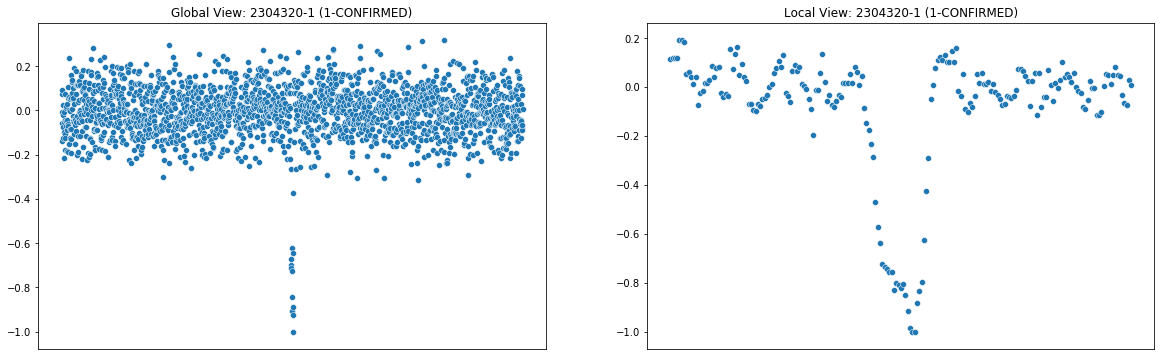

(33594, 201, 1)
(33594, 2001, 1)
(26875, 201, 1)
(26875, 2001, 1)
(26875,)
(26875, 3)
(6719, 201, 1)
(6719, 2001, 1)
(6719,)
(6719, 3)


In [3]:
def get_data():
    #this excludes from tce_list those kepids and planet numbers that failed make_data process
    processed=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,TCE_LIST))
    print(processed.shape)
    try:
        failed=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,FAILED_LIST))
        failed.columns=['kepid','tce_plnt_num']
        print(failed.shape)
        for index,row in failed.iterrows():
            processed.drop(processed[(processed.kepid==row.kepid) & 
                                     (processed.tce_plnt_num==row.tce_plnt_num)].index,inplace=True)
    except:
        pass

    processed=processed.reset_index(drop=True)
    print(processed.shape)

    #maybe need to save processed with failed KEPIDs in it and with a flag - do analysis of how many of those
    #are confirmed?

    #save processed list back out (so excludes those KEPIDS/PLNTs with NO light curves)
    processed.to_csv(os.path.join(PROCESSED_DATA_DIR,PROCESSED_DATA_CATALOG),index=False)
    
    
    print(processed.koi_disposition.value_counts())

    #combine confirmed and candidate
    #using 0 and 1 in front of name to force positive class to be planets
    processed.replace({'koi_disposition':
                       {'CANDIDATE':'1-CONFIRMED','CONFIRMED':'1-CONFIRMED','FALSE POSITIVE':'0-FALSE POSITIVE'}},
                      inplace=True)

    print(processed.koi_disposition.value_counts())
    print('Baseline accuracy:', processed[processed.koi_disposition=='0-FALSE POSITIVE'].shape[0]/processed.shape[0])

    
    LOCAL='localbinned_df.csv'
    GLOBAL='globalbinned_df.csv'
    x_local=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,LOCAL))
    x_global=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,GLOBAL))
    print(x_local.shape)
    print(x_global.shape)
    
    
    #add kepid and tce_plnt_number to x
    tce_id=pd.DataFrame()
    tce_id['kepid']=processed.kepid.astype('int')
    tce_id['tce_plnt_num']=processed.tce_plnt_num.astype('int')
    tce_id['koi_disposition']=processed.koi_disposition
    
    #turn into numpy arrays/series
    x_local=x_local.to_numpy()
    x_global=x_global.to_numpy()
    print(x_local.shape)
    print(x_global.shape)
    
    #can print out charts
    tce_number=3
    chart_curves(tce_id.kepid[tce_number],
                 tce_id.tce_plnt_num[tce_number],
                 x_global[tce_number],
                 x_local[tce_number],
                 tce_id.koi_disposition[tce_number])
    #Conv1D layers take in tensors of dimension (length of vector = 201 or 2001, and dimensions of vector=1)
    #So as with Conv2D in BW where need to add a color dimension here have to specify that there is only one
    #dimension in each vector
    x_local=np.expand_dims(x_local,axis=2)
    x_global=np.expand_dims(x_global,axis=2)

    print(x_local.shape)
    print(x_global.shape)
    
    #turn output into categorical variable with encoding
    Y=processed.koi_disposition
    le=LabelEncoder()
    le.fit(['1-CONFIRMED','0-FALSE POSITIVE'])
    Y=le.transform(Y)
    
    x_local_train, x_local_val, x_global_train, x_global_val, Y_train, Y_val,tce_id_train,tce_id_val = train_test_split(
    x_local,x_global, Y,tce_id, test_size=0.2)


    return (x_local_train, x_local_val, x_global_train, x_global_val, Y_train, Y_val,tce_id_train,tce_id_val)


x_local_train, x_local_val, x_global_train, x_global_val, Y_train, Y_val,tce_id_train,tce_id_val=get_data()   
print(x_local_train.shape)
print(x_global_train.shape)
print(Y_train.shape)
print(tce_id_train.shape)
print(x_local_val.shape)
print(x_global_val.shape)
print(Y_val.shape)
print(tce_id_val.shape)
    
    

In [6]:
#revised for keras-tuner
#model making that allows keras-tuner hyperparameter optimization to be run

def make_cnn_model(hp):
    #model = Sequential()   
    
    
    input_local = tf.keras.layers.Input(shape=[x_local_train.shape[1],1])
    input_global=tf.keras.layers.Input(shape=[x_global_train.shape[1],1])
    
    first_global_cnn_filters=hp.Int('first_global_cnn_filters',min_value=8,max_value=32,step=8)
    further_global_cnn_filters=hp.Int('further_global_cnn_filters',min_value=16,max_value=128, step=16)
    cnn_global_kernel=hp.Int('cnn_global_kernel',min_value=3,max_value=9,step=2)
    cnn_global_maxpool=hp.Int('cnn_global_maxpool',min_value=3,max_value=7,step=2)
    cnn_global_stride=hp.Int('cnn_global_stride',min_value=1,max_value=3,step=1)
    
    first_local_cnn_filters=hp.Int('first_local_cnn_filters',min_value=8,max_value=32,step=8)
    further_local_cnn_filters=hp.Int('further_local_cnn_filters',min_value=16,max_value=128, step=16)
    cnn_local_kernel=hp.Int('cnn_local_kernel',min_value=3,max_value=9,step=2)
    cnn_local_maxpool=hp.Int('cnn_local_maxpool',min_value=3,max_value=9,step=2)
    cnn_local_stride=hp.Int('cnn_local_stride',min_value=1,max_value=3,step=1)   
    
    cnn_activation=hp.Choice('cnn_activation',values=['relu'])#,'PReLU()'])
    
    
    #first global cnn
    k_global=tf.keras.layers.Conv1D(filters=first_global_cnn_filters,
                                    kernel_size=cnn_global_kernel,
                                    activation=cnn_activation)(input_global)
    
    k_global=tf.keras.layers.MaxPooling1D(pool_size=cnn_global_maxpool,
                                              strides=cnn_global_stride,padding='same')(k_global)
    
    #first local cnn
    k_local=tf.keras.layers.Conv1D(filters=first_local_cnn_filters,
                                    kernel_size=cnn_local_kernel,
                                    activation=cnn_activation)(input_local)
    
    k_local=tf.keras.layers.MaxPooling1D(pool_size=cnn_local_maxpool,
                                              strides=cnn_local_stride,padding='same')(k_local)
    
    
    
    further_global_cnn_layers=hp.Int('further_global_cnn_layers',min_value=1,max_value=4,step=1)
    further_local_cnn_layers=hp.Int('further_global_cnn_layers',min_value=1,max_value=4,step=1)
    
    for i in range(further_global_cnn_layers):
        k_global=tf.keras.layers.Conv1D(filters=further_global_cnn_filters,
                                    kernel_size=cnn_global_kernel,
                                    activation=cnn_activation)(k_global)
        k_global=tf.keras.layers.MaxPooling1D(pool_size=cnn_global_maxpool,
                                              strides=cnn_global_stride,padding='same')(k_global)
    
    for i in range(further_local_cnn_layers):
        k_local=tf.keras.layers.Conv1D(filters=further_local_cnn_filters,
                                    kernel_size=cnn_local_kernel,
                                    activation=cnn_activation)(k_local)
        k_local=tf.keras.layers.MaxPooling1D(pool_size=cnn_local_maxpool,
                                              strides=cnn_local_stride,padding='same')(k_local)
        
    #flatten and concatenate
    k_global=tf.keras.layers.Flatten()(k_global)
    k_local=tf.keras.layers.Flatten()(k_local)
    k = tf.keras.layers.concatenate([k_local, k_global])
    
    
    number_of_dense_layers=hp.Int('number_of_dense_layers',min_value=2,max_value=5,step=1)
    size_of_dense_layers=hp.Int('size_of_dense_layers',min_value=64, max_value=512, step=64)
    dense_activation=hp.Choice('dense_activation',values=['relu'])#,'PReLU()'])
    dense_dropout=hp.Choice('dense_dropout',values=[0.0,.2,.5])
    
    #now add dense layers
    for i in range(number_of_dense_layers):
        k=tf.keras.layers.Dense(size_of_dense_layers,activation=dense_activation)(k)
        k=tf.keras.layers.Dropout(dense_dropout)(k)
    
    #output layer        
    output=tf.keras.layers.Dense(1,activation='sigmoid')(k)

    model=tf.keras.Model(inputs=[input_local,input_global],outputs=output)

    learning_rate=hp.Choice('learning_rate',values=[1e-2,1e-3,1e-4])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy()
                  ,optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=METRICS)
    return model

In [ ]:
#may need to delete directory so doesn't reload?
#tuner = kt.Hyperband(make_cnn_model,
#                     kt.Objective("val_auc", direction="max"), 
#                     max_epochs = 15,
#                     factor = 3,
#                     directory = 'hyper',
#                     project_name = 'w2p')     

tuner=kt.RandomSearch(make_cnn_model,
                     kt.Objective("val_auc",direction="max"),
                     max_trials=10,
                     executions_per_trial=2)


#class ClearTrainingOutput(tf.keras.callbacks.Callback):
#  def on_train_end(*args, **kwargs):
#    IPython.display.clear_output(wait = True)
    
#tf.keras.backend.clear_session()
tuner.search([x_local_train,x_global_train],
             Y_train,
             epochs = 10, 
             validation_data=([x_local_val,x_global_val],Y_val))#,
             #callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]



Epoch 1/10


 53/840 [>.............................] - ETA: 0s - loss: 0.6783 - tp: 681.0000 - fp: 147.0000 - tn: 5773.0000 - fn: 150.0000 - accuracy: 0.9560 - precision: 0.8225 - recall: 0.8195 - auc: 0.96 - ETA: 1:00 - loss: 5.2273 - tp: 681.0000 - fp: 147.0000 - tn: 5803.0000 - fn: 152.0000 - accuracy: 0.9559 - precision: 0.8225 - recall: 0.8175 - auc: 0.96 - ETA: 1:23 - loss: 3.6879 - tp: 681.0000 - fp: 147.0000 - tn: 5832.0000 - fn: 155.0000 - accuracy: 0.9557 - precision: 0.8225 - recall: 0.8146 - auc: 0.96 - ETA: 1:35 - loss: 2.9168 - tp: 681.0000 - fp: 147.0000 - tn: 5861.0000 - fn: 158.0000 - accuracy: 0.9555 - precision: 0.8225 - recall: 0.8117 - auc: 0.96 - ETA: 1:42 - loss: 2.4069 - tp: 681.0000 - fp: 147.0000 - tn: 5888.0000 - fn: 163.0000 - accuracy: 0.9549 - precision: 0.8225 - recall: 0.8069 - auc: 0.96 - ETA: 1:43 - loss: 2.1639 - tp: 681.0000 - fp: 147.0000 - tn: 5914.0000 - fn: 169.0000 - accuracy: 0.9543 - precision: 0.8225 - recall: 0.8012 - auc: 0.95 - ETA: 1:48 - loss: 1.925

106/840 [==>...........................] - ETA: 1:52 - loss: 0.5209 - tp: 699.0000 - fp: 159.0000 - tn: 7241.0000 - fn: 348.0000 - accuracy: 0.9400 - precision: 0.8147 - recall: 0.6676 - auc: 0.94 - ETA: 1:51 - loss: 0.5143 - tp: 705.0000 - fp: 159.0000 - tn: 7267.0000 - fn: 348.0000 - accuracy: 0.9402 - precision: 0.8160 - recall: 0.6695 - auc: 0.94 - ETA: 1:51 - loss: 0.5093 - tp: 707.0000 - fp: 161.0000 - tn: 7294.0000 - fn: 349.0000 - accuracy: 0.9401 - precision: 0.8145 - recall: 0.6695 - auc: 0.94 - ETA: 1:51 - loss: 0.5073 - tp: 711.0000 - fp: 162.0000 - tn: 7320.0000 - fn: 350.0000 - accuracy: 0.9401 - precision: 0.8144 - recall: 0.6701 - auc: 0.94 - ETA: 1:51 - loss: 0.5016 - tp: 713.0000 - fp: 162.0000 - tn: 7347.0000 - fn: 353.0000 - accuracy: 0.9399 - precision: 0.8149 - recall: 0.6689 - auc: 0.94 - ETA: 1:51 - loss: 0.4948 - tp: 714.0000 - fp: 162.0000 - tn: 7376.0000 - fn: 355.0000 - accuracy: 0.9399 - precision: 0.8151 - recall: 0.6679 - auc: 0.94 - ETA: 1:51 - loss: 0.4

159/840 [====>.........................] - ETA: 1:45 - loss: 0.3678 - tp: 800.0000 - fp: 207.0000 - tn: 8698.0000 - fn: 438.0000 - accuracy: 0.9364 - precision: 0.7944 - recall: 0.6462 - auc: 0.93 - ETA: 1:44 - loss: 0.3665 - tp: 805.0000 - fp: 209.0000 - tn: 8721.0000 - fn: 440.0000 - accuracy: 0.9362 - precision: 0.7939 - recall: 0.6466 - auc: 0.93 - ETA: 1:44 - loss: 0.3643 - tp: 807.0000 - fp: 211.0000 - tn: 8749.0000 - fn: 440.0000 - accuracy: 0.9362 - precision: 0.7927 - recall: 0.6472 - auc: 0.93 - ETA: 1:44 - loss: 0.3618 - tp: 814.0000 - fp: 211.0000 - tn: 8774.0000 - fn: 440.0000 - accuracy: 0.9364 - precision: 0.7941 - recall: 0.6491 - auc: 0.94 - ETA: 1:44 - loss: 0.3614 - tp: 821.0000 - fp: 212.0000 - tn: 8796.0000 - fn: 442.0000 - accuracy: 0.9363 - precision: 0.7948 - recall: 0.6500 - auc: 0.94 - ETA: 1:44 - loss: 0.3590 - tp: 826.0000 - fp: 212.0000 - tn: 8823.0000 - fn: 442.0000 - accuracy: 0.9365 - precision: 0.7958 - recall: 0.6514 - auc: 0.94 - ETA: 1:44 - loss: 0.3

211/840 [======>.......................] - ETA: 1:36 - loss: 0.3275 - tp: 949.0000 - fp: 266.0000 - tn: 10105.0000 - fn: 519.0000 - accuracy: 0.9337 - precision: 0.7811 - recall: 0.6465 - auc: 0.936 - ETA: 1:36 - loss: 0.3270 - tp: 949.0000 - fp: 266.0000 - tn: 10131.0000 - fn: 525.0000 - accuracy: 0.9334 - precision: 0.7811 - recall: 0.6438 - auc: 0.936 - ETA: 1:36 - loss: 0.3269 - tp: 949.0000 - fp: 266.0000 - tn: 10156.0000 - fn: 532.0000 - accuracy: 0.9330 - precision: 0.7811 - recall: 0.6408 - auc: 0.936 - ETA: 1:36 - loss: 0.3257 - tp: 949.0000 - fp: 266.0000 - tn: 10184.0000 - fn: 536.0000 - accuracy: 0.9328 - precision: 0.7811 - recall: 0.6391 - auc: 0.937 - ETA: 1:36 - loss: 0.3247 - tp: 949.0000 - fp: 266.0000 - tn: 10213.0000 - fn: 539.0000 - accuracy: 0.9327 - precision: 0.7811 - recall: 0.6378 - auc: 0.937 - ETA: 1:35 - loss: 0.3244 - tp: 949.0000 - fp: 266.0000 - tn: 10241.0000 - fn: 543.0000 - accuracy: 0.9326 - precision: 0.7811 - recall: 0.6361 - auc: 0.936 - ETA: 1:35

263/840 [========>.....................] - ETA: 1:29 - loss: 0.2942 - tp: 1058.0000 - fp: 320.0000 - tn: 11517.0000 - fn: 608.0000 - accuracy: 0.9313 - precision: 0.7678 - recall: 0.6351 - auc: 0.93 - ETA: 1:29 - loss: 0.2935 - tp: 1062.0000 - fp: 322.0000 - tn: 11543.0000 - fn: 608.0000 - accuracy: 0.9313 - precision: 0.7673 - recall: 0.6359 - auc: 0.93 - ETA: 1:29 - loss: 0.2935 - tp: 1063.0000 - fp: 323.0000 - tn: 11571.0000 - fn: 610.0000 - accuracy: 0.9312 - precision: 0.7670 - recall: 0.6354 - auc: 0.93 - ETA: 1:29 - loss: 0.2927 - tp: 1067.0000 - fp: 323.0000 - tn: 11598.0000 - fn: 611.0000 - accuracy: 0.9313 - precision: 0.7676 - recall: 0.6359 - auc: 0.93 - ETA: 1:28 - loss: 0.2923 - tp: 1068.0000 - fp: 324.0000 - tn: 11626.0000 - fn: 613.0000 - accuracy: 0.9313 - precision: 0.7672 - recall: 0.6353 - auc: 0.93 - ETA: 1:28 - loss: 0.2919 - tp: 1071.0000 - fp: 324.0000 - tn: 11653.0000 - fn: 615.0000 - accuracy: 0.9313 - precision: 0.7677 - recall: 0.6352 - auc: 0.93 - ETA: 1:28

315/840 [==========>...................] - ETA: 1:21 - loss: 0.2806 - tp: 1205.0000 - fp: 402.0000 - tn: 12886.0000 - fn: 674.0000 - accuracy: 0.9291 - precision: 0.7498 - recall: 0.6413 - auc: 0.93 - ETA: 1:21 - loss: 0.2802 - tp: 1205.0000 - fp: 404.0000 - tn: 12915.0000 - fn: 675.0000 - accuracy: 0.9290 - precision: 0.7489 - recall: 0.6410 - auc: 0.93 - ETA: 1:21 - loss: 0.2798 - tp: 1209.0000 - fp: 405.0000 - tn: 12941.0000 - fn: 676.0000 - accuracy: 0.9290 - precision: 0.7491 - recall: 0.6414 - auc: 0.93 - ETA: 1:21 - loss: 0.2793 - tp: 1214.0000 - fp: 405.0000 - tn: 12968.0000 - fn: 676.0000 - accuracy: 0.9292 - precision: 0.7498 - recall: 0.6423 - auc: 0.93 - ETA: 1:21 - loss: 0.2788 - tp: 1220.0000 - fp: 406.0000 - tn: 12992.0000 - fn: 677.0000 - accuracy: 0.9292 - precision: 0.7503 - recall: 0.6431 - auc: 0.93 - ETA: 1:20 - loss: 0.2783 - tp: 1222.0000 - fp: 408.0000 - tn: 13019.0000 - fn: 678.0000 - accuracy: 0.9291 - precision: 0.7497 - recall: 0.6432 - auc: 0.93 - ETA: 1:20

367/840 [============>.................] - ETA: 1:14 - loss: 0.2651 - tp: 1349.0000 - fp: 463.0000 - tn: 14297.0000 - fn: 722.0000 - accuracy: 0.9296 - precision: 0.7445 - recall: 0.6514 - auc: 0.93 - ETA: 1:14 - loss: 0.2648 - tp: 1351.0000 - fp: 464.0000 - tn: 14325.0000 - fn: 723.0000 - accuracy: 0.9296 - precision: 0.7444 - recall: 0.6514 - auc: 0.93 - ETA: 1:13 - loss: 0.2649 - tp: 1355.0000 - fp: 467.0000 - tn: 14349.0000 - fn: 724.0000 - accuracy: 0.9295 - precision: 0.7437 - recall: 0.6518 - auc: 0.93 - ETA: 1:13 - loss: 0.2646 - tp: 1364.0000 - fp: 469.0000 - tn: 14370.0000 - fn: 724.0000 - accuracy: 0.9295 - precision: 0.7441 - recall: 0.6533 - auc: 0.93 - ETA: 1:13 - loss: 0.2651 - tp: 1366.0000 - fp: 470.0000 - tn: 14397.0000 - fn: 726.0000 - accuracy: 0.9295 - precision: 0.7440 - recall: 0.6530 - auc: 0.93 - ETA: 1:13 - loss: 0.2644 - tp: 1370.0000 - fp: 470.0000 - tn: 14425.0000 - fn: 726.0000 - accuracy: 0.9296 - precision: 0.7446 - recall: 0.6536 - auc: 0.93 - ETA: 1:13

419/840 [=============>................] - ETA: 1:06 - loss: 0.2610 - tp: 1494.0000 - fp: 528.0000 - tn: 15688.0000 - fn: 785.0000 - accuracy: 0.9290 - precision: 0.7389 - recall: 0.6556 - auc: 0.93 - ETA: 1:06 - loss: 0.2629 - tp: 1495.0000 - fp: 528.0000 - tn: 15714.0000 - fn: 790.0000 - accuracy: 0.9289 - precision: 0.7390 - recall: 0.6543 - auc: 0.93 - ETA: 1:06 - loss: 0.2631 - tp: 1496.0000 - fp: 529.0000 - tn: 15739.0000 - fn: 795.0000 - accuracy: 0.9287 - precision: 0.7388 - recall: 0.6530 - auc: 0.93 - ETA: 1:06 - loss: 0.2629 - tp: 1497.0000 - fp: 530.0000 - tn: 15768.0000 - fn: 796.0000 - accuracy: 0.9287 - precision: 0.7385 - recall: 0.6529 - auc: 0.93 - ETA: 1:06 - loss: 0.2631 - tp: 1501.0000 - fp: 532.0000 - tn: 15792.0000 - fn: 798.0000 - accuracy: 0.9286 - precision: 0.7383 - recall: 0.6529 - auc: 0.93 - ETA: 1:06 - loss: 0.2631 - tp: 1504.0000 - fp: 534.0000 - tn: 15818.0000 - fn: 799.0000 - accuracy: 0.9285 - precision: 0.7380 - recall: 0.6531 - auc: 0.93 - ETA: 1:05

471/840 [===============>..............] - ETA: 59s - loss: 0.2611 - tp: 1644.0000 - fp: 614.0000 - tn: 17050.0000 - fn: 851.0000 - accuracy: 0.9273 - precision: 0.7281 - recall: 0.6589 - auc: 0.930 - ETA: 59s - loss: 0.2612 - tp: 1646.0000 - fp: 616.0000 - tn: 17076.0000 - fn: 853.0000 - accuracy: 0.9272 - precision: 0.7277 - recall: 0.6587 - auc: 0.930 - ETA: 59s - loss: 0.2610 - tp: 1646.0000 - fp: 619.0000 - tn: 17104.0000 - fn: 854.0000 - accuracy: 0.9272 - precision: 0.7267 - recall: 0.6584 - auc: 0.930 - ETA: 58s - loss: 0.2609 - tp: 1649.0000 - fp: 620.0000 - tn: 17129.0000 - fn: 857.0000 - accuracy: 0.9271 - precision: 0.7268 - recall: 0.6580 - auc: 0.930 - ETA: 58s - loss: 0.2608 - tp: 1649.0000 - fp: 623.0000 - tn: 17157.0000 - fn: 858.0000 - accuracy: 0.9270 - precision: 0.7258 - recall: 0.6578 - auc: 0.930 - ETA: 58s - loss: 0.2604 - tp: 1651.0000 - fp: 623.0000 - tn: 17186.0000 - fn: 859.0000 - accuracy: 0.9271 - precision: 0.7260 - recall: 0.6578 - auc: 0.930 - ETA: 58s 

523/840 [=================>............] - ETA: 52s - loss: 0.2611 - tp: 1795.0000 - fp: 691.0000 - tn: 18411.0000 - fn: 926.0000 - accuracy: 0.9259 - precision: 0.7220 - recall: 0.6597 - auc: 0.929 - ETA: 51s - loss: 0.2615 - tp: 1799.0000 - fp: 691.0000 - tn: 18437.0000 - fn: 928.0000 - accuracy: 0.9259 - precision: 0.7225 - recall: 0.6597 - auc: 0.929 - ETA: 51s - loss: 0.2618 - tp: 1802.0000 - fp: 694.0000 - tn: 18462.0000 - fn: 929.0000 - accuracy: 0.9258 - precision: 0.7220 - recall: 0.6598 - auc: 0.929 - ETA: 51s - loss: 0.2621 - tp: 1805.0000 - fp: 697.0000 - tn: 18488.0000 - fn: 929.0000 - accuracy: 0.9258 - precision: 0.7214 - recall: 0.6602 - auc: 0.929 - ETA: 51s - loss: 0.2625 - tp: 1810.0000 - fp: 698.0000 - tn: 18510.0000 - fn: 933.0000 - accuracy: 0.9257 - precision: 0.7217 - recall: 0.6599 - auc: 0.929 - ETA: 51s - loss: 0.2626 - tp: 1812.0000 - fp: 698.0000 - tn: 18538.0000 - fn: 935.0000 - accuracy: 0.9257 - precision: 0.7219 - recall: 0.6596 - auc: 0.928 - ETA: 51s 

575/840 [===================>..........] - ETA: 44s - loss: 0.2694 - tp: 1946.0000 - fp: 782.0000 - tn: 19761.0000 - fn: 998.0000 - accuracy: 0.9242 - precision: 0.7133 - recall: 0.6610 - auc: 0.928 - ETA: 44s - loss: 0.2692 - tp: 1950.0000 - fp: 784.0000 - tn: 19787.0000 - fn: 998.0000 - accuracy: 0.9242 - precision: 0.7132 - recall: 0.6615 - auc: 0.928 - ETA: 44s - loss: 0.2689 - tp: 1951.0000 - fp: 786.0000 - tn: 19816.0000 - fn: 998.0000 - accuracy: 0.9242 - precision: 0.7128 - recall: 0.6616 - auc: 0.928 - ETA: 44s - loss: 0.2687 - tp: 1954.0000 - fp: 788.0000 - tn: 19843.0000 - fn: 998.0000 - accuracy: 0.9243 - precision: 0.7126 - recall: 0.6619 - auc: 0.928 - ETA: 44s - loss: 0.2683 - tp: 1955.0000 - fp: 788.0000 - tn: 19874.0000 - fn: 998.0000 - accuracy: 0.9244 - precision: 0.7127 - recall: 0.6620 - auc: 0.928 - ETA: 44s - loss: 0.2685 - tp: 1955.0000 - fp: 792.0000 - tn: 19899.0000 - fn: 1001.0000 - accuracy: 0.9242 - precision: 0.7117 - recall: 0.6614 - auc: 0.92 - ETA: 43s 

627/840 [=====================>........] - ETA: 37s - loss: 0.2640 - tp: 2066.0000 - fp: 853.0000 - tn: 21161.0000 - fn: 1071.0000 - accuracy: 0.9235 - precision: 0.7078 - recall: 0.6586 - auc: 0.92 - ETA: 37s - loss: 0.2637 - tp: 2070.0000 - fp: 853.0000 - tn: 21188.0000 - fn: 1072.0000 - accuracy: 0.9236 - precision: 0.7082 - recall: 0.6588 - auc: 0.92 - ETA: 37s - loss: 0.2634 - tp: 2073.0000 - fp: 854.0000 - tn: 21215.0000 - fn: 1073.0000 - accuracy: 0.9236 - precision: 0.7082 - recall: 0.6589 - auc: 0.92 - ETA: 36s - loss: 0.2634 - tp: 2074.0000 - fp: 856.0000 - tn: 21241.0000 - fn: 1076.0000 - accuracy: 0.9235 - precision: 0.7078 - recall: 0.6584 - auc: 0.92 - ETA: 36s - loss: 0.2632 - tp: 2076.0000 - fp: 857.0000 - tn: 21268.0000 - fn: 1078.0000 - accuracy: 0.9235 - precision: 0.7078 - recall: 0.6582 - auc: 0.92 - ETA: 36s - loss: 0.2630 - tp: 2078.0000 - fp: 860.0000 - tn: 21295.0000 - fn: 1078.0000 - accuracy: 0.9234 - precision: 0.7073 - recall: 0.6584 - auc: 0.92 - ETA: 36s 

679/840 [=======================>......] - ETA: 30s - loss: 0.2603 - tp: 2190.0000 - fp: 919.0000 - tn: 22551.0000 - fn: 1155.0000 - accuracy: 0.9227 - precision: 0.7044 - recall: 0.6547 - auc: 0.92 - ETA: 29s - loss: 0.2601 - tp: 2193.0000 - fp: 920.0000 - tn: 22578.0000 - fn: 1156.0000 - accuracy: 0.9227 - precision: 0.7045 - recall: 0.6548 - auc: 0.92 - ETA: 29s - loss: 0.2601 - tp: 2196.0000 - fp: 922.0000 - tn: 22603.0000 - fn: 1158.0000 - accuracy: 0.9226 - precision: 0.7043 - recall: 0.6547 - auc: 0.92 - ETA: 29s - loss: 0.2598 - tp: 2197.0000 - fp: 922.0000 - tn: 22633.0000 - fn: 1159.0000 - accuracy: 0.9227 - precision: 0.7044 - recall: 0.6546 - auc: 0.92 - ETA: 29s - loss: 0.2601 - tp: 2199.0000 - fp: 924.0000 - tn: 22658.0000 - fn: 1162.0000 - accuracy: 0.9226 - precision: 0.7041 - recall: 0.6543 - auc: 0.92 - ETA: 29s - loss: 0.2600 - tp: 2200.0000 - fp: 924.0000 - tn: 22685.0000 - fn: 1166.0000 - accuracy: 0.9225 - precision: 0.7042 - recall: 0.6536 - auc: 0.92 - ETA: 29s 

731/840 [=========================>....] - ETA: 22s - loss: 0.2595 - tp: 2322.0000 - fp: 974.0000 - tn: 23939.0000 - fn: 1244.0000 - accuracy: 0.9221 - precision: 0.7045 - recall: 0.6511 - auc: 0.92 - ETA: 22s - loss: 0.2596 - tp: 2325.0000 - fp: 974.0000 - tn: 23966.0000 - fn: 1246.0000 - accuracy: 0.9221 - precision: 0.7048 - recall: 0.6511 - auc: 0.92 - ETA: 22s - loss: 0.2595 - tp: 2325.0000 - fp: 978.0000 - tn: 23994.0000 - fn: 1246.0000 - accuracy: 0.9221 - precision: 0.7039 - recall: 0.6511 - auc: 0.92 - ETA: 22s - loss: 0.2596 - tp: 2327.0000 - fp: 981.0000 - tn: 24019.0000 - fn: 1248.0000 - accuracy: 0.9220 - precision: 0.7034 - recall: 0.6509 - auc: 0.92 - ETA: 22s - loss: 0.2597 - tp: 2330.0000 - fp: 984.0000 - tn: 24043.0000 - fn: 1250.0000 - accuracy: 0.9219 - precision: 0.7031 - recall: 0.6508 - auc: 0.92 - ETA: 21s - loss: 0.2596 - tp: 2334.0000 - fp: 984.0000 - tn: 24070.0000 - fn: 1251.0000 - accuracy: 0.9220 - precision: 0.7034 - recall: 0.6510 - auc: 0.92 - ETA: 21s 

783/840 [==========================>...] - ETA: 15s - loss: 0.2547 - tp: 2456.0000 - fp: 1047.0000 - tn: 25339.0000 - fn: 1301.0000 - accuracy: 0.9221 - precision: 0.7011 - recall: 0.6537 - auc: 0.925 - ETA: 15s - loss: 0.2547 - tp: 2459.0000 - fp: 1047.0000 - tn: 25366.0000 - fn: 1303.0000 - accuracy: 0.9221 - precision: 0.7014 - recall: 0.6536 - auc: 0.925 - ETA: 15s - loss: 0.2545 - tp: 2460.0000 - fp: 1048.0000 - tn: 25394.0000 - fn: 1305.0000 - accuracy: 0.9221 - precision: 0.7013 - recall: 0.6534 - auc: 0.925 - ETA: 14s - loss: 0.2545 - tp: 2463.0000 - fp: 1049.0000 - tn: 25421.0000 - fn: 1306.0000 - accuracy: 0.9221 - precision: 0.7013 - recall: 0.6535 - auc: 0.925 - ETA: 14s - loss: 0.2542 - tp: 2467.0000 - fp: 1049.0000 - tn: 25448.0000 - fn: 1307.0000 - accuracy: 0.9222 - precision: 0.7016 - recall: 0.6537 - auc: 0.925 - ETA: 14s - loss: 0.2540 - tp: 2472.0000 - fp: 1050.0000 - tn: 25473.0000 - fn: 1308.0000 - accuracy: 0.9222 - precision: 0.7019 - recall: 0.6540 - auc: 0.925

835/840 [============================>.] - ETA: 7s - loss: 0.2510 - tp: 2600.0000 - fp: 1095.0000 - tn: 26737.0000 - fn: 1375.0000 - accuracy: 0.9223 - precision: 0.7037 - recall: 0.6541 - auc: 0.92 - ETA: 7s - loss: 0.2508 - tp: 2602.0000 - fp: 1096.0000 - tn: 26765.0000 - fn: 1376.0000 - accuracy: 0.9224 - precision: 0.7036 - recall: 0.6541 - auc: 0.92 - ETA: 7s - loss: 0.2510 - tp: 2605.0000 - fp: 1098.0000 - tn: 26790.0000 - fn: 1378.0000 - accuracy: 0.9223 - precision: 0.7035 - recall: 0.6540 - auc: 0.92 - ETA: 7s - loss: 0.2510 - tp: 2607.0000 - fp: 1102.0000 - tn: 26816.0000 - fn: 1378.0000 - accuracy: 0.9223 - precision: 0.7029 - recall: 0.6542 - auc: 0.92 - ETA: 7s - loss: 0.2509 - tp: 2608.0000 - fp: 1103.0000 - tn: 26844.0000 - fn: 1380.0000 - accuracy: 0.9222 - precision: 0.7028 - recall: 0.6540 - auc: 0.92 - ETA: 7s - loss: 0.2507 - tp: 2612.0000 - fp: 1103.0000 - tn: 26872.0000 - fn: 1380.0000 - accuracy: 0.9223 - precision: 0.7031 - recall: 0.6543 - auc: 0.92 - ETA: 7s -

840/840 [==============================] - ETA: 0s - loss: 0.2504 - tp: 2688.0000 - fp: 1147.0000 - tn: 28142.0000 - fn: 1494.0000 - accuracy: 0.9211 - precision: 0.7009 - recall: 0.6428 - auc: 0.92 - ETA: 0s - loss: 0.2504 - tp: 2692.0000 - fp: 1150.0000 - tn: 28165.0000 - fn: 1496.0000 - accuracy: 0.9210 - precision: 0.7007 - recall: 0.6428 - auc: 0.92 - ETA: 0s - loss: 0.2503 - tp: 2694.0000 - fp: 1151.0000 - tn: 28192.0000 - fn: 1498.0000 - accuracy: 0.9210 - precision: 0.7007 - recall: 0.6427 - auc: 0.92 - ETA: 0s - loss: 0.2502 - tp: 2697.0000 - fp: 1152.0000 - tn: 28219.0000 - fn: 1499.0000 - accuracy: 0.9210 - precision: 0.7007 - recall: 0.6428 - auc: 0.92 - ETA: 0s - loss: 0.2501 - tp: 2698.0000 - fp: 1154.0000 - tn: 28243.0000 - fn: 1499.0000 - accuracy: 0.9210 - precision: 0.7004 - recall: 0.6428 - auc: 0.92 - 126s 150ms/step - loss: 0.2501 - tp: 2698.0000 - fp: 1154.0000 - tn: 28243.0000 - fn: 1499.0000 - accuracy: 0.9210 - precision: 0.7004 - recall: 0.6428 - auc: 0.9240 -

 54/840 [>.............................] - ETA: 0s - loss: 0.0789 - tp: 3.0000 - fp: 0.0000e+00 - tn: 29.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.00 - ETA: 58s - loss: 1.0722 - tp: 7.0000 - fp: 0.0000e+00 - tn: 56.0000 - fn: 1.0000 - accuracy: 0.9844 - precision: 1.0000 - recall: 0.8750 - auc: 0.8951   - ETA: 1:14 - loss: 0.7952 - tp: 13.0000 - fp: 2.0000 - tn: 79.0000 - fn: 2.0000 - accuracy: 0.9583 - precision: 0.8667 - recall: 0.8667 - auc: 0.9280  - ETA: 1:28 - loss: 0.6397 - tp: 17.0000 - fp: 3.0000 - tn: 105.0000 - fn: 3.0000 - accuracy: 0.9531 - precision: 0.8500 - recall: 0.8500 - auc: 0.93 - ETA: 1:33 - loss: 0.5749 - tp: 19.0000 - fp: 4.0000 - tn: 132.0000 - fn: 5.0000 - accuracy: 0.9438 - precision: 0.8261 - recall: 0.7917 - auc: 0.93 - ETA: 1:38 - loss: 0.5263 - tp: 23.0000 - fp: 4.0000 - tn: 157.0000 - fn: 8.0000 - accuracy: 0.9375 - precision: 0.8519 - recall: 0.7419 - auc: 0.94 - ETA: 1:41 - loss: 0.4972 - tp: 29.0000 - fp: 6

107/840 [==>...........................] - ETA: 1:49 - loss: 0.2944 - tp: 176.0000 - fp: 78.0000 - tn: 1439.0000 - fn: 67.0000 - accuracy: 0.9176 - precision: 0.6929 - recall: 0.7243 - auc: 0.90 - ETA: 1:49 - loss: 0.2911 - tp: 176.0000 - fp: 80.0000 - tn: 1468.0000 - fn: 68.0000 - accuracy: 0.9174 - precision: 0.6875 - recall: 0.7213 - auc: 0.90 - ETA: 1:49 - loss: 0.2887 - tp: 183.0000 - fp: 80.0000 - tn: 1493.0000 - fn: 68.0000 - accuracy: 0.9189 - precision: 0.6958 - recall: 0.7291 - auc: 0.90 - ETA: 1:49 - loss: 0.2872 - tp: 183.0000 - fp: 82.0000 - tn: 1520.0000 - fn: 71.0000 - accuracy: 0.9176 - precision: 0.6906 - recall: 0.7205 - auc: 0.90 - ETA: 1:49 - loss: 0.2885 - tp: 188.0000 - fp: 82.0000 - tn: 1545.0000 - fn: 73.0000 - accuracy: 0.9179 - precision: 0.6963 - recall: 0.7203 - auc: 0.90 - ETA: 1:49 - loss: 0.2848 - tp: 190.0000 - fp: 83.0000 - tn: 1574.0000 - fn: 73.0000 - accuracy: 0.9187 - precision: 0.6960 - recall: 0.7224 - auc: 0.90 - ETA: 1:49 - loss: 0.2815 - tp: 19

160/840 [====>.........................] - ETA: 1:43 - loss: 0.2520 - tp: 359.0000 - fp: 164.0000 - tn: 2811.0000 - fn: 122.0000 - accuracy: 0.9172 - precision: 0.6864 - recall: 0.7464 - auc: 0.91 - ETA: 1:43 - loss: 0.2516 - tp: 360.0000 - fp: 165.0000 - tn: 2839.0000 - fn: 124.0000 - accuracy: 0.9171 - precision: 0.6857 - recall: 0.7438 - auc: 0.91 - ETA: 1:43 - loss: 0.2525 - tp: 364.0000 - fp: 165.0000 - tn: 2862.0000 - fn: 129.0000 - accuracy: 0.9165 - precision: 0.6881 - recall: 0.7383 - auc: 0.91 - ETA: 1:43 - loss: 0.2531 - tp: 367.0000 - fp: 170.0000 - tn: 2885.0000 - fn: 130.0000 - accuracy: 0.9155 - precision: 0.6834 - recall: 0.7384 - auc: 0.91 - ETA: 1:43 - loss: 0.2534 - tp: 371.0000 - fp: 170.0000 - tn: 2909.0000 - fn: 134.0000 - accuracy: 0.9152 - precision: 0.6858 - recall: 0.7347 - auc: 0.91 - ETA: 1:42 - loss: 0.2538 - tp: 372.0000 - fp: 172.0000 - tn: 2936.0000 - fn: 136.0000 - accuracy: 0.9148 - precision: 0.6838 - recall: 0.7323 - auc: 0.91 - ETA: 1:42 - loss: 0.2

213/840 [======>.......................] - ETA: 1:35 - loss: 0.2361 - tp: 504.0000 - fp: 223.0000 - tn: 4238.0000 - fn: 187.0000 - accuracy: 0.9204 - precision: 0.6933 - recall: 0.7294 - auc: 0.92 - ETA: 1:35 - loss: 0.2354 - tp: 507.0000 - fp: 226.0000 - tn: 4264.0000 - fn: 187.0000 - accuracy: 0.9203 - precision: 0.6917 - recall: 0.7305 - auc: 0.92 - ETA: 1:35 - loss: 0.2349 - tp: 510.0000 - fp: 227.0000 - tn: 4292.0000 - fn: 187.0000 - accuracy: 0.9206 - precision: 0.6920 - recall: 0.7317 - auc: 0.92 - ETA: 1:35 - loss: 0.2342 - tp: 512.0000 - fp: 228.0000 - tn: 4320.0000 - fn: 188.0000 - accuracy: 0.9207 - precision: 0.6919 - recall: 0.7314 - auc: 0.92 - ETA: 1:35 - loss: 0.2345 - tp: 513.0000 - fp: 228.0000 - tn: 4348.0000 - fn: 191.0000 - accuracy: 0.9206 - precision: 0.6923 - recall: 0.7287 - auc: 0.92 - ETA: 1:35 - loss: 0.2348 - tp: 516.0000 - fp: 229.0000 - tn: 4374.0000 - fn: 193.0000 - accuracy: 0.9206 - precision: 0.6926 - recall: 0.7278 - auc: 0.92 - ETA: 1:35 - loss: 0.2

266/840 [========>.....................] - ETA: 1:28 - loss: 0.2390 - tp: 639.0000 - fp: 279.0000 - tn: 5648.0000 - fn: 282.0000 - accuracy: 0.9181 - precision: 0.6961 - recall: 0.6938 - auc: 0.91 - ETA: 1:28 - loss: 0.2395 - tp: 641.0000 - fp: 280.0000 - tn: 5675.0000 - fn: 284.0000 - accuracy: 0.9180 - precision: 0.6960 - recall: 0.6930 - auc: 0.91 - ETA: 1:28 - loss: 0.2398 - tp: 644.0000 - fp: 281.0000 - tn: 5701.0000 - fn: 286.0000 - accuracy: 0.9180 - precision: 0.6962 - recall: 0.6925 - auc: 0.91 - ETA: 1:28 - loss: 0.2400 - tp: 644.0000 - fp: 282.0000 - tn: 5730.0000 - fn: 288.0000 - accuracy: 0.9179 - precision: 0.6955 - recall: 0.6910 - auc: 0.91 - ETA: 1:28 - loss: 0.2406 - tp: 647.0000 - fp: 284.0000 - tn: 5753.0000 - fn: 292.0000 - accuracy: 0.9174 - precision: 0.6950 - recall: 0.6890 - auc: 0.91 - ETA: 1:28 - loss: 0.2402 - tp: 651.0000 - fp: 286.0000 - tn: 5779.0000 - fn: 292.0000 - accuracy: 0.9175 - precision: 0.6948 - recall: 0.6903 - auc: 0.91 - ETA: 1:28 - loss: 0.2

319/840 [==========>...................] - ETA: 1:21 - loss: 0.2330 - tp: 795.0000 - fp: 340.0000 - tn: 7069.0000 - fn: 340.0000 - accuracy: 0.9204 - precision: 0.7004 - recall: 0.7004 - auc: 0.91 - ETA: 1:20 - loss: 0.2323 - tp: 796.0000 - fp: 340.0000 - tn: 7100.0000 - fn: 340.0000 - accuracy: 0.9207 - precision: 0.7007 - recall: 0.7007 - auc: 0.91 - ETA: 1:20 - loss: 0.2322 - tp: 798.0000 - fp: 340.0000 - tn: 7128.0000 - fn: 342.0000 - accuracy: 0.9208 - precision: 0.7012 - recall: 0.7000 - auc: 0.91 - ETA: 1:20 - loss: 0.2321 - tp: 802.0000 - fp: 342.0000 - tn: 7153.0000 - fn: 343.0000 - accuracy: 0.9207 - precision: 0.7010 - recall: 0.7004 - auc: 0.91 - ETA: 1:20 - loss: 0.2315 - tp: 806.0000 - fp: 342.0000 - tn: 7180.0000 - fn: 344.0000 - accuracy: 0.9209 - precision: 0.7021 - recall: 0.7009 - auc: 0.91 - ETA: 1:20 - loss: 0.2313 - tp: 809.0000 - fp: 343.0000 - tn: 7207.0000 - fn: 345.0000 - accuracy: 0.9210 - precision: 0.7023 - recall: 0.7010 - auc: 0.91 - ETA: 1:20 - loss: 0.2

371/840 [============>.................] - ETA: 1:13 - loss: 0.2251 - tp: 931.0000 - fp: 384.0000 - tn: 8516.0000 - fn: 409.0000 - accuracy: 0.9226 - precision: 0.7080 - recall: 0.6948 - auc: 0.91 - ETA: 1:13 - loss: 0.2250 - tp: 935.0000 - fp: 386.0000 - tn: 8541.0000 - fn: 410.0000 - accuracy: 0.9225 - precision: 0.7078 - recall: 0.6952 - auc: 0.91 - ETA: 1:13 - loss: 0.2253 - tp: 937.0000 - fp: 391.0000 - tn: 8566.0000 - fn: 410.0000 - accuracy: 0.9223 - precision: 0.7056 - recall: 0.6956 - auc: 0.91 - ETA: 1:13 - loss: 0.2256 - tp: 938.0000 - fp: 393.0000 - tn: 8594.0000 - fn: 411.0000 - accuracy: 0.9222 - precision: 0.7047 - recall: 0.6953 - auc: 0.91 - ETA: 1:13 - loss: 0.2253 - tp: 945.0000 - fp: 395.0000 - tn: 8617.0000 - fn: 411.0000 - accuracy: 0.9223 - precision: 0.7052 - recall: 0.6969 - auc: 0.91 - ETA: 1:13 - loss: 0.2250 - tp: 947.0000 - fp: 397.0000 - tn: 8645.0000 - fn: 411.0000 - accuracy: 0.9223 - precision: 0.7046 - recall: 0.6973 - auc: 0.91 - ETA: 1:12 - loss: 0.2

423/840 [==============>...............] - ETA: 1:06 - loss: 0.2192 - tp: 1090.0000 - fp: 451.0000 - tn: 9899.0000 - fn: 464.0000 - accuracy: 0.9231 - precision: 0.7073 - recall: 0.7014 - auc: 0.920 - ETA: 1:06 - loss: 0.2197 - tp: 1092.0000 - fp: 453.0000 - tn: 9924.0000 - fn: 467.0000 - accuracy: 0.9229 - precision: 0.7068 - recall: 0.7004 - auc: 0.920 - ETA: 1:06 - loss: 0.2198 - tp: 1095.0000 - fp: 454.0000 - tn: 9951.0000 - fn: 468.0000 - accuracy: 0.9230 - precision: 0.7069 - recall: 0.7006 - auc: 0.920 - ETA: 1:05 - loss: 0.2202 - tp: 1097.0000 - fp: 455.0000 - tn: 9977.0000 - fn: 471.0000 - accuracy: 0.9228 - precision: 0.7068 - recall: 0.6996 - auc: 0.919 - ETA: 1:05 - loss: 0.2206 - tp: 1098.0000 - fp: 457.0000 - tn: 10003.0000 - fn: 474.0000 - accuracy: 0.9226 - precision: 0.7061 - recall: 0.6985 - auc: 0.91 - ETA: 1:05 - loss: 0.2204 - tp: 1104.0000 - fp: 457.0000 - tn: 10028.0000 - fn: 475.0000 - accuracy: 0.9227 - precision: 0.7072 - recall: 0.6992 - auc: 0.91 - ETA: 1:05

475/840 [===============>..............] - ETA: 58s - loss: 0.2303 - tp: 1191.0000 - fp: 492.0000 - tn: 11305.0000 - fn: 580.0000 - accuracy: 0.9210 - precision: 0.7077 - recall: 0.6725 - auc: 0.914 - ETA: 58s - loss: 0.2304 - tp: 1192.0000 - fp: 492.0000 - tn: 11334.0000 - fn: 582.0000 - accuracy: 0.9210 - precision: 0.7078 - recall: 0.6719 - auc: 0.913 - ETA: 58s - loss: 0.2303 - tp: 1198.0000 - fp: 492.0000 - tn: 11359.0000 - fn: 583.0000 - accuracy: 0.9211 - precision: 0.7089 - recall: 0.6727 - auc: 0.913 - ETA: 58s - loss: 0.2304 - tp: 1201.0000 - fp: 493.0000 - tn: 11385.0000 - fn: 585.0000 - accuracy: 0.9211 - precision: 0.7090 - recall: 0.6725 - auc: 0.913 - ETA: 58s - loss: 0.2310 - tp: 1204.0000 - fp: 496.0000 - tn: 11409.0000 - fn: 587.0000 - accuracy: 0.9209 - precision: 0.7082 - recall: 0.6723 - auc: 0.913 - ETA: 58s - loss: 0.2315 - tp: 1209.0000 - fp: 498.0000 - tn: 11432.0000 - fn: 589.0000 - accuracy: 0.9208 - precision: 0.7083 - recall: 0.6724 - auc: 0.913 - ETA: 58s 

527/840 [=================>............] - ETA: 51s - loss: 0.2338 - tp: 1305.0000 - fp: 557.0000 - tn: 12683.0000 - fn: 687.0000 - accuracy: 0.9183 - precision: 0.7009 - recall: 0.6551 - auc: 0.913 - ETA: 51s - loss: 0.2339 - tp: 1307.0000 - fp: 557.0000 - tn: 12711.0000 - fn: 689.0000 - accuracy: 0.9184 - precision: 0.7012 - recall: 0.6548 - auc: 0.913 - ETA: 51s - loss: 0.2338 - tp: 1311.0000 - fp: 557.0000 - tn: 12737.0000 - fn: 691.0000 - accuracy: 0.9184 - precision: 0.7018 - recall: 0.6548 - auc: 0.913 - ETA: 51s - loss: 0.2336 - tp: 1314.0000 - fp: 557.0000 - tn: 12765.0000 - fn: 692.0000 - accuracy: 0.9185 - precision: 0.7023 - recall: 0.6550 - auc: 0.913 - ETA: 51s - loss: 0.2335 - tp: 1315.0000 - fp: 558.0000 - tn: 12794.0000 - fn: 693.0000 - accuracy: 0.9186 - precision: 0.7021 - recall: 0.6549 - auc: 0.913 - ETA: 50s - loss: 0.2332 - tp: 1315.0000 - fp: 559.0000 - tn: 12824.0000 - fn: 694.0000 - accuracy: 0.9186 - precision: 0.7017 - recall: 0.6546 - auc: 0.913 - ETA: 50s 

579/840 [===================>..........] - ETA: 44s - loss: 0.2338 - tp: 1406.0000 - fp: 604.0000 - tn: 14109.0000 - fn: 777.0000 - accuracy: 0.9183 - precision: 0.6995 - recall: 0.6441 - auc: 0.910 - ETA: 44s - loss: 0.2336 - tp: 1407.0000 - fp: 607.0000 - tn: 14137.0000 - fn: 777.0000 - accuracy: 0.9182 - precision: 0.6986 - recall: 0.6442 - auc: 0.910 - ETA: 43s - loss: 0.2335 - tp: 1411.0000 - fp: 607.0000 - tn: 14164.0000 - fn: 778.0000 - accuracy: 0.9183 - precision: 0.6992 - recall: 0.6446 - auc: 0.910 - ETA: 43s - loss: 0.2334 - tp: 1412.0000 - fp: 607.0000 - tn: 14194.0000 - fn: 779.0000 - accuracy: 0.9184 - precision: 0.6994 - recall: 0.6445 - auc: 0.910 - ETA: 43s - loss: 0.2334 - tp: 1416.0000 - fp: 607.0000 - tn: 14220.0000 - fn: 781.0000 - accuracy: 0.9185 - precision: 0.7000 - recall: 0.6445 - auc: 0.910 - ETA: 43s - loss: 0.2331 - tp: 1417.0000 - fp: 609.0000 - tn: 14249.0000 - fn: 781.0000 - accuracy: 0.9185 - precision: 0.6994 - recall: 0.6447 - auc: 0.910 - ETA: 43s 

631/840 [=====================>........] - ETA: 36s - loss: 0.2296 - tp: 1529.0000 - fp: 643.0000 - tn: 15525.0000 - fn: 863.0000 - accuracy: 0.9189 - precision: 0.7040 - recall: 0.6392 - auc: 0.912 - ETA: 36s - loss: 0.2303 - tp: 1535.0000 - fp: 645.0000 - tn: 15548.0000 - fn: 864.0000 - accuracy: 0.9188 - precision: 0.7041 - recall: 0.6398 - auc: 0.912 - ETA: 36s - loss: 0.2304 - tp: 1538.0000 - fp: 648.0000 - tn: 15574.0000 - fn: 864.0000 - accuracy: 0.9188 - precision: 0.7036 - recall: 0.6403 - auc: 0.912 - ETA: 36s - loss: 0.2303 - tp: 1540.0000 - fp: 650.0000 - tn: 15602.0000 - fn: 864.0000 - accuracy: 0.9188 - precision: 0.7032 - recall: 0.6406 - auc: 0.912 - ETA: 36s - loss: 0.2301 - tp: 1542.0000 - fp: 651.0000 - tn: 15631.0000 - fn: 864.0000 - accuracy: 0.9189 - precision: 0.7031 - recall: 0.6409 - auc: 0.912 - ETA: 36s - loss: 0.2302 - tp: 1544.0000 - fp: 653.0000 - tn: 15658.0000 - fn: 865.0000 - accuracy: 0.9189 - precision: 0.7028 - recall: 0.6409 - auc: 0.912 - ETA: 36s 

683/840 [=======================>......] - ETA: 29s - loss: 0.2281 - tp: 1672.0000 - fp: 699.0000 - tn: 16911.0000 - fn: 942.0000 - accuracy: 0.9189 - precision: 0.7052 - recall: 0.6396 - auc: 0.912 - ETA: 29s - loss: 0.2279 - tp: 1673.0000 - fp: 702.0000 - tn: 16939.0000 - fn: 942.0000 - accuracy: 0.9188 - precision: 0.7044 - recall: 0.6398 - auc: 0.912 - ETA: 29s - loss: 0.2277 - tp: 1673.0000 - fp: 702.0000 - tn: 16971.0000 - fn: 942.0000 - accuracy: 0.9190 - precision: 0.7044 - recall: 0.6398 - auc: 0.912 - ETA: 29s - loss: 0.2278 - tp: 1675.0000 - fp: 702.0000 - tn: 16999.0000 - fn: 944.0000 - accuracy: 0.9190 - precision: 0.7047 - recall: 0.6396 - auc: 0.912 - ETA: 28s - loss: 0.2280 - tp: 1678.0000 - fp: 702.0000 - tn: 17025.0000 - fn: 947.0000 - accuracy: 0.9190 - precision: 0.7050 - recall: 0.6392 - auc: 0.912 - ETA: 28s - loss: 0.2277 - tp: 1680.0000 - fp: 702.0000 - tn: 17054.0000 - fn: 948.0000 - accuracy: 0.9191 - precision: 0.7053 - recall: 0.6393 - auc: 0.912 - ETA: 28s 

735/840 [=========================>....] - ETA: 22s - loss: 0.2302 - tp: 1794.0000 - fp: 750.0000 - tn: 18330.0000 - fn: 1014.0000 - accuracy: 0.9194 - precision: 0.7052 - recall: 0.6389 - auc: 0.91 - ETA: 22s - loss: 0.2307 - tp: 1796.0000 - fp: 751.0000 - tn: 18357.0000 - fn: 1016.0000 - accuracy: 0.9194 - precision: 0.7051 - recall: 0.6387 - auc: 0.91 - ETA: 21s - loss: 0.2307 - tp: 1800.0000 - fp: 753.0000 - tn: 18382.0000 - fn: 1017.0000 - accuracy: 0.9194 - precision: 0.7051 - recall: 0.6390 - auc: 0.91 - ETA: 21s - loss: 0.2311 - tp: 1802.0000 - fp: 753.0000 - tn: 18408.0000 - fn: 1021.0000 - accuracy: 0.9193 - precision: 0.7053 - recall: 0.6383 - auc: 0.91 - ETA: 21s - loss: 0.2309 - tp: 1804.0000 - fp: 755.0000 - tn: 18436.0000 - fn: 1021.0000 - accuracy: 0.9193 - precision: 0.7050 - recall: 0.6386 - auc: 0.91 - ETA: 21s - loss: 0.2310 - tp: 1809.0000 - fp: 758.0000 - tn: 18459.0000 - fn: 1022.0000 - accuracy: 0.9193 - precision: 0.7047 - recall: 0.6390 - auc: 0.91 - ETA: 21s 

787/840 [===========================>..] - ETA: 14s - loss: 0.2349 - tp: 1896.0000 - fp: 792.0000 - tn: 19775.0000 - fn: 1089.0000 - accuracy: 0.9201 - precision: 0.7054 - recall: 0.6352 - auc: 0.90 - ETA: 14s - loss: 0.2347 - tp: 1897.0000 - fp: 793.0000 - tn: 19805.0000 - fn: 1089.0000 - accuracy: 0.9202 - precision: 0.7052 - recall: 0.6353 - auc: 0.90 - ETA: 14s - loss: 0.2346 - tp: 1900.0000 - fp: 795.0000 - tn: 19832.0000 - fn: 1089.0000 - accuracy: 0.9202 - precision: 0.7050 - recall: 0.6357 - auc: 0.91 - ETA: 14s - loss: 0.2348 - tp: 1900.0000 - fp: 795.0000 - tn: 19861.0000 - fn: 1092.0000 - accuracy: 0.9202 - precision: 0.7050 - recall: 0.6350 - auc: 0.90 - ETA: 14s - loss: 0.2348 - tp: 1901.0000 - fp: 797.0000 - tn: 19890.0000 - fn: 1092.0000 - accuracy: 0.9202 - precision: 0.7046 - recall: 0.6351 - auc: 0.90 - ETA: 14s - loss: 0.2348 - tp: 1905.0000 - fp: 801.0000 - tn: 19914.0000 - fn: 1092.0000 - accuracy: 0.9202 - precision: 0.7040 - recall: 0.6356 - auc: 0.90 - ETA: 13s 

839/840 [============================>.] - ETA: 7s - loss: 0.2332 - tp: 1993.0000 - fp: 832.0000 - tn: 21212.0000 - fn: 1179.0000 - accuracy: 0.9202 - precision: 0.7055 - recall: 0.6283 - auc: 0.909 - ETA: 7s - loss: 0.2331 - tp: 1994.0000 - fp: 833.0000 - tn: 21241.0000 - fn: 1180.0000 - accuracy: 0.9203 - precision: 0.7053 - recall: 0.6282 - auc: 0.909 - ETA: 7s - loss: 0.2330 - tp: 1994.0000 - fp: 833.0000 - tn: 21272.0000 - fn: 1181.0000 - accuracy: 0.9203 - precision: 0.7053 - recall: 0.6280 - auc: 0.909 - ETA: 6s - loss: 0.2329 - tp: 1999.0000 - fp: 835.0000 - tn: 21297.0000 - fn: 1181.0000 - accuracy: 0.9204 - precision: 0.7054 - recall: 0.6286 - auc: 0.909 - ETA: 6s - loss: 0.2328 - tp: 2005.0000 - fp: 836.0000 - tn: 21322.0000 - fn: 1181.0000 - accuracy: 0.9204 - precision: 0.7057 - recall: 0.6293 - auc: 0.909 - ETA: 6s - loss: 0.2327 - tp: 2006.0000 - fp: 837.0000 - tn: 21350.0000 - fn: 1183.0000 - accuracy: 0.9204 - precision: 0.7056 - recall: 0.6290 - auc: 0.909 - ETA: 6s -

840/840 [==============================] - ETA: 0s - loss: 0.2299 - tp: 2116.0000 - fp: 864.0000 - tn: 22644.0000 - fn: 1251.0000 - accuracy: 0.9213 - precision: 0.7101 - recall: 0.6285 - auc: 0.910 - 126s 150ms/step - loss: 0.2299 - tp: 2116.0000 - fp: 864.0000 - tn: 22644.0000 - fn: 1251.0000 - accuracy: 0.9213 - precision: 0.7101 - recall: 0.6285 - auc: 0.9102 - val_loss: 0.1678 - val_tp: 607.0000 - val_fp: 173.0000 - val_tn: 5716.0000 - val_fn: 223.0000 - val_accuracy: 0.9411 - val_precision: 0.7782 - val_recall: 0.7313 - val_auc: 0.9391
Epoch 3/10


 54/840 [>.............................] - ETA: 0s - loss: 0.1330 - tp: 4.0000 - fp: 2.0000 - tn: 26.0000 - fn: 0.0000e+00 - accuracy: 0.9375 - precision: 0.6667 - recall: 1.0000 - auc: 0.97 - ETA: 1:05 - loss: 0.1905 - tp: 7.0000 - fp: 2.0000 - tn: 52.0000 - fn: 3.0000 - accuracy: 0.9219 - precision: 0.7778 - recall: 0.7000 - auc: 0.9296 - ETA: 1:24 - loss: 0.2113 - tp: 13.0000 - fp: 5.0000 - tn: 75.0000 - fn: 3.0000 - accuracy: 0.9167 - precision: 0.7222 - recall: 0.8125 - auc: 0.936 - ETA: 1:33 - loss: 0.2229 - tp: 15.0000 - fp: 6.0000 - tn: 102.0000 - fn: 5.0000 - accuracy: 0.9141 - precision: 0.7143 - recall: 0.7500 - auc: 0.93 - ETA: 1:36 - loss: 0.1936 - tp: 16.0000 - fp: 7.0000 - tn: 132.0000 - fn: 5.0000 - accuracy: 0.9250 - precision: 0.6957 - recall: 0.7619 - auc: 0.94 - ETA: 1:40 - loss: 0.1873 - tp: 17.0000 - fp: 8.0000 - tn: 161.0000 - fn: 6.0000 - accuracy: 0.9271 - precision: 0.6800 - recall: 0.7391 - auc: 0.94 - ETA: 1:42 - loss: 0.1818 - tp: 21.0000 - fp: 9.0000 - tn:

107/840 [==>...........................] - ETA: 1:49 - loss: 0.1752 - tp: 162.0000 - fp: 45.0000 - tn: 1495.0000 - fn: 58.0000 - accuracy: 0.9415 - precision: 0.7826 - recall: 0.7364 - auc: 0.94 - ETA: 1:49 - loss: 0.1739 - tp: 163.0000 - fp: 46.0000 - tn: 1525.0000 - fn: 58.0000 - accuracy: 0.9420 - precision: 0.7799 - recall: 0.7376 - auc: 0.94 - ETA: 1:49 - loss: 0.1733 - tp: 167.0000 - fp: 47.0000 - tn: 1552.0000 - fn: 58.0000 - accuracy: 0.9424 - precision: 0.7804 - recall: 0.7422 - auc: 0.94 - ETA: 1:48 - loss: 0.1718 - tp: 169.0000 - fp: 47.0000 - tn: 1581.0000 - fn: 59.0000 - accuracy: 0.9429 - precision: 0.7824 - recall: 0.7412 - auc: 0.94 - ETA: 1:48 - loss: 0.1736 - tp: 169.0000 - fp: 48.0000 - tn: 1609.0000 - fn: 62.0000 - accuracy: 0.9417 - precision: 0.7788 - recall: 0.7316 - auc: 0.94 - ETA: 1:48 - loss: 0.1753 - tp: 173.0000 - fp: 48.0000 - tn: 1634.0000 - fn: 65.0000 - accuracy: 0.9411 - precision: 0.7828 - recall: 0.7269 - auc: 0.94 - ETA: 1:48 - loss: 0.1754 - tp: 17

160/840 [====>.........................] - ETA: 1:43 - loss: 0.1767 - tp: 302.0000 - fp: 83.0000 - tn: 2943.0000 - fn: 128.0000 - accuracy: 0.9389 - precision: 0.7844 - recall: 0.7023 - auc: 0.943 - ETA: 1:43 - loss: 0.1779 - tp: 305.0000 - fp: 84.0000 - tn: 2968.0000 - fn: 131.0000 - accuracy: 0.9384 - precision: 0.7841 - recall: 0.6995 - auc: 0.942 - ETA: 1:42 - loss: 0.1791 - tp: 308.0000 - fp: 85.0000 - tn: 2994.0000 - fn: 133.0000 - accuracy: 0.9381 - precision: 0.7837 - recall: 0.6984 - auc: 0.942 - ETA: 1:42 - loss: 0.1791 - tp: 312.0000 - fp: 85.0000 - tn: 3021.0000 - fn: 134.0000 - accuracy: 0.9383 - precision: 0.7859 - recall: 0.6996 - auc: 0.942 - ETA: 1:42 - loss: 0.1802 - tp: 317.0000 - fp: 87.0000 - tn: 3044.0000 - fn: 136.0000 - accuracy: 0.9378 - precision: 0.7847 - recall: 0.6998 - auc: 0.942 - ETA: 1:42 - loss: 0.1795 - tp: 320.0000 - fp: 87.0000 - tn: 3073.0000 - fn: 136.0000 - accuracy: 0.9383 - precision: 0.7862 - recall: 0.7018 - auc: 0.942 - ETA: 1:42 - loss: 0.1

213/840 [======>.......................] - ETA: 1:36 - loss: 0.1796 - tp: 482.0000 - fp: 142.0000 - tn: 4347.0000 - fn: 181.0000 - accuracy: 0.9373 - precision: 0.7724 - recall: 0.7270 - auc: 0.94 - ETA: 1:36 - loss: 0.1796 - tp: 485.0000 - fp: 142.0000 - tn: 4375.0000 - fn: 182.0000 - accuracy: 0.9375 - precision: 0.7735 - recall: 0.7271 - auc: 0.94 - ETA: 1:35 - loss: 0.1787 - tp: 486.0000 - fp: 142.0000 - tn: 4406.0000 - fn: 182.0000 - accuracy: 0.9379 - precision: 0.7739 - recall: 0.7275 - auc: 0.94 - ETA: 1:35 - loss: 0.1796 - tp: 488.0000 - fp: 142.0000 - tn: 4433.0000 - fn: 185.0000 - accuracy: 0.9377 - precision: 0.7746 - recall: 0.7251 - auc: 0.94 - ETA: 1:35 - loss: 0.1795 - tp: 489.0000 - fp: 143.0000 - tn: 4462.0000 - fn: 186.0000 - accuracy: 0.9377 - precision: 0.7737 - recall: 0.7244 - auc: 0.94 - ETA: 1:35 - loss: 0.1786 - tp: 490.0000 - fp: 143.0000 - tn: 4493.0000 - fn: 186.0000 - accuracy: 0.9381 - precision: 0.7741 - recall: 0.7249 - auc: 0.94 - ETA: 1:35 - loss: 0.1

266/840 [========>.....................] - ETA: 1:28 - loss: 0.1793 - tp: 649.0000 - fp: 183.0000 - tn: 5773.0000 - fn: 243.0000 - accuracy: 0.9378 - precision: 0.7800 - recall: 0.7276 - auc: 0.93 - ETA: 1:28 - loss: 0.1792 - tp: 652.0000 - fp: 184.0000 - tn: 5800.0000 - fn: 244.0000 - accuracy: 0.9378 - precision: 0.7799 - recall: 0.7277 - auc: 0.93 - ETA: 1:28 - loss: 0.1794 - tp: 656.0000 - fp: 185.0000 - tn: 5825.0000 - fn: 246.0000 - accuracy: 0.9376 - precision: 0.7800 - recall: 0.7273 - auc: 0.93 - ETA: 1:28 - loss: 0.1797 - tp: 657.0000 - fp: 185.0000 - tn: 5853.0000 - fn: 249.0000 - accuracy: 0.9375 - precision: 0.7803 - recall: 0.7252 - auc: 0.93 - ETA: 1:28 - loss: 0.1792 - tp: 658.0000 - fp: 186.0000 - tn: 5883.0000 - fn: 249.0000 - accuracy: 0.9376 - precision: 0.7796 - recall: 0.7255 - auc: 0.93 - ETA: 1:28 - loss: 0.1787 - tp: 662.0000 - fp: 186.0000 - tn: 5910.0000 - fn: 250.0000 - accuracy: 0.9378 - precision: 0.7807 - recall: 0.7259 - auc: 0.93 - ETA: 1:28 - loss: 0.1

319/840 [==========>...................] - ETA: 1:21 - loss: 0.1795 - tp: 788.0000 - fp: 218.0000 - tn: 7234.0000 - fn: 304.0000 - accuracy: 0.9389 - precision: 0.7833 - recall: 0.7216 - auc: 0.94 - ETA: 1:21 - loss: 0.1796 - tp: 791.0000 - fp: 218.0000 - tn: 7262.0000 - fn: 305.0000 - accuracy: 0.9390 - precision: 0.7839 - recall: 0.7217 - auc: 0.94 - ETA: 1:21 - loss: 0.1792 - tp: 793.0000 - fp: 218.0000 - tn: 7292.0000 - fn: 305.0000 - accuracy: 0.9392 - precision: 0.7844 - recall: 0.7222 - auc: 0.94 - ETA: 1:21 - loss: 0.1795 - tp: 799.0000 - fp: 218.0000 - tn: 7316.0000 - fn: 307.0000 - accuracy: 0.9392 - precision: 0.7856 - recall: 0.7224 - auc: 0.94 - ETA: 1:20 - loss: 0.1802 - tp: 800.0000 - fp: 218.0000 - tn: 7344.0000 - fn: 310.0000 - accuracy: 0.9391 - precision: 0.7859 - recall: 0.7207 - auc: 0.93 - ETA: 1:20 - loss: 0.1808 - tp: 800.0000 - fp: 218.0000 - tn: 7373.0000 - fn: 313.0000 - accuracy: 0.9390 - precision: 0.7859 - recall: 0.7188 - auc: 0.93 - ETA: 1:20 - loss: 0.1

371/840 [============>.................] - ETA: 1:13 - loss: 0.1848 - tp: 922.0000 - fp: 264.0000 - tn: 8673.0000 - fn: 381.0000 - accuracy: 0.9370 - precision: 0.7774 - recall: 0.7076 - auc: 0.93 - ETA: 1:13 - loss: 0.1848 - tp: 925.0000 - fp: 265.0000 - tn: 8700.0000 - fn: 382.0000 - accuracy: 0.9370 - precision: 0.7773 - recall: 0.7077 - auc: 0.93 - ETA: 1:13 - loss: 0.1848 - tp: 927.0000 - fp: 265.0000 - tn: 8727.0000 - fn: 385.0000 - accuracy: 0.9369 - precision: 0.7777 - recall: 0.7066 - auc: 0.93 - ETA: 1:13 - loss: 0.1853 - tp: 932.0000 - fp: 266.0000 - tn: 8751.0000 - fn: 387.0000 - accuracy: 0.9368 - precision: 0.7780 - recall: 0.7066 - auc: 0.93 - ETA: 1:13 - loss: 0.1849 - tp: 932.0000 - fp: 267.0000 - tn: 8782.0000 - fn: 387.0000 - accuracy: 0.9369 - precision: 0.7773 - recall: 0.7066 - auc: 0.93 - ETA: 1:13 - loss: 0.1852 - tp: 935.0000 - fp: 267.0000 - tn: 8808.0000 - fn: 390.0000 - accuracy: 0.9368 - precision: 0.7779 - recall: 0.7057 - auc: 0.93 - ETA: 1:13 - loss: 0.1

423/840 [==============>...............] - ETA: 1:06 - loss: 0.1837 - tp: 1084.0000 - fp: 310.0000 - tn: 10068.0000 - fn: 442.0000 - accuracy: 0.9368 - precision: 0.7776 - recall: 0.7104 - auc: 0.93 - ETA: 1:06 - loss: 0.1836 - tp: 1087.0000 - fp: 311.0000 - tn: 10095.0000 - fn: 443.0000 - accuracy: 0.9368 - precision: 0.7775 - recall: 0.7105 - auc: 0.93 - ETA: 1:06 - loss: 0.1838 - tp: 1091.0000 - fp: 311.0000 - tn: 10121.0000 - fn: 445.0000 - accuracy: 0.9368 - precision: 0.7782 - recall: 0.7103 - auc: 0.93 - ETA: 1:05 - loss: 0.1837 - tp: 1095.0000 - fp: 311.0000 - tn: 10147.0000 - fn: 447.0000 - accuracy: 0.9368 - precision: 0.7788 - recall: 0.7101 - auc: 0.93 - ETA: 1:05 - loss: 0.1838 - tp: 1097.0000 - fp: 311.0000 - tn: 10175.0000 - fn: 449.0000 - accuracy: 0.9368 - precision: 0.7791 - recall: 0.7096 - auc: 0.93 - ETA: 1:05 - loss: 0.1838 - tp: 1100.0000 - fp: 311.0000 - tn: 10203.0000 - fn: 450.0000 - accuracy: 0.9369 - precision: 0.7796 - recall: 0.7097 - auc: 0.93 - ETA: 1:05

475/840 [===============>..............] - ETA: 58s - loss: 0.1838 - tp: 1236.0000 - fp: 339.0000 - tn: 11484.0000 - fn: 509.0000 - accuracy: 0.9375 - precision: 0.7848 - recall: 0.7083 - auc: 0.936 - ETA: 58s - loss: 0.1839 - tp: 1242.0000 - fp: 340.0000 - tn: 11507.0000 - fn: 511.0000 - accuracy: 0.9374 - precision: 0.7851 - recall: 0.7085 - auc: 0.936 - ETA: 58s - loss: 0.1841 - tp: 1243.0000 - fp: 340.0000 - tn: 11535.0000 - fn: 514.0000 - accuracy: 0.9374 - precision: 0.7852 - recall: 0.7075 - auc: 0.936 - ETA: 58s - loss: 0.1843 - tp: 1243.0000 - fp: 342.0000 - tn: 11561.0000 - fn: 518.0000 - accuracy: 0.9371 - precision: 0.7842 - recall: 0.7058 - auc: 0.936 - ETA: 58s - loss: 0.1843 - tp: 1244.0000 - fp: 342.0000 - tn: 11591.0000 - fn: 519.0000 - accuracy: 0.9371 - precision: 0.7844 - recall: 0.7056 - auc: 0.936 - ETA: 58s - loss: 0.1841 - tp: 1244.0000 - fp: 342.0000 - tn: 11623.0000 - fn: 519.0000 - accuracy: 0.9373 - precision: 0.7844 - recall: 0.7056 - auc: 0.936 - ETA: 58s 

527/840 [=================>............] - ETA: 51s - loss: 0.1837 - tp: 1365.0000 - fp: 377.0000 - tn: 12917.0000 - fn: 573.0000 - accuracy: 0.9376 - precision: 0.7836 - recall: 0.7043 - auc: 0.934 - ETA: 51s - loss: 0.1837 - tp: 1371.0000 - fp: 378.0000 - tn: 12940.0000 - fn: 575.0000 - accuracy: 0.9376 - precision: 0.7839 - recall: 0.7045 - auc: 0.935 - ETA: 51s - loss: 0.1837 - tp: 1375.0000 - fp: 378.0000 - tn: 12966.0000 - fn: 577.0000 - accuracy: 0.9376 - precision: 0.7844 - recall: 0.7044 - auc: 0.935 - ETA: 51s - loss: 0.1836 - tp: 1380.0000 - fp: 378.0000 - tn: 12992.0000 - fn: 578.0000 - accuracy: 0.9376 - precision: 0.7850 - recall: 0.7048 - auc: 0.935 - ETA: 51s - loss: 0.1836 - tp: 1384.0000 - fp: 379.0000 - tn: 13017.0000 - fn: 580.0000 - accuracy: 0.9376 - precision: 0.7850 - recall: 0.7047 - auc: 0.935 - ETA: 50s - loss: 0.1835 - tp: 1389.0000 - fp: 379.0000 - tn: 13042.0000 - fn: 582.0000 - accuracy: 0.9376 - precision: 0.7856 - recall: 0.7047 - auc: 0.935 - ETA: 50s 

579/840 [===================>..........] - ETA: 44s - loss: 0.1826 - tp: 1529.0000 - fp: 422.0000 - tn: 14322.0000 - fn: 623.0000 - accuracy: 0.9382 - precision: 0.7837 - recall: 0.7105 - auc: 0.935 - ETA: 44s - loss: 0.1825 - tp: 1532.0000 - fp: 422.0000 - tn: 14350.0000 - fn: 624.0000 - accuracy: 0.9382 - precision: 0.7840 - recall: 0.7106 - auc: 0.935 - ETA: 44s - loss: 0.1822 - tp: 1534.0000 - fp: 422.0000 - tn: 14380.0000 - fn: 624.0000 - accuracy: 0.9383 - precision: 0.7843 - recall: 0.7108 - auc: 0.936 - ETA: 43s - loss: 0.1821 - tp: 1535.0000 - fp: 424.0000 - tn: 14409.0000 - fn: 624.0000 - accuracy: 0.9383 - precision: 0.7836 - recall: 0.7110 - auc: 0.936 - ETA: 43s - loss: 0.1820 - tp: 1542.0000 - fp: 424.0000 - tn: 14433.0000 - fn: 625.0000 - accuracy: 0.9384 - precision: 0.7843 - recall: 0.7116 - auc: 0.936 - ETA: 43s - loss: 0.1821 - tp: 1543.0000 - fp: 427.0000 - tn: 14459.0000 - fn: 627.0000 - accuracy: 0.9382 - precision: 0.7832 - recall: 0.7111 - auc: 0.936 - ETA: 43s 

631/840 [=====================>........] - ETA: 36s - loss: 0.1811 - tp: 1683.0000 - fp: 483.0000 - tn: 15721.0000 - fn: 673.0000 - accuracy: 0.9377 - precision: 0.7770 - recall: 0.7143 - auc: 0.936 - ETA: 36s - loss: 0.1812 - tp: 1685.0000 - fp: 484.0000 - tn: 15748.0000 - fn: 675.0000 - accuracy: 0.9377 - precision: 0.7769 - recall: 0.7140 - auc: 0.936 - ETA: 36s - loss: 0.1811 - tp: 1687.0000 - fp: 484.0000 - tn: 15776.0000 - fn: 677.0000 - accuracy: 0.9377 - precision: 0.7771 - recall: 0.7136 - auc: 0.936 - ETA: 36s - loss: 0.1811 - tp: 1688.0000 - fp: 486.0000 - tn: 15803.0000 - fn: 679.0000 - accuracy: 0.9376 - precision: 0.7764 - recall: 0.7131 - auc: 0.936 - ETA: 36s - loss: 0.1811 - tp: 1689.0000 - fp: 486.0000 - tn: 15831.0000 - fn: 682.0000 - accuracy: 0.9375 - precision: 0.7766 - recall: 0.7124 - auc: 0.936 - ETA: 36s - loss: 0.1819 - tp: 1689.0000 - fp: 486.0000 - tn: 15855.0000 - fn: 690.0000 - accuracy: 0.9372 - precision: 0.7766 - recall: 0.7100 - auc: 0.935 - ETA: 36s 

683/840 [=======================>......] - ETA: 29s - loss: 0.1824 - tp: 1795.0000 - fp: 515.0000 - tn: 17164.0000 - fn: 750.0000 - accuracy: 0.9375 - precision: 0.7771 - recall: 0.7053 - auc: 0.934 - ETA: 29s - loss: 0.1824 - tp: 1795.0000 - fp: 518.0000 - tn: 17192.0000 - fn: 751.0000 - accuracy: 0.9374 - precision: 0.7760 - recall: 0.7050 - auc: 0.934 - ETA: 29s - loss: 0.1825 - tp: 1796.0000 - fp: 520.0000 - tn: 17220.0000 - fn: 752.0000 - accuracy: 0.9373 - precision: 0.7755 - recall: 0.7049 - auc: 0.934 - ETA: 29s - loss: 0.1823 - tp: 1801.0000 - fp: 520.0000 - tn: 17247.0000 - fn: 752.0000 - accuracy: 0.9374 - precision: 0.7760 - recall: 0.7054 - auc: 0.934 - ETA: 28s - loss: 0.1822 - tp: 1806.0000 - fp: 520.0000 - tn: 17273.0000 - fn: 753.0000 - accuracy: 0.9375 - precision: 0.7764 - recall: 0.7057 - auc: 0.934 - ETA: 28s - loss: 0.1821 - tp: 1810.0000 - fp: 520.0000 - tn: 17301.0000 - fn: 753.0000 - accuracy: 0.9375 - precision: 0.7768 - recall: 0.7062 - auc: 0.934 - ETA: 28s 

735/840 [=========================>....] - ETA: 22s - loss: 0.1806 - tp: 1954.0000 - fp: 556.0000 - tn: 18573.0000 - fn: 805.0000 - accuracy: 0.9378 - precision: 0.7785 - recall: 0.7082 - auc: 0.935 - ETA: 21s - loss: 0.1805 - tp: 1957.0000 - fp: 557.0000 - tn: 18601.0000 - fn: 805.0000 - accuracy: 0.9379 - precision: 0.7784 - recall: 0.7085 - auc: 0.935 - ETA: 21s - loss: 0.1805 - tp: 1958.0000 - fp: 557.0000 - tn: 18631.0000 - fn: 806.0000 - accuracy: 0.9379 - precision: 0.7785 - recall: 0.7084 - auc: 0.935 - ETA: 21s - loss: 0.1804 - tp: 1960.0000 - fp: 557.0000 - tn: 18660.0000 - fn: 807.0000 - accuracy: 0.9380 - precision: 0.7787 - recall: 0.7083 - auc: 0.935 - ETA: 21s - loss: 0.1805 - tp: 1962.0000 - fp: 557.0000 - tn: 18688.0000 - fn: 809.0000 - accuracy: 0.9380 - precision: 0.7789 - recall: 0.7080 - auc: 0.935 - ETA: 21s - loss: 0.1805 - tp: 1962.0000 - fp: 557.0000 - tn: 18717.0000 - fn: 812.0000 - accuracy: 0.9379 - precision: 0.7789 - recall: 0.7073 - auc: 0.935 - ETA: 21s 

787/840 [===========================>..] - ETA: 14s - loss: 0.1819 - tp: 2076.0000 - fp: 595.0000 - tn: 19987.0000 - fn: 894.0000 - accuracy: 0.9368 - precision: 0.7772 - recall: 0.6990 - auc: 0.934 - ETA: 14s - loss: 0.1818 - tp: 2078.0000 - fp: 595.0000 - tn: 20014.0000 - fn: 897.0000 - accuracy: 0.9367 - precision: 0.7774 - recall: 0.6985 - auc: 0.934 - ETA: 14s - loss: 0.1817 - tp: 2080.0000 - fp: 595.0000 - tn: 20043.0000 - fn: 898.0000 - accuracy: 0.9368 - precision: 0.7776 - recall: 0.6985 - auc: 0.935 - ETA: 14s - loss: 0.1819 - tp: 2084.0000 - fp: 597.0000 - tn: 20066.0000 - fn: 901.0000 - accuracy: 0.9367 - precision: 0.7773 - recall: 0.6982 - auc: 0.934 - ETA: 14s - loss: 0.1819 - tp: 2088.0000 - fp: 597.0000 - tn: 20093.0000 - fn: 902.0000 - accuracy: 0.9367 - precision: 0.7777 - recall: 0.6983 - auc: 0.934 - ETA: 14s - loss: 0.1819 - tp: 2092.0000 - fp: 598.0000 - tn: 20119.0000 - fn: 903.0000 - accuracy: 0.9367 - precision: 0.7777 - recall: 0.6985 - auc: 0.935 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.1809 - tp: 2205.0000 - fp: 644.0000 - tn: 21412.0000 - fn: 955.0000 - accuracy: 0.9366 - precision: 0.7740 - recall: 0.6978 - auc: 0.93 - ETA: 7s - loss: 0.1808 - tp: 2206.0000 - fp: 646.0000 - tn: 21440.0000 - fn: 956.0000 - accuracy: 0.9365 - precision: 0.7735 - recall: 0.6977 - auc: 0.93 - ETA: 7s - loss: 0.1809 - tp: 2208.0000 - fp: 647.0000 - tn: 21467.0000 - fn: 958.0000 - accuracy: 0.9365 - precision: 0.7734 - recall: 0.6974 - auc: 0.93 - ETA: 6s - loss: 0.1808 - tp: 2212.0000 - fp: 647.0000 - tn: 21495.0000 - fn: 958.0000 - accuracy: 0.9366 - precision: 0.7737 - recall: 0.6978 - auc: 0.93 - ETA: 6s - loss: 0.1808 - tp: 2214.0000 - fp: 648.0000 - tn: 21523.0000 - fn: 959.0000 - accuracy: 0.9366 - precision: 0.7736 - recall: 0.6978 - auc: 0.93 - ETA: 6s - loss: 0.1808 - tp: 2218.0000 - fp: 649.0000 - tn: 21547.0000 - fn: 962.0000 - accuracy: 0.9365 - precision: 0.7736 - recall: 0.6975 - auc: 0.93 - ETA: 6s - loss: 0.180

840/840 [==============================] - 126s 150ms/step - loss: 0.1814 - tp: 2348.0000 - fp: 688.0000 - tn: 22820.0000 - fn: 1019.0000 - accuracy: 0.9365 - precision: 0.7734 - recall: 0.6974 - auc: 0.9342 - val_loss: 0.1619 - val_tp: 645.0000 - val_fp: 177.0000 - val_tn: 5712.0000 - val_fn: 185.0000 - val_accuracy: 0.9461 - val_precision: 0.7847 - val_recall: 0.7771 - val_auc: 0.9463
Epoch 4/10


 54/840 [>.............................] - ETA: 0s - loss: 0.0224 - tp: 1.0000 - fp: 0.0000e+00 - tn: 31.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.00 - ETA: 1:03 - loss: 0.1129 - tp: 3.0000 - fp: 2.0000 - tn: 56.0000 - fn: 3.0000 - accuracy: 0.9219 - precision: 0.6000 - recall: 0.5000 - auc: 0.9770     - ETA: 1:21 - loss: 0.1351 - tp: 5.0000 - fp: 4.0000 - tn: 83.0000 - fn: 4.0000 - accuracy: 0.9167 - precision: 0.5556 - recall: 0.5556 - auc: 0.96 - ETA: 1:31 - loss: 0.1137 - tp: 7.0000 - fp: 4.0000 - tn: 113.0000 - fn: 4.0000 - accuracy: 0.9375 - precision: 0.6364 - recall: 0.6364 - auc: 0.976 - ETA: 1:38 - loss: 0.1160 - tp: 11.0000 - fp: 6.0000 - tn: 139.0000 - fn: 4.0000 - accuracy: 0.9375 - precision: 0.6471 - recall: 0.7333 - auc: 0.97 - ETA: 1:42 - loss: 0.1109 - tp: 13.0000 - fp: 6.0000 - tn: 168.0000 - fn: 5.0000 - accuracy: 0.9427 - precision: 0.6842 - recall: 0.7222 - auc: 0.98 - ETA: 1:44 - loss: 0.1078 - tp: 19.0000 - fp: 6.0000

107/840 [==>...........................] - ETA: 1:49 - loss: 0.1746 - tp: 152.0000 - fp: 55.0000 - tn: 1495.0000 - fn: 58.0000 - accuracy: 0.9358 - precision: 0.7343 - recall: 0.7238 - auc: 0.94 - ETA: 1:49 - loss: 0.1743 - tp: 158.0000 - fp: 55.0000 - tn: 1519.0000 - fn: 60.0000 - accuracy: 0.9358 - precision: 0.7418 - recall: 0.7248 - auc: 0.94 - ETA: 1:49 - loss: 0.1734 - tp: 161.0000 - fp: 56.0000 - tn: 1546.0000 - fn: 61.0000 - accuracy: 0.9359 - precision: 0.7419 - recall: 0.7252 - auc: 0.94 - ETA: 1:49 - loss: 0.1731 - tp: 162.0000 - fp: 56.0000 - tn: 1573.0000 - fn: 65.0000 - accuracy: 0.9348 - precision: 0.7431 - recall: 0.7137 - auc: 0.94 - ETA: 1:49 - loss: 0.1727 - tp: 167.0000 - fp: 58.0000 - tn: 1597.0000 - fn: 66.0000 - accuracy: 0.9343 - precision: 0.7422 - recall: 0.7167 - auc: 0.94 - ETA: 1:49 - loss: 0.1759 - tp: 169.0000 - fp: 58.0000 - tn: 1624.0000 - fn: 69.0000 - accuracy: 0.9339 - precision: 0.7445 - recall: 0.7101 - auc: 0.94 - ETA: 1:49 - loss: 0.1752 - tp: 17

160/840 [====>.........................] - ETA: 1:43 - loss: 0.1727 - tp: 304.0000 - fp: 92.0000 - tn: 2938.0000 - fn: 122.0000 - accuracy: 0.9381 - precision: 0.7677 - recall: 0.7136 - auc: 0.940 - ETA: 1:43 - loss: 0.1714 - tp: 307.0000 - fp: 92.0000 - tn: 2967.0000 - fn: 122.0000 - accuracy: 0.9386 - precision: 0.7694 - recall: 0.7156 - auc: 0.941 - ETA: 1:42 - loss: 0.1717 - tp: 311.0000 - fp: 93.0000 - tn: 2994.0000 - fn: 122.0000 - accuracy: 0.9389 - precision: 0.7698 - recall: 0.7182 - auc: 0.941 - ETA: 1:42 - loss: 0.1727 - tp: 316.0000 - fp: 94.0000 - tn: 3019.0000 - fn: 123.0000 - accuracy: 0.9389 - precision: 0.7707 - recall: 0.7198 - auc: 0.940 - ETA: 1:42 - loss: 0.1724 - tp: 318.0000 - fp: 94.0000 - tn: 3048.0000 - fn: 124.0000 - accuracy: 0.9392 - precision: 0.7718 - recall: 0.7195 - auc: 0.940 - ETA: 1:42 - loss: 0.1712 - tp: 322.0000 - fp: 94.0000 - tn: 3076.0000 - fn: 124.0000 - accuracy: 0.9397 - precision: 0.7740 - recall: 0.7220 - auc: 0.941 - ETA: 1:42 - loss: 0.1

213/840 [======>.......................] - ETA: 1:35 - loss: 0.1656 - tp: 455.0000 - fp: 133.0000 - tn: 4383.0000 - fn: 181.0000 - accuracy: 0.9391 - precision: 0.7738 - recall: 0.7154 - auc: 0.94 - ETA: 1:35 - loss: 0.1668 - tp: 458.0000 - fp: 133.0000 - tn: 4408.0000 - fn: 185.0000 - accuracy: 0.9387 - precision: 0.7750 - recall: 0.7123 - auc: 0.94 - ETA: 1:35 - loss: 0.1670 - tp: 464.0000 - fp: 134.0000 - tn: 4431.0000 - fn: 187.0000 - accuracy: 0.9385 - precision: 0.7759 - recall: 0.7127 - auc: 0.94 - ETA: 1:35 - loss: 0.1667 - tp: 470.0000 - fp: 135.0000 - tn: 4454.0000 - fn: 189.0000 - accuracy: 0.9383 - precision: 0.7769 - recall: 0.7132 - auc: 0.94 - ETA: 1:35 - loss: 0.1662 - tp: 478.0000 - fp: 136.0000 - tn: 4477.0000 - fn: 189.0000 - accuracy: 0.9384 - precision: 0.7785 - recall: 0.7166 - auc: 0.94 - ETA: 1:34 - loss: 0.1667 - tp: 480.0000 - fp: 139.0000 - tn: 4503.0000 - fn: 190.0000 - accuracy: 0.9381 - precision: 0.7754 - recall: 0.7164 - auc: 0.94 - ETA: 1:34 - loss: 0.1

266/840 [========>.....................] - ETA: 1:28 - loss: 0.1716 - tp: 617.0000 - fp: 181.0000 - tn: 5807.0000 - fn: 243.0000 - accuracy: 0.9381 - precision: 0.7732 - recall: 0.7174 - auc: 0.94 - ETA: 1:28 - loss: 0.1718 - tp: 619.0000 - fp: 183.0000 - tn: 5833.0000 - fn: 245.0000 - accuracy: 0.9378 - precision: 0.7718 - recall: 0.7164 - auc: 0.94 - ETA: 1:27 - loss: 0.1724 - tp: 622.0000 - fp: 184.0000 - tn: 5859.0000 - fn: 247.0000 - accuracy: 0.9376 - precision: 0.7717 - recall: 0.7158 - auc: 0.94 - ETA: 1:27 - loss: 0.1716 - tp: 623.0000 - fp: 184.0000 - tn: 5890.0000 - fn: 247.0000 - accuracy: 0.9379 - precision: 0.7720 - recall: 0.7161 - auc: 0.94 - ETA: 1:27 - loss: 0.1711 - tp: 624.0000 - fp: 185.0000 - tn: 5920.0000 - fn: 247.0000 - accuracy: 0.9381 - precision: 0.7713 - recall: 0.7164 - auc: 0.94 - ETA: 1:27 - loss: 0.1718 - tp: 627.0000 - fp: 185.0000 - tn: 5947.0000 - fn: 249.0000 - accuracy: 0.9381 - precision: 0.7722 - recall: 0.7158 - auc: 0.94 - ETA: 1:27 - loss: 0.1

319/840 [==========>...................] - ETA: 1:20 - loss: 0.1711 - tp: 752.0000 - fp: 218.0000 - tn: 7277.0000 - fn: 297.0000 - accuracy: 0.9397 - precision: 0.7753 - recall: 0.7169 - auc: 0.94 - ETA: 1:20 - loss: 0.1709 - tp: 755.0000 - fp: 219.0000 - tn: 7305.0000 - fn: 297.0000 - accuracy: 0.9398 - precision: 0.7752 - recall: 0.7177 - auc: 0.94 - ETA: 1:20 - loss: 0.1710 - tp: 757.0000 - fp: 220.0000 - tn: 7333.0000 - fn: 298.0000 - accuracy: 0.9398 - precision: 0.7748 - recall: 0.7175 - auc: 0.94 - ETA: 1:20 - loss: 0.1712 - tp: 760.0000 - fp: 222.0000 - tn: 7358.0000 - fn: 300.0000 - accuracy: 0.9396 - precision: 0.7739 - recall: 0.7170 - auc: 0.94 - ETA: 1:20 - loss: 0.1709 - tp: 766.0000 - fp: 223.0000 - tn: 7383.0000 - fn: 300.0000 - accuracy: 0.9397 - precision: 0.7745 - recall: 0.7186 - auc: 0.94 - ETA: 1:20 - loss: 0.1708 - tp: 775.0000 - fp: 225.0000 - tn: 7404.0000 - fn: 300.0000 - accuracy: 0.9397 - precision: 0.7750 - recall: 0.7209 - auc: 0.94 - ETA: 1:20 - loss: 0.1

372/840 [============>.................] - ETA: 1:13 - loss: 0.1679 - tp: 915.0000 - fp: 273.0000 - tn: 8713.0000 - fn: 339.0000 - accuracy: 0.9402 - precision: 0.7702 - recall: 0.7297 - auc: 0.94 - ETA: 1:13 - loss: 0.1690 - tp: 918.0000 - fp: 274.0000 - tn: 8737.0000 - fn: 343.0000 - accuracy: 0.9399 - precision: 0.7701 - recall: 0.7280 - auc: 0.94 - ETA: 1:13 - loss: 0.1689 - tp: 920.0000 - fp: 274.0000 - tn: 8766.0000 - fn: 344.0000 - accuracy: 0.9400 - precision: 0.7705 - recall: 0.7278 - auc: 0.94 - ETA: 1:13 - loss: 0.1689 - tp: 923.0000 - fp: 274.0000 - tn: 8792.0000 - fn: 347.0000 - accuracy: 0.9399 - precision: 0.7711 - recall: 0.7268 - auc: 0.94 - ETA: 1:13 - loss: 0.1687 - tp: 925.0000 - fp: 274.0000 - tn: 8821.0000 - fn: 348.0000 - accuracy: 0.9400 - precision: 0.7715 - recall: 0.7266 - auc: 0.94 - ETA: 1:12 - loss: 0.1691 - tp: 929.0000 - fp: 275.0000 - tn: 8846.0000 - fn: 350.0000 - accuracy: 0.9399 - precision: 0.7716 - recall: 0.7263 - auc: 0.94 - ETA: 1:12 - loss: 0.1

424/840 [==============>...............] - ETA: 1:06 - loss: 0.1712 - tp: 1039.0000 - fp: 313.0000 - tn: 10166.0000 - fn: 418.0000 - accuracy: 0.9388 - precision: 0.7685 - recall: 0.7131 - auc: 0.94 - ETA: 1:06 - loss: 0.1714 - tp: 1043.0000 - fp: 316.0000 - tn: 10190.0000 - fn: 419.0000 - accuracy: 0.9386 - precision: 0.7675 - recall: 0.7134 - auc: 0.94 - ETA: 1:05 - loss: 0.1718 - tp: 1044.0000 - fp: 318.0000 - tn: 10218.0000 - fn: 420.0000 - accuracy: 0.9385 - precision: 0.7665 - recall: 0.7131 - auc: 0.94 - ETA: 1:05 - loss: 0.1717 - tp: 1047.0000 - fp: 318.0000 - tn: 10246.0000 - fn: 421.0000 - accuracy: 0.9386 - precision: 0.7670 - recall: 0.7132 - auc: 0.94 - ETA: 1:05 - loss: 0.1715 - tp: 1047.0000 - fp: 319.0000 - tn: 10277.0000 - fn: 421.0000 - accuracy: 0.9387 - precision: 0.7665 - recall: 0.7132 - auc: 0.94 - ETA: 1:05 - loss: 0.1720 - tp: 1051.0000 - fp: 320.0000 - tn: 10302.0000 - fn: 423.0000 - accuracy: 0.9386 - precision: 0.7666 - recall: 0.7130 - auc: 0.94 - ETA: 1:05

476/840 [================>.............] - ETA: 58s - loss: 0.1714 - tp: 1173.0000 - fp: 354.0000 - tn: 11591.0000 - fn: 482.0000 - accuracy: 0.9385 - precision: 0.7682 - recall: 0.7088 - auc: 0.939 - ETA: 58s - loss: 0.1714 - tp: 1177.0000 - fp: 355.0000 - tn: 11617.0000 - fn: 483.0000 - accuracy: 0.9385 - precision: 0.7683 - recall: 0.7090 - auc: 0.939 - ETA: 58s - loss: 0.1718 - tp: 1181.0000 - fp: 358.0000 - tn: 11639.0000 - fn: 486.0000 - accuracy: 0.9382 - precision: 0.7674 - recall: 0.7085 - auc: 0.939 - ETA: 58s - loss: 0.1715 - tp: 1184.0000 - fp: 358.0000 - tn: 11668.0000 - fn: 486.0000 - accuracy: 0.9384 - precision: 0.7678 - recall: 0.7090 - auc: 0.939 - ETA: 58s - loss: 0.1724 - tp: 1187.0000 - fp: 360.0000 - tn: 11691.0000 - fn: 490.0000 - accuracy: 0.9381 - precision: 0.7673 - recall: 0.7078 - auc: 0.939 - ETA: 58s - loss: 0.1723 - tp: 1189.0000 - fp: 362.0000 - tn: 11719.0000 - fn: 490.0000 - accuracy: 0.9381 - precision: 0.7666 - recall: 0.7082 - auc: 0.939 - ETA: 58s 

528/840 [=================>............] - ETA: 51s - loss: 0.1737 - tp: 1318.0000 - fp: 406.0000 - tn: 12986.0000 - fn: 554.0000 - accuracy: 0.9371 - precision: 0.7645 - recall: 0.7041 - auc: 0.938 - ETA: 51s - loss: 0.1735 - tp: 1319.0000 - fp: 407.0000 - tn: 13016.0000 - fn: 554.0000 - accuracy: 0.9372 - precision: 0.7642 - recall: 0.7042 - auc: 0.938 - ETA: 51s - loss: 0.1733 - tp: 1323.0000 - fp: 407.0000 - tn: 13043.0000 - fn: 555.0000 - accuracy: 0.9372 - precision: 0.7647 - recall: 0.7045 - auc: 0.938 - ETA: 51s - loss: 0.1731 - tp: 1326.0000 - fp: 407.0000 - tn: 13072.0000 - fn: 555.0000 - accuracy: 0.9374 - precision: 0.7651 - recall: 0.7049 - auc: 0.938 - ETA: 50s - loss: 0.1734 - tp: 1329.0000 - fp: 408.0000 - tn: 13097.0000 - fn: 558.0000 - accuracy: 0.9372 - precision: 0.7651 - recall: 0.7043 - auc: 0.938 - ETA: 50s - loss: 0.1731 - tp: 1330.0000 - fp: 408.0000 - tn: 13128.0000 - fn: 558.0000 - accuracy: 0.9374 - precision: 0.7652 - recall: 0.7044 - auc: 0.938 - ETA: 50s 

580/840 [===================>..........] - ETA: 44s - loss: 0.1717 - tp: 1472.0000 - fp: 447.0000 - tn: 14412.0000 - fn: 597.0000 - accuracy: 0.9383 - precision: 0.7671 - recall: 0.7115 - auc: 0.941 - ETA: 44s - loss: 0.1718 - tp: 1476.0000 - fp: 447.0000 - tn: 14438.0000 - fn: 599.0000 - accuracy: 0.9383 - precision: 0.7676 - recall: 0.7113 - auc: 0.941 - ETA: 43s - loss: 0.1716 - tp: 1478.0000 - fp: 447.0000 - tn: 14468.0000 - fn: 599.0000 - accuracy: 0.9384 - precision: 0.7678 - recall: 0.7116 - auc: 0.941 - ETA: 43s - loss: 0.1719 - tp: 1480.0000 - fp: 447.0000 - tn: 14496.0000 - fn: 601.0000 - accuracy: 0.9384 - precision: 0.7680 - recall: 0.7112 - auc: 0.940 - ETA: 43s - loss: 0.1719 - tp: 1483.0000 - fp: 447.0000 - tn: 14524.0000 - fn: 602.0000 - accuracy: 0.9385 - precision: 0.7684 - recall: 0.7113 - auc: 0.940 - ETA: 43s - loss: 0.1717 - tp: 1484.0000 - fp: 447.0000 - tn: 14554.0000 - fn: 603.0000 - accuracy: 0.9386 - precision: 0.7685 - recall: 0.7111 - auc: 0.940 - ETA: 43s 

632/840 [=====================>........] - ETA: 36s - loss: 0.1715 - tp: 1600.0000 - fp: 488.0000 - tn: 15846.0000 - fn: 658.0000 - accuracy: 0.9384 - precision: 0.7663 - recall: 0.7086 - auc: 0.940 - ETA: 36s - loss: 0.1714 - tp: 1604.0000 - fp: 488.0000 - tn: 15873.0000 - fn: 659.0000 - accuracy: 0.9384 - precision: 0.7667 - recall: 0.7088 - auc: 0.940 - ETA: 36s - loss: 0.1718 - tp: 1605.0000 - fp: 489.0000 - tn: 15899.0000 - fn: 663.0000 - accuracy: 0.9383 - precision: 0.7665 - recall: 0.7077 - auc: 0.940 - ETA: 36s - loss: 0.1722 - tp: 1607.0000 - fp: 489.0000 - tn: 15927.0000 - fn: 665.0000 - accuracy: 0.9382 - precision: 0.7667 - recall: 0.7073 - auc: 0.939 - ETA: 36s - loss: 0.1723 - tp: 1611.0000 - fp: 490.0000 - tn: 15952.0000 - fn: 667.0000 - accuracy: 0.9382 - precision: 0.7668 - recall: 0.7072 - auc: 0.939 - ETA: 36s - loss: 0.1724 - tp: 1615.0000 - fp: 490.0000 - tn: 15978.0000 - fn: 669.0000 - accuracy: 0.9382 - precision: 0.7672 - recall: 0.7071 - auc: 0.939 - ETA: 35s 

684/840 [=======================>......] - ETA: 29s - loss: 0.1741 - tp: 1783.0000 - fp: 527.0000 - tn: 17228.0000 - fn: 718.0000 - accuracy: 0.9385 - precision: 0.7719 - recall: 0.7129 - auc: 0.940 - ETA: 29s - loss: 0.1743 - tp: 1789.0000 - fp: 529.0000 - tn: 17251.0000 - fn: 719.0000 - accuracy: 0.9385 - precision: 0.7718 - recall: 0.7133 - auc: 0.939 - ETA: 29s - loss: 0.1747 - tp: 1793.0000 - fp: 529.0000 - tn: 17277.0000 - fn: 721.0000 - accuracy: 0.9385 - precision: 0.7722 - recall: 0.7132 - auc: 0.939 - ETA: 28s - loss: 0.1755 - tp: 1797.0000 - fp: 529.0000 - tn: 17302.0000 - fn: 724.0000 - accuracy: 0.9384 - precision: 0.7726 - recall: 0.7128 - auc: 0.939 - ETA: 28s - loss: 0.1755 - tp: 1799.0000 - fp: 530.0000 - tn: 17330.0000 - fn: 725.0000 - accuracy: 0.9384 - precision: 0.7724 - recall: 0.7128 - auc: 0.939 - ETA: 28s - loss: 0.1756 - tp: 1800.0000 - fp: 532.0000 - tn: 17357.0000 - fn: 727.0000 - accuracy: 0.9383 - precision: 0.7719 - recall: 0.7123 - auc: 0.939 - ETA: 28s 

736/840 [=========================>....] - ETA: 21s - loss: 0.1766 - tp: 1932.0000 - fp: 581.0000 - tn: 18625.0000 - fn: 782.0000 - accuracy: 0.9378 - precision: 0.7688 - recall: 0.7119 - auc: 0.938 - ETA: 21s - loss: 0.1767 - tp: 1939.0000 - fp: 581.0000 - tn: 18648.0000 - fn: 784.0000 - accuracy: 0.9378 - precision: 0.7694 - recall: 0.7121 - auc: 0.938 - ETA: 21s - loss: 0.1767 - tp: 1941.0000 - fp: 582.0000 - tn: 18674.0000 - fn: 787.0000 - accuracy: 0.9377 - precision: 0.7693 - recall: 0.7115 - auc: 0.938 - ETA: 21s - loss: 0.1766 - tp: 1944.0000 - fp: 582.0000 - tn: 18703.0000 - fn: 787.0000 - accuracy: 0.9378 - precision: 0.7696 - recall: 0.7118 - auc: 0.938 - ETA: 21s - loss: 0.1765 - tp: 1950.0000 - fp: 582.0000 - tn: 18728.0000 - fn: 788.0000 - accuracy: 0.9379 - precision: 0.7701 - recall: 0.7122 - auc: 0.938 - ETA: 21s - loss: 0.1763 - tp: 1954.0000 - fp: 583.0000 - tn: 18755.0000 - fn: 788.0000 - accuracy: 0.9379 - precision: 0.7702 - recall: 0.7126 - auc: 0.938 - ETA: 21s 

788/840 [===========================>..] - ETA: 14s - loss: 0.1771 - tp: 2101.0000 - fp: 642.0000 - tn: 20007.0000 - fn: 834.0000 - accuracy: 0.9374 - precision: 0.7659 - recall: 0.7158 - auc: 0.938 - ETA: 14s - loss: 0.1772 - tp: 2108.0000 - fp: 642.0000 - tn: 20031.0000 - fn: 835.0000 - accuracy: 0.9375 - precision: 0.7665 - recall: 0.7163 - auc: 0.938 - ETA: 14s - loss: 0.1771 - tp: 2112.0000 - fp: 642.0000 - tn: 20059.0000 - fn: 835.0000 - accuracy: 0.9375 - precision: 0.7669 - recall: 0.7167 - auc: 0.939 - ETA: 14s - loss: 0.1772 - tp: 2115.0000 - fp: 642.0000 - tn: 20086.0000 - fn: 837.0000 - accuracy: 0.9375 - precision: 0.7671 - recall: 0.7165 - auc: 0.939 - ETA: 14s - loss: 0.1771 - tp: 2120.0000 - fp: 643.0000 - tn: 20112.0000 - fn: 837.0000 - accuracy: 0.9376 - precision: 0.7673 - recall: 0.7169 - auc: 0.939 - ETA: 13s - loss: 0.1771 - tp: 2123.0000 - fp: 644.0000 - tn: 20139.0000 - fn: 838.0000 - accuracy: 0.9376 - precision: 0.7673 - recall: 0.7170 - auc: 0.939 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.1786 - tp: 2263.0000 - fp: 694.0000 - tn: 21389.0000 - fn: 902.0000 - accuracy: 0.9368 - precision: 0.7653 - recall: 0.7150 - auc: 0.93 - ETA: 7s - loss: 0.1786 - tp: 2268.0000 - fp: 694.0000 - tn: 21415.0000 - fn: 903.0000 - accuracy: 0.9368 - precision: 0.7657 - recall: 0.7152 - auc: 0.93 - ETA: 6s - loss: 0.1785 - tp: 2270.0000 - fp: 695.0000 - tn: 21443.0000 - fn: 904.0000 - accuracy: 0.9368 - precision: 0.7656 - recall: 0.7152 - auc: 0.93 - ETA: 6s - loss: 0.1784 - tp: 2272.0000 - fp: 696.0000 - tn: 21472.0000 - fn: 904.0000 - accuracy: 0.9369 - precision: 0.7655 - recall: 0.7154 - auc: 0.93 - ETA: 6s - loss: 0.1782 - tp: 2278.0000 - fp: 696.0000 - tn: 21498.0000 - fn: 904.0000 - accuracy: 0.9369 - precision: 0.7660 - recall: 0.7159 - auc: 0.93 - ETA: 6s - loss: 0.1783 - tp: 2281.0000 - fp: 697.0000 - tn: 21524.0000 - fn: 906.0000 - accuracy: 0.9369 - precision: 0.7660 - recall: 0.7157 - auc: 0.93 - ETA: 6s - loss: 0.178

Epoch 5/10


 54/840 [>.............................] - ETA: 0s - loss: 0.2006 - tp: 1.0000 - fp: 0.0000e+00 - tn: 30.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 1.0000 - recall: 0.5000 - auc: 0.57 - ETA: 56s - loss: 0.3116 - tp: 1.0000 - fp: 0.0000e+00 - tn: 59.0000 - fn: 4.0000 - accuracy: 0.9375 - precision: 1.0000 - recall: 0.2000 - auc: 0.578 - ETA: 1:19 - loss: 0.2615 - tp: 5.0000 - fp: 0.0000e+00 - tn: 85.0000 - fn: 6.0000 - accuracy: 0.9375 - precision: 1.0000 - recall: 0.4545 - auc: 0.79 - ETA: 1:30 - loss: 0.2494 - tp: 7.0000 - fp: 2.0000 - tn: 111.0000 - fn: 8.0000 - accuracy: 0.9219 - precision: 0.7778 - recall: 0.4667 - auc: 0.8304   - ETA: 1:33 - loss: 0.2159 - tp: 8.0000 - fp: 3.0000 - tn: 141.0000 - fn: 8.0000 - accuracy: 0.9312 - precision: 0.7273 - recall: 0.5000 - auc: 0.833 - ETA: 1:38 - loss: 0.1901 - tp: 14.0000 - fp: 3.0000 - tn: 167.0000 - fn: 8.0000 - accuracy: 0.9427 - precision: 0.8235 - recall: 0.6364 - auc: 0.87 - ETA: 1:42 - loss: 0.2005 - tp: 17.0000 - fp: 5.000

107/840 [==>...........................] - ETA: 1:49 - loss: 0.1455 - tp: 165.0000 - fp: 39.0000 - tn: 1506.0000 - fn: 50.0000 - accuracy: 0.9494 - precision: 0.8088 - recall: 0.7674 - auc: 0.94 - ETA: 1:49 - loss: 0.1438 - tp: 166.0000 - fp: 40.0000 - tn: 1536.0000 - fn: 50.0000 - accuracy: 0.9498 - precision: 0.8058 - recall: 0.7685 - auc: 0.94 - ETA: 1:48 - loss: 0.1440 - tp: 171.0000 - fp: 40.0000 - tn: 1561.0000 - fn: 52.0000 - accuracy: 0.9496 - precision: 0.8104 - recall: 0.7668 - auc: 0.95 - ETA: 1:48 - loss: 0.1428 - tp: 172.0000 - fp: 41.0000 - tn: 1591.0000 - fn: 52.0000 - accuracy: 0.9499 - precision: 0.8075 - recall: 0.7679 - auc: 0.95 - ETA: 1:48 - loss: 0.1482 - tp: 176.0000 - fp: 42.0000 - tn: 1616.0000 - fn: 54.0000 - accuracy: 0.9492 - precision: 0.8073 - recall: 0.7652 - auc: 0.94 - ETA: 1:48 - loss: 0.1474 - tp: 180.0000 - fp: 42.0000 - tn: 1642.0000 - fn: 56.0000 - accuracy: 0.9490 - precision: 0.8108 - recall: 0.7627 - auc: 0.94 - ETA: 1:48 - loss: 0.1493 - tp: 18

160/840 [====>.........................] - ETA: 1:42 - loss: 0.1475 - tp: 341.0000 - fp: 80.0000 - tn: 2931.0000 - fn: 104.0000 - accuracy: 0.9468 - precision: 0.8100 - recall: 0.7663 - auc: 0.957 - ETA: 1:42 - loss: 0.1484 - tp: 342.0000 - fp: 80.0000 - tn: 2960.0000 - fn: 106.0000 - accuracy: 0.9467 - precision: 0.8104 - recall: 0.7634 - auc: 0.956 - ETA: 1:41 - loss: 0.1486 - tp: 346.0000 - fp: 80.0000 - tn: 2986.0000 - fn: 108.0000 - accuracy: 0.9466 - precision: 0.8122 - recall: 0.7621 - auc: 0.956 - ETA: 1:41 - loss: 0.1489 - tp: 347.0000 - fp: 81.0000 - tn: 3014.0000 - fn: 110.0000 - accuracy: 0.9462 - precision: 0.8107 - recall: 0.7593 - auc: 0.956 - ETA: 1:41 - loss: 0.1494 - tp: 352.0000 - fp: 81.0000 - tn: 3040.0000 - fn: 111.0000 - accuracy: 0.9464 - precision: 0.8129 - recall: 0.7603 - auc: 0.955 - ETA: 1:41 - loss: 0.1493 - tp: 353.0000 - fp: 84.0000 - tn: 3068.0000 - fn: 111.0000 - accuracy: 0.9461 - precision: 0.8078 - recall: 0.7608 - auc: 0.955 - ETA: 1:41 - loss: 0.1

213/840 [======>.......................] - ETA: 1:34 - loss: 0.1553 - tp: 505.0000 - fp: 134.0000 - tn: 4358.0000 - fn: 155.0000 - accuracy: 0.9439 - precision: 0.7903 - recall: 0.7652 - auc: 0.94 - ETA: 1:34 - loss: 0.1557 - tp: 508.0000 - fp: 136.0000 - tn: 4384.0000 - fn: 156.0000 - accuracy: 0.9437 - precision: 0.7888 - recall: 0.7651 - auc: 0.94 - ETA: 1:34 - loss: 0.1561 - tp: 512.0000 - fp: 137.0000 - tn: 4410.0000 - fn: 157.0000 - accuracy: 0.9436 - precision: 0.7889 - recall: 0.7653 - auc: 0.94 - ETA: 1:34 - loss: 0.1568 - tp: 516.0000 - fp: 139.0000 - tn: 4434.0000 - fn: 159.0000 - accuracy: 0.9432 - precision: 0.7878 - recall: 0.7644 - auc: 0.94 - ETA: 1:34 - loss: 0.1561 - tp: 520.0000 - fp: 139.0000 - tn: 4462.0000 - fn: 159.0000 - accuracy: 0.9436 - precision: 0.7891 - recall: 0.7658 - auc: 0.94 - ETA: 1:34 - loss: 0.1567 - tp: 523.0000 - fp: 141.0000 - tn: 4488.0000 - fn: 160.0000 - accuracy: 0.9433 - precision: 0.7877 - recall: 0.7657 - auc: 0.94 - ETA: 1:34 - loss: 0.1

266/840 [========>.....................] - ETA: 1:27 - loss: 0.1641 - tp: 657.0000 - fp: 175.0000 - tn: 5805.0000 - fn: 211.0000 - accuracy: 0.9436 - precision: 0.7897 - recall: 0.7569 - auc: 0.94 - ETA: 1:27 - loss: 0.1644 - tp: 659.0000 - fp: 175.0000 - tn: 5833.0000 - fn: 213.0000 - accuracy: 0.9436 - precision: 0.7902 - recall: 0.7557 - auc: 0.94 - ETA: 1:27 - loss: 0.1648 - tp: 659.0000 - fp: 176.0000 - tn: 5861.0000 - fn: 216.0000 - accuracy: 0.9433 - precision: 0.7892 - recall: 0.7531 - auc: 0.94 - ETA: 1:27 - loss: 0.1647 - tp: 663.0000 - fp: 176.0000 - tn: 5888.0000 - fn: 217.0000 - accuracy: 0.9434 - precision: 0.7902 - recall: 0.7534 - auc: 0.94 - ETA: 1:27 - loss: 0.1643 - tp: 665.0000 - fp: 176.0000 - tn: 5917.0000 - fn: 218.0000 - accuracy: 0.9435 - precision: 0.7907 - recall: 0.7531 - auc: 0.94 - ETA: 1:27 - loss: 0.1651 - tp: 668.0000 - fp: 176.0000 - tn: 5943.0000 - fn: 221.0000 - accuracy: 0.9434 - precision: 0.7915 - recall: 0.7514 - auc: 0.94 - ETA: 1:27 - loss: 0.1

319/840 [==========>...................] - ETA: 1:20 - loss: 0.1718 - tp: 802.0000 - fp: 221.0000 - tn: 7242.0000 - fn: 279.0000 - accuracy: 0.9415 - precision: 0.7840 - recall: 0.7419 - auc: 0.94 - ETA: 1:20 - loss: 0.1716 - tp: 806.0000 - fp: 222.0000 - tn: 7269.0000 - fn: 279.0000 - accuracy: 0.9416 - precision: 0.7840 - recall: 0.7429 - auc: 0.94 - ETA: 1:20 - loss: 0.1711 - tp: 811.0000 - fp: 222.0000 - tn: 7296.0000 - fn: 279.0000 - accuracy: 0.9418 - precision: 0.7851 - recall: 0.7440 - auc: 0.94 - ETA: 1:20 - loss: 0.1707 - tp: 812.0000 - fp: 222.0000 - tn: 7327.0000 - fn: 279.0000 - accuracy: 0.9420 - precision: 0.7853 - recall: 0.7443 - auc: 0.94 - ETA: 1:20 - loss: 0.1712 - tp: 815.0000 - fp: 226.0000 - tn: 7351.0000 - fn: 280.0000 - accuracy: 0.9417 - precision: 0.7829 - recall: 0.7443 - auc: 0.94 - ETA: 1:19 - loss: 0.1722 - tp: 816.0000 - fp: 228.0000 - tn: 7376.0000 - fn: 284.0000 - accuracy: 0.9412 - precision: 0.7816 - recall: 0.7418 - auc: 0.94 - ETA: 1:19 - loss: 0.1

371/840 [============>.................] - ETA: 1:13 - loss: 0.1712 - tp: 950.0000 - fp: 262.0000 - tn: 8687.0000 - fn: 341.0000 - accuracy: 0.9411 - precision: 0.7838 - recall: 0.7359 - auc: 0.94 - ETA: 1:12 - loss: 0.1711 - tp: 953.0000 - fp: 262.0000 - tn: 8714.0000 - fn: 343.0000 - accuracy: 0.9411 - precision: 0.7844 - recall: 0.7353 - auc: 0.94 - ETA: 1:12 - loss: 0.1708 - tp: 955.0000 - fp: 262.0000 - tn: 8744.0000 - fn: 343.0000 - accuracy: 0.9413 - precision: 0.7847 - recall: 0.7357 - auc: 0.94 - ETA: 1:12 - loss: 0.1707 - tp: 957.0000 - fp: 263.0000 - tn: 8772.0000 - fn: 344.0000 - accuracy: 0.9413 - precision: 0.7844 - recall: 0.7356 - auc: 0.94 - ETA: 1:12 - loss: 0.1702 - tp: 958.0000 - fp: 263.0000 - tn: 8803.0000 - fn: 344.0000 - accuracy: 0.9415 - precision: 0.7846 - recall: 0.7358 - auc: 0.94 - ETA: 1:12 - loss: 0.1705 - tp: 961.0000 - fp: 264.0000 - tn: 8828.0000 - fn: 347.0000 - accuracy: 0.9413 - precision: 0.7845 - recall: 0.7347 - auc: 0.94 - ETA: 1:12 - loss: 0.1

423/840 [==============>...............] - ETA: 1:05 - loss: 0.1698 - tp: 1095.0000 - fp: 304.0000 - tn: 10101.0000 - fn: 404.0000 - accuracy: 0.9405 - precision: 0.7827 - recall: 0.7305 - auc: 0.94 - ETA: 1:05 - loss: 0.1698 - tp: 1096.0000 - fp: 304.0000 - tn: 10131.0000 - fn: 405.0000 - accuracy: 0.9406 - precision: 0.7829 - recall: 0.7302 - auc: 0.94 - ETA: 1:05 - loss: 0.1696 - tp: 1098.0000 - fp: 305.0000 - tn: 10160.0000 - fn: 405.0000 - accuracy: 0.9407 - precision: 0.7826 - recall: 0.7305 - auc: 0.94 - ETA: 1:05 - loss: 0.1697 - tp: 1098.0000 - fp: 305.0000 - tn: 10189.0000 - fn: 408.0000 - accuracy: 0.9406 - precision: 0.7826 - recall: 0.7291 - auc: 0.94 - ETA: 1:05 - loss: 0.1698 - tp: 1099.0000 - fp: 306.0000 - tn: 10217.0000 - fn: 410.0000 - accuracy: 0.9405 - precision: 0.7822 - recall: 0.7283 - auc: 0.94 - ETA: 1:05 - loss: 0.1697 - tp: 1103.0000 - fp: 306.0000 - tn: 10242.0000 - fn: 413.0000 - accuracy: 0.9404 - precision: 0.7828 - recall: 0.7276 - auc: 0.94 - ETA: 1:05

475/840 [===============>..............] - ETA: 58s - loss: 0.1742 - tp: 1219.0000 - fp: 340.0000 - tn: 11524.0000 - fn: 485.0000 - accuracy: 0.9392 - precision: 0.7819 - recall: 0.7154 - auc: 0.940 - ETA: 58s - loss: 0.1739 - tp: 1222.0000 - fp: 340.0000 - tn: 11552.0000 - fn: 486.0000 - accuracy: 0.9393 - precision: 0.7823 - recall: 0.7155 - auc: 0.941 - ETA: 58s - loss: 0.1740 - tp: 1225.0000 - fp: 340.0000 - tn: 11579.0000 - fn: 488.0000 - accuracy: 0.9393 - precision: 0.7827 - recall: 0.7151 - auc: 0.940 - ETA: 58s - loss: 0.1743 - tp: 1229.0000 - fp: 340.0000 - tn: 11605.0000 - fn: 490.0000 - accuracy: 0.9393 - precision: 0.7833 - recall: 0.7150 - auc: 0.940 - ETA: 58s - loss: 0.1749 - tp: 1234.0000 - fp: 345.0000 - tn: 11626.0000 - fn: 491.0000 - accuracy: 0.9390 - precision: 0.7815 - recall: 0.7154 - auc: 0.940 - ETA: 57s - loss: 0.1750 - tp: 1239.0000 - fp: 347.0000 - tn: 11651.0000 - fn: 491.0000 - accuracy: 0.9390 - precision: 0.7812 - recall: 0.7162 - auc: 0.940 - ETA: 57s 

527/840 [=================>............] - ETA: 51s - loss: 0.1749 - tp: 1366.0000 - fp: 383.0000 - tn: 12931.0000 - fn: 552.0000 - accuracy: 0.9386 - precision: 0.7810 - recall: 0.7122 - auc: 0.939 - ETA: 51s - loss: 0.1749 - tp: 1371.0000 - fp: 383.0000 - tn: 12956.0000 - fn: 554.0000 - accuracy: 0.9386 - precision: 0.7816 - recall: 0.7122 - auc: 0.940 - ETA: 50s - loss: 0.1752 - tp: 1377.0000 - fp: 383.0000 - tn: 12979.0000 - fn: 557.0000 - accuracy: 0.9385 - precision: 0.7824 - recall: 0.7120 - auc: 0.939 - ETA: 50s - loss: 0.1751 - tp: 1380.0000 - fp: 385.0000 - tn: 13005.0000 - fn: 558.0000 - accuracy: 0.9385 - precision: 0.7819 - recall: 0.7121 - auc: 0.940 - ETA: 50s - loss: 0.1753 - tp: 1384.0000 - fp: 386.0000 - tn: 13030.0000 - fn: 560.0000 - accuracy: 0.9384 - precision: 0.7819 - recall: 0.7119 - auc: 0.939 - ETA: 50s - loss: 0.1752 - tp: 1387.0000 - fp: 387.0000 - tn: 13057.0000 - fn: 561.0000 - accuracy: 0.9384 - precision: 0.7818 - recall: 0.7120 - auc: 0.940 - ETA: 50s 

579/840 [===================>..........] - ETA: 43s - loss: 0.1756 - tp: 1518.0000 - fp: 417.0000 - tn: 14348.0000 - fn: 613.0000 - accuracy: 0.9390 - precision: 0.7845 - recall: 0.7123 - auc: 0.940 - ETA: 43s - loss: 0.1755 - tp: 1521.0000 - fp: 418.0000 - tn: 14376.0000 - fn: 613.0000 - accuracy: 0.9391 - precision: 0.7844 - recall: 0.7127 - auc: 0.940 - ETA: 43s - loss: 0.1753 - tp: 1525.0000 - fp: 418.0000 - tn: 14403.0000 - fn: 614.0000 - accuracy: 0.9392 - precision: 0.7849 - recall: 0.7129 - auc: 0.940 - ETA: 43s - loss: 0.1752 - tp: 1528.0000 - fp: 419.0000 - tn: 14431.0000 - fn: 614.0000 - accuracy: 0.9392 - precision: 0.7848 - recall: 0.7134 - auc: 0.940 - ETA: 43s - loss: 0.1754 - tp: 1531.0000 - fp: 420.0000 - tn: 14457.0000 - fn: 616.0000 - accuracy: 0.9391 - precision: 0.7847 - recall: 0.7131 - auc: 0.940 - ETA: 43s - loss: 0.1754 - tp: 1534.0000 - fp: 420.0000 - tn: 14485.0000 - fn: 617.0000 - accuracy: 0.9392 - precision: 0.7851 - recall: 0.7132 - auc: 0.940 - ETA: 43s 

631/840 [=====================>........] - ETA: 36s - loss: 0.1737 - tp: 1669.0000 - fp: 459.0000 - tn: 15764.0000 - fn: 668.0000 - accuracy: 0.9393 - precision: 0.7843 - recall: 0.7142 - auc: 0.941 - ETA: 36s - loss: 0.1739 - tp: 1673.0000 - fp: 460.0000 - tn: 15788.0000 - fn: 671.0000 - accuracy: 0.9392 - precision: 0.7843 - recall: 0.7137 - auc: 0.941 - ETA: 36s - loss: 0.1741 - tp: 1677.0000 - fp: 462.0000 - tn: 15813.0000 - fn: 672.0000 - accuracy: 0.9391 - precision: 0.7840 - recall: 0.7139 - auc: 0.941 - ETA: 36s - loss: 0.1743 - tp: 1682.0000 - fp: 464.0000 - tn: 15836.0000 - fn: 674.0000 - accuracy: 0.9390 - precision: 0.7838 - recall: 0.7139 - auc: 0.941 - ETA: 36s - loss: 0.1744 - tp: 1689.0000 - fp: 466.0000 - tn: 15856.0000 - fn: 677.0000 - accuracy: 0.9388 - precision: 0.7838 - recall: 0.7139 - auc: 0.941 - ETA: 35s - loss: 0.1747 - tp: 1692.0000 - fp: 467.0000 - tn: 15882.0000 - fn: 679.0000 - accuracy: 0.9388 - precision: 0.7837 - recall: 0.7136 - auc: 0.941 - ETA: 35s 

683/840 [=======================>......] - ETA: 29s - loss: 0.1786 - tp: 1830.0000 - fp: 515.0000 - tn: 17130.0000 - fn: 749.0000 - accuracy: 0.9375 - precision: 0.7804 - recall: 0.7096 - auc: 0.938 - ETA: 29s - loss: 0.1786 - tp: 1833.0000 - fp: 516.0000 - tn: 17157.0000 - fn: 750.0000 - accuracy: 0.9375 - precision: 0.7803 - recall: 0.7096 - auc: 0.938 - ETA: 29s - loss: 0.1787 - tp: 1835.0000 - fp: 518.0000 - tn: 17183.0000 - fn: 752.0000 - accuracy: 0.9374 - precision: 0.7799 - recall: 0.7093 - auc: 0.938 - ETA: 28s - loss: 0.1786 - tp: 1839.0000 - fp: 518.0000 - tn: 17211.0000 - fn: 752.0000 - accuracy: 0.9375 - precision: 0.7802 - recall: 0.7098 - auc: 0.938 - ETA: 28s - loss: 0.1787 - tp: 1840.0000 - fp: 518.0000 - tn: 17241.0000 - fn: 753.0000 - accuracy: 0.9375 - precision: 0.7803 - recall: 0.7096 - auc: 0.938 - ETA: 28s - loss: 0.1787 - tp: 1843.0000 - fp: 518.0000 - tn: 17267.0000 - fn: 756.0000 - accuracy: 0.9375 - precision: 0.7806 - recall: 0.7091 - auc: 0.938 - ETA: 28s 

735/840 [=========================>....] - ETA: 22s - loss: 0.1796 - tp: 1966.0000 - fp: 556.0000 - tn: 18556.0000 - fn: 810.0000 - accuracy: 0.9376 - precision: 0.7795 - recall: 0.7082 - auc: 0.936 - ETA: 21s - loss: 0.1795 - tp: 1969.0000 - fp: 557.0000 - tn: 18583.0000 - fn: 811.0000 - accuracy: 0.9376 - precision: 0.7795 - recall: 0.7083 - auc: 0.936 - ETA: 21s - loss: 0.1795 - tp: 1970.0000 - fp: 559.0000 - tn: 18612.0000 - fn: 811.0000 - accuracy: 0.9376 - precision: 0.7790 - recall: 0.7084 - auc: 0.936 - ETA: 21s - loss: 0.1797 - tp: 1974.0000 - fp: 561.0000 - tn: 18637.0000 - fn: 812.0000 - accuracy: 0.9375 - precision: 0.7787 - recall: 0.7085 - auc: 0.936 - ETA: 21s - loss: 0.1796 - tp: 1977.0000 - fp: 561.0000 - tn: 18665.0000 - fn: 813.0000 - accuracy: 0.9376 - precision: 0.7790 - recall: 0.7086 - auc: 0.936 - ETA: 21s - loss: 0.1796 - tp: 1979.0000 - fp: 562.0000 - tn: 18693.0000 - fn: 814.0000 - accuracy: 0.9376 - precision: 0.7788 - recall: 0.7086 - auc: 0.936 - ETA: 21s 

787/840 [===========================>..] - ETA: 14s - loss: 0.1798 - tp: 2095.0000 - fp: 595.0000 - tn: 19980.0000 - fn: 882.0000 - accuracy: 0.9373 - precision: 0.7788 - recall: 0.7037 - auc: 0.936 - ETA: 14s - loss: 0.1796 - tp: 2098.0000 - fp: 595.0000 - tn: 20009.0000 - fn: 882.0000 - accuracy: 0.9374 - precision: 0.7791 - recall: 0.7040 - auc: 0.936 - ETA: 14s - loss: 0.1795 - tp: 2102.0000 - fp: 595.0000 - tn: 20037.0000 - fn: 882.0000 - accuracy: 0.9375 - precision: 0.7794 - recall: 0.7044 - auc: 0.936 - ETA: 14s - loss: 0.1795 - tp: 2104.0000 - fp: 595.0000 - tn: 20065.0000 - fn: 884.0000 - accuracy: 0.9375 - precision: 0.7795 - recall: 0.7041 - auc: 0.936 - ETA: 14s - loss: 0.1796 - tp: 2106.0000 - fp: 597.0000 - tn: 20092.0000 - fn: 885.0000 - accuracy: 0.9374 - precision: 0.7791 - recall: 0.7041 - auc: 0.936 - ETA: 13s - loss: 0.1795 - tp: 2108.0000 - fp: 597.0000 - tn: 20121.0000 - fn: 886.0000 - accuracy: 0.9375 - precision: 0.7793 - recall: 0.7041 - auc: 0.936 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.1781 - tp: 2230.0000 - fp: 625.0000 - tn: 21425.0000 - fn: 936.0000 - accuracy: 0.9381 - precision: 0.7811 - recall: 0.7044 - auc: 0.93 - ETA: 7s - loss: 0.1783 - tp: 2233.0000 - fp: 625.0000 - tn: 21451.0000 - fn: 939.0000 - accuracy: 0.9381 - precision: 0.7813 - recall: 0.7040 - auc: 0.93 - ETA: 7s - loss: 0.1784 - tp: 2233.0000 - fp: 625.0000 - tn: 21481.0000 - fn: 941.0000 - accuracy: 0.9381 - precision: 0.7813 - recall: 0.7035 - auc: 0.93 - ETA: 6s - loss: 0.1786 - tp: 2236.0000 - fp: 626.0000 - tn: 21505.0000 - fn: 945.0000 - accuracy: 0.9379 - precision: 0.7813 - recall: 0.7029 - auc: 0.93 - ETA: 6s - loss: 0.1785 - tp: 2238.0000 - fp: 626.0000 - tn: 21534.0000 - fn: 946.0000 - accuracy: 0.9380 - precision: 0.7814 - recall: 0.7029 - auc: 0.93 - ETA: 6s - loss: 0.1786 - tp: 2239.0000 - fp: 628.0000 - tn: 21562.0000 - fn: 947.0000 - accuracy: 0.9379 - precision: 0.7810 - recall: 0.7028 - auc: 0.93 - ETA: 6s - loss: 0.178

840/840 [==============================] - 125s 149ms/step - loss: 0.1782 - tp: 2364.0000 - fp: 663.0000 - tn: 22845.0000 - fn: 1003.0000 - accuracy: 0.9380 - precision: 0.7810 - recall: 0.7021 - auc: 0.9359 - val_loss: 0.1890 - val_tp: 566.0000 - val_fp: 122.0000 - val_tn: 5767.0000 - val_fn: 264.0000 - val_accuracy: 0.9426 - val_precision: 0.8227 - val_recall: 0.6819 - val_auc: 0.9304
Epoch 6/10


 54/840 [>.............................] - ETA: 0s - loss: 0.0873 - tp: 3.0000 - fp: 0.0000e+00 - tn: 29.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.00 - ETA: 1:00 - loss: 0.0825 - tp: 6.0000 - fp: 0.0000e+00 - tn: 57.0000 - fn: 1.0000 - accuracy: 0.9844 - precision: 1.0000 - recall: 0.8571 - auc: 0.9962 - ETA: 1:14 - loss: 0.0778 - tp: 6.0000 - fp: 1.0000 - tn: 87.0000 - fn: 2.0000 - accuracy: 0.9688 - precision: 0.8571 - recall: 0.7500 - auc: 0.9922   - ETA: 1:28 - loss: 0.0810 - tp: 10.0000 - fp: 1.0000 - tn: 113.0000 - fn: 4.0000 - accuracy: 0.9609 - precision: 0.9091 - recall: 0.7143 - auc: 0.99 - ETA: 1:32 - loss: 0.0679 - tp: 10.0000 - fp: 1.0000 - tn: 145.0000 - fn: 4.0000 - accuracy: 0.9688 - precision: 0.9091 - recall: 0.7143 - auc: 0.99 - ETA: 1:36 - loss: 0.0606 - tp: 14.0000 - fp: 1.0000 - tn: 173.0000 - fn: 4.0000 - accuracy: 0.9740 - precision: 0.9333 - recall: 0.7778 - auc: 0.99 - ETA: 1:39 - loss: 0.1369 - tp: 15.0000 - fp: 1.

107/840 [==>...........................] - ETA: 1:49 - loss: 0.1699 - tp: 162.0000 - fp: 41.0000 - tn: 1490.0000 - fn: 67.0000 - accuracy: 0.9386 - precision: 0.7980 - recall: 0.7074 - auc: 0.94 - ETA: 1:49 - loss: 0.1677 - tp: 164.0000 - fp: 41.0000 - tn: 1520.0000 - fn: 67.0000 - accuracy: 0.9397 - precision: 0.8000 - recall: 0.7100 - auc: 0.94 - ETA: 1:49 - loss: 0.1654 - tp: 166.0000 - fp: 41.0000 - tn: 1550.0000 - fn: 67.0000 - accuracy: 0.9408 - precision: 0.8019 - recall: 0.7124 - auc: 0.94 - ETA: 1:49 - loss: 0.1647 - tp: 168.0000 - fp: 43.0000 - tn: 1578.0000 - fn: 67.0000 - accuracy: 0.9407 - precision: 0.7962 - recall: 0.7149 - auc: 0.94 - ETA: 1:49 - loss: 0.1639 - tp: 172.0000 - fp: 43.0000 - tn: 1604.0000 - fn: 69.0000 - accuracy: 0.9407 - precision: 0.8000 - recall: 0.7137 - auc: 0.94 - ETA: 1:48 - loss: 0.1631 - tp: 177.0000 - fp: 45.0000 - tn: 1629.0000 - fn: 69.0000 - accuracy: 0.9406 - precision: 0.7973 - recall: 0.7195 - auc: 0.94 - ETA: 1:48 - loss: 0.1616 - tp: 18

160/840 [====>.........................] - ETA: 1:42 - loss: 0.1729 - tp: 323.0000 - fp: 82.0000 - tn: 2927.0000 - fn: 124.0000 - accuracy: 0.9404 - precision: 0.7975 - recall: 0.7226 - auc: 0.938 - ETA: 1:42 - loss: 0.1722 - tp: 326.0000 - fp: 82.0000 - tn: 2956.0000 - fn: 124.0000 - accuracy: 0.9409 - precision: 0.7990 - recall: 0.7244 - auc: 0.938 - ETA: 1:42 - loss: 0.1714 - tp: 327.0000 - fp: 83.0000 - tn: 2986.0000 - fn: 124.0000 - accuracy: 0.9412 - precision: 0.7976 - recall: 0.7251 - auc: 0.938 - ETA: 1:42 - loss: 0.1714 - tp: 330.0000 - fp: 83.0000 - tn: 3014.0000 - fn: 125.0000 - accuracy: 0.9414 - precision: 0.7990 - recall: 0.7253 - auc: 0.938 - ETA: 1:42 - loss: 0.1704 - tp: 332.0000 - fp: 83.0000 - tn: 3044.0000 - fn: 125.0000 - accuracy: 0.9420 - precision: 0.8000 - recall: 0.7265 - auc: 0.938 - ETA: 1:42 - loss: 0.1707 - tp: 334.0000 - fp: 83.0000 - tn: 3072.0000 - fn: 127.0000 - accuracy: 0.9419 - precision: 0.8010 - recall: 0.7245 - auc: 0.938 - ETA: 1:41 - loss: 0.1

213/840 [======>.......................] - ETA: 1:35 - loss: 0.1643 - tp: 470.0000 - fp: 120.0000 - tn: 4392.0000 - fn: 170.0000 - accuracy: 0.9437 - precision: 0.7966 - recall: 0.7344 - auc: 0.93 - ETA: 1:35 - loss: 0.1637 - tp: 472.0000 - fp: 120.0000 - tn: 4422.0000 - fn: 170.0000 - accuracy: 0.9441 - precision: 0.7973 - recall: 0.7352 - auc: 0.93 - ETA: 1:35 - loss: 0.1641 - tp: 477.0000 - fp: 120.0000 - tn: 4447.0000 - fn: 172.0000 - accuracy: 0.9440 - precision: 0.7990 - recall: 0.7350 - auc: 0.93 - ETA: 1:35 - loss: 0.1635 - tp: 481.0000 - fp: 120.0000 - tn: 4474.0000 - fn: 173.0000 - accuracy: 0.9442 - precision: 0.8003 - recall: 0.7355 - auc: 0.94 - ETA: 1:35 - loss: 0.1638 - tp: 482.0000 - fp: 121.0000 - tn: 4501.0000 - fn: 176.0000 - accuracy: 0.9438 - precision: 0.7993 - recall: 0.7325 - auc: 0.94 - ETA: 1:35 - loss: 0.1640 - tp: 486.0000 - fp: 121.0000 - tn: 4527.0000 - fn: 178.0000 - accuracy: 0.9437 - precision: 0.8007 - recall: 0.7319 - auc: 0.93 - ETA: 1:35 - loss: 0.1

266/840 [========>.....................] - ETA: 1:28 - loss: 0.1788 - tp: 627.0000 - fp: 162.0000 - tn: 5816.0000 - fn: 243.0000 - accuracy: 0.9409 - precision: 0.7947 - recall: 0.7207 - auc: 0.93 - ETA: 1:28 - loss: 0.1795 - tp: 629.0000 - fp: 165.0000 - tn: 5842.0000 - fn: 244.0000 - accuracy: 0.9406 - precision: 0.7922 - recall: 0.7205 - auc: 0.93 - ETA: 1:28 - loss: 0.1806 - tp: 631.0000 - fp: 168.0000 - tn: 5867.0000 - fn: 246.0000 - accuracy: 0.9401 - precision: 0.7897 - recall: 0.7195 - auc: 0.93 - ETA: 1:28 - loss: 0.1807 - tp: 634.0000 - fp: 169.0000 - tn: 5894.0000 - fn: 247.0000 - accuracy: 0.9401 - precision: 0.7895 - recall: 0.7196 - auc: 0.93 - ETA: 1:28 - loss: 0.1807 - tp: 636.0000 - fp: 169.0000 - tn: 5922.0000 - fn: 249.0000 - accuracy: 0.9401 - precision: 0.7901 - recall: 0.7186 - auc: 0.93 - ETA: 1:28 - loss: 0.1803 - tp: 640.0000 - fp: 170.0000 - tn: 5949.0000 - fn: 249.0000 - accuracy: 0.9402 - precision: 0.7901 - recall: 0.7199 - auc: 0.93 - ETA: 1:27 - loss: 0.1

319/840 [==========>...................] - ETA: 1:21 - loss: 0.1887 - tp: 764.0000 - fp: 213.0000 - tn: 7242.0000 - fn: 325.0000 - accuracy: 0.9370 - precision: 0.7820 - recall: 0.7016 - auc: 0.92 - ETA: 1:21 - loss: 0.1890 - tp: 765.0000 - fp: 213.0000 - tn: 7270.0000 - fn: 328.0000 - accuracy: 0.9369 - precision: 0.7822 - recall: 0.6999 - auc: 0.92 - ETA: 1:20 - loss: 0.1889 - tp: 768.0000 - fp: 213.0000 - tn: 7298.0000 - fn: 329.0000 - accuracy: 0.9370 - precision: 0.7829 - recall: 0.7001 - auc: 0.92 - ETA: 1:20 - loss: 0.1886 - tp: 768.0000 - fp: 213.0000 - tn: 7328.0000 - fn: 331.0000 - accuracy: 0.9370 - precision: 0.7829 - recall: 0.6988 - auc: 0.92 - ETA: 1:20 - loss: 0.1889 - tp: 769.0000 - fp: 213.0000 - tn: 7356.0000 - fn: 334.0000 - accuracy: 0.9369 - precision: 0.7831 - recall: 0.6972 - auc: 0.92 - ETA: 1:20 - loss: 0.1886 - tp: 771.0000 - fp: 213.0000 - tn: 7386.0000 - fn: 334.0000 - accuracy: 0.9372 - precision: 0.7835 - recall: 0.6977 - auc: 0.92 - ETA: 1:20 - loss: 0.1

371/840 [============>.................] - ETA: 1:13 - loss: 0.1881 - tp: 909.0000 - fp: 250.0000 - tn: 8679.0000 - fn: 402.0000 - accuracy: 0.9363 - precision: 0.7843 - recall: 0.6934 - auc: 0.92 - ETA: 1:13 - loss: 0.1889 - tp: 914.0000 - fp: 252.0000 - tn: 8701.0000 - fn: 405.0000 - accuracy: 0.9360 - precision: 0.7839 - recall: 0.6929 - auc: 0.92 - ETA: 1:13 - loss: 0.1886 - tp: 914.0000 - fp: 253.0000 - tn: 8732.0000 - fn: 405.0000 - accuracy: 0.9361 - precision: 0.7832 - recall: 0.6929 - auc: 0.92 - ETA: 1:13 - loss: 0.1885 - tp: 916.0000 - fp: 254.0000 - tn: 8761.0000 - fn: 405.0000 - accuracy: 0.9362 - precision: 0.7829 - recall: 0.6934 - auc: 0.92 - ETA: 1:13 - loss: 0.1881 - tp: 918.0000 - fp: 254.0000 - tn: 8791.0000 - fn: 405.0000 - accuracy: 0.9364 - precision: 0.7833 - recall: 0.6939 - auc: 0.92 - ETA: 1:12 - loss: 0.1879 - tp: 920.0000 - fp: 255.0000 - tn: 8819.0000 - fn: 406.0000 - accuracy: 0.9364 - precision: 0.7830 - recall: 0.6938 - auc: 0.92 - ETA: 1:12 - loss: 0.1

423/840 [==============>...............] - ETA: 1:06 - loss: 0.1841 - tp: 1058.0000 - fp: 286.0000 - tn: 10106.0000 - fn: 454.0000 - accuracy: 0.9378 - precision: 0.7872 - recall: 0.6997 - auc: 0.93 - ETA: 1:06 - loss: 0.1840 - tp: 1059.0000 - fp: 288.0000 - tn: 10135.0000 - fn: 454.0000 - accuracy: 0.9378 - precision: 0.7862 - recall: 0.6999 - auc: 0.93 - ETA: 1:06 - loss: 0.1841 - tp: 1061.0000 - fp: 288.0000 - tn: 10164.0000 - fn: 455.0000 - accuracy: 0.9379 - precision: 0.7865 - recall: 0.6999 - auc: 0.92 - ETA: 1:05 - loss: 0.1837 - tp: 1062.0000 - fp: 288.0000 - tn: 10194.0000 - fn: 456.0000 - accuracy: 0.9380 - precision: 0.7867 - recall: 0.6996 - auc: 0.93 - ETA: 1:05 - loss: 0.1836 - tp: 1064.0000 - fp: 289.0000 - tn: 10221.0000 - fn: 458.0000 - accuracy: 0.9379 - precision: 0.7864 - recall: 0.6991 - auc: 0.93 - ETA: 1:05 - loss: 0.1836 - tp: 1068.0000 - fp: 289.0000 - tn: 10247.0000 - fn: 460.0000 - accuracy: 0.9379 - precision: 0.7870 - recall: 0.6990 - auc: 0.93 - ETA: 1:05

475/840 [===============>..............] - ETA: 58s - loss: 0.1789 - tp: 1189.0000 - fp: 311.0000 - tn: 11549.0000 - fn: 519.0000 - accuracy: 0.9388 - precision: 0.7927 - recall: 0.6961 - auc: 0.934 - ETA: 58s - loss: 0.1786 - tp: 1195.0000 - fp: 311.0000 - tn: 11574.0000 - fn: 520.0000 - accuracy: 0.9389 - precision: 0.7935 - recall: 0.6968 - auc: 0.934 - ETA: 58s - loss: 0.1787 - tp: 1198.0000 - fp: 311.0000 - tn: 11601.0000 - fn: 522.0000 - accuracy: 0.9389 - precision: 0.7939 - recall: 0.6965 - auc: 0.934 - ETA: 58s - loss: 0.1785 - tp: 1201.0000 - fp: 312.0000 - tn: 11629.0000 - fn: 522.0000 - accuracy: 0.9390 - precision: 0.7938 - recall: 0.6970 - auc: 0.934 - ETA: 58s - loss: 0.1783 - tp: 1202.0000 - fp: 314.0000 - tn: 11657.0000 - fn: 523.0000 - accuracy: 0.9389 - precision: 0.7929 - recall: 0.6968 - auc: 0.934 - ETA: 58s - loss: 0.1785 - tp: 1208.0000 - fp: 315.0000 - tn: 11681.0000 - fn: 524.0000 - accuracy: 0.9389 - precision: 0.7932 - recall: 0.6975 - auc: 0.934 - ETA: 58s 

527/840 [=================>............] - ETA: 51s - loss: 0.1779 - tp: 1356.0000 - fp: 351.0000 - tn: 12951.0000 - fn: 574.0000 - accuracy: 0.9393 - precision: 0.7944 - recall: 0.7026 - auc: 0.935 - ETA: 51s - loss: 0.1781 - tp: 1360.0000 - fp: 352.0000 - tn: 12977.0000 - fn: 575.0000 - accuracy: 0.9393 - precision: 0.7944 - recall: 0.7028 - auc: 0.935 - ETA: 51s - loss: 0.1782 - tp: 1368.0000 - fp: 353.0000 - tn: 12999.0000 - fn: 576.0000 - accuracy: 0.9393 - precision: 0.7949 - recall: 0.7037 - auc: 0.935 - ETA: 51s - loss: 0.1782 - tp: 1373.0000 - fp: 354.0000 - tn: 13024.0000 - fn: 577.0000 - accuracy: 0.9393 - precision: 0.7950 - recall: 0.7041 - auc: 0.935 - ETA: 50s - loss: 0.1784 - tp: 1376.0000 - fp: 355.0000 - tn: 13051.0000 - fn: 578.0000 - accuracy: 0.9393 - precision: 0.7949 - recall: 0.7042 - auc: 0.935 - ETA: 50s - loss: 0.1790 - tp: 1379.0000 - fp: 356.0000 - tn: 13076.0000 - fn: 581.0000 - accuracy: 0.9391 - precision: 0.7948 - recall: 0.7036 - auc: 0.934 - ETA: 50s 

579/840 [===================>..........] - ETA: 44s - loss: 0.1778 - tp: 1499.0000 - fp: 399.0000 - tn: 14364.0000 - fn: 634.0000 - accuracy: 0.9389 - precision: 0.7898 - recall: 0.7028 - auc: 0.934 - ETA: 44s - loss: 0.1777 - tp: 1501.0000 - fp: 400.0000 - tn: 14393.0000 - fn: 634.0000 - accuracy: 0.9389 - precision: 0.7896 - recall: 0.7030 - auc: 0.934 - ETA: 43s - loss: 0.1777 - tp: 1503.0000 - fp: 401.0000 - tn: 14421.0000 - fn: 635.0000 - accuracy: 0.9389 - precision: 0.7894 - recall: 0.7030 - auc: 0.934 - ETA: 43s - loss: 0.1775 - tp: 1504.0000 - fp: 401.0000 - tn: 14451.0000 - fn: 636.0000 - accuracy: 0.9390 - precision: 0.7895 - recall: 0.7028 - auc: 0.934 - ETA: 43s - loss: 0.1773 - tp: 1506.0000 - fp: 401.0000 - tn: 14480.0000 - fn: 637.0000 - accuracy: 0.9390 - precision: 0.7897 - recall: 0.7028 - auc: 0.934 - ETA: 43s - loss: 0.1770 - tp: 1508.0000 - fp: 401.0000 - tn: 14510.0000 - fn: 637.0000 - accuracy: 0.9391 - precision: 0.7899 - recall: 0.7030 - auc: 0.934 - ETA: 43s 

631/840 [=====================>........] - ETA: 36s - loss: 0.1767 - tp: 1655.0000 - fp: 431.0000 - tn: 15789.0000 - fn: 685.0000 - accuracy: 0.9399 - precision: 0.7934 - recall: 0.7073 - auc: 0.935 - ETA: 36s - loss: 0.1766 - tp: 1659.0000 - fp: 431.0000 - tn: 15816.0000 - fn: 686.0000 - accuracy: 0.9399 - precision: 0.7938 - recall: 0.7075 - auc: 0.935 - ETA: 36s - loss: 0.1765 - tp: 1660.0000 - fp: 431.0000 - tn: 15845.0000 - fn: 688.0000 - accuracy: 0.9399 - precision: 0.7939 - recall: 0.7070 - auc: 0.935 - ETA: 36s - loss: 0.1766 - tp: 1662.0000 - fp: 433.0000 - tn: 15871.0000 - fn: 690.0000 - accuracy: 0.9398 - precision: 0.7933 - recall: 0.7066 - auc: 0.935 - ETA: 36s - loss: 0.1768 - tp: 1664.0000 - fp: 435.0000 - tn: 15897.0000 - fn: 692.0000 - accuracy: 0.9397 - precision: 0.7928 - recall: 0.7063 - auc: 0.935 - ETA: 36s - loss: 0.1769 - tp: 1664.0000 - fp: 435.0000 - tn: 15927.0000 - fn: 694.0000 - accuracy: 0.9397 - precision: 0.7928 - recall: 0.7057 - auc: 0.935 - ETA: 35s 

683/840 [=======================>......] - ETA: 29s - loss: 0.1780 - tp: 1769.0000 - fp: 466.0000 - tn: 17226.0000 - fn: 763.0000 - accuracy: 0.9392 - precision: 0.7915 - recall: 0.6987 - auc: 0.933 - ETA: 29s - loss: 0.1780 - tp: 1770.0000 - fp: 466.0000 - tn: 17255.0000 - fn: 765.0000 - accuracy: 0.9392 - precision: 0.7916 - recall: 0.6982 - auc: 0.933 - ETA: 29s - loss: 0.1779 - tp: 1772.0000 - fp: 467.0000 - tn: 17283.0000 - fn: 766.0000 - accuracy: 0.9392 - precision: 0.7914 - recall: 0.6982 - auc: 0.933 - ETA: 29s - loss: 0.1777 - tp: 1772.0000 - fp: 468.0000 - tn: 17313.0000 - fn: 767.0000 - accuracy: 0.9392 - precision: 0.7911 - recall: 0.6979 - auc: 0.933 - ETA: 28s - loss: 0.1782 - tp: 1775.0000 - fp: 468.0000 - tn: 17337.0000 - fn: 772.0000 - accuracy: 0.9391 - precision: 0.7914 - recall: 0.6969 - auc: 0.933 - ETA: 28s - loss: 0.1783 - tp: 1777.0000 - fp: 468.0000 - tn: 17363.0000 - fn: 776.0000 - accuracy: 0.9390 - precision: 0.7915 - recall: 0.6960 - auc: 0.933 - ETA: 28s 

735/840 [=========================>....] - ETA: 22s - loss: 0.1775 - tp: 1912.0000 - fp: 497.0000 - tn: 18653.0000 - fn: 826.0000 - accuracy: 0.9396 - precision: 0.7937 - recall: 0.6983 - auc: 0.932 - ETA: 21s - loss: 0.1775 - tp: 1918.0000 - fp: 497.0000 - tn: 18678.0000 - fn: 827.0000 - accuracy: 0.9396 - precision: 0.7942 - recall: 0.6987 - auc: 0.932 - ETA: 21s - loss: 0.1777 - tp: 1920.0000 - fp: 498.0000 - tn: 18704.0000 - fn: 830.0000 - accuracy: 0.9395 - precision: 0.7940 - recall: 0.6982 - auc: 0.932 - ETA: 21s - loss: 0.1776 - tp: 1925.0000 - fp: 499.0000 - tn: 18729.0000 - fn: 831.0000 - accuracy: 0.9395 - precision: 0.7941 - recall: 0.6985 - auc: 0.932 - ETA: 21s - loss: 0.1777 - tp: 1927.0000 - fp: 501.0000 - tn: 18755.0000 - fn: 833.0000 - accuracy: 0.9394 - precision: 0.7937 - recall: 0.6982 - auc: 0.932 - ETA: 21s - loss: 0.1776 - tp: 1929.0000 - fp: 501.0000 - tn: 18784.0000 - fn: 834.0000 - accuracy: 0.9395 - precision: 0.7938 - recall: 0.6982 - auc: 0.932 - ETA: 21s 

787/840 [===========================>..] - ETA: 14s - loss: 0.1787 - tp: 2068.0000 - fp: 541.0000 - tn: 20048.0000 - fn: 895.0000 - accuracy: 0.9390 - precision: 0.7926 - recall: 0.6979 - auc: 0.932 - ETA: 14s - loss: 0.1788 - tp: 2071.0000 - fp: 542.0000 - tn: 20074.0000 - fn: 897.0000 - accuracy: 0.9390 - precision: 0.7926 - recall: 0.6978 - auc: 0.932 - ETA: 14s - loss: 0.1787 - tp: 2074.0000 - fp: 542.0000 - tn: 20102.0000 - fn: 898.0000 - accuracy: 0.9390 - precision: 0.7928 - recall: 0.6978 - auc: 0.932 - ETA: 14s - loss: 0.1788 - tp: 2079.0000 - fp: 542.0000 - tn: 20126.0000 - fn: 901.0000 - accuracy: 0.9390 - precision: 0.7932 - recall: 0.6977 - auc: 0.932 - ETA: 14s - loss: 0.1788 - tp: 2084.0000 - fp: 543.0000 - tn: 20152.0000 - fn: 901.0000 - accuracy: 0.9390 - precision: 0.7933 - recall: 0.6982 - auc: 0.932 - ETA: 13s - loss: 0.1786 - tp: 2090.0000 - fp: 543.0000 - tn: 20178.0000 - fn: 901.0000 - accuracy: 0.9391 - precision: 0.7938 - recall: 0.6988 - auc: 0.932 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.1791 - tp: 2219.0000 - fp: 583.0000 - tn: 21458.0000 - fn: 956.0000 - accuracy: 0.9390 - precision: 0.7919 - recall: 0.6989 - auc: 0.93 - ETA: 7s - loss: 0.1791 - tp: 2222.0000 - fp: 585.0000 - tn: 21484.0000 - fn: 957.0000 - accuracy: 0.9389 - precision: 0.7916 - recall: 0.6990 - auc: 0.93 - ETA: 7s - loss: 0.1790 - tp: 2227.0000 - fp: 585.0000 - tn: 21511.0000 - fn: 957.0000 - accuracy: 0.9390 - precision: 0.7920 - recall: 0.6994 - auc: 0.93 - ETA: 6s - loss: 0.1789 - tp: 2232.0000 - fp: 587.0000 - tn: 21536.0000 - fn: 957.0000 - accuracy: 0.9390 - precision: 0.7918 - recall: 0.6999 - auc: 0.93 - ETA: 6s - loss: 0.1789 - tp: 2236.0000 - fp: 589.0000 - tn: 21562.0000 - fn: 957.0000 - accuracy: 0.9390 - precision: 0.7915 - recall: 0.7003 - auc: 0.93 - ETA: 6s - loss: 0.1792 - tp: 2236.0000 - fp: 590.0000 - tn: 21590.0000 - fn: 960.0000 - accuracy: 0.9389 - precision: 0.7912 - recall: 0.6996 - auc: 0.93 - ETA: 6s - loss: 0.179

840/840 [==============================] - 125s 149ms/step - loss: 0.1789 - tp: 2343.0000 - fp: 628.0000 - tn: 22880.0000 - fn: 1024.0000 - accuracy: 0.9385 - precision: 0.7886 - recall: 0.6959 - auc: 0.9312 - val_loss: 0.1741 - val_tp: 672.0000 - val_fp: 250.0000 - val_tn: 5639.0000 - val_fn: 158.0000 - val_accuracy: 0.9393 - val_precision: 0.7289 - val_recall: 0.8096 - val_auc: 0.9401
Epoch 7/10


 54/840 [>.............................] - ETA: 0s - loss: 0.3690 - tp: 2.0000 - fp: 6.0000 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 0.8125 - precision: 0.2500 - recall: 1.0000 - auc: 0.95 - ETA: 53s - loss: 0.2632 - tp: 3.0000 - fp: 9.0000 - tn: 52.0000 - fn: 0.0000e+00 - accuracy: 0.8594 - precision: 0.2500 - recall: 1.0000 - auc: 0.972 - ETA: 1:18 - loss: 0.2007 - tp: 5.0000 - fp: 9.0000 - tn: 82.0000 - fn: 0.0000e+00 - accuracy: 0.9062 - precision: 0.3571 - recall: 1.0000 - auc: 0.97 - ETA: 1:28 - loss: 0.1663 - tp: 7.0000 - fp: 10.0000 - tn: 110.0000 - fn: 1.0000 - accuracy: 0.9141 - precision: 0.4118 - recall: 0.8750 - auc: 0.9750 - ETA: 1:36 - loss: 0.1520 - tp: 7.0000 - fp: 11.0000 - tn: 140.0000 - fn: 2.0000 - accuracy: 0.9187 - precision: 0.3889 - recall: 0.7778 - auc: 0.97 - ETA: 1:38 - loss: 0.1327 - tp: 10.0000 - fp: 11.0000 - tn: 169.0000 - fn: 2.0000 - accuracy: 0.9323 - precision: 0.4762 - recall: 0.8333 - auc: 0.978 - ETA: 1:41 - loss: 0.1407 - tp: 13.0000 - fp: 11.0

107/840 [==>...........................] - ETA: 1:48 - loss: 0.2026 - tp: 141.0000 - fp: 47.0000 - tn: 1500.0000 - fn: 72.0000 - accuracy: 0.9324 - precision: 0.7500 - recall: 0.6620 - auc: 0.89 - ETA: 1:48 - loss: 0.2001 - tp: 142.0000 - fp: 48.0000 - tn: 1530.0000 - fn: 72.0000 - accuracy: 0.9330 - precision: 0.7474 - recall: 0.6636 - auc: 0.89 - ETA: 1:48 - loss: 0.1998 - tp: 144.0000 - fp: 49.0000 - tn: 1558.0000 - fn: 73.0000 - accuracy: 0.9331 - precision: 0.7461 - recall: 0.6636 - auc: 0.89 - ETA: 1:48 - loss: 0.1990 - tp: 144.0000 - fp: 50.0000 - tn: 1588.0000 - fn: 74.0000 - accuracy: 0.9332 - precision: 0.7423 - recall: 0.6606 - auc: 0.89 - ETA: 1:48 - loss: 0.2003 - tp: 147.0000 - fp: 51.0000 - tn: 1614.0000 - fn: 76.0000 - accuracy: 0.9327 - precision: 0.7424 - recall: 0.6592 - auc: 0.89 - ETA: 1:48 - loss: 0.2027 - tp: 149.0000 - fp: 52.0000 - tn: 1640.0000 - fn: 79.0000 - accuracy: 0.9318 - precision: 0.7413 - recall: 0.6535 - auc: 0.89 - ETA: 1:48 - loss: 0.2046 - tp: 15

160/840 [====>.........................] - ETA: 1:42 - loss: 0.1889 - tp: 286.0000 - fp: 83.0000 - tn: 2953.0000 - fn: 134.0000 - accuracy: 0.9372 - precision: 0.7751 - recall: 0.6810 - auc: 0.908 - ETA: 1:41 - loss: 0.1889 - tp: 288.0000 - fp: 85.0000 - tn: 2980.0000 - fn: 135.0000 - accuracy: 0.9369 - precision: 0.7721 - recall: 0.6809 - auc: 0.909 - ETA: 1:41 - loss: 0.1882 - tp: 292.0000 - fp: 86.0000 - tn: 3006.0000 - fn: 136.0000 - accuracy: 0.9369 - precision: 0.7725 - recall: 0.6822 - auc: 0.910 - ETA: 1:41 - loss: 0.1894 - tp: 293.0000 - fp: 87.0000 - tn: 3035.0000 - fn: 137.0000 - accuracy: 0.9369 - precision: 0.7711 - recall: 0.6814 - auc: 0.908 - ETA: 1:41 - loss: 0.1882 - tp: 293.0000 - fp: 87.0000 - tn: 3066.0000 - fn: 138.0000 - accuracy: 0.9372 - precision: 0.7711 - recall: 0.6798 - auc: 0.909 - ETA: 1:41 - loss: 0.1879 - tp: 296.0000 - fp: 87.0000 - tn: 3093.0000 - fn: 140.0000 - accuracy: 0.9372 - precision: 0.7728 - recall: 0.6789 - auc: 0.909 - ETA: 1:41 - loss: 0.1

213/840 [======>.......................] - ETA: 1:35 - loss: 0.1812 - tp: 462.0000 - fp: 129.0000 - tn: 4375.0000 - fn: 186.0000 - accuracy: 0.9389 - precision: 0.7817 - recall: 0.7130 - auc: 0.92 - ETA: 1:34 - loss: 0.1819 - tp: 465.0000 - fp: 129.0000 - tn: 4400.0000 - fn: 190.0000 - accuracy: 0.9385 - precision: 0.7828 - recall: 0.7099 - auc: 0.92 - ETA: 1:34 - loss: 0.1817 - tp: 467.0000 - fp: 129.0000 - tn: 4428.0000 - fn: 192.0000 - accuracy: 0.9385 - precision: 0.7836 - recall: 0.7086 - auc: 0.92 - ETA: 1:34 - loss: 0.1810 - tp: 470.0000 - fp: 129.0000 - tn: 4456.0000 - fn: 193.0000 - accuracy: 0.9386 - precision: 0.7846 - recall: 0.7089 - auc: 0.92 - ETA: 1:34 - loss: 0.1812 - tp: 472.0000 - fp: 130.0000 - tn: 4483.0000 - fn: 195.0000 - accuracy: 0.9384 - precision: 0.7841 - recall: 0.7076 - auc: 0.92 - ETA: 1:34 - loss: 0.1807 - tp: 473.0000 - fp: 130.0000 - tn: 4513.0000 - fn: 196.0000 - accuracy: 0.9386 - precision: 0.7844 - recall: 0.7070 - auc: 0.92 - ETA: 1:34 - loss: 0.1

266/840 [========>.....................] - ETA: 1:27 - loss: 0.1770 - tp: 607.0000 - fp: 169.0000 - tn: 5817.0000 - fn: 255.0000 - accuracy: 0.9381 - precision: 0.7822 - recall: 0.7042 - auc: 0.93 - ETA: 1:27 - loss: 0.1772 - tp: 609.0000 - fp: 169.0000 - tn: 5845.0000 - fn: 257.0000 - accuracy: 0.9381 - precision: 0.7828 - recall: 0.7032 - auc: 0.93 - ETA: 1:27 - loss: 0.1767 - tp: 610.0000 - fp: 169.0000 - tn: 5875.0000 - fn: 258.0000 - accuracy: 0.9382 - precision: 0.7831 - recall: 0.7028 - auc: 0.93 - ETA: 1:27 - loss: 0.1763 - tp: 612.0000 - fp: 169.0000 - tn: 5903.0000 - fn: 260.0000 - accuracy: 0.9382 - precision: 0.7836 - recall: 0.7018 - auc: 0.93 - ETA: 1:27 - loss: 0.1764 - tp: 612.0000 - fp: 169.0000 - tn: 5933.0000 - fn: 262.0000 - accuracy: 0.9382 - precision: 0.7836 - recall: 0.7002 - auc: 0.93 - ETA: 1:26 - loss: 0.1760 - tp: 616.0000 - fp: 169.0000 - tn: 5960.0000 - fn: 263.0000 - accuracy: 0.9384 - precision: 0.7847 - recall: 0.7008 - auc: 0.93 - ETA: 1:26 - loss: 0.1

319/840 [==========>...................] - ETA: 1:20 - loss: 0.1776 - tp: 742.0000 - fp: 202.0000 - tn: 7275.0000 - fn: 325.0000 - accuracy: 0.9383 - precision: 0.7860 - recall: 0.6954 - auc: 0.92 - ETA: 1:20 - loss: 0.1779 - tp: 744.0000 - fp: 202.0000 - tn: 7303.0000 - fn: 327.0000 - accuracy: 0.9383 - precision: 0.7865 - recall: 0.6947 - auc: 0.92 - ETA: 1:20 - loss: 0.1775 - tp: 747.0000 - fp: 202.0000 - tn: 7331.0000 - fn: 328.0000 - accuracy: 0.9384 - precision: 0.7871 - recall: 0.6949 - auc: 0.92 - ETA: 1:20 - loss: 0.1778 - tp: 751.0000 - fp: 204.0000 - tn: 7355.0000 - fn: 330.0000 - accuracy: 0.9382 - precision: 0.7864 - recall: 0.6947 - auc: 0.92 - ETA: 1:20 - loss: 0.1779 - tp: 753.0000 - fp: 205.0000 - tn: 7383.0000 - fn: 331.0000 - accuracy: 0.9382 - precision: 0.7860 - recall: 0.6946 - auc: 0.92 - ETA: 1:20 - loss: 0.1775 - tp: 756.0000 - fp: 205.0000 - tn: 7412.0000 - fn: 331.0000 - accuracy: 0.9384 - precision: 0.7867 - recall: 0.6955 - auc: 0.92 - ETA: 1:19 - loss: 0.1

371/840 [============>.................] - ETA: 1:13 - loss: 0.1746 - tp: 890.0000 - fp: 242.0000 - tn: 8726.0000 - fn: 382.0000 - accuracy: 0.9391 - precision: 0.7862 - recall: 0.6997 - auc: 0.92 - ETA: 1:13 - loss: 0.1750 - tp: 892.0000 - fp: 242.0000 - tn: 8753.0000 - fn: 385.0000 - accuracy: 0.9390 - precision: 0.7866 - recall: 0.6985 - auc: 0.92 - ETA: 1:13 - loss: 0.1753 - tp: 897.0000 - fp: 242.0000 - tn: 8778.0000 - fn: 387.0000 - accuracy: 0.9390 - precision: 0.7875 - recall: 0.6986 - auc: 0.92 - ETA: 1:12 - loss: 0.1757 - tp: 898.0000 - fp: 242.0000 - tn: 8806.0000 - fn: 390.0000 - accuracy: 0.9389 - precision: 0.7877 - recall: 0.6972 - auc: 0.92 - ETA: 1:12 - loss: 0.1756 - tp: 900.0000 - fp: 243.0000 - tn: 8833.0000 - fn: 392.0000 - accuracy: 0.9388 - precision: 0.7874 - recall: 0.6966 - auc: 0.92 - ETA: 1:12 - loss: 0.1756 - tp: 905.0000 - fp: 243.0000 - tn: 8859.0000 - fn: 393.0000 - accuracy: 0.9388 - precision: 0.7883 - recall: 0.6972 - auc: 0.92 - ETA: 1:12 - loss: 0.1

423/840 [==============>...............] - ETA: 1:06 - loss: 0.1727 - tp: 1066.0000 - fp: 291.0000 - tn: 10118.0000 - fn: 429.0000 - accuracy: 0.9395 - precision: 0.7856 - recall: 0.7130 - auc: 0.93 - ETA: 1:05 - loss: 0.1724 - tp: 1067.0000 - fp: 291.0000 - tn: 10149.0000 - fn: 429.0000 - accuracy: 0.9397 - precision: 0.7857 - recall: 0.7132 - auc: 0.93 - ETA: 1:05 - loss: 0.1720 - tp: 1069.0000 - fp: 291.0000 - tn: 10179.0000 - fn: 429.0000 - accuracy: 0.9398 - precision: 0.7860 - recall: 0.7136 - auc: 0.93 - ETA: 1:05 - loss: 0.1720 - tp: 1071.0000 - fp: 291.0000 - tn: 10206.0000 - fn: 432.0000 - accuracy: 0.9398 - precision: 0.7863 - recall: 0.7126 - auc: 0.93 - ETA: 1:05 - loss: 0.1723 - tp: 1072.0000 - fp: 291.0000 - tn: 10234.0000 - fn: 435.0000 - accuracy: 0.9397 - precision: 0.7865 - recall: 0.7113 - auc: 0.93 - ETA: 1:05 - loss: 0.1727 - tp: 1073.0000 - fp: 291.0000 - tn: 10261.0000 - fn: 439.0000 - accuracy: 0.9395 - precision: 0.7867 - recall: 0.7097 - auc: 0.93 - ETA: 1:05

475/840 [===============>..............] - ETA: 58s - loss: 0.1743 - tp: 1202.0000 - fp: 321.0000 - tn: 11539.0000 - fn: 506.0000 - accuracy: 0.9390 - precision: 0.7892 - recall: 0.7037 - auc: 0.932 - ETA: 58s - loss: 0.1742 - tp: 1206.0000 - fp: 322.0000 - tn: 11566.0000 - fn: 506.0000 - accuracy: 0.9391 - precision: 0.7893 - recall: 0.7044 - auc: 0.932 - ETA: 58s - loss: 0.1739 - tp: 1207.0000 - fp: 322.0000 - tn: 11596.0000 - fn: 507.0000 - accuracy: 0.9392 - precision: 0.7894 - recall: 0.7042 - auc: 0.933 - ETA: 58s - loss: 0.1738 - tp: 1210.0000 - fp: 323.0000 - tn: 11624.0000 - fn: 507.0000 - accuracy: 0.9393 - precision: 0.7893 - recall: 0.7047 - auc: 0.933 - ETA: 58s - loss: 0.1735 - tp: 1211.0000 - fp: 323.0000 - tn: 11654.0000 - fn: 508.0000 - accuracy: 0.9393 - precision: 0.7894 - recall: 0.7045 - auc: 0.933 - ETA: 58s - loss: 0.1734 - tp: 1214.0000 - fp: 325.0000 - tn: 11681.0000 - fn: 508.0000 - accuracy: 0.9393 - precision: 0.7888 - recall: 0.7050 - auc: 0.933 - ETA: 57s 

527/840 [=================>............] - ETA: 51s - loss: 0.1725 - tp: 1333.0000 - fp: 355.0000 - tn: 12988.0000 - fn: 556.0000 - accuracy: 0.9402 - precision: 0.7897 - recall: 0.7057 - auc: 0.931 - ETA: 51s - loss: 0.1722 - tp: 1335.0000 - fp: 355.0000 - tn: 13018.0000 - fn: 556.0000 - accuracy: 0.9403 - precision: 0.7899 - recall: 0.7060 - auc: 0.932 - ETA: 51s - loss: 0.1722 - tp: 1338.0000 - fp: 357.0000 - tn: 13045.0000 - fn: 556.0000 - accuracy: 0.9403 - precision: 0.7894 - recall: 0.7064 - auc: 0.932 - ETA: 50s - loss: 0.1721 - tp: 1341.0000 - fp: 358.0000 - tn: 13073.0000 - fn: 556.0000 - accuracy: 0.9404 - precision: 0.7893 - recall: 0.7069 - auc: 0.932 - ETA: 50s - loss: 0.1720 - tp: 1345.0000 - fp: 359.0000 - tn: 13099.0000 - fn: 557.0000 - accuracy: 0.9404 - precision: 0.7893 - recall: 0.7072 - auc: 0.932 - ETA: 50s - loss: 0.1717 - tp: 1347.0000 - fp: 359.0000 - tn: 13129.0000 - fn: 557.0000 - accuracy: 0.9405 - precision: 0.7896 - recall: 0.7075 - auc: 0.932 - ETA: 50s 

579/840 [===================>..........] - ETA: 44s - loss: 0.1734 - tp: 1488.0000 - fp: 402.0000 - tn: 14397.0000 - fn: 609.0000 - accuracy: 0.9402 - precision: 0.7873 - recall: 0.7096 - auc: 0.930 - ETA: 43s - loss: 0.1733 - tp: 1491.0000 - fp: 403.0000 - tn: 14425.0000 - fn: 609.0000 - accuracy: 0.9402 - precision: 0.7872 - recall: 0.7100 - auc: 0.930 - ETA: 43s - loss: 0.1732 - tp: 1494.0000 - fp: 403.0000 - tn: 14453.0000 - fn: 610.0000 - accuracy: 0.9403 - precision: 0.7876 - recall: 0.7101 - auc: 0.930 - ETA: 43s - loss: 0.1730 - tp: 1499.0000 - fp: 403.0000 - tn: 14480.0000 - fn: 610.0000 - accuracy: 0.9404 - precision: 0.7881 - recall: 0.7108 - auc: 0.930 - ETA: 43s - loss: 0.1730 - tp: 1506.0000 - fp: 404.0000 - tn: 14503.0000 - fn: 611.0000 - accuracy: 0.9404 - precision: 0.7885 - recall: 0.7114 - auc: 0.930 - ETA: 43s - loss: 0.1727 - tp: 1508.0000 - fp: 404.0000 - tn: 14533.0000 - fn: 611.0000 - accuracy: 0.9405 - precision: 0.7887 - recall: 0.7117 - auc: 0.931 - ETA: 43s 

631/840 [=====================>........] - ETA: 36s - loss: 0.1721 - tp: 1633.0000 - fp: 446.0000 - tn: 15819.0000 - fn: 662.0000 - accuracy: 0.9403 - precision: 0.7855 - recall: 0.7115 - auc: 0.931 - ETA: 36s - loss: 0.1720 - tp: 1637.0000 - fp: 446.0000 - tn: 15845.0000 - fn: 664.0000 - accuracy: 0.9403 - precision: 0.7859 - recall: 0.7114 - auc: 0.931 - ETA: 36s - loss: 0.1722 - tp: 1639.0000 - fp: 446.0000 - tn: 15872.0000 - fn: 667.0000 - accuracy: 0.9402 - precision: 0.7861 - recall: 0.7108 - auc: 0.931 - ETA: 36s - loss: 0.1720 - tp: 1642.0000 - fp: 446.0000 - tn: 15899.0000 - fn: 669.0000 - accuracy: 0.9402 - precision: 0.7864 - recall: 0.7105 - auc: 0.932 - ETA: 36s - loss: 0.1719 - tp: 1646.0000 - fp: 446.0000 - tn: 15926.0000 - fn: 670.0000 - accuracy: 0.9403 - precision: 0.7868 - recall: 0.7107 - auc: 0.932 - ETA: 36s - loss: 0.1721 - tp: 1647.0000 - fp: 448.0000 - tn: 15953.0000 - fn: 672.0000 - accuracy: 0.9402 - precision: 0.7862 - recall: 0.7102 - auc: 0.932 - ETA: 35s 

683/840 [=======================>......] - ETA: 29s - loss: 0.1720 - tp: 1783.0000 - fp: 480.0000 - tn: 17239.0000 - fn: 722.0000 - accuracy: 0.9406 - precision: 0.7879 - recall: 0.7118 - auc: 0.932 - ETA: 29s - loss: 0.1718 - tp: 1785.0000 - fp: 480.0000 - tn: 17269.0000 - fn: 722.0000 - accuracy: 0.9407 - precision: 0.7881 - recall: 0.7120 - auc: 0.932 - ETA: 29s - loss: 0.1718 - tp: 1788.0000 - fp: 481.0000 - tn: 17296.0000 - fn: 723.0000 - accuracy: 0.9407 - precision: 0.7880 - recall: 0.7121 - auc: 0.932 - ETA: 29s - loss: 0.1718 - tp: 1789.0000 - fp: 483.0000 - tn: 17324.0000 - fn: 724.0000 - accuracy: 0.9406 - precision: 0.7874 - recall: 0.7119 - auc: 0.932 - ETA: 28s - loss: 0.1720 - tp: 1793.0000 - fp: 487.0000 - tn: 17347.0000 - fn: 725.0000 - accuracy: 0.9404 - precision: 0.7864 - recall: 0.7121 - auc: 0.932 - ETA: 28s - loss: 0.1718 - tp: 1799.0000 - fp: 487.0000 - tn: 17373.0000 - fn: 725.0000 - accuracy: 0.9405 - precision: 0.7870 - recall: 0.7128 - auc: 0.932 - ETA: 28s 

735/840 [=========================>....] - ETA: 22s - loss: 0.1717 - tp: 1937.0000 - fp: 517.0000 - tn: 18657.0000 - fn: 777.0000 - accuracy: 0.9409 - precision: 0.7893 - recall: 0.7137 - auc: 0.933 - ETA: 21s - loss: 0.1717 - tp: 1941.0000 - fp: 517.0000 - tn: 18684.0000 - fn: 778.0000 - accuracy: 0.9409 - precision: 0.7897 - recall: 0.7139 - auc: 0.933 - ETA: 21s - loss: 0.1718 - tp: 1944.0000 - fp: 520.0000 - tn: 18709.0000 - fn: 779.0000 - accuracy: 0.9408 - precision: 0.7890 - recall: 0.7139 - auc: 0.933 - ETA: 21s - loss: 0.1717 - tp: 1946.0000 - fp: 521.0000 - tn: 18738.0000 - fn: 779.0000 - accuracy: 0.9409 - precision: 0.7888 - recall: 0.7141 - auc: 0.933 - ETA: 21s - loss: 0.1716 - tp: 1949.0000 - fp: 522.0000 - tn: 18764.0000 - fn: 781.0000 - accuracy: 0.9408 - precision: 0.7887 - recall: 0.7139 - auc: 0.933 - ETA: 21s - loss: 0.1716 - tp: 1951.0000 - fp: 523.0000 - tn: 18791.0000 - fn: 783.0000 - accuracy: 0.9408 - precision: 0.7886 - recall: 0.7136 - auc: 0.933 - ETA: 21s 

787/840 [===========================>..] - ETA: 14s - loss: 0.1704 - tp: 2116.0000 - fp: 558.0000 - tn: 20057.0000 - fn: 821.0000 - accuracy: 0.9414 - precision: 0.7913 - recall: 0.7205 - auc: 0.935 - ETA: 14s - loss: 0.1703 - tp: 2119.0000 - fp: 558.0000 - tn: 20085.0000 - fn: 822.0000 - accuracy: 0.9415 - precision: 0.7916 - recall: 0.7205 - auc: 0.935 - ETA: 14s - loss: 0.1702 - tp: 2120.0000 - fp: 559.0000 - tn: 20115.0000 - fn: 822.0000 - accuracy: 0.9415 - precision: 0.7913 - recall: 0.7206 - auc: 0.935 - ETA: 14s - loss: 0.1702 - tp: 2121.0000 - fp: 560.0000 - tn: 20144.0000 - fn: 823.0000 - accuracy: 0.9415 - precision: 0.7911 - recall: 0.7204 - auc: 0.935 - ETA: 14s - loss: 0.1701 - tp: 2122.0000 - fp: 561.0000 - tn: 20174.0000 - fn: 823.0000 - accuracy: 0.9416 - precision: 0.7909 - recall: 0.7205 - auc: 0.935 - ETA: 14s - loss: 0.1704 - tp: 2127.0000 - fp: 561.0000 - tn: 20198.0000 - fn: 826.0000 - accuracy: 0.9415 - precision: 0.7913 - recall: 0.7203 - auc: 0.935 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.1691 - tp: 2292.0000 - fp: 598.0000 - tn: 21463.0000 - fn: 863.0000 - accuracy: 0.9421 - precision: 0.7931 - recall: 0.7265 - auc: 0.93 - ETA: 7s - loss: 0.1691 - tp: 2296.0000 - fp: 598.0000 - tn: 21489.0000 - fn: 865.0000 - accuracy: 0.9421 - precision: 0.7934 - recall: 0.7264 - auc: 0.93 - ETA: 7s - loss: 0.1694 - tp: 2299.0000 - fp: 602.0000 - tn: 21512.0000 - fn: 867.0000 - accuracy: 0.9419 - precision: 0.7925 - recall: 0.7262 - auc: 0.93 - ETA: 6s - loss: 0.1694 - tp: 2304.0000 - fp: 605.0000 - tn: 21535.0000 - fn: 868.0000 - accuracy: 0.9418 - precision: 0.7920 - recall: 0.7264 - auc: 0.93 - ETA: 6s - loss: 0.1694 - tp: 2306.0000 - fp: 605.0000 - tn: 21564.0000 - fn: 869.0000 - accuracy: 0.9418 - precision: 0.7922 - recall: 0.7263 - auc: 0.93 - ETA: 6s - loss: 0.1697 - tp: 2310.0000 - fp: 606.0000 - tn: 21588.0000 - fn: 872.0000 - accuracy: 0.9418 - precision: 0.7922 - recall: 0.7260 - auc: 0.93 - ETA: 6s - loss: 0.169

840/840 [==============================] - 125s 149ms/step - loss: 0.1694 - tp: 2443.0000 - fp: 635.0000 - tn: 22873.0000 - fn: 924.0000 - accuracy: 0.9420 - precision: 0.7937 - recall: 0.7256 - auc: 0.9363 - val_loss: 0.1656 - val_tp: 632.0000 - val_fp: 177.0000 - val_tn: 5712.0000 - val_fn: 198.0000 - val_accuracy: 0.9442 - val_precision: 0.7812 - val_recall: 0.7614 - val_auc: 0.9400
Epoch 8/10


 54/840 [>.............................] - ETA: 0s - loss: 0.3244 - tp: 4.0000 - fp: 0.0000e+00 - tn: 25.0000 - fn: 3.0000 - accuracy: 0.9062 - precision: 1.0000 - recall: 0.5714 - auc: 0.86 - ETA: 56s - loss: 0.2381 - tp: 7.0000 - fp: 1.0000 - tn: 52.0000 - fn: 4.0000 - accuracy: 0.9219 - precision: 0.8750 - recall: 0.6364 - auc: 0.8671   - ETA: 1:19 - loss: 0.2736 - tp: 10.0000 - fp: 4.0000 - tn: 77.0000 - fn: 5.0000 - accuracy: 0.9062 - precision: 0.7143 - recall: 0.6667 - auc: 0.836 - ETA: 1:27 - loss: 0.2634 - tp: 13.0000 - fp: 6.0000 - tn: 101.0000 - fn: 8.0000 - accuracy: 0.8906 - precision: 0.6842 - recall: 0.6190 - auc: 0.86 - ETA: 1:33 - loss: 0.2610 - tp: 15.0000 - fp: 9.0000 - tn: 127.0000 - fn: 9.0000 - accuracy: 0.8875 - precision: 0.6250 - recall: 0.6250 - auc: 0.86 - ETA: 1:38 - loss: 0.2421 - tp: 17.0000 - fp: 11.0000 - tn: 155.0000 - fn: 9.0000 - accuracy: 0.8958 - precision: 0.6071 - recall: 0.6538 - auc: 0.862 - ETA: 1:41 - loss: 0.2253 - tp: 20.0000 - fp: 12.0000 -

107/840 [==>...........................] - ETA: 1:50 - loss: 0.1593 - tp: 148.0000 - fp: 41.0000 - tn: 1515.0000 - fn: 56.0000 - accuracy: 0.9449 - precision: 0.7831 - recall: 0.7255 - auc: 0.93 - ETA: 1:50 - loss: 0.1585 - tp: 151.0000 - fp: 42.0000 - tn: 1542.0000 - fn: 57.0000 - accuracy: 0.9448 - precision: 0.7824 - recall: 0.7260 - auc: 0.93 - ETA: 1:50 - loss: 0.1591 - tp: 153.0000 - fp: 42.0000 - tn: 1570.0000 - fn: 59.0000 - accuracy: 0.9446 - precision: 0.7846 - recall: 0.7217 - auc: 0.93 - ETA: 1:50 - loss: 0.1583 - tp: 158.0000 - fp: 42.0000 - tn: 1595.0000 - fn: 61.0000 - accuracy: 0.9445 - precision: 0.7900 - recall: 0.7215 - auc: 0.93 - ETA: 1:50 - loss: 0.1565 - tp: 158.0000 - fp: 43.0000 - tn: 1626.0000 - fn: 61.0000 - accuracy: 0.9449 - precision: 0.7861 - recall: 0.7215 - auc: 0.93 - ETA: 1:50 - loss: 0.1565 - tp: 166.0000 - fp: 44.0000 - tn: 1648.0000 - fn: 62.0000 - accuracy: 0.9448 - precision: 0.7905 - recall: 0.7281 - auc: 0.93 - ETA: 1:50 - loss: 0.1553 - tp: 16

160/840 [====>.........................] - ETA: 1:43 - loss: 0.1618 - tp: 328.0000 - fp: 78.0000 - tn: 2937.0000 - fn: 113.0000 - accuracy: 0.9447 - precision: 0.8079 - recall: 0.7438 - auc: 0.932 - ETA: 1:42 - loss: 0.1644 - tp: 330.0000 - fp: 80.0000 - tn: 2963.0000 - fn: 115.0000 - accuracy: 0.9441 - precision: 0.8049 - recall: 0.7416 - auc: 0.930 - ETA: 1:42 - loss: 0.1645 - tp: 335.0000 - fp: 81.0000 - tn: 2987.0000 - fn: 117.0000 - accuracy: 0.9438 - precision: 0.8053 - recall: 0.7412 - auc: 0.931 - ETA: 1:42 - loss: 0.1653 - tp: 340.0000 - fp: 82.0000 - tn: 3012.0000 - fn: 118.0000 - accuracy: 0.9437 - precision: 0.8057 - recall: 0.7424 - auc: 0.931 - ETA: 1:42 - loss: 0.1654 - tp: 346.0000 - fp: 82.0000 - tn: 3037.0000 - fn: 119.0000 - accuracy: 0.9439 - precision: 0.8084 - recall: 0.7441 - auc: 0.931 - ETA: 1:42 - loss: 0.1659 - tp: 349.0000 - fp: 83.0000 - tn: 3064.0000 - fn: 120.0000 - accuracy: 0.9439 - precision: 0.8079 - recall: 0.7441 - auc: 0.931 - ETA: 1:42 - loss: 0.1

213/840 [======>.......................] - ETA: 1:35 - loss: 0.1637 - tp: 505.0000 - fp: 115.0000 - tn: 4368.0000 - fn: 164.0000 - accuracy: 0.9458 - precision: 0.8145 - recall: 0.7549 - auc: 0.93 - ETA: 1:35 - loss: 0.1641 - tp: 507.0000 - fp: 115.0000 - tn: 4395.0000 - fn: 167.0000 - accuracy: 0.9456 - precision: 0.8151 - recall: 0.7522 - auc: 0.93 - ETA: 1:35 - loss: 0.1648 - tp: 510.0000 - fp: 117.0000 - tn: 4421.0000 - fn: 168.0000 - accuracy: 0.9454 - precision: 0.8134 - recall: 0.7522 - auc: 0.93 - ETA: 1:35 - loss: 0.1640 - tp: 513.0000 - fp: 117.0000 - tn: 4450.0000 - fn: 168.0000 - accuracy: 0.9457 - precision: 0.8143 - recall: 0.7533 - auc: 0.93 - ETA: 1:35 - loss: 0.1636 - tp: 515.0000 - fp: 118.0000 - tn: 4479.0000 - fn: 168.0000 - accuracy: 0.9458 - precision: 0.8136 - recall: 0.7540 - auc: 0.93 - ETA: 1:35 - loss: 0.1638 - tp: 519.0000 - fp: 119.0000 - tn: 4505.0000 - fn: 169.0000 - accuracy: 0.9458 - precision: 0.8135 - recall: 0.7544 - auc: 0.93 - ETA: 1:35 - loss: 0.1

266/840 [========>.....................] - ETA: 1:28 - loss: 0.1671 - tp: 665.0000 - fp: 150.0000 - tn: 5815.0000 - fn: 218.0000 - accuracy: 0.9463 - precision: 0.8160 - recall: 0.7531 - auc: 0.93 - ETA: 1:28 - loss: 0.1665 - tp: 671.0000 - fp: 150.0000 - tn: 5841.0000 - fn: 218.0000 - accuracy: 0.9465 - precision: 0.8173 - recall: 0.7548 - auc: 0.93 - ETA: 1:28 - loss: 0.1668 - tp: 674.0000 - fp: 153.0000 - tn: 5866.0000 - fn: 219.0000 - accuracy: 0.9462 - precision: 0.8150 - recall: 0.7548 - auc: 0.93 - ETA: 1:28 - loss: 0.1665 - tp: 674.0000 - fp: 154.0000 - tn: 5897.0000 - fn: 219.0000 - accuracy: 0.9463 - precision: 0.8140 - recall: 0.7548 - auc: 0.93 - ETA: 1:28 - loss: 0.1671 - tp: 676.0000 - fp: 158.0000 - tn: 5922.0000 - fn: 220.0000 - accuracy: 0.9458 - precision: 0.8106 - recall: 0.7545 - auc: 0.93 - ETA: 1:27 - loss: 0.1668 - tp: 680.0000 - fp: 158.0000 - tn: 5949.0000 - fn: 221.0000 - accuracy: 0.9459 - precision: 0.8115 - recall: 0.7547 - auc: 0.93 - ETA: 1:27 - loss: 0.1

319/840 [==========>...................] - ETA: 1:21 - loss: 0.1674 - tp: 818.0000 - fp: 199.0000 - tn: 7255.0000 - fn: 272.0000 - accuracy: 0.9449 - precision: 0.8043 - recall: 0.7505 - auc: 0.93 - ETA: 1:20 - loss: 0.1673 - tp: 820.0000 - fp: 200.0000 - tn: 7284.0000 - fn: 272.0000 - accuracy: 0.9450 - precision: 0.8039 - recall: 0.7509 - auc: 0.93 - ETA: 1:20 - loss: 0.1677 - tp: 822.0000 - fp: 203.0000 - tn: 7310.0000 - fn: 273.0000 - accuracy: 0.9447 - precision: 0.8020 - recall: 0.7507 - auc: 0.93 - ETA: 1:20 - loss: 0.1673 - tp: 824.0000 - fp: 203.0000 - tn: 7339.0000 - fn: 274.0000 - accuracy: 0.9448 - precision: 0.8023 - recall: 0.7505 - auc: 0.93 - ETA: 1:20 - loss: 0.1675 - tp: 824.0000 - fp: 203.0000 - tn: 7369.0000 - fn: 276.0000 - accuracy: 0.9448 - precision: 0.8023 - recall: 0.7491 - auc: 0.93 - ETA: 1:20 - loss: 0.1677 - tp: 825.0000 - fp: 203.0000 - tn: 7398.0000 - fn: 278.0000 - accuracy: 0.9447 - precision: 0.8025 - recall: 0.7480 - auc: 0.93 - ETA: 1:20 - loss: 0.1

371/840 [============>.................] - ETA: 1:13 - loss: 0.1656 - tp: 953.0000 - fp: 239.0000 - tn: 8726.0000 - fn: 322.0000 - accuracy: 0.9452 - precision: 0.7995 - recall: 0.7475 - auc: 0.93 - ETA: 1:13 - loss: 0.1653 - tp: 957.0000 - fp: 240.0000 - tn: 8753.0000 - fn: 322.0000 - accuracy: 0.9453 - precision: 0.7995 - recall: 0.7482 - auc: 0.93 - ETA: 1:13 - loss: 0.1655 - tp: 957.0000 - fp: 240.0000 - tn: 8782.0000 - fn: 325.0000 - accuracy: 0.9452 - precision: 0.7995 - recall: 0.7465 - auc: 0.93 - ETA: 1:13 - loss: 0.1655 - tp: 961.0000 - fp: 241.0000 - tn: 8808.0000 - fn: 326.0000 - accuracy: 0.9451 - precision: 0.7995 - recall: 0.7467 - auc: 0.93 - ETA: 1:13 - loss: 0.1655 - tp: 964.0000 - fp: 241.0000 - tn: 8835.0000 - fn: 328.0000 - accuracy: 0.9451 - precision: 0.8000 - recall: 0.7461 - auc: 0.93 - ETA: 1:12 - loss: 0.1652 - tp: 968.0000 - fp: 241.0000 - tn: 8863.0000 - fn: 328.0000 - accuracy: 0.9453 - precision: 0.8007 - recall: 0.7469 - auc: 0.93 - ETA: 1:12 - loss: 0.1

423/840 [==============>...............] - ETA: 1:06 - loss: 0.1652 - tp: 1122.0000 - fp: 269.0000 - tn: 10132.0000 - fn: 381.0000 - accuracy: 0.9454 - precision: 0.8066 - recall: 0.7465 - auc: 0.93 - ETA: 1:05 - loss: 0.1650 - tp: 1125.0000 - fp: 269.0000 - tn: 10160.0000 - fn: 382.0000 - accuracy: 0.9455 - precision: 0.8070 - recall: 0.7465 - auc: 0.93 - ETA: 1:05 - loss: 0.1646 - tp: 1131.0000 - fp: 269.0000 - tn: 10186.0000 - fn: 382.0000 - accuracy: 0.9456 - precision: 0.8079 - recall: 0.7475 - auc: 0.93 - ETA: 1:05 - loss: 0.1646 - tp: 1132.0000 - fp: 271.0000 - tn: 10215.0000 - fn: 382.0000 - accuracy: 0.9456 - precision: 0.8068 - recall: 0.7477 - auc: 0.93 - ETA: 1:05 - loss: 0.1643 - tp: 1137.0000 - fp: 271.0000 - tn: 10242.0000 - fn: 382.0000 - accuracy: 0.9457 - precision: 0.8075 - recall: 0.7485 - auc: 0.93 - ETA: 1:05 - loss: 0.1639 - tp: 1138.0000 - fp: 271.0000 - tn: 10273.0000 - fn: 382.0000 - accuracy: 0.9459 - precision: 0.8077 - recall: 0.7487 - auc: 0.93 - ETA: 1:05

475/840 [===============>..............] - ETA: 58s - loss: 0.1635 - tp: 1285.0000 - fp: 305.0000 - tn: 11549.0000 - fn: 429.0000 - accuracy: 0.9459 - precision: 0.8082 - recall: 0.7497 - auc: 0.938 - ETA: 58s - loss: 0.1632 - tp: 1286.0000 - fp: 305.0000 - tn: 11580.0000 - fn: 429.0000 - accuracy: 0.9460 - precision: 0.8083 - recall: 0.7499 - auc: 0.938 - ETA: 58s - loss: 0.1635 - tp: 1287.0000 - fp: 305.0000 - tn: 11608.0000 - fn: 432.0000 - accuracy: 0.9459 - precision: 0.8084 - recall: 0.7487 - auc: 0.938 - ETA: 58s - loss: 0.1632 - tp: 1288.0000 - fp: 305.0000 - tn: 11639.0000 - fn: 432.0000 - accuracy: 0.9461 - precision: 0.8085 - recall: 0.7488 - auc: 0.938 - ETA: 58s - loss: 0.1636 - tp: 1293.0000 - fp: 308.0000 - tn: 11660.0000 - fn: 435.0000 - accuracy: 0.9458 - precision: 0.8076 - recall: 0.7483 - auc: 0.938 - ETA: 57s - loss: 0.1633 - tp: 1295.0000 - fp: 308.0000 - tn: 11690.0000 - fn: 435.0000 - accuracy: 0.9459 - precision: 0.8079 - recall: 0.7486 - auc: 0.938 - ETA: 57s 

527/840 [=================>............] - ETA: 51s - loss: 0.1624 - tp: 1424.0000 - fp: 338.0000 - tn: 12987.0000 - fn: 483.0000 - accuracy: 0.9461 - precision: 0.8082 - recall: 0.7467 - auc: 0.939 - ETA: 51s - loss: 0.1624 - tp: 1425.0000 - fp: 339.0000 - tn: 13016.0000 - fn: 484.0000 - accuracy: 0.9461 - precision: 0.8078 - recall: 0.7465 - auc: 0.939 - ETA: 51s - loss: 0.1624 - tp: 1426.0000 - fp: 341.0000 - tn: 13045.0000 - fn: 484.0000 - accuracy: 0.9461 - precision: 0.8070 - recall: 0.7466 - auc: 0.939 - ETA: 50s - loss: 0.1621 - tp: 1426.0000 - fp: 341.0000 - tn: 13077.0000 - fn: 484.0000 - accuracy: 0.9462 - precision: 0.8070 - recall: 0.7466 - auc: 0.939 - ETA: 50s - loss: 0.1622 - tp: 1430.0000 - fp: 342.0000 - tn: 13103.0000 - fn: 485.0000 - accuracy: 0.9462 - precision: 0.8070 - recall: 0.7467 - auc: 0.939 - ETA: 50s - loss: 0.1621 - tp: 1434.0000 - fp: 343.0000 - tn: 13130.0000 - fn: 485.0000 - accuracy: 0.9462 - precision: 0.8070 - recall: 0.7473 - auc: 0.939 - ETA: 50s 

579/840 [===================>..........] - ETA: 43s - loss: 0.1621 - tp: 1584.0000 - fp: 384.0000 - tn: 14405.0000 - fn: 523.0000 - accuracy: 0.9463 - precision: 0.8049 - recall: 0.7518 - auc: 0.939 - ETA: 43s - loss: 0.1622 - tp: 1590.0000 - fp: 384.0000 - tn: 14429.0000 - fn: 525.0000 - accuracy: 0.9463 - precision: 0.8055 - recall: 0.7518 - auc: 0.939 - ETA: 43s - loss: 0.1622 - tp: 1592.0000 - fp: 384.0000 - tn: 14458.0000 - fn: 526.0000 - accuracy: 0.9463 - precision: 0.8057 - recall: 0.7517 - auc: 0.939 - ETA: 43s - loss: 0.1622 - tp: 1598.0000 - fp: 385.0000 - tn: 14483.0000 - fn: 526.0000 - accuracy: 0.9464 - precision: 0.8058 - recall: 0.7524 - auc: 0.939 - ETA: 43s - loss: 0.1621 - tp: 1604.0000 - fp: 385.0000 - tn: 14509.0000 - fn: 526.0000 - accuracy: 0.9465 - precision: 0.8064 - recall: 0.7531 - auc: 0.939 - ETA: 43s - loss: 0.1622 - tp: 1606.0000 - fp: 387.0000 - tn: 14535.0000 - fn: 528.0000 - accuracy: 0.9464 - precision: 0.8058 - recall: 0.7526 - auc: 0.940 - ETA: 43s 

631/840 [=====================>........] - ETA: 36s - loss: 0.1631 - tp: 1742.0000 - fp: 428.0000 - tn: 15813.0000 - fn: 577.0000 - accuracy: 0.9459 - precision: 0.8028 - recall: 0.7512 - auc: 0.938 - ETA: 36s - loss: 0.1633 - tp: 1743.0000 - fp: 431.0000 - tn: 15840.0000 - fn: 578.0000 - accuracy: 0.9457 - precision: 0.8017 - recall: 0.7510 - auc: 0.938 - ETA: 36s - loss: 0.1632 - tp: 1748.0000 - fp: 431.0000 - tn: 15867.0000 - fn: 578.0000 - accuracy: 0.9458 - precision: 0.8022 - recall: 0.7515 - auc: 0.938 - ETA: 36s - loss: 0.1632 - tp: 1749.0000 - fp: 431.0000 - tn: 15896.0000 - fn: 580.0000 - accuracy: 0.9458 - precision: 0.8023 - recall: 0.7510 - auc: 0.938 - ETA: 36s - loss: 0.1632 - tp: 1751.0000 - fp: 432.0000 - tn: 15923.0000 - fn: 582.0000 - accuracy: 0.9457 - precision: 0.8021 - recall: 0.7505 - auc: 0.938 - ETA: 35s - loss: 0.1638 - tp: 1752.0000 - fp: 433.0000 - tn: 15949.0000 - fn: 586.0000 - accuracy: 0.9456 - precision: 0.8018 - recall: 0.7494 - auc: 0.938 - ETA: 35s 

683/840 [=======================>......] - ETA: 29s - loss: 0.1626 - tp: 1890.0000 - fp: 473.0000 - tn: 17235.0000 - fn: 626.0000 - accuracy: 0.9457 - precision: 0.7998 - recall: 0.7512 - auc: 0.938 - ETA: 29s - loss: 0.1627 - tp: 1896.0000 - fp: 473.0000 - tn: 17260.0000 - fn: 627.0000 - accuracy: 0.9457 - precision: 0.8003 - recall: 0.7515 - auc: 0.938 - ETA: 29s - loss: 0.1625 - tp: 1899.0000 - fp: 473.0000 - tn: 17288.0000 - fn: 628.0000 - accuracy: 0.9457 - precision: 0.8006 - recall: 0.7515 - auc: 0.938 - ETA: 28s - loss: 0.1629 - tp: 1902.0000 - fp: 473.0000 - tn: 17314.0000 - fn: 631.0000 - accuracy: 0.9457 - precision: 0.8008 - recall: 0.7509 - auc: 0.938 - ETA: 28s - loss: 0.1631 - tp: 1907.0000 - fp: 474.0000 - tn: 17338.0000 - fn: 633.0000 - accuracy: 0.9456 - precision: 0.8009 - recall: 0.7508 - auc: 0.938 - ETA: 28s - loss: 0.1631 - tp: 1908.0000 - fp: 474.0000 - tn: 17368.0000 - fn: 634.0000 - accuracy: 0.9456 - precision: 0.8010 - recall: 0.7506 - auc: 0.937 - ETA: 28s 

735/840 [=========================>....] - ETA: 22s - loss: 0.1616 - tp: 2050.0000 - fp: 507.0000 - tn: 18654.0000 - fn: 677.0000 - accuracy: 0.9459 - precision: 0.8017 - recall: 0.7517 - auc: 0.938 - ETA: 21s - loss: 0.1621 - tp: 2053.0000 - fp: 508.0000 - tn: 18679.0000 - fn: 680.0000 - accuracy: 0.9458 - precision: 0.8016 - recall: 0.7512 - auc: 0.938 - ETA: 21s - loss: 0.1624 - tp: 2059.0000 - fp: 509.0000 - tn: 18701.0000 - fn: 683.0000 - accuracy: 0.9457 - precision: 0.8018 - recall: 0.7509 - auc: 0.938 - ETA: 21s - loss: 0.1623 - tp: 2060.0000 - fp: 510.0000 - tn: 18731.0000 - fn: 683.0000 - accuracy: 0.9457 - precision: 0.8016 - recall: 0.7510 - auc: 0.938 - ETA: 21s - loss: 0.1623 - tp: 2061.0000 - fp: 510.0000 - tn: 18759.0000 - fn: 686.0000 - accuracy: 0.9457 - precision: 0.8016 - recall: 0.7503 - auc: 0.938 - ETA: 21s - loss: 0.1623 - tp: 2070.0000 - fp: 511.0000 - tn: 18781.0000 - fn: 686.0000 - accuracy: 0.9457 - precision: 0.8020 - recall: 0.7511 - auc: 0.938 - ETA: 21s 

787/840 [===========================>..] - ETA: 14s - loss: 0.1651 - tp: 2203.0000 - fp: 555.0000 - tn: 20044.0000 - fn: 750.0000 - accuracy: 0.9446 - precision: 0.7988 - recall: 0.7460 - auc: 0.937 - ETA: 14s - loss: 0.1651 - tp: 2206.0000 - fp: 556.0000 - tn: 20071.0000 - fn: 751.0000 - accuracy: 0.9446 - precision: 0.7987 - recall: 0.7460 - auc: 0.937 - ETA: 14s - loss: 0.1649 - tp: 2209.0000 - fp: 556.0000 - tn: 20100.0000 - fn: 751.0000 - accuracy: 0.9447 - precision: 0.7989 - recall: 0.7463 - auc: 0.937 - ETA: 14s - loss: 0.1649 - tp: 2214.0000 - fp: 558.0000 - tn: 20125.0000 - fn: 751.0000 - accuracy: 0.9446 - precision: 0.7987 - recall: 0.7467 - auc: 0.937 - ETA: 14s - loss: 0.1650 - tp: 2218.0000 - fp: 559.0000 - tn: 20150.0000 - fn: 753.0000 - accuracy: 0.9446 - precision: 0.7987 - recall: 0.7465 - auc: 0.937 - ETA: 13s - loss: 0.1650 - tp: 2221.0000 - fp: 559.0000 - tn: 20178.0000 - fn: 754.0000 - accuracy: 0.9446 - precision: 0.7989 - recall: 0.7466 - auc: 0.937 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.1663 - tp: 2334.0000 - fp: 591.0000 - tn: 21467.0000 - fn: 824.0000 - accuracy: 0.9439 - precision: 0.7979 - recall: 0.7391 - auc: 0.93 - ETA: 7s - loss: 0.1663 - tp: 2338.0000 - fp: 592.0000 - tn: 21492.0000 - fn: 826.0000 - accuracy: 0.9438 - precision: 0.7980 - recall: 0.7389 - auc: 0.93 - ETA: 7s - loss: 0.1662 - tp: 2339.0000 - fp: 593.0000 - tn: 21522.0000 - fn: 826.0000 - accuracy: 0.9439 - precision: 0.7977 - recall: 0.7390 - auc: 0.93 - ETA: 6s - loss: 0.1662 - tp: 2343.0000 - fp: 593.0000 - tn: 21549.0000 - fn: 827.0000 - accuracy: 0.9439 - precision: 0.7980 - recall: 0.7391 - auc: 0.93 - ETA: 6s - loss: 0.1662 - tp: 2345.0000 - fp: 593.0000 - tn: 21578.0000 - fn: 828.0000 - accuracy: 0.9439 - precision: 0.7982 - recall: 0.7390 - auc: 0.93 - ETA: 6s - loss: 0.1662 - tp: 2348.0000 - fp: 593.0000 - tn: 21606.0000 - fn: 829.0000 - accuracy: 0.9440 - precision: 0.7984 - recall: 0.7391 - auc: 0.93 - ETA: 6s - loss: 0.166

840/840 [==============================] - 125s 149ms/step - loss: 0.1663 - tp: 2488.0000 - fp: 627.0000 - tn: 22881.0000 - fn: 879.0000 - accuracy: 0.9440 - precision: 0.7987 - recall: 0.7389 - auc: 0.9369 - val_loss: 0.1621 - val_tp: 595.0000 - val_fp: 136.0000 - val_tn: 5753.0000 - val_fn: 235.0000 - val_accuracy: 0.9448 - val_precision: 0.8140 - val_recall: 0.7169 - val_auc: 0.9439
Epoch 9/10


 54/840 [>.............................] - ETA: 0s - loss: 0.1035 - tp: 3.0000 - fp: 2.0000 - tn: 27.0000 - fn: 0.0000e+00 - accuracy: 0.9375 - precision: 0.6000 - recall: 1.0000 - auc: 1.00 - ETA: 1:02 - loss: 0.1266 - tp: 6.0000 - fp: 2.0000 - tn: 55.0000 - fn: 1.0000 - accuracy: 0.9531 - precision: 0.7500 - recall: 0.8571 - auc: 0.9850 - ETA: 1:21 - loss: 0.1343 - tp: 9.0000 - fp: 3.0000 - tn: 83.0000 - fn: 1.0000 - accuracy: 0.9583 - precision: 0.7500 - recall: 0.9000 - auc: 0.97 - ETA: 1:31 - loss: 0.1792 - tp: 9.0000 - fp: 5.0000 - tn: 110.0000 - fn: 4.0000 - accuracy: 0.9297 - precision: 0.6429 - recall: 0.6923 - auc: 0.955 - ETA: 1:36 - loss: 0.1565 - tp: 11.0000 - fp: 5.0000 - tn: 139.0000 - fn: 5.0000 - accuracy: 0.9375 - precision: 0.6875 - recall: 0.6875 - auc: 0.96 - ETA: 1:37 - loss: 0.1612 - tp: 12.0000 - fp: 5.0000 - tn: 168.0000 - fn: 7.0000 - accuracy: 0.9375 - precision: 0.7059 - recall: 0.6316 - auc: 0.96 - ETA: 1:39 - loss: 0.1537 - tp: 15.0000 - fp: 7.0000 - tn: 1

107/840 [==>...........................] - ETA: 1:47 - loss: 0.1589 - tp: 170.0000 - fp: 38.0000 - tn: 1491.0000 - fn: 61.0000 - accuracy: 0.9438 - precision: 0.8173 - recall: 0.7359 - auc: 0.95 - ETA: 1:47 - loss: 0.1569 - tp: 171.0000 - fp: 38.0000 - tn: 1522.0000 - fn: 61.0000 - accuracy: 0.9448 - precision: 0.8182 - recall: 0.7371 - auc: 0.95 - ETA: 1:47 - loss: 0.1598 - tp: 174.0000 - fp: 38.0000 - tn: 1547.0000 - fn: 65.0000 - accuracy: 0.9435 - precision: 0.8208 - recall: 0.7280 - auc: 0.95 - ETA: 1:47 - loss: 0.1577 - tp: 175.0000 - fp: 39.0000 - tn: 1577.0000 - fn: 65.0000 - accuracy: 0.9440 - precision: 0.8178 - recall: 0.7292 - auc: 0.95 - ETA: 1:47 - loss: 0.1580 - tp: 177.0000 - fp: 39.0000 - tn: 1606.0000 - fn: 66.0000 - accuracy: 0.9444 - precision: 0.8194 - recall: 0.7284 - auc: 0.95 - ETA: 1:47 - loss: 0.1571 - tp: 177.0000 - fp: 40.0000 - tn: 1636.0000 - fn: 67.0000 - accuracy: 0.9443 - precision: 0.8157 - recall: 0.7254 - auc: 0.95 - ETA: 1:46 - loss: 0.1554 - tp: 18

160/840 [====>.........................] - ETA: 1:41 - loss: 0.1646 - tp: 335.0000 - fp: 81.0000 - tn: 2919.0000 - fn: 121.0000 - accuracy: 0.9416 - precision: 0.8053 - recall: 0.7346 - auc: 0.947 - ETA: 1:41 - loss: 0.1635 - tp: 339.0000 - fp: 81.0000 - tn: 2947.0000 - fn: 121.0000 - accuracy: 0.9421 - precision: 0.8071 - recall: 0.7370 - auc: 0.948 - ETA: 1:41 - loss: 0.1640 - tp: 341.0000 - fp: 81.0000 - tn: 2975.0000 - fn: 123.0000 - accuracy: 0.9420 - precision: 0.8081 - recall: 0.7349 - auc: 0.947 - ETA: 1:41 - loss: 0.1632 - tp: 344.0000 - fp: 81.0000 - tn: 3004.0000 - fn: 123.0000 - accuracy: 0.9426 - precision: 0.8094 - recall: 0.7366 - auc: 0.947 - ETA: 1:41 - loss: 0.1637 - tp: 347.0000 - fp: 82.0000 - tn: 3031.0000 - fn: 124.0000 - accuracy: 0.9425 - precision: 0.8089 - recall: 0.7367 - auc: 0.947 - ETA: 1:41 - loss: 0.1630 - tp: 350.0000 - fp: 83.0000 - tn: 3059.0000 - fn: 124.0000 - accuracy: 0.9428 - precision: 0.8083 - recall: 0.7384 - auc: 0.947 - ETA: 1:41 - loss: 0.1

213/840 [======>.......................] - ETA: 1:34 - loss: 0.1612 - tp: 511.0000 - fp: 113.0000 - tn: 4350.0000 - fn: 178.0000 - accuracy: 0.9435 - precision: 0.8189 - recall: 0.7417 - auc: 0.94 - ETA: 1:34 - loss: 0.1612 - tp: 513.0000 - fp: 114.0000 - tn: 4378.0000 - fn: 179.0000 - accuracy: 0.9435 - precision: 0.8182 - recall: 0.7413 - auc: 0.94 - ETA: 1:34 - loss: 0.1612 - tp: 515.0000 - fp: 115.0000 - tn: 4406.0000 - fn: 180.0000 - accuracy: 0.9434 - precision: 0.8175 - recall: 0.7410 - auc: 0.94 - ETA: 1:34 - loss: 0.1609 - tp: 517.0000 - fp: 116.0000 - tn: 4434.0000 - fn: 181.0000 - accuracy: 0.9434 - precision: 0.8167 - recall: 0.7407 - auc: 0.94 - ETA: 1:34 - loss: 0.1609 - tp: 519.0000 - fp: 117.0000 - tn: 4462.0000 - fn: 182.0000 - accuracy: 0.9434 - precision: 0.8160 - recall: 0.7404 - auc: 0.94 - ETA: 1:34 - loss: 0.1608 - tp: 522.0000 - fp: 119.0000 - tn: 4489.0000 - fn: 182.0000 - accuracy: 0.9433 - precision: 0.8144 - recall: 0.7415 - auc: 0.94 - ETA: 1:34 - loss: 0.1

266/840 [========>.....................] - ETA: 1:27 - loss: 0.1557 - tp: 662.0000 - fp: 153.0000 - tn: 5808.0000 - fn: 225.0000 - accuracy: 0.9448 - precision: 0.8123 - recall: 0.7463 - auc: 0.95 - ETA: 1:27 - loss: 0.1559 - tp: 664.0000 - fp: 153.0000 - tn: 5836.0000 - fn: 227.0000 - accuracy: 0.9448 - precision: 0.8127 - recall: 0.7452 - auc: 0.95 - ETA: 1:27 - loss: 0.1557 - tp: 667.0000 - fp: 153.0000 - tn: 5864.0000 - fn: 228.0000 - accuracy: 0.9449 - precision: 0.8134 - recall: 0.7453 - auc: 0.95 - ETA: 1:27 - loss: 0.1551 - tp: 669.0000 - fp: 153.0000 - tn: 5894.0000 - fn: 228.0000 - accuracy: 0.9451 - precision: 0.8139 - recall: 0.7458 - auc: 0.95 - ETA: 1:26 - loss: 0.1553 - tp: 672.0000 - fp: 155.0000 - tn: 5919.0000 - fn: 230.0000 - accuracy: 0.9448 - precision: 0.8126 - recall: 0.7450 - auc: 0.95 - ETA: 1:26 - loss: 0.1547 - tp: 674.0000 - fp: 155.0000 - tn: 5949.0000 - fn: 230.0000 - accuracy: 0.9451 - precision: 0.8130 - recall: 0.7456 - auc: 0.95 - ETA: 1:26 - loss: 0.1

319/840 [==========>...................] - ETA: 1:20 - loss: 0.1569 - tp: 819.0000 - fp: 187.0000 - tn: 7259.0000 - fn: 279.0000 - accuracy: 0.9455 - precision: 0.8141 - recall: 0.7459 - auc: 0.94 - ETA: 1:20 - loss: 0.1565 - tp: 819.0000 - fp: 188.0000 - tn: 7290.0000 - fn: 279.0000 - accuracy: 0.9455 - precision: 0.8133 - recall: 0.7459 - auc: 0.94 - ETA: 1:20 - loss: 0.1570 - tp: 821.0000 - fp: 188.0000 - tn: 7318.0000 - fn: 281.0000 - accuracy: 0.9455 - precision: 0.8137 - recall: 0.7450 - auc: 0.94 - ETA: 1:19 - loss: 0.1575 - tp: 823.0000 - fp: 189.0000 - tn: 7344.0000 - fn: 284.0000 - accuracy: 0.9453 - precision: 0.8132 - recall: 0.7435 - auc: 0.94 - ETA: 1:19 - loss: 0.1577 - tp: 824.0000 - fp: 192.0000 - tn: 7371.0000 - fn: 285.0000 - accuracy: 0.9450 - precision: 0.8110 - recall: 0.7430 - auc: 0.94 - ETA: 1:19 - loss: 0.1579 - tp: 830.0000 - fp: 193.0000 - tn: 7393.0000 - fn: 288.0000 - accuracy: 0.9447 - precision: 0.8113 - recall: 0.7424 - auc: 0.94 - ETA: 1:19 - loss: 0.1

371/840 [============>.................] - ETA: 1:12 - loss: 0.1621 - tp: 968.0000 - fp: 227.0000 - tn: 8695.0000 - fn: 350.0000 - accuracy: 0.9437 - precision: 0.8100 - recall: 0.7344 - auc: 0.94 - ETA: 1:12 - loss: 0.1617 - tp: 971.0000 - fp: 227.0000 - tn: 8724.0000 - fn: 350.0000 - accuracy: 0.9438 - precision: 0.8105 - recall: 0.7350 - auc: 0.94 - ETA: 1:12 - loss: 0.1619 - tp: 973.0000 - fp: 228.0000 - tn: 8751.0000 - fn: 352.0000 - accuracy: 0.9437 - precision: 0.8102 - recall: 0.7343 - auc: 0.94 - ETA: 1:12 - loss: 0.1617 - tp: 978.0000 - fp: 229.0000 - tn: 8777.0000 - fn: 352.0000 - accuracy: 0.9438 - precision: 0.8103 - recall: 0.7353 - auc: 0.94 - ETA: 1:12 - loss: 0.1619 - tp: 979.0000 - fp: 229.0000 - tn: 8806.0000 - fn: 354.0000 - accuracy: 0.9438 - precision: 0.8104 - recall: 0.7344 - auc: 0.94 - ETA: 1:12 - loss: 0.1622 - tp: 979.0000 - fp: 229.0000 - tn: 8836.0000 - fn: 356.0000 - accuracy: 0.9438 - precision: 0.8104 - recall: 0.7333 - auc: 0.94 - ETA: 1:12 - loss: 0.1

423/840 [==============>...............] - ETA: 1:05 - loss: 0.1601 - tp: 1118.0000 - fp: 250.0000 - tn: 10132.0000 - fn: 404.0000 - accuracy: 0.9451 - precision: 0.8173 - recall: 0.7346 - auc: 0.94 - ETA: 1:05 - loss: 0.1602 - tp: 1121.0000 - fp: 250.0000 - tn: 10159.0000 - fn: 406.0000 - accuracy: 0.9450 - precision: 0.8177 - recall: 0.7341 - auc: 0.94 - ETA: 1:05 - loss: 0.1602 - tp: 1124.0000 - fp: 250.0000 - tn: 10187.0000 - fn: 407.0000 - accuracy: 0.9451 - precision: 0.8180 - recall: 0.7342 - auc: 0.94 - ETA: 1:05 - loss: 0.1599 - tp: 1129.0000 - fp: 250.0000 - tn: 10214.0000 - fn: 407.0000 - accuracy: 0.9452 - precision: 0.8187 - recall: 0.7350 - auc: 0.94 - ETA: 1:05 - loss: 0.1596 - tp: 1131.0000 - fp: 250.0000 - tn: 10243.0000 - fn: 408.0000 - accuracy: 0.9453 - precision: 0.8190 - recall: 0.7349 - auc: 0.94 - ETA: 1:04 - loss: 0.1595 - tp: 1133.0000 - fp: 251.0000 - tn: 10271.0000 - fn: 409.0000 - accuracy: 0.9453 - precision: 0.8186 - recall: 0.7348 - auc: 0.94 - ETA: 1:04

475/840 [===============>..............] - ETA: 58s - loss: 0.1592 - tp: 1261.0000 - fp: 278.0000 - tn: 11571.0000 - fn: 458.0000 - accuracy: 0.9458 - precision: 0.8194 - recall: 0.7336 - auc: 0.943 - ETA: 58s - loss: 0.1590 - tp: 1266.0000 - fp: 278.0000 - tn: 11597.0000 - fn: 459.0000 - accuracy: 0.9458 - precision: 0.8199 - recall: 0.7339 - auc: 0.943 - ETA: 58s - loss: 0.1590 - tp: 1272.0000 - fp: 279.0000 - tn: 11620.0000 - fn: 461.0000 - accuracy: 0.9457 - precision: 0.8201 - recall: 0.7340 - auc: 0.944 - ETA: 58s - loss: 0.1588 - tp: 1273.0000 - fp: 280.0000 - tn: 11650.0000 - fn: 461.0000 - accuracy: 0.9458 - precision: 0.8197 - recall: 0.7341 - auc: 0.944 - ETA: 57s - loss: 0.1588 - tp: 1279.0000 - fp: 280.0000 - tn: 11675.0000 - fn: 462.0000 - accuracy: 0.9458 - precision: 0.8204 - recall: 0.7346 - auc: 0.944 - ETA: 57s - loss: 0.1588 - tp: 1282.0000 - fp: 282.0000 - tn: 11702.0000 - fn: 462.0000 - accuracy: 0.9458 - precision: 0.8197 - recall: 0.7351 - auc: 0.944 - ETA: 57s 

527/840 [=================>............] - ETA: 51s - loss: 0.1596 - tp: 1404.0000 - fp: 324.0000 - tn: 12997.0000 - fn: 507.0000 - accuracy: 0.9454 - precision: 0.8125 - recall: 0.7347 - auc: 0.943 - ETA: 50s - loss: 0.1596 - tp: 1408.0000 - fp: 326.0000 - tn: 13023.0000 - fn: 507.0000 - accuracy: 0.9454 - precision: 0.8120 - recall: 0.7352 - auc: 0.943 - ETA: 50s - loss: 0.1595 - tp: 1410.0000 - fp: 327.0000 - tn: 13051.0000 - fn: 508.0000 - accuracy: 0.9454 - precision: 0.8117 - recall: 0.7351 - auc: 0.943 - ETA: 50s - loss: 0.1593 - tp: 1412.0000 - fp: 328.0000 - tn: 13080.0000 - fn: 508.0000 - accuracy: 0.9455 - precision: 0.8115 - recall: 0.7354 - auc: 0.943 - ETA: 50s - loss: 0.1592 - tp: 1412.0000 - fp: 328.0000 - tn: 13111.0000 - fn: 509.0000 - accuracy: 0.9455 - precision: 0.8115 - recall: 0.7350 - auc: 0.943 - ETA: 50s - loss: 0.1591 - tp: 1413.0000 - fp: 330.0000 - tn: 13139.0000 - fn: 510.0000 - accuracy: 0.9454 - precision: 0.8107 - recall: 0.7348 - auc: 0.943 - ETA: 50s 

579/840 [===================>..........] - ETA: 43s - loss: 0.1620 - tp: 1553.0000 - fp: 381.0000 - tn: 14395.0000 - fn: 567.0000 - accuracy: 0.9439 - precision: 0.8030 - recall: 0.7325 - auc: 0.942 - ETA: 43s - loss: 0.1617 - tp: 1556.0000 - fp: 381.0000 - tn: 14424.0000 - fn: 567.0000 - accuracy: 0.9440 - precision: 0.8033 - recall: 0.7329 - auc: 0.943 - ETA: 43s - loss: 0.1616 - tp: 1560.0000 - fp: 381.0000 - tn: 14451.0000 - fn: 568.0000 - accuracy: 0.9440 - precision: 0.8037 - recall: 0.7331 - auc: 0.943 - ETA: 43s - loss: 0.1615 - tp: 1565.0000 - fp: 382.0000 - tn: 14476.0000 - fn: 569.0000 - accuracy: 0.9440 - precision: 0.8038 - recall: 0.7334 - auc: 0.943 - ETA: 43s - loss: 0.1619 - tp: 1568.0000 - fp: 384.0000 - tn: 14501.0000 - fn: 571.0000 - accuracy: 0.9439 - precision: 0.8033 - recall: 0.7331 - auc: 0.943 - ETA: 43s - loss: 0.1617 - tp: 1572.0000 - fp: 385.0000 - tn: 14528.0000 - fn: 571.0000 - accuracy: 0.9439 - precision: 0.8033 - recall: 0.7336 - auc: 0.943 - ETA: 43s 

631/840 [=====================>........] - ETA: 36s - loss: 0.1647 - tp: 1694.0000 - fp: 436.0000 - tn: 15796.0000 - fn: 634.0000 - accuracy: 0.9423 - precision: 0.7953 - recall: 0.7277 - auc: 0.941 - ETA: 36s - loss: 0.1646 - tp: 1695.0000 - fp: 437.0000 - tn: 15825.0000 - fn: 635.0000 - accuracy: 0.9423 - precision: 0.7950 - recall: 0.7275 - auc: 0.941 - ETA: 36s - loss: 0.1646 - tp: 1698.0000 - fp: 438.0000 - tn: 15851.0000 - fn: 637.0000 - accuracy: 0.9423 - precision: 0.7949 - recall: 0.7272 - auc: 0.941 - ETA: 36s - loss: 0.1644 - tp: 1701.0000 - fp: 438.0000 - tn: 15880.0000 - fn: 637.0000 - accuracy: 0.9424 - precision: 0.7952 - recall: 0.7275 - auc: 0.941 - ETA: 36s - loss: 0.1642 - tp: 1704.0000 - fp: 438.0000 - tn: 15909.0000 - fn: 637.0000 - accuracy: 0.9425 - precision: 0.7955 - recall: 0.7279 - auc: 0.941 - ETA: 35s - loss: 0.1644 - tp: 1709.0000 - fp: 440.0000 - tn: 15932.0000 - fn: 639.0000 - accuracy: 0.9424 - precision: 0.7953 - recall: 0.7279 - auc: 0.941 - ETA: 35s 

683/840 [=======================>......] - ETA: 29s - loss: 0.1623 - tp: 1855.0000 - fp: 483.0000 - tn: 17211.0000 - fn: 675.0000 - accuracy: 0.9427 - precision: 0.7934 - recall: 0.7332 - auc: 0.942 - ETA: 29s - loss: 0.1623 - tp: 1859.0000 - fp: 485.0000 - tn: 17236.0000 - fn: 676.0000 - accuracy: 0.9427 - precision: 0.7931 - recall: 0.7333 - auc: 0.942 - ETA: 28s - loss: 0.1621 - tp: 1861.0000 - fp: 485.0000 - tn: 17266.0000 - fn: 676.0000 - accuracy: 0.9428 - precision: 0.7933 - recall: 0.7335 - auc: 0.942 - ETA: 28s - loss: 0.1621 - tp: 1865.0000 - fp: 486.0000 - tn: 17292.0000 - fn: 677.0000 - accuracy: 0.9428 - precision: 0.7933 - recall: 0.7337 - auc: 0.942 - ETA: 28s - loss: 0.1620 - tp: 1871.0000 - fp: 486.0000 - tn: 17318.0000 - fn: 677.0000 - accuracy: 0.9429 - precision: 0.7938 - recall: 0.7343 - auc: 0.943 - ETA: 28s - loss: 0.1620 - tp: 1874.0000 - fp: 487.0000 - tn: 17345.0000 - fn: 678.0000 - accuracy: 0.9428 - precision: 0.7937 - recall: 0.7343 - auc: 0.943 - ETA: 28s 

735/840 [=========================>....] - ETA: 21s - loss: 0.1620 - tp: 2020.0000 - fp: 522.0000 - tn: 18614.0000 - fn: 732.0000 - accuracy: 0.9427 - precision: 0.7946 - recall: 0.7340 - auc: 0.943 - ETA: 21s - loss: 0.1620 - tp: 2023.0000 - fp: 523.0000 - tn: 18641.0000 - fn: 733.0000 - accuracy: 0.9427 - precision: 0.7946 - recall: 0.7340 - auc: 0.943 - ETA: 21s - loss: 0.1618 - tp: 2027.0000 - fp: 523.0000 - tn: 18669.0000 - fn: 733.0000 - accuracy: 0.9428 - precision: 0.7949 - recall: 0.7344 - auc: 0.943 - ETA: 21s - loss: 0.1618 - tp: 2032.0000 - fp: 524.0000 - tn: 18694.0000 - fn: 734.0000 - accuracy: 0.9428 - precision: 0.7950 - recall: 0.7346 - auc: 0.943 - ETA: 21s - loss: 0.1619 - tp: 2039.0000 - fp: 524.0000 - tn: 18718.0000 - fn: 735.0000 - accuracy: 0.9428 - precision: 0.7956 - recall: 0.7350 - auc: 0.944 - ETA: 21s - loss: 0.1618 - tp: 2043.0000 - fp: 524.0000 - tn: 18746.0000 - fn: 735.0000 - accuracy: 0.9429 - precision: 0.7959 - recall: 0.7354 - auc: 0.944 - ETA: 21s 

787/840 [===========================>..] - ETA: 14s - loss: 0.1618 - tp: 2174.0000 - fp: 556.0000 - tn: 20040.0000 - fn: 782.0000 - accuracy: 0.9432 - precision: 0.7963 - recall: 0.7355 - auc: 0.943 - ETA: 14s - loss: 0.1617 - tp: 2177.0000 - fp: 556.0000 - tn: 20069.0000 - fn: 782.0000 - accuracy: 0.9433 - precision: 0.7966 - recall: 0.7357 - auc: 0.943 - ETA: 14s - loss: 0.1617 - tp: 2182.0000 - fp: 557.0000 - tn: 20095.0000 - fn: 782.0000 - accuracy: 0.9433 - precision: 0.7966 - recall: 0.7362 - auc: 0.943 - ETA: 14s - loss: 0.1616 - tp: 2186.0000 - fp: 557.0000 - tn: 20123.0000 - fn: 782.0000 - accuracy: 0.9434 - precision: 0.7969 - recall: 0.7365 - auc: 0.943 - ETA: 14s - loss: 0.1620 - tp: 2189.0000 - fp: 559.0000 - tn: 20145.0000 - fn: 787.0000 - accuracy: 0.9432 - precision: 0.7966 - recall: 0.7356 - auc: 0.943 - ETA: 13s - loss: 0.1619 - tp: 2193.0000 - fp: 561.0000 - tn: 20171.0000 - fn: 787.0000 - accuracy: 0.9432 - precision: 0.7963 - recall: 0.7359 - auc: 0.943 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.1620 - tp: 2319.0000 - fp: 595.0000 - tn: 21467.0000 - fn: 835.0000 - accuracy: 0.9433 - precision: 0.7958 - recall: 0.7353 - auc: 0.94 - ETA: 7s - loss: 0.1620 - tp: 2325.0000 - fp: 595.0000 - tn: 21492.0000 - fn: 836.0000 - accuracy: 0.9433 - precision: 0.7962 - recall: 0.7355 - auc: 0.94 - ETA: 7s - loss: 0.1619 - tp: 2331.0000 - fp: 595.0000 - tn: 21518.0000 - fn: 836.0000 - accuracy: 0.9434 - precision: 0.7967 - recall: 0.7360 - auc: 0.94 - ETA: 6s - loss: 0.1619 - tp: 2335.0000 - fp: 596.0000 - tn: 21544.0000 - fn: 837.0000 - accuracy: 0.9434 - precision: 0.7967 - recall: 0.7361 - auc: 0.94 - ETA: 6s - loss: 0.1619 - tp: 2338.0000 - fp: 597.0000 - tn: 21572.0000 - fn: 837.0000 - accuracy: 0.9434 - precision: 0.7966 - recall: 0.7364 - auc: 0.94 - ETA: 6s - loss: 0.1619 - tp: 2339.0000 - fp: 598.0000 - tn: 21601.0000 - fn: 838.0000 - accuracy: 0.9434 - precision: 0.7964 - recall: 0.7362 - auc: 0.94 - ETA: 6s - loss: 0.161

840/840 [==============================] - 125s 149ms/step - loss: 0.1620 - tp: 2477.0000 - fp: 629.0000 - tn: 22879.0000 - fn: 890.0000 - accuracy: 0.9435 - precision: 0.7975 - recall: 0.7357 - auc: 0.9425 - val_loss: 0.1649 - val_tp: 632.0000 - val_fp: 185.0000 - val_tn: 5704.0000 - val_fn: 198.0000 - val_accuracy: 0.9430 - val_precision: 0.7736 - val_recall: 0.7614 - val_auc: 0.9402
Epoch 10/10


 54/840 [>.............................] - ETA: 0s - loss: 0.0449 - tp: 5.0000 - fp: 0.0000e+00 - tn: 27.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.00 - ETA: 58s - loss: 0.0836 - tp: 6.0000 - fp: 0.0000e+00 - tn: 57.0000 - fn: 1.0000 - accuracy: 0.9844 - precision: 1.0000 - recall: 0.8571 - auc: 0.9749   - ETA: 1:13 - loss: 0.1252 - tp: 10.0000 - fp: 2.0000 - tn: 83.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 0.8333 - recall: 0.9091 - auc: 0.9738  - ETA: 1:21 - loss: 0.1125 - tp: 14.0000 - fp: 2.0000 - tn: 110.0000 - fn: 2.0000 - accuracy: 0.9688 - precision: 0.8750 - recall: 0.8750 - auc: 0.97 - ETA: 1:28 - loss: 0.1213 - tp: 20.0000 - fp: 4.0000 - tn: 133.0000 - fn: 3.0000 - accuracy: 0.9563 - precision: 0.8333 - recall: 0.8696 - auc: 0.98 - ETA: 1:34 - loss: 0.1440 - tp: 26.0000 - fp: 7.0000 - tn: 155.0000 - fn: 4.0000 - accuracy: 0.9427 - precision: 0.7879 - recall: 0.8667 - auc: 0.97 - ETA: 1:37 - loss: 0.1437 - tp: 27.0000 - fp: 8

107/840 [==>...........................] - ETA: 1:47 - loss: 0.1483 - tp: 157.0000 - fp: 42.0000 - tn: 1513.0000 - fn: 48.0000 - accuracy: 0.9489 - precision: 0.7889 - recall: 0.7659 - auc: 0.94 - ETA: 1:47 - loss: 0.1488 - tp: 161.0000 - fp: 43.0000 - tn: 1538.0000 - fn: 50.0000 - accuracy: 0.9481 - precision: 0.7892 - recall: 0.7630 - auc: 0.94 - ETA: 1:47 - loss: 0.1530 - tp: 162.0000 - fp: 44.0000 - tn: 1566.0000 - fn: 52.0000 - accuracy: 0.9474 - precision: 0.7864 - recall: 0.7570 - auc: 0.94 - ETA: 1:47 - loss: 0.1526 - tp: 166.0000 - fp: 44.0000 - tn: 1592.0000 - fn: 54.0000 - accuracy: 0.9472 - precision: 0.7905 - recall: 0.7545 - auc: 0.94 - ETA: 1:47 - loss: 0.1524 - tp: 167.0000 - fp: 44.0000 - tn: 1621.0000 - fn: 56.0000 - accuracy: 0.9470 - precision: 0.7915 - recall: 0.7489 - auc: 0.94 - ETA: 1:47 - loss: 0.1516 - tp: 170.0000 - fp: 44.0000 - tn: 1649.0000 - fn: 57.0000 - accuracy: 0.9474 - precision: 0.7944 - recall: 0.7489 - auc: 0.94 - ETA: 1:47 - loss: 0.1504 - tp: 17

160/840 [====>.........................] - ETA: 1:42 - loss: 0.1577 - tp: 308.0000 - fp: 73.0000 - tn: 2954.0000 - fn: 121.0000 - accuracy: 0.9439 - precision: 0.8084 - recall: 0.7179 - auc: 0.945 - ETA: 1:42 - loss: 0.1585 - tp: 310.0000 - fp: 73.0000 - tn: 2981.0000 - fn: 124.0000 - accuracy: 0.9435 - precision: 0.8094 - recall: 0.7143 - auc: 0.945 - ETA: 1:42 - loss: 0.1584 - tp: 312.0000 - fp: 73.0000 - tn: 3010.0000 - fn: 125.0000 - accuracy: 0.9438 - precision: 0.8104 - recall: 0.7140 - auc: 0.944 - ETA: 1:42 - loss: 0.1577 - tp: 317.0000 - fp: 73.0000 - tn: 3037.0000 - fn: 125.0000 - accuracy: 0.9443 - precision: 0.8128 - recall: 0.7172 - auc: 0.945 - ETA: 1:41 - loss: 0.1565 - tp: 321.0000 - fp: 73.0000 - tn: 3065.0000 - fn: 125.0000 - accuracy: 0.9448 - precision: 0.8147 - recall: 0.7197 - auc: 0.946 - ETA: 1:41 - loss: 0.1565 - tp: 324.0000 - fp: 74.0000 - tn: 3093.0000 - fn: 125.0000 - accuracy: 0.9450 - precision: 0.8141 - recall: 0.7216 - auc: 0.946 - ETA: 1:41 - loss: 0.1

213/840 [======>.......................] - ETA: 1:34 - loss: 0.1550 - tp: 464.0000 - fp: 102.0000 - tn: 4411.0000 - fn: 175.0000 - accuracy: 0.9462 - precision: 0.8198 - recall: 0.7261 - auc: 0.94 - ETA: 1:34 - loss: 0.1552 - tp: 467.0000 - fp: 103.0000 - tn: 4437.0000 - fn: 177.0000 - accuracy: 0.9460 - precision: 0.8193 - recall: 0.7252 - auc: 0.94 - ETA: 1:34 - loss: 0.1558 - tp: 469.0000 - fp: 103.0000 - tn: 4464.0000 - fn: 180.0000 - accuracy: 0.9457 - precision: 0.8199 - recall: 0.7227 - auc: 0.94 - ETA: 1:34 - loss: 0.1555 - tp: 471.0000 - fp: 103.0000 - tn: 4491.0000 - fn: 183.0000 - accuracy: 0.9455 - precision: 0.8206 - recall: 0.7202 - auc: 0.94 - ETA: 1:34 - loss: 0.1556 - tp: 474.0000 - fp: 104.0000 - tn: 4518.0000 - fn: 184.0000 - accuracy: 0.9455 - precision: 0.8201 - recall: 0.7204 - auc: 0.94 - ETA: 1:34 - loss: 0.1549 - tp: 476.0000 - fp: 104.0000 - tn: 4548.0000 - fn: 184.0000 - accuracy: 0.9458 - precision: 0.8207 - recall: 0.7212 - auc: 0.94 - ETA: 1:34 - loss: 0.1

266/840 [========>.....................] - ETA: 1:27 - loss: 0.1511 - tp: 622.0000 - fp: 130.0000 - tn: 5874.0000 - fn: 222.0000 - accuracy: 0.9486 - precision: 0.8271 - recall: 0.7370 - auc: 0.94 - ETA: 1:27 - loss: 0.1506 - tp: 626.0000 - fp: 130.0000 - tn: 5902.0000 - fn: 222.0000 - accuracy: 0.9488 - precision: 0.8280 - recall: 0.7382 - auc: 0.94 - ETA: 1:27 - loss: 0.1509 - tp: 629.0000 - fp: 132.0000 - tn: 5928.0000 - fn: 223.0000 - accuracy: 0.9486 - precision: 0.8265 - recall: 0.7383 - auc: 0.94 - ETA: 1:27 - loss: 0.1512 - tp: 635.0000 - fp: 132.0000 - tn: 5953.0000 - fn: 224.0000 - accuracy: 0.9487 - precision: 0.8279 - recall: 0.7392 - auc: 0.94 - ETA: 1:27 - loss: 0.1507 - tp: 635.0000 - fp: 132.0000 - tn: 5985.0000 - fn: 224.0000 - accuracy: 0.9490 - precision: 0.8279 - recall: 0.7392 - auc: 0.94 - ETA: 1:27 - loss: 0.1502 - tp: 637.0000 - fp: 132.0000 - tn: 6015.0000 - fn: 224.0000 - accuracy: 0.9492 - precision: 0.8283 - recall: 0.7398 - auc: 0.94 - ETA: 1:27 - loss: 0.1

319/840 [==========>...................] - ETA: 1:20 - loss: 0.1535 - tp: 778.0000 - fp: 165.0000 - tn: 7332.0000 - fn: 269.0000 - accuracy: 0.9492 - precision: 0.8250 - recall: 0.7431 - auc: 0.94 - ETA: 1:20 - loss: 0.1533 - tp: 782.0000 - fp: 165.0000 - tn: 7359.0000 - fn: 270.0000 - accuracy: 0.9493 - precision: 0.8258 - recall: 0.7433 - auc: 0.94 - ETA: 1:20 - loss: 0.1532 - tp: 788.0000 - fp: 165.0000 - tn: 7385.0000 - fn: 270.0000 - accuracy: 0.9495 - precision: 0.8269 - recall: 0.7448 - auc: 0.94 - ETA: 1:20 - loss: 0.1530 - tp: 791.0000 - fp: 166.0000 - tn: 7413.0000 - fn: 270.0000 - accuracy: 0.9495 - precision: 0.8265 - recall: 0.7455 - auc: 0.94 - ETA: 1:19 - loss: 0.1543 - tp: 794.0000 - fp: 168.0000 - tn: 7436.0000 - fn: 274.0000 - accuracy: 0.9490 - precision: 0.8254 - recall: 0.7434 - auc: 0.94 - ETA: 1:19 - loss: 0.1542 - tp: 797.0000 - fp: 169.0000 - tn: 7463.0000 - fn: 275.0000 - accuracy: 0.9490 - precision: 0.8251 - recall: 0.7435 - auc: 0.94 - ETA: 1:19 - loss: 0.1

371/840 [============>.................] - ETA: 1:12 - loss: 0.1573 - tp: 940.0000 - fp: 225.0000 - tn: 8749.0000 - fn: 326.0000 - accuracy: 0.9462 - precision: 0.8069 - recall: 0.7425 - auc: 0.94 - ETA: 1:12 - loss: 0.1578 - tp: 941.0000 - fp: 229.0000 - tn: 8774.0000 - fn: 328.0000 - accuracy: 0.9458 - precision: 0.8043 - recall: 0.7415 - auc: 0.94 - ETA: 1:12 - loss: 0.1575 - tp: 947.0000 - fp: 229.0000 - tn: 8800.0000 - fn: 328.0000 - accuracy: 0.9459 - precision: 0.8053 - recall: 0.7427 - auc: 0.94 - ETA: 1:12 - loss: 0.1576 - tp: 953.0000 - fp: 231.0000 - tn: 8823.0000 - fn: 329.0000 - accuracy: 0.9458 - precision: 0.8049 - recall: 0.7434 - auc: 0.94 - ETA: 1:12 - loss: 0.1575 - tp: 954.0000 - fp: 233.0000 - tn: 8852.0000 - fn: 329.0000 - accuracy: 0.9458 - precision: 0.8037 - recall: 0.7436 - auc: 0.94 - ETA: 1:12 - loss: 0.1573 - tp: 957.0000 - fp: 234.0000 - tn: 8880.0000 - fn: 329.0000 - accuracy: 0.9459 - precision: 0.8035 - recall: 0.7442 - auc: 0.94 - ETA: 1:12 - loss: 0.1

423/840 [==============>...............] - ETA: 1:05 - loss: 0.1594 - tp: 1085.0000 - fp: 264.0000 - tn: 10168.0000 - fn: 387.0000 - accuracy: 0.9453 - precision: 0.8043 - recall: 0.7371 - auc: 0.94 - ETA: 1:05 - loss: 0.1594 - tp: 1089.0000 - fp: 266.0000 - tn: 10193.0000 - fn: 388.0000 - accuracy: 0.9452 - precision: 0.8037 - recall: 0.7373 - auc: 0.94 - ETA: 1:05 - loss: 0.1593 - tp: 1091.0000 - fp: 268.0000 - tn: 10221.0000 - fn: 388.0000 - accuracy: 0.9452 - precision: 0.8028 - recall: 0.7377 - auc: 0.94 - ETA: 1:05 - loss: 0.1602 - tp: 1094.0000 - fp: 269.0000 - tn: 10244.0000 - fn: 393.0000 - accuracy: 0.9448 - precision: 0.8026 - recall: 0.7357 - auc: 0.94 - ETA: 1:05 - loss: 0.1604 - tp: 1096.0000 - fp: 272.0000 - tn: 10271.0000 - fn: 393.0000 - accuracy: 0.9447 - precision: 0.8012 - recall: 0.7361 - auc: 0.94 - ETA: 1:04 - loss: 0.1601 - tp: 1098.0000 - fp: 272.0000 - tn: 10301.0000 - fn: 393.0000 - accuracy: 0.9449 - precision: 0.8015 - recall: 0.7364 - auc: 0.94 - ETA: 1:04

475/840 [===============>..............] - ETA: 58s - loss: 0.1616 - tp: 1229.0000 - fp: 310.0000 - tn: 11588.0000 - fn: 441.0000 - accuracy: 0.9446 - precision: 0.7986 - recall: 0.7359 - auc: 0.939 - ETA: 58s - loss: 0.1614 - tp: 1231.0000 - fp: 310.0000 - tn: 11618.0000 - fn: 441.0000 - accuracy: 0.9448 - precision: 0.7988 - recall: 0.7362 - auc: 0.939 - ETA: 58s - loss: 0.1616 - tp: 1237.0000 - fp: 310.0000 - tn: 11642.0000 - fn: 443.0000 - accuracy: 0.9448 - precision: 0.7996 - recall: 0.7363 - auc: 0.939 - ETA: 57s - loss: 0.1617 - tp: 1238.0000 - fp: 311.0000 - tn: 11670.0000 - fn: 445.0000 - accuracy: 0.9447 - precision: 0.7992 - recall: 0.7356 - auc: 0.939 - ETA: 57s - loss: 0.1619 - tp: 1243.0000 - fp: 311.0000 - tn: 11695.0000 - fn: 447.0000 - accuracy: 0.9447 - precision: 0.7999 - recall: 0.7355 - auc: 0.939 - ETA: 57s - loss: 0.1620 - tp: 1247.0000 - fp: 313.0000 - tn: 11720.0000 - fn: 448.0000 - accuracy: 0.9446 - precision: 0.7994 - recall: 0.7357 - auc: 0.939 - ETA: 57s 

527/840 [=================>............] - ETA: 51s - loss: 0.1623 - tp: 1379.0000 - fp: 348.0000 - tn: 13004.0000 - fn: 501.0000 - accuracy: 0.9443 - precision: 0.7985 - recall: 0.7335 - auc: 0.939 - ETA: 50s - loss: 0.1624 - tp: 1382.0000 - fp: 350.0000 - tn: 13030.0000 - fn: 502.0000 - accuracy: 0.9442 - precision: 0.7979 - recall: 0.7335 - auc: 0.939 - ETA: 50s - loss: 0.1622 - tp: 1384.0000 - fp: 350.0000 - tn: 13060.0000 - fn: 502.0000 - accuracy: 0.9443 - precision: 0.7982 - recall: 0.7338 - auc: 0.939 - ETA: 50s - loss: 0.1620 - tp: 1385.0000 - fp: 350.0000 - tn: 13090.0000 - fn: 503.0000 - accuracy: 0.9444 - precision: 0.7983 - recall: 0.7336 - auc: 0.939 - ETA: 50s - loss: 0.1620 - tp: 1391.0000 - fp: 350.0000 - tn: 13115.0000 - fn: 504.0000 - accuracy: 0.9444 - precision: 0.7990 - recall: 0.7340 - auc: 0.940 - ETA: 50s - loss: 0.1618 - tp: 1394.0000 - fp: 350.0000 - tn: 13144.0000 - fn: 504.0000 - accuracy: 0.9445 - precision: 0.7993 - recall: 0.7345 - auc: 0.940 - ETA: 50s 

579/840 [===================>..........] - ETA: 43s - loss: 0.1602 - tp: 1543.0000 - fp: 386.0000 - tn: 14419.0000 - fn: 548.0000 - accuracy: 0.9447 - precision: 0.7999 - recall: 0.7379 - auc: 0.942 - ETA: 43s - loss: 0.1603 - tp: 1546.0000 - fp: 386.0000 - tn: 14447.0000 - fn: 549.0000 - accuracy: 0.9448 - precision: 0.8002 - recall: 0.7379 - auc: 0.942 - ETA: 43s - loss: 0.1603 - tp: 1548.0000 - fp: 387.0000 - tn: 14474.0000 - fn: 551.0000 - accuracy: 0.9447 - precision: 0.8000 - recall: 0.7375 - auc: 0.942 - ETA: 43s - loss: 0.1601 - tp: 1551.0000 - fp: 387.0000 - tn: 14503.0000 - fn: 551.0000 - accuracy: 0.9448 - precision: 0.8003 - recall: 0.7379 - auc: 0.942 - ETA: 43s - loss: 0.1600 - tp: 1554.0000 - fp: 387.0000 - tn: 14530.0000 - fn: 553.0000 - accuracy: 0.9448 - precision: 0.8006 - recall: 0.7375 - auc: 0.942 - ETA: 43s - loss: 0.1601 - tp: 1557.0000 - fp: 389.0000 - tn: 14557.0000 - fn: 553.0000 - accuracy: 0.9448 - precision: 0.8001 - recall: 0.7379 - auc: 0.942 - ETA: 42s 

631/840 [=====================>........] - ETA: 36s - loss: 0.1598 - tp: 1712.0000 - fp: 424.0000 - tn: 15824.0000 - fn: 600.0000 - accuracy: 0.9448 - precision: 0.8015 - recall: 0.7405 - auc: 0.943 - ETA: 36s - loss: 0.1596 - tp: 1714.0000 - fp: 424.0000 - tn: 15854.0000 - fn: 600.0000 - accuracy: 0.9449 - precision: 0.8017 - recall: 0.7407 - auc: 0.944 - ETA: 36s - loss: 0.1597 - tp: 1719.0000 - fp: 424.0000 - tn: 15879.0000 - fn: 602.0000 - accuracy: 0.9449 - precision: 0.8021 - recall: 0.7406 - auc: 0.944 - ETA: 36s - loss: 0.1595 - tp: 1723.0000 - fp: 424.0000 - tn: 15907.0000 - fn: 602.0000 - accuracy: 0.9450 - precision: 0.8025 - recall: 0.7411 - auc: 0.944 - ETA: 35s - loss: 0.1596 - tp: 1726.0000 - fp: 424.0000 - tn: 15934.0000 - fn: 604.0000 - accuracy: 0.9450 - precision: 0.8028 - recall: 0.7408 - auc: 0.944 - ETA: 35s - loss: 0.1597 - tp: 1730.0000 - fp: 426.0000 - tn: 15959.0000 - fn: 605.0000 - accuracy: 0.9449 - precision: 0.8024 - recall: 0.7409 - auc: 0.944 - ETA: 35s 

683/840 [=======================>......] - ETA: 29s - loss: 0.1604 - tp: 1872.0000 - fp: 460.0000 - tn: 17230.0000 - fn: 662.0000 - accuracy: 0.9445 - precision: 0.8027 - recall: 0.7388 - auc: 0.944 - ETA: 29s - loss: 0.1603 - tp: 1874.0000 - fp: 460.0000 - tn: 17259.0000 - fn: 663.0000 - accuracy: 0.9446 - precision: 0.8029 - recall: 0.7387 - auc: 0.944 - ETA: 28s - loss: 0.1601 - tp: 1879.0000 - fp: 460.0000 - tn: 17285.0000 - fn: 664.0000 - accuracy: 0.9446 - precision: 0.8033 - recall: 0.7389 - auc: 0.944 - ETA: 28s - loss: 0.1601 - tp: 1881.0000 - fp: 460.0000 - tn: 17313.0000 - fn: 666.0000 - accuracy: 0.9446 - precision: 0.8035 - recall: 0.7385 - auc: 0.944 - ETA: 28s - loss: 0.1602 - tp: 1885.0000 - fp: 464.0000 - tn: 17337.0000 - fn: 666.0000 - accuracy: 0.9445 - precision: 0.8025 - recall: 0.7389 - auc: 0.944 - ETA: 28s - loss: 0.1601 - tp: 1888.0000 - fp: 464.0000 - tn: 17364.0000 - fn: 668.0000 - accuracy: 0.9445 - precision: 0.8027 - recall: 0.7387 - auc: 0.944 - ETA: 28s 

735/840 [=========================>....] - ETA: 21s - loss: 0.1619 - tp: 2040.0000 - fp: 505.0000 - tn: 18623.0000 - fn: 720.0000 - accuracy: 0.9440 - precision: 0.8016 - recall: 0.7391 - auc: 0.943 - ETA: 21s - loss: 0.1618 - tp: 2044.0000 - fp: 506.0000 - tn: 18650.0000 - fn: 720.0000 - accuracy: 0.9441 - precision: 0.8016 - recall: 0.7395 - auc: 0.943 - ETA: 21s - loss: 0.1618 - tp: 2047.0000 - fp: 508.0000 - tn: 18677.0000 - fn: 720.0000 - accuracy: 0.9441 - precision: 0.8012 - recall: 0.7398 - auc: 0.943 - ETA: 21s - loss: 0.1617 - tp: 2052.0000 - fp: 508.0000 - tn: 18704.0000 - fn: 720.0000 - accuracy: 0.9441 - precision: 0.8016 - recall: 0.7403 - auc: 0.943 - ETA: 21s - loss: 0.1616 - tp: 2056.0000 - fp: 508.0000 - tn: 18731.0000 - fn: 721.0000 - accuracy: 0.9442 - precision: 0.8019 - recall: 0.7404 - auc: 0.944 - ETA: 21s - loss: 0.1616 - tp: 2058.0000 - fp: 510.0000 - tn: 18759.0000 - fn: 721.0000 - accuracy: 0.9442 - precision: 0.8014 - recall: 0.7406 - auc: 0.944 - ETA: 21s 

787/840 [===========================>..] - ETA: 14s - loss: 0.1632 - tp: 2181.0000 - fp: 550.0000 - tn: 20040.0000 - fn: 781.0000 - accuracy: 0.9435 - precision: 0.7986 - recall: 0.7363 - auc: 0.942 - ETA: 14s - loss: 0.1631 - tp: 2182.0000 - fp: 550.0000 - tn: 20071.0000 - fn: 781.0000 - accuracy: 0.9436 - precision: 0.7987 - recall: 0.7364 - auc: 0.942 - ETA: 14s - loss: 0.1631 - tp: 2186.0000 - fp: 551.0000 - tn: 20097.0000 - fn: 782.0000 - accuracy: 0.9436 - precision: 0.7987 - recall: 0.7365 - auc: 0.942 - ETA: 14s - loss: 0.1631 - tp: 2186.0000 - fp: 551.0000 - tn: 20127.0000 - fn: 784.0000 - accuracy: 0.9435 - precision: 0.7987 - recall: 0.7360 - auc: 0.942 - ETA: 14s - loss: 0.1630 - tp: 2189.0000 - fp: 551.0000 - tn: 20156.0000 - fn: 784.0000 - accuracy: 0.9436 - precision: 0.7989 - recall: 0.7363 - auc: 0.942 - ETA: 13s - loss: 0.1630 - tp: 2192.0000 - fp: 551.0000 - tn: 20183.0000 - fn: 786.0000 - accuracy: 0.9436 - precision: 0.7991 - recall: 0.7361 - auc: 0.942 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.1633 - tp: 2331.0000 - fp: 585.0000 - tn: 21457.0000 - fn: 843.0000 - accuracy: 0.9434 - precision: 0.7994 - recall: 0.7344 - auc: 0.94 - ETA: 7s - loss: 0.1632 - tp: 2333.0000 - fp: 585.0000 - tn: 21486.0000 - fn: 844.0000 - accuracy: 0.9434 - precision: 0.7995 - recall: 0.7343 - auc: 0.94 - ETA: 7s - loss: 0.1631 - tp: 2335.0000 - fp: 586.0000 - tn: 21515.0000 - fn: 844.0000 - accuracy: 0.9434 - precision: 0.7994 - recall: 0.7345 - auc: 0.94 - ETA: 6s - loss: 0.1631 - tp: 2341.0000 - fp: 587.0000 - tn: 21539.0000 - fn: 845.0000 - accuracy: 0.9434 - precision: 0.7995 - recall: 0.7348 - auc: 0.94 - ETA: 6s - loss: 0.1632 - tp: 2344.0000 - fp: 587.0000 - tn: 21565.0000 - fn: 848.0000 - accuracy: 0.9434 - precision: 0.7997 - recall: 0.7343 - auc: 0.94 - ETA: 6s - loss: 0.1635 - tp: 2346.0000 - fp: 590.0000 - tn: 21591.0000 - fn: 849.0000 - accuracy: 0.9433 - precision: 0.7990 - recall: 0.7343 - auc: 0.94 - ETA: 6s - loss: 0.163

840/840 [==============================] - 124s 148ms/step - loss: 0.1635 - tp: 2471.0000 - fp: 630.0000 - tn: 22878.0000 - fn: 896.0000 - accuracy: 0.9432 - precision: 0.7968 - recall: 0.7339 - auc: 0.9418 - val_loss: 0.1679 - val_tp: 549.0000 - val_fp: 130.0000 - val_tn: 5759.0000 - val_fn: 281.0000 - val_accuracy: 0.9388 - val_precision: 0.8085 - val_recall: 0.6614 - val_auc: 0.9412
Epoch 1/10


 53/840 [>.............................] - ETA: 0s - loss: 0.6776 - tp: 549.0000 - fp: 130.0000 - tn: 5785.0000 - fn: 287.0000 - accuracy: 0.9382 - precision: 0.8085 - recall: 0.6567 - auc: 0.94 - ETA: 1:01 - loss: 4.3505 - tp: 549.0000 - fp: 130.0000 - tn: 5814.0000 - fn: 290.0000 - accuracy: 0.9381 - precision: 0.8085 - recall: 0.6544 - auc: 0.93 - ETA: 1:22 - loss: 2.9977 - tp: 549.0000 - fp: 130.0000 - tn: 5844.0000 - fn: 292.0000 - accuracy: 0.9381 - precision: 0.8085 - recall: 0.6528 - auc: 0.93 - ETA: 1:31 - loss: 2.3708 - tp: 549.0000 - fp: 130.0000 - tn: 5871.0000 - fn: 297.0000 - accuracy: 0.9376 - precision: 0.8085 - recall: 0.6489 - auc: 0.93 - ETA: 1:38 - loss: 1.9595 - tp: 549.0000 - fp: 130.0000 - tn: 5900.0000 - fn: 300.0000 - accuracy: 0.9375 - precision: 0.8085 - recall: 0.6466 - auc: 0.93 - ETA: 1:41 - loss: 1.7517 - tp: 549.0000 - fp: 130.0000 - tn: 5926.0000 - fn: 306.0000 - accuracy: 0.9369 - precision: 0.8085 - recall: 0.6421 - auc: 0.93 - ETA: 1:45 - loss: 1.547

106/840 [==>...........................] - ETA: 1:52 - loss: 0.5462 - tp: 549.0000 - fp: 130.0000 - tn: 7267.0000 - fn: 501.0000 - accuracy: 0.9253 - precision: 0.8085 - recall: 0.5229 - auc: 0.91 - ETA: 1:52 - loss: 0.5426 - tp: 549.0000 - fp: 130.0000 - tn: 7295.0000 - fn: 505.0000 - accuracy: 0.9251 - precision: 0.8085 - recall: 0.5209 - auc: 0.91 - ETA: 1:52 - loss: 0.5376 - tp: 549.0000 - fp: 130.0000 - tn: 7325.0000 - fn: 507.0000 - accuracy: 0.9252 - precision: 0.8085 - recall: 0.5199 - auc: 0.91 - ETA: 1:52 - loss: 0.5321 - tp: 549.0000 - fp: 130.0000 - tn: 7354.0000 - fn: 510.0000 - accuracy: 0.9251 - precision: 0.8085 - recall: 0.5184 - auc: 0.91 - ETA: 1:52 - loss: 0.5283 - tp: 549.0000 - fp: 130.0000 - tn: 7381.0000 - fn: 515.0000 - accuracy: 0.9248 - precision: 0.8085 - recall: 0.5160 - auc: 0.91 - ETA: 1:51 - loss: 0.5254 - tp: 549.0000 - fp: 130.0000 - tn: 7407.0000 - fn: 521.0000 - accuracy: 0.9244 - precision: 0.8085 - recall: 0.5131 - auc: 0.91 - ETA: 1:51 - loss: 0.5

159/840 [====>.........................] - ETA: 1:45 - loss: 0.4076 - tp: 549.0000 - fp: 130.0000 - tn: 8763.0000 - fn: 701.0000 - accuracy: 0.9181 - precision: 0.8085 - recall: 0.4392 - auc: 0.90 - ETA: 1:45 - loss: 0.4115 - tp: 549.0000 - fp: 130.0000 - tn: 8787.0000 - fn: 709.0000 - accuracy: 0.9175 - precision: 0.8085 - recall: 0.4364 - auc: 0.90 - ETA: 1:45 - loss: 0.4127 - tp: 549.0000 - fp: 130.0000 - tn: 8815.0000 - fn: 713.0000 - accuracy: 0.9174 - precision: 0.8085 - recall: 0.4350 - auc: 0.90 - ETA: 1:45 - loss: 0.4128 - tp: 549.0000 - fp: 130.0000 - tn: 8843.0000 - fn: 717.0000 - accuracy: 0.9173 - precision: 0.8085 - recall: 0.4336 - auc: 0.90 - ETA: 1:44 - loss: 0.4127 - tp: 549.0000 - fp: 130.0000 - tn: 8873.0000 - fn: 719.0000 - accuracy: 0.9173 - precision: 0.8085 - recall: 0.4330 - auc: 0.90 - ETA: 1:44 - loss: 0.4128 - tp: 549.0000 - fp: 130.0000 - tn: 8902.0000 - fn: 722.0000 - accuracy: 0.9173 - precision: 0.8085 - recall: 0.4319 - auc: 0.90 - ETA: 1:44 - loss: 0.4

211/840 [======>.......................] - ETA: 1:37 - loss: 0.3667 - tp: 549.0000 - fp: 130.0000 - tn: 10246.0000 - fn: 914.0000 - accuracy: 0.9118 - precision: 0.8085 - recall: 0.3753 - auc: 0.903 - ETA: 1:37 - loss: 0.3659 - tp: 549.0000 - fp: 130.0000 - tn: 10274.0000 - fn: 918.0000 - accuracy: 0.9117 - precision: 0.8085 - recall: 0.3742 - auc: 0.903 - ETA: 1:37 - loss: 0.3647 - tp: 549.0000 - fp: 130.0000 - tn: 10305.0000 - fn: 919.0000 - accuracy: 0.9119 - precision: 0.8085 - recall: 0.3740 - auc: 0.903 - ETA: 1:37 - loss: 0.3650 - tp: 549.0000 - fp: 130.0000 - tn: 10329.0000 - fn: 927.0000 - accuracy: 0.9114 - precision: 0.8085 - recall: 0.3720 - auc: 0.903 - ETA: 1:36 - loss: 0.3640 - tp: 549.0000 - fp: 130.0000 - tn: 10358.0000 - fn: 930.0000 - accuracy: 0.9114 - precision: 0.8085 - recall: 0.3712 - auc: 0.903 - ETA: 1:36 - loss: 0.3637 - tp: 549.0000 - fp: 130.0000 - tn: 10385.0000 - fn: 935.0000 - accuracy: 0.9112 - precision: 0.8085 - recall: 0.3699 - auc: 0.903 - ETA: 1:36

263/840 [========>.....................] - ETA: 1:30 - loss: 0.3574 - tp: 549.0000 - fp: 130.0000 - tn: 11702.0000 - fn: 1122.0000 - accuracy: 0.9073 - precision: 0.8085 - recall: 0.3285 - auc: 0.89 - ETA: 1:29 - loss: 0.3571 - tp: 549.0000 - fp: 130.0000 - tn: 11730.0000 - fn: 1126.0000 - accuracy: 0.9072 - precision: 0.8085 - recall: 0.3278 - auc: 0.89 - ETA: 1:29 - loss: 0.3565 - tp: 549.0000 - fp: 130.0000 - tn: 11760.0000 - fn: 1128.0000 - accuracy: 0.9073 - precision: 0.8085 - recall: 0.3274 - auc: 0.89 - ETA: 1:29 - loss: 0.3569 - tp: 549.0000 - fp: 130.0000 - tn: 11787.0000 - fn: 1133.0000 - accuracy: 0.9071 - precision: 0.8085 - recall: 0.3264 - auc: 0.89 - ETA: 1:29 - loss: 0.3568 - tp: 549.0000 - fp: 130.0000 - tn: 11812.0000 - fn: 1140.0000 - accuracy: 0.9068 - precision: 0.8085 - recall: 0.3250 - auc: 0.89 - ETA: 1:29 - loss: 0.3569 - tp: 549.0000 - fp: 130.0000 - tn: 11836.0000 - fn: 1148.0000 - accuracy: 0.9065 - precision: 0.8085 - recall: 0.3235 - auc: 0.89 - ETA: 1:29

315/840 [==========>...................] - ETA: 1:22 - loss: 0.3572 - tp: 549.0000 - fp: 130.0000 - tn: 13149.0000 - fn: 1339.0000 - accuracy: 0.9031 - precision: 0.8085 - recall: 0.2908 - auc: 0.88 - ETA: 1:22 - loss: 0.3572 - tp: 549.0000 - fp: 130.0000 - tn: 13175.0000 - fn: 1345.0000 - accuracy: 0.9030 - precision: 0.8085 - recall: 0.2899 - auc: 0.88 - ETA: 1:21 - loss: 0.3567 - tp: 549.0000 - fp: 130.0000 - tn: 13203.0000 - fn: 1349.0000 - accuracy: 0.9029 - precision: 0.8085 - recall: 0.2893 - auc: 0.88 - ETA: 1:21 - loss: 0.3562 - tp: 549.0000 - fp: 130.0000 - tn: 13233.0000 - fn: 1351.0000 - accuracy: 0.9030 - precision: 0.8085 - recall: 0.2889 - auc: 0.88 - ETA: 1:21 - loss: 0.3557 - tp: 549.0000 - fp: 130.0000 - tn: 13261.0000 - fn: 1355.0000 - accuracy: 0.9029 - precision: 0.8085 - recall: 0.2883 - auc: 0.88 - ETA: 1:21 - loss: 0.3551 - tp: 549.0000 - fp: 130.0000 - tn: 13291.0000 - fn: 1357.0000 - accuracy: 0.9030 - precision: 0.8085 - recall: 0.2880 - auc: 0.88 - ETA: 1:21

367/840 [============>.................] - ETA: 1:14 - loss: 0.3415 - tp: 549.0000 - fp: 130.0000 - tn: 14595.0000 - fn: 1557.0000 - accuracy: 0.8998 - precision: 0.8085 - recall: 0.2607 - auc: 0.88 - ETA: 1:14 - loss: 0.3411 - tp: 549.0000 - fp: 130.0000 - tn: 14625.0000 - fn: 1559.0000 - accuracy: 0.8998 - precision: 0.8085 - recall: 0.2604 - auc: 0.88 - ETA: 1:14 - loss: 0.3407 - tp: 549.0000 - fp: 130.0000 - tn: 14653.0000 - fn: 1563.0000 - accuracy: 0.8998 - precision: 0.8085 - recall: 0.2599 - auc: 0.88 - ETA: 1:14 - loss: 0.3406 - tp: 549.0000 - fp: 130.0000 - tn: 14680.0000 - fn: 1568.0000 - accuracy: 0.8997 - precision: 0.8085 - recall: 0.2593 - auc: 0.88 - ETA: 1:14 - loss: 0.3415 - tp: 549.0000 - fp: 130.0000 - tn: 14706.0000 - fn: 1574.0000 - accuracy: 0.8995 - precision: 0.8085 - recall: 0.2586 - auc: 0.88 - ETA: 1:13 - loss: 0.3416 - tp: 549.0000 - fp: 130.0000 - tn: 14730.0000 - fn: 1582.0000 - accuracy: 0.8992 - precision: 0.8085 - recall: 0.2576 - auc: 0.88 - ETA: 1:13

419/840 [=============>................] - ETA: 1:07 - loss: 0.3328 - tp: 549.0000 - fp: 130.0000 - tn: 16035.0000 - fn: 1781.0000 - accuracy: 0.8967 - precision: 0.8085 - recall: 0.2356 - auc: 0.88 - ETA: 1:06 - loss: 0.3326 - tp: 549.0000 - fp: 130.0000 - tn: 16064.0000 - fn: 1784.0000 - accuracy: 0.8967 - precision: 0.8085 - recall: 0.2353 - auc: 0.88 - ETA: 1:06 - loss: 0.3324 - tp: 549.0000 - fp: 130.0000 - tn: 16092.0000 - fn: 1788.0000 - accuracy: 0.8967 - precision: 0.8085 - recall: 0.2349 - auc: 0.88 - ETA: 1:06 - loss: 0.3319 - tp: 549.0000 - fp: 130.0000 - tn: 16122.0000 - fn: 1790.0000 - accuracy: 0.8967 - precision: 0.8085 - recall: 0.2347 - auc: 0.88 - ETA: 1:06 - loss: 0.3316 - tp: 549.0000 - fp: 130.0000 - tn: 16148.0000 - fn: 1796.0000 - accuracy: 0.8966 - precision: 0.8085 - recall: 0.2341 - auc: 0.88 - ETA: 1:06 - loss: 0.3313 - tp: 549.0000 - fp: 130.0000 - tn: 16177.0000 - fn: 1799.0000 - accuracy: 0.8966 - precision: 0.8085 - recall: 0.2338 - auc: 0.88 - ETA: 1:06

471/840 [===============>..............] - ETA: 59s - loss: 0.3233 - tp: 549.0000 - fp: 130.0000 - tn: 17493.0000 - fn: 1987.0000 - accuracy: 0.8950 - precision: 0.8085 - recall: 0.2165 - auc: 0.884 - ETA: 59s - loss: 0.3230 - tp: 549.0000 - fp: 130.0000 - tn: 17521.0000 - fn: 1991.0000 - accuracy: 0.8950 - precision: 0.8085 - recall: 0.2161 - auc: 0.884 - ETA: 59s - loss: 0.3228 - tp: 549.0000 - fp: 130.0000 - tn: 17550.0000 - fn: 1994.0000 - accuracy: 0.8950 - precision: 0.8085 - recall: 0.2159 - auc: 0.884 - ETA: 59s - loss: 0.3225 - tp: 549.0000 - fp: 130.0000 - tn: 17580.0000 - fn: 1996.0000 - accuracy: 0.8950 - precision: 0.8085 - recall: 0.2157 - auc: 0.884 - ETA: 59s - loss: 0.3226 - tp: 549.0000 - fp: 130.0000 - tn: 17606.0000 - fn: 2002.0000 - accuracy: 0.8949 - precision: 0.8085 - recall: 0.2152 - auc: 0.884 - ETA: 59s - loss: 0.3223 - tp: 549.0000 - fp: 130.0000 - tn: 17636.0000 - fn: 2004.0000 - accuracy: 0.8950 - precision: 0.8085 - recall: 0.2150 - auc: 0.884 - ETA: 58s 

523/840 [=================>............] - ETA: 52s - loss: 0.3202 - tp: 549.0000 - fp: 130.0000 - tn: 18944.0000 - fn: 2200.0000 - accuracy: 0.8932 - precision: 0.8085 - recall: 0.1997 - auc: 0.881 - ETA: 52s - loss: 0.3202 - tp: 549.0000 - fp: 130.0000 - tn: 18971.0000 - fn: 2205.0000 - accuracy: 0.8932 - precision: 0.8085 - recall: 0.1993 - auc: 0.881 - ETA: 52s - loss: 0.3200 - tp: 549.0000 - fp: 130.0000 - tn: 19001.0000 - fn: 2207.0000 - accuracy: 0.8932 - precision: 0.8085 - recall: 0.1992 - auc: 0.881 - ETA: 51s - loss: 0.3198 - tp: 549.0000 - fp: 130.0000 - tn: 19031.0000 - fn: 2209.0000 - accuracy: 0.8933 - precision: 0.8085 - recall: 0.1991 - auc: 0.881 - ETA: 51s - loss: 0.3196 - tp: 549.0000 - fp: 130.0000 - tn: 19060.0000 - fn: 2212.0000 - accuracy: 0.8933 - precision: 0.8085 - recall: 0.1988 - auc: 0.881 - ETA: 51s - loss: 0.3195 - tp: 549.0000 - fp: 130.0000 - tn: 19088.0000 - fn: 2216.0000 - accuracy: 0.8933 - precision: 0.8085 - recall: 0.1986 - auc: 0.881 - ETA: 51s 

575/840 [===================>..........] - ETA: 44s - loss: 0.3137 - tp: 549.0000 - fp: 130.0000 - tn: 20407.0000 - fn: 2401.0000 - accuracy: 0.8922 - precision: 0.8085 - recall: 0.1861 - auc: 0.881 - ETA: 44s - loss: 0.3138 - tp: 549.0000 - fp: 130.0000 - tn: 20435.0000 - fn: 2405.0000 - accuracy: 0.8922 - precision: 0.8085 - recall: 0.1858 - auc: 0.881 - ETA: 44s - loss: 0.3140 - tp: 549.0000 - fp: 130.0000 - tn: 20463.0000 - fn: 2409.0000 - accuracy: 0.8922 - precision: 0.8085 - recall: 0.1856 - auc: 0.881 - ETA: 44s - loss: 0.3139 - tp: 549.0000 - fp: 130.0000 - tn: 20493.0000 - fn: 2411.0000 - accuracy: 0.8923 - precision: 0.8085 - recall: 0.1855 - auc: 0.881 - ETA: 44s - loss: 0.3141 - tp: 549.0000 - fp: 130.0000 - tn: 20519.0000 - fn: 2417.0000 - accuracy: 0.8921 - precision: 0.8085 - recall: 0.1851 - auc: 0.881 - ETA: 44s - loss: 0.3143 - tp: 549.0000 - fp: 130.0000 - tn: 20542.0000 - fn: 2426.0000 - accuracy: 0.8919 - precision: 0.8085 - recall: 0.1845 - auc: 0.881 - ETA: 44s 

627/840 [=====================>........] - ETA: 37s - loss: 0.3126 - tp: 549.0000 - fp: 130.0000 - tn: 21850.0000 - fn: 2622.0000 - accuracy: 0.8906 - precision: 0.8085 - recall: 0.1731 - auc: 0.880 - ETA: 37s - loss: 0.3126 - tp: 549.0000 - fp: 130.0000 - tn: 21877.0000 - fn: 2627.0000 - accuracy: 0.8905 - precision: 0.8085 - recall: 0.1729 - auc: 0.879 - ETA: 37s - loss: 0.3128 - tp: 549.0000 - fp: 130.0000 - tn: 21904.0000 - fn: 2632.0000 - accuracy: 0.8905 - precision: 0.8085 - recall: 0.1726 - auc: 0.879 - ETA: 37s - loss: 0.3128 - tp: 549.0000 - fp: 130.0000 - tn: 21931.0000 - fn: 2637.0000 - accuracy: 0.8904 - precision: 0.8085 - recall: 0.1723 - auc: 0.879 - ETA: 36s - loss: 0.3126 - tp: 549.0000 - fp: 130.0000 - tn: 21960.0000 - fn: 2640.0000 - accuracy: 0.8904 - precision: 0.8085 - recall: 0.1722 - auc: 0.879 - ETA: 36s - loss: 0.3125 - tp: 549.0000 - fp: 130.0000 - tn: 21988.0000 - fn: 2644.0000 - accuracy: 0.8904 - precision: 0.8085 - recall: 0.1719 - auc: 0.879 - ETA: 36s 

679/840 [=======================>......] - ETA: 30s - loss: 0.3085 - tp: 549.0000 - fp: 130.0000 - tn: 23298.0000 - fn: 2838.0000 - accuracy: 0.8893 - precision: 0.8085 - recall: 0.1621 - auc: 0.879 - ETA: 29s - loss: 0.3083 - tp: 549.0000 - fp: 130.0000 - tn: 23327.0000 - fn: 2841.0000 - accuracy: 0.8893 - precision: 0.8085 - recall: 0.1619 - auc: 0.879 - ETA: 29s - loss: 0.3083 - tp: 549.0000 - fp: 130.0000 - tn: 23355.0000 - fn: 2845.0000 - accuracy: 0.8893 - precision: 0.8085 - recall: 0.1618 - auc: 0.879 - ETA: 29s - loss: 0.3082 - tp: 549.0000 - fp: 130.0000 - tn: 23385.0000 - fn: 2847.0000 - accuracy: 0.8894 - precision: 0.8085 - recall: 0.1617 - auc: 0.879 - ETA: 29s - loss: 0.3078 - tp: 549.0000 - fp: 130.0000 - tn: 23417.0000 - fn: 2847.0000 - accuracy: 0.8895 - precision: 0.8085 - recall: 0.1617 - auc: 0.879 - ETA: 29s - loss: 0.3079 - tp: 549.0000 - fp: 130.0000 - tn: 23445.0000 - fn: 2851.0000 - accuracy: 0.8895 - precision: 0.8085 - recall: 0.1615 - auc: 0.879 - ETA: 29s 

731/840 [=========================>....] - ETA: 22s - loss: 0.3047 - tp: 555.0000 - fp: 144.0000 - tn: 24747.0000 - fn: 3033.0000 - accuracy: 0.8884 - precision: 0.7940 - recall: 0.1547 - auc: 0.879 - ETA: 22s - loss: 0.3046 - tp: 555.0000 - fp: 144.0000 - tn: 24774.0000 - fn: 3038.0000 - accuracy: 0.8884 - precision: 0.7940 - recall: 0.1545 - auc: 0.879 - ETA: 22s - loss: 0.3047 - tp: 555.0000 - fp: 144.0000 - tn: 24803.0000 - fn: 3041.0000 - accuracy: 0.8884 - precision: 0.7940 - recall: 0.1543 - auc: 0.879 - ETA: 22s - loss: 0.3046 - tp: 555.0000 - fp: 144.0000 - tn: 24829.0000 - fn: 3047.0000 - accuracy: 0.8883 - precision: 0.7940 - recall: 0.1541 - auc: 0.879 - ETA: 22s - loss: 0.3047 - tp: 555.0000 - fp: 144.0000 - tn: 24855.0000 - fn: 3053.0000 - accuracy: 0.8882 - precision: 0.7940 - recall: 0.1538 - auc: 0.879 - ETA: 22s - loss: 0.3047 - tp: 555.0000 - fp: 144.0000 - tn: 24883.0000 - fn: 3057.0000 - accuracy: 0.8882 - precision: 0.7940 - recall: 0.1537 - auc: 0.878 - ETA: 21s 

783/840 [==========================>...] - ETA: 15s - loss: 0.3012 - tp: 555.0000 - fp: 144.0000 - tn: 26222.0000 - fn: 3222.0000 - accuracy: 0.8883 - precision: 0.7940 - recall: 0.1469 - auc: 0.878 - ETA: 15s - loss: 0.3012 - tp: 555.0000 - fp: 144.0000 - tn: 26246.0000 - fn: 3230.0000 - accuracy: 0.8882 - precision: 0.7940 - recall: 0.1466 - auc: 0.878 - ETA: 15s - loss: 0.3010 - tp: 555.0000 - fp: 144.0000 - tn: 26275.0000 - fn: 3233.0000 - accuracy: 0.8882 - precision: 0.7940 - recall: 0.1465 - auc: 0.878 - ETA: 14s - loss: 0.3011 - tp: 555.0000 - fp: 144.0000 - tn: 26302.0000 - fn: 3238.0000 - accuracy: 0.8882 - precision: 0.7940 - recall: 0.1463 - auc: 0.878 - ETA: 14s - loss: 0.3009 - tp: 555.0000 - fp: 144.0000 - tn: 26331.0000 - fn: 3241.0000 - accuracy: 0.8882 - precision: 0.7940 - recall: 0.1462 - auc: 0.878 - ETA: 14s - loss: 0.3007 - tp: 555.0000 - fp: 144.0000 - tn: 26361.0000 - fn: 3243.0000 - accuracy: 0.8882 - precision: 0.7940 - recall: 0.1461 - auc: 0.878 - ETA: 14s 

836/840 [============================>.] - ETA: 7s - loss: 0.2975 - tp: 572.0000 - fp: 167.0000 - tn: 27652.0000 - fn: 3416.0000 - accuracy: 0.8874 - precision: 0.7740 - recall: 0.1434 - auc: 0.87 - ETA: 7s - loss: 0.2974 - tp: 572.0000 - fp: 167.0000 - tn: 27680.0000 - fn: 3420.0000 - accuracy: 0.8873 - precision: 0.7740 - recall: 0.1433 - auc: 0.87 - ETA: 7s - loss: 0.2974 - tp: 572.0000 - fp: 167.0000 - tn: 27707.0000 - fn: 3425.0000 - accuracy: 0.8873 - precision: 0.7740 - recall: 0.1431 - auc: 0.87 - ETA: 7s - loss: 0.2973 - tp: 572.0000 - fp: 167.0000 - tn: 27735.0000 - fn: 3429.0000 - accuracy: 0.8873 - precision: 0.7740 - recall: 0.1430 - auc: 0.87 - ETA: 7s - loss: 0.2972 - tp: 572.0000 - fp: 167.0000 - tn: 27763.0000 - fn: 3433.0000 - accuracy: 0.8873 - precision: 0.7740 - recall: 0.1428 - auc: 0.87 - ETA: 7s - loss: 0.2972 - tp: 572.0000 - fp: 167.0000 - tn: 27790.0000 - fn: 3438.0000 - accuracy: 0.8872 - precision: 0.7740 - recall: 0.1426 - auc: 0.87 - ETA: 7s - loss: 0.297

840/840 [==============================] - ETA: 0s - loss: 0.2954 - tp: 575.0000 - fp: 172.0000 - tn: 29142.0000 - fn: 3614.0000 - accuracy: 0.8870 - precision: 0.7697 - recall: 0.1373 - auc: 0.87 - ETA: 0s - loss: 0.2954 - tp: 575.0000 - fp: 172.0000 - tn: 29171.0000 - fn: 3617.0000 - accuracy: 0.8870 - precision: 0.7697 - recall: 0.1372 - auc: 0.87 - ETA: 0s - loss: 0.2954 - tp: 575.0000 - fp: 172.0000 - tn: 29201.0000 - fn: 3619.0000 - accuracy: 0.8871 - precision: 0.7697 - recall: 0.1371 - auc: 0.87 - ETA: 0s - loss: 0.2953 - tp: 575.0000 - fp: 172.0000 - tn: 29225.0000 - fn: 3622.0000 - accuracy: 0.8871 - precision: 0.7697 - recall: 0.1370 - auc: 0.87 - 126s 150ms/step - loss: 0.2953 - tp: 575.0000 - fp: 172.0000 - tn: 29225.0000 - fn: 3622.0000 - accuracy: 0.8871 - precision: 0.7697 - recall: 0.1370 - auc: 0.8785 - val_loss: 0.2430 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5889.0000 - val_fn: 830.0000 - val_accuracy: 0.8765 - val_precision: 0.0000e+00 - val_recall: 0.00

 50/840 [>.............................] - ETA: 0s - loss: 0.2496 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27.0000 - fn: 5.0000 - accuracy: 0.8438 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.91 - ETA: 1:00 - loss: 0.2350 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 56.0000 - fn: 8.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.90 - ETA: 1:18 - loss: 0.6991 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 84.0000 - fn: 12.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.851 - ETA: 1:29 - loss: 0.5739 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 113.0000 - fn: 15.0000 - accuracy: 0.8828 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.87 - ETA: 1:34 - loss: 0.5182 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 141.0000 - fn: 19.0000 - accuracy: 0.8813 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.87 - ETA: 1:36 - loss: 0.4802 - tp: 0.0000e+00 - fp: 1.0000 - tn: 170.0000 - fn: 21.0000 - accuracy: 0.8854 - precision: 0.0000e+00 - reca

103/840 [==>...........................] - ETA: 1:48 - loss: 0.3048 - tp: 0.0000e+00 - fp: 1.0000 - tn: 1427.0000 - fn: 204.0000 - accuracy: 0.8744 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.86 - ETA: 1:48 - loss: 0.3048 - tp: 0.0000e+00 - fp: 1.0000 - tn: 1452.0000 - fn: 211.0000 - accuracy: 0.8726 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.86 - ETA: 1:48 - loss: 0.3044 - tp: 0.0000e+00 - fp: 1.0000 - tn: 1480.0000 - fn: 215.0000 - accuracy: 0.8726 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.86 - ETA: 1:48 - loss: 0.3014 - tp: 0.0000e+00 - fp: 1.0000 - tn: 1510.0000 - fn: 217.0000 - accuracy: 0.8738 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.86 - ETA: 1:48 - loss: 0.3004 - tp: 0.0000e+00 - fp: 1.0000 - tn: 1538.0000 - fn: 221.0000 - accuracy: 0.8739 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.86 - ETA: 1:48 - loss: 0.3022 - tp: 0.0000e+00 - fp: 1.0000 - tn: 1566.0000 - fn: 225.0000 - accuracy: 0.8739 - precision: 0.0000e+00 - recall

156/840 [====>.........................] - ETA: 1:42 - loss: 0.2868 - tp: 4.0000 - fp: 19.0000 - tn: 2898.0000 - fn: 407.0000 - accuracy: 0.8720 - precision: 0.1739 - recall: 0.0097 - auc: 0.868 - ETA: 1:42 - loss: 0.2877 - tp: 4.0000 - fp: 19.0000 - tn: 2924.0000 - fn: 413.0000 - accuracy: 0.8714 - precision: 0.1739 - recall: 0.0096 - auc: 0.868 - ETA: 1:42 - loss: 0.2876 - tp: 4.0000 - fp: 19.0000 - tn: 2954.0000 - fn: 415.0000 - accuracy: 0.8721 - precision: 0.1739 - recall: 0.0095 - auc: 0.868 - ETA: 1:41 - loss: 0.2876 - tp: 4.0000 - fp: 19.0000 - tn: 2983.0000 - fn: 418.0000 - accuracy: 0.8724 - precision: 0.1739 - recall: 0.0095 - auc: 0.868 - ETA: 1:41 - loss: 0.2878 - tp: 4.0000 - fp: 19.0000 - tn: 3011.0000 - fn: 422.0000 - accuracy: 0.8724 - precision: 0.1739 - recall: 0.0094 - auc: 0.868 - ETA: 1:41 - loss: 0.2880 - tp: 4.0000 - fp: 19.0000 - tn: 3039.0000 - fn: 426.0000 - accuracy: 0.8724 - precision: 0.1739 - recall: 0.0093 - auc: 0.867 - ETA: 1:41 - loss: 0.2873 - tp: 4.

209/840 [======>.......................] - ETA: 1:35 - loss: 0.2858 - tp: 4.0000 - fp: 20.0000 - tn: 4392.0000 - fn: 608.0000 - accuracy: 0.8750 - precision: 0.1667 - recall: 0.0065 - auc: 0.859 - ETA: 1:35 - loss: 0.2860 - tp: 4.0000 - fp: 20.0000 - tn: 4422.0000 - fn: 610.0000 - accuracy: 0.8754 - precision: 0.1667 - recall: 0.0065 - auc: 0.859 - ETA: 1:35 - loss: 0.2870 - tp: 4.0000 - fp: 20.0000 - tn: 4447.0000 - fn: 617.0000 - accuracy: 0.8748 - precision: 0.1667 - recall: 0.0064 - auc: 0.858 - ETA: 1:35 - loss: 0.2866 - tp: 4.0000 - fp: 20.0000 - tn: 4476.0000 - fn: 620.0000 - accuracy: 0.8750 - precision: 0.1667 - recall: 0.0064 - auc: 0.858 - ETA: 1:35 - loss: 0.2865 - tp: 4.0000 - fp: 20.0000 - tn: 4503.0000 - fn: 625.0000 - accuracy: 0.8748 - precision: 0.1667 - recall: 0.0064 - auc: 0.859 - ETA: 1:35 - loss: 0.2861 - tp: 4.0000 - fp: 20.0000 - tn: 4533.0000 - fn: 627.0000 - accuracy: 0.8752 - precision: 0.1667 - recall: 0.0063 - auc: 0.858 - ETA: 1:35 - loss: 0.2857 - tp: 4.

262/840 [========>.....................] - ETA: 1:28 - loss: 0.2795 - tp: 4.0000 - fp: 20.0000 - tn: 5883.0000 - fn: 813.0000 - accuracy: 0.8760 - precision: 0.1667 - recall: 0.0049 - auc: 0.861 - ETA: 1:28 - loss: 0.2802 - tp: 4.0000 - fp: 20.0000 - tn: 5909.0000 - fn: 819.0000 - accuracy: 0.8757 - precision: 0.1667 - recall: 0.0049 - auc: 0.861 - ETA: 1:28 - loss: 0.2794 - tp: 4.0000 - fp: 20.0000 - tn: 5939.0000 - fn: 821.0000 - accuracy: 0.8760 - precision: 0.1667 - recall: 0.0048 - auc: 0.862 - ETA: 1:28 - loss: 0.2793 - tp: 4.0000 - fp: 20.0000 - tn: 5968.0000 - fn: 824.0000 - accuracy: 0.8762 - precision: 0.1667 - recall: 0.0048 - auc: 0.861 - ETA: 1:28 - loss: 0.2798 - tp: 4.0000 - fp: 20.0000 - tn: 5996.0000 - fn: 828.0000 - accuracy: 0.8762 - precision: 0.1667 - recall: 0.0048 - auc: 0.860 - ETA: 1:27 - loss: 0.2869 - tp: 4.0000 - fp: 20.0000 - tn: 6024.0000 - fn: 832.0000 - accuracy: 0.8762 - precision: 0.1667 - recall: 0.0048 - auc: 0.860 - ETA: 1:27 - loss: 0.2866 - tp: 4.

315/840 [==========>...................] - ETA: 1:21 - loss: 0.2841 - tp: 4.0000 - fp: 20.0000 - tn: 7356.0000 - fn: 1036.0000 - accuracy: 0.8745 - precision: 0.1667 - recall: 0.0038 - auc: 0.86 - ETA: 1:21 - loss: 0.2838 - tp: 4.0000 - fp: 20.0000 - tn: 7386.0000 - fn: 1038.0000 - accuracy: 0.8748 - precision: 0.1667 - recall: 0.0038 - auc: 0.86 - ETA: 1:20 - loss: 0.2838 - tp: 4.0000 - fp: 20.0000 - tn: 7409.0000 - fn: 1047.0000 - accuracy: 0.8742 - precision: 0.1667 - recall: 0.0038 - auc: 0.86 - ETA: 1:20 - loss: 0.2838 - tp: 4.0000 - fp: 20.0000 - tn: 7437.0000 - fn: 1051.0000 - accuracy: 0.8742 - precision: 0.1667 - recall: 0.0038 - auc: 0.86 - ETA: 1:20 - loss: 0.2838 - tp: 6.0000 - fp: 24.0000 - tn: 7461.0000 - fn: 1053.0000 - accuracy: 0.8739 - precision: 0.2000 - recall: 0.0057 - auc: 0.86 - ETA: 1:20 - loss: 0.2835 - tp: 7.0000 - fp: 31.0000 - tn: 7485.0000 - fn: 1053.0000 - accuracy: 0.8736 - precision: 0.1842 - recall: 0.0066 - auc: 0.86 - ETA: 1:20 - loss: 0.2830 - tp: 7.

368/840 [============>.................] - ETA: 1:14 - loss: 0.2806 - tp: 7.0000 - fp: 31.0000 - tn: 8840.0000 - fn: 1234.0000 - accuracy: 0.8749 - precision: 0.1842 - recall: 0.0056 - auc: 0.86 - ETA: 1:13 - loss: 0.2807 - tp: 7.0000 - fp: 31.0000 - tn: 8867.0000 - fn: 1239.0000 - accuracy: 0.8748 - precision: 0.1842 - recall: 0.0056 - auc: 0.86 - ETA: 1:13 - loss: 0.2805 - tp: 7.0000 - fp: 31.0000 - tn: 8896.0000 - fn: 1242.0000 - accuracy: 0.8749 - precision: 0.1842 - recall: 0.0056 - auc: 0.86 - ETA: 1:13 - loss: 0.2805 - tp: 7.0000 - fp: 31.0000 - tn: 8923.0000 - fn: 1247.0000 - accuracy: 0.8748 - precision: 0.1842 - recall: 0.0056 - auc: 0.86 - ETA: 1:13 - loss: 0.2804 - tp: 7.0000 - fp: 31.0000 - tn: 8951.0000 - fn: 1251.0000 - accuracy: 0.8748 - precision: 0.1842 - recall: 0.0056 - auc: 0.86 - ETA: 1:13 - loss: 0.2804 - tp: 7.0000 - fp: 31.0000 - tn: 8980.0000 - fn: 1254.0000 - accuracy: 0.8749 - precision: 0.1842 - recall: 0.0056 - auc: 0.86 - ETA: 1:13 - loss: 0.2807 - tp: 7.

421/840 [==============>...............] - ETA: 1:06 - loss: 0.2771 - tp: 8.0000 - fp: 36.0000 - tn: 10322.0000 - fn: 1442.0000 - accuracy: 0.8748 - precision: 0.1818 - recall: 0.0055 - auc: 0.865 - ETA: 1:06 - loss: 0.2774 - tp: 8.0000 - fp: 36.0000 - tn: 10347.0000 - fn: 1449.0000 - accuracy: 0.8746 - precision: 0.1818 - recall: 0.0055 - auc: 0.865 - ETA: 1:06 - loss: 0.2779 - tp: 8.0000 - fp: 36.0000 - tn: 10375.0000 - fn: 1453.0000 - accuracy: 0.8746 - precision: 0.1818 - recall: 0.0055 - auc: 0.865 - ETA: 1:06 - loss: 0.2779 - tp: 8.0000 - fp: 36.0000 - tn: 10402.0000 - fn: 1458.0000 - accuracy: 0.8745 - precision: 0.1818 - recall: 0.0055 - auc: 0.865 - ETA: 1:06 - loss: 0.2777 - tp: 8.0000 - fp: 36.0000 - tn: 10431.0000 - fn: 1461.0000 - accuracy: 0.8746 - precision: 0.1818 - recall: 0.0054 - auc: 0.865 - ETA: 1:05 - loss: 0.2776 - tp: 8.0000 - fp: 36.0000 - tn: 10461.0000 - fn: 1463.0000 - accuracy: 0.8747 - precision: 0.1818 - recall: 0.0054 - auc: 0.865 - ETA: 1:05 - loss: 0.2

474/840 [===============>..............] - ETA: 59s - loss: 0.2758 - tp: 36.0000 - fp: 68.0000 - tn: 11756.0000 - fn: 1644.0000 - accuracy: 0.8732 - precision: 0.3462 - recall: 0.0214 - auc: 0.868 - ETA: 58s - loss: 0.2760 - tp: 39.0000 - fp: 74.0000 - tn: 11776.0000 - fn: 1647.0000 - accuracy: 0.8729 - precision: 0.3451 - recall: 0.0231 - auc: 0.868 - ETA: 58s - loss: 0.2757 - tp: 39.0000 - fp: 74.0000 - tn: 11806.0000 - fn: 1649.0000 - accuracy: 0.8730 - precision: 0.3451 - recall: 0.0231 - auc: 0.868 - ETA: 58s - loss: 0.2758 - tp: 39.0000 - fp: 74.0000 - tn: 11830.0000 - fn: 1657.0000 - accuracy: 0.8727 - precision: 0.3451 - recall: 0.0230 - auc: 0.868 - ETA: 58s - loss: 0.2754 - tp: 39.0000 - fp: 74.0000 - tn: 11860.0000 - fn: 1659.0000 - accuracy: 0.8729 - precision: 0.3451 - recall: 0.0230 - auc: 0.869 - ETA: 58s - loss: 0.2754 - tp: 39.0000 - fp: 74.0000 - tn: 11888.0000 - fn: 1663.0000 - accuracy: 0.8729 - precision: 0.3451 - recall: 0.0229 - auc: 0.869 - ETA: 58s - loss: 0.27

527/840 [=================>............] - ETA: 51s - loss: 0.2742 - tp: 74.0000 - fp: 131.0000 - tn: 13170.0000 - fn: 1825.0000 - accuracy: 0.8713 - precision: 0.3610 - recall: 0.0390 - auc: 0.87 - ETA: 51s - loss: 0.2741 - tp: 74.0000 - fp: 131.0000 - tn: 13200.0000 - fn: 1827.0000 - accuracy: 0.8715 - precision: 0.3610 - recall: 0.0389 - auc: 0.87 - ETA: 51s - loss: 0.2745 - tp: 74.0000 - fp: 131.0000 - tn: 13226.0000 - fn: 1833.0000 - accuracy: 0.8713 - precision: 0.3610 - recall: 0.0388 - auc: 0.87 - ETA: 51s - loss: 0.2754 - tp: 74.0000 - fp: 131.0000 - tn: 13257.0000 - fn: 1834.0000 - accuracy: 0.8715 - precision: 0.3610 - recall: 0.0388 - auc: 0.87 - ETA: 51s - loss: 0.2753 - tp: 74.0000 - fp: 131.0000 - tn: 13284.0000 - fn: 1839.0000 - accuracy: 0.8715 - precision: 0.3610 - recall: 0.0387 - auc: 0.87 - ETA: 50s - loss: 0.2754 - tp: 74.0000 - fp: 131.0000 - tn: 13311.0000 - fn: 1844.0000 - accuracy: 0.8714 - precision: 0.3610 - recall: 0.0386 - auc: 0.87 - ETA: 50s - loss: 0.27

580/840 [===================>..........] - ETA: 44s - loss: 0.2747 - tp: 74.0000 - fp: 131.0000 - tn: 14643.0000 - fn: 2048.0000 - accuracy: 0.8710 - precision: 0.3610 - recall: 0.0349 - auc: 0.87 - ETA: 44s - loss: 0.2746 - tp: 74.0000 - fp: 131.0000 - tn: 14671.0000 - fn: 2052.0000 - accuracy: 0.8710 - precision: 0.3610 - recall: 0.0348 - auc: 0.87 - ETA: 43s - loss: 0.2744 - tp: 74.0000 - fp: 131.0000 - tn: 14699.0000 - fn: 2056.0000 - accuracy: 0.8710 - precision: 0.3610 - recall: 0.0347 - auc: 0.87 - ETA: 43s - loss: 0.2748 - tp: 74.0000 - fp: 131.0000 - tn: 14725.0000 - fn: 2062.0000 - accuracy: 0.8709 - precision: 0.3610 - recall: 0.0346 - auc: 0.87 - ETA: 43s - loss: 0.2749 - tp: 74.0000 - fp: 131.0000 - tn: 14752.0000 - fn: 2067.0000 - accuracy: 0.8709 - precision: 0.3610 - recall: 0.0346 - auc: 0.87 - ETA: 43s - loss: 0.2748 - tp: 74.0000 - fp: 131.0000 - tn: 14781.0000 - fn: 2070.0000 - accuracy: 0.8710 - precision: 0.3610 - recall: 0.0345 - auc: 0.87 - ETA: 43s - loss: 0.27

633/840 [=====================>........] - ETA: 36s - loss: 0.2744 - tp: 74.0000 - fp: 131.0000 - tn: 16119.0000 - fn: 2268.0000 - accuracy: 0.8710 - precision: 0.3610 - recall: 0.0316 - auc: 0.87 - ETA: 36s - loss: 0.2744 - tp: 74.0000 - fp: 131.0000 - tn: 16149.0000 - fn: 2270.0000 - accuracy: 0.8711 - precision: 0.3610 - recall: 0.0316 - auc: 0.86 - ETA: 36s - loss: 0.2744 - tp: 74.0000 - fp: 131.0000 - tn: 16177.0000 - fn: 2274.0000 - accuracy: 0.8711 - precision: 0.3610 - recall: 0.0315 - auc: 0.86 - ETA: 36s - loss: 0.2742 - tp: 74.0000 - fp: 131.0000 - tn: 16206.0000 - fn: 2277.0000 - accuracy: 0.8711 - precision: 0.3610 - recall: 0.0315 - auc: 0.86 - ETA: 36s - loss: 0.2741 - tp: 74.0000 - fp: 131.0000 - tn: 16236.0000 - fn: 2279.0000 - accuracy: 0.8713 - precision: 0.3610 - recall: 0.0314 - auc: 0.86 - ETA: 35s - loss: 0.2746 - tp: 74.0000 - fp: 131.0000 - tn: 16261.0000 - fn: 2286.0000 - accuracy: 0.8711 - precision: 0.3610 - recall: 0.0314 - auc: 0.86 - ETA: 35s - loss: 0.27

686/840 [=======================>......] - ETA: 29s - loss: 0.2728 - tp: 74.0000 - fp: 131.0000 - tn: 17629.0000 - fn: 2454.0000 - accuracy: 0.8726 - precision: 0.3610 - recall: 0.0293 - auc: 0.86 - ETA: 28s - loss: 0.2730 - tp: 74.0000 - fp: 131.0000 - tn: 17655.0000 - fn: 2460.0000 - accuracy: 0.8725 - precision: 0.3610 - recall: 0.0292 - auc: 0.86 - ETA: 28s - loss: 0.2732 - tp: 74.0000 - fp: 131.0000 - tn: 17683.0000 - fn: 2464.0000 - accuracy: 0.8725 - precision: 0.3610 - recall: 0.0292 - auc: 0.86 - ETA: 28s - loss: 0.2733 - tp: 74.0000 - fp: 131.0000 - tn: 17712.0000 - fn: 2467.0000 - accuracy: 0.8725 - precision: 0.3610 - recall: 0.0291 - auc: 0.86 - ETA: 28s - loss: 0.2732 - tp: 74.0000 - fp: 131.0000 - tn: 17743.0000 - fn: 2468.0000 - accuracy: 0.8727 - precision: 0.3610 - recall: 0.0291 - auc: 0.86 - ETA: 28s - loss: 0.2733 - tp: 74.0000 - fp: 131.0000 - tn: 17772.0000 - fn: 2471.0000 - accuracy: 0.8728 - precision: 0.3610 - recall: 0.0291 - auc: 0.86 - ETA: 28s - loss: 0.27

739/840 [=========================>....] - ETA: 21s - loss: 0.2735 - tp: 74.0000 - fp: 131.0000 - tn: 19115.0000 - fn: 2664.0000 - accuracy: 0.8729 - precision: 0.3610 - recall: 0.0270 - auc: 0.86 - ETA: 21s - loss: 0.2734 - tp: 74.0000 - fp: 131.0000 - tn: 19142.0000 - fn: 2669.0000 - accuracy: 0.8728 - precision: 0.3610 - recall: 0.0270 - auc: 0.86 - ETA: 21s - loss: 0.2734 - tp: 74.0000 - fp: 131.0000 - tn: 19170.0000 - fn: 2673.0000 - accuracy: 0.8728 - precision: 0.3610 - recall: 0.0269 - auc: 0.86 - ETA: 21s - loss: 0.2734 - tp: 74.0000 - fp: 131.0000 - tn: 19197.0000 - fn: 2678.0000 - accuracy: 0.8728 - precision: 0.3610 - recall: 0.0269 - auc: 0.86 - ETA: 21s - loss: 0.2737 - tp: 74.0000 - fp: 131.0000 - tn: 19223.0000 - fn: 2684.0000 - accuracy: 0.8727 - precision: 0.3610 - recall: 0.0268 - auc: 0.86 - ETA: 20s - loss: 0.2737 - tp: 74.0000 - fp: 131.0000 - tn: 19251.0000 - fn: 2688.0000 - accuracy: 0.8727 - precision: 0.3610 - recall: 0.0268 - auc: 0.86 - ETA: 20s - loss: 0.27

792/840 [===========================>..] - ETA: 14s - loss: 0.2801 - tp: 84.0000 - fp: 150.0000 - tn: 20564.0000 - fn: 2882.0000 - accuracy: 0.8720 - precision: 0.3590 - recall: 0.0283 - auc: 0.86 - ETA: 13s - loss: 0.2801 - tp: 84.0000 - fp: 150.0000 - tn: 20591.0000 - fn: 2887.0000 - accuracy: 0.8719 - precision: 0.3590 - recall: 0.0283 - auc: 0.86 - ETA: 13s - loss: 0.2800 - tp: 84.0000 - fp: 150.0000 - tn: 20619.0000 - fn: 2891.0000 - accuracy: 0.8719 - precision: 0.3590 - recall: 0.0282 - auc: 0.86 - ETA: 13s - loss: 0.2799 - tp: 85.0000 - fp: 152.0000 - tn: 20647.0000 - fn: 2892.0000 - accuracy: 0.8720 - precision: 0.3586 - recall: 0.0286 - auc: 0.86 - ETA: 13s - loss: 0.2797 - tp: 85.0000 - fp: 152.0000 - tn: 20677.0000 - fn: 2894.0000 - accuracy: 0.8721 - precision: 0.3586 - recall: 0.0285 - auc: 0.86 - ETA: 13s - loss: 0.2799 - tp: 85.0000 - fp: 152.0000 - tn: 20704.0000 - fn: 2899.0000 - accuracy: 0.8720 - precision: 0.3586 - recall: 0.0285 - auc: 0.86 - ETA: 13s - loss: 0.28

840/840 [==============================] - ETA: 6s - loss: 0.2787 - tp: 99.0000 - fp: 169.0000 - tn: 22021.0000 - fn: 3087.0000 - accuracy: 0.8717 - precision: 0.3694 - recall: 0.0311 - auc: 0.870 - ETA: 6s - loss: 0.2787 - tp: 99.0000 - fp: 169.0000 - tn: 22048.0000 - fn: 3092.0000 - accuracy: 0.8717 - precision: 0.3694 - recall: 0.0310 - auc: 0.869 - ETA: 6s - loss: 0.2786 - tp: 99.0000 - fp: 169.0000 - tn: 22077.0000 - fn: 3095.0000 - accuracy: 0.8717 - precision: 0.3694 - recall: 0.0310 - auc: 0.870 - ETA: 6s - loss: 0.2785 - tp: 99.0000 - fp: 169.0000 - tn: 22104.0000 - fn: 3100.0000 - accuracy: 0.8717 - precision: 0.3694 - recall: 0.0309 - auc: 0.870 - ETA: 6s - loss: 0.2786 - tp: 99.0000 - fp: 169.0000 - tn: 22129.0000 - fn: 3107.0000 - accuracy: 0.8715 - precision: 0.3694 - recall: 0.0309 - auc: 0.870 - ETA: 5s - loss: 0.2788 - tp: 99.0000 - fp: 169.0000 - tn: 22153.0000 - fn: 3115.0000 - accuracy: 0.8714 - precision: 0.3694 - recall: 0.0308 - auc: 0.870 - ETA: 5s - loss: 0.278

 54/840 [>.............................] - ETA: 0s - loss: 0.2325 - tp: 2.0000 - fp: 1.0000 - tn: 26.0000 - fn: 3.0000 - accuracy: 0.8750 - precision: 0.6667 - recall: 0.4000 - auc: 0.93 - ETA: 56s - loss: 0.2453 - tp: 3.0000 - fp: 1.0000 - tn: 52.0000 - fn: 8.0000 - accuracy: 0.8594 - precision: 0.7500 - recall: 0.2727 - auc: 0.935 - ETA: 1:20 - loss: 0.2306 - tp: 3.0000 - fp: 1.0000 - tn: 81.0000 - fn: 11.0000 - accuracy: 0.8750 - precision: 0.7500 - recall: 0.2143 - auc: 0.942 - ETA: 1:27 - loss: 0.2417 - tp: 3.0000 - fp: 1.0000 - tn: 108.0000 - fn: 16.0000 - accuracy: 0.8672 - precision: 0.7500 - recall: 0.1579 - auc: 0.93 - ETA: 1:33 - loss: 0.2722 - tp: 3.0000 - fp: 1.0000 - tn: 134.0000 - fn: 22.0000 - accuracy: 0.8562 - precision: 0.7500 - recall: 0.1200 - auc: 0.91 - ETA: 1:39 - loss: 0.2629 - tp: 3.0000 - fp: 1.0000 - tn: 162.0000 - fn: 26.0000 - accuracy: 0.8594 - precision: 0.7500 - recall: 0.1034 - auc: 0.90 - ETA: 1:39 - loss: 0.2602 - tp: 3.0000 - fp: 1.0000 - tn: 190.00

107/840 [==>...........................] - ETA: 1:46 - loss: 0.2473 - tp: 96.0000 - fp: 44.0000 - tn: 1478.0000 - fn: 142.0000 - accuracy: 0.8943 - precision: 0.6857 - recall: 0.4034 - auc: 0.90 - ETA: 1:46 - loss: 0.2479 - tp: 98.0000 - fp: 46.0000 - tn: 1504.0000 - fn: 144.0000 - accuracy: 0.8940 - precision: 0.6806 - recall: 0.4050 - auc: 0.90 - ETA: 1:46 - loss: 0.2465 - tp: 98.0000 - fp: 48.0000 - tn: 1533.0000 - fn: 145.0000 - accuracy: 0.8942 - precision: 0.6712 - recall: 0.4033 - auc: 0.90 - ETA: 1:46 - loss: 0.2451 - tp: 100.0000 - fp: 49.0000 - tn: 1561.0000 - fn: 146.0000 - accuracy: 0.8949 - precision: 0.6711 - recall: 0.4065 - auc: 0.902 - ETA: 1:46 - loss: 0.2484 - tp: 101.0000 - fp: 52.0000 - tn: 1585.0000 - fn: 150.0000 - accuracy: 0.8930 - precision: 0.6601 - recall: 0.4024 - auc: 0.899 - ETA: 1:46 - loss: 0.2470 - tp: 102.0000 - fp: 54.0000 - tn: 1612.0000 - fn: 152.0000 - accuracy: 0.8927 - precision: 0.6538 - recall: 0.4016 - auc: 0.900 - ETA: 1:46 - loss: 0.2458 - 

160/840 [====>.........................] - ETA: 1:41 - loss: 0.2371 - tp: 176.0000 - fp: 99.0000 - tn: 2921.0000 - fn: 260.0000 - accuracy: 0.8961 - precision: 0.6400 - recall: 0.4037 - auc: 0.903 - ETA: 1:41 - loss: 0.2361 - tp: 177.0000 - fp: 99.0000 - tn: 2951.0000 - fn: 261.0000 - accuracy: 0.8968 - precision: 0.6413 - recall: 0.4041 - auc: 0.903 - ETA: 1:41 - loss: 0.2353 - tp: 179.0000 - fp: 100.0000 - tn: 2979.0000 - fn: 262.0000 - accuracy: 0.8972 - precision: 0.6416 - recall: 0.4059 - auc: 0.90 - ETA: 1:41 - loss: 0.2346 - tp: 179.0000 - fp: 101.0000 - tn: 3008.0000 - fn: 264.0000 - accuracy: 0.8972 - precision: 0.6393 - recall: 0.4041 - auc: 0.90 - ETA: 1:40 - loss: 0.2342 - tp: 179.0000 - fp: 101.0000 - tn: 3036.0000 - fn: 268.0000 - accuracy: 0.8970 - precision: 0.6393 - recall: 0.4004 - auc: 0.90 - ETA: 1:40 - loss: 0.2337 - tp: 181.0000 - fp: 101.0000 - tn: 3065.0000 - fn: 269.0000 - accuracy: 0.8977 - precision: 0.6418 - recall: 0.4022 - auc: 0.90 - ETA: 1:40 - loss: 0.2

213/840 [======>.......................] - ETA: 1:34 - loss: 0.2330 - tp: 261.0000 - fp: 141.0000 - tn: 4383.0000 - fn: 367.0000 - accuracy: 0.9014 - precision: 0.6493 - recall: 0.4156 - auc: 0.91 - ETA: 1:34 - loss: 0.2324 - tp: 262.0000 - fp: 141.0000 - tn: 4412.0000 - fn: 369.0000 - accuracy: 0.9016 - precision: 0.6501 - recall: 0.4152 - auc: 0.91 - ETA: 1:34 - loss: 0.2327 - tp: 266.0000 - fp: 141.0000 - tn: 4436.0000 - fn: 373.0000 - accuracy: 0.9015 - precision: 0.6536 - recall: 0.4163 - auc: 0.91 - ETA: 1:34 - loss: 0.2324 - tp: 268.0000 - fp: 142.0000 - tn: 4463.0000 - fn: 375.0000 - accuracy: 0.9015 - precision: 0.6537 - recall: 0.4168 - auc: 0.91 - ETA: 1:34 - loss: 0.2316 - tp: 270.0000 - fp: 143.0000 - tn: 4492.0000 - fn: 375.0000 - accuracy: 0.9019 - precision: 0.6538 - recall: 0.4186 - auc: 0.91 - ETA: 1:34 - loss: 0.2310 - tp: 272.0000 - fp: 143.0000 - tn: 4521.0000 - fn: 376.0000 - accuracy: 0.9023 - precision: 0.6554 - recall: 0.4198 - auc: 0.91 - ETA: 1:33 - loss: 0.2

266/840 [========>.....................] - ETA: 1:27 - loss: 0.2335 - tp: 409.0000 - fp: 205.0000 - tn: 5771.0000 - fn: 463.0000 - accuracy: 0.9025 - precision: 0.6661 - recall: 0.4690 - auc: 0.91 - ETA: 1:27 - loss: 0.2345 - tp: 410.0000 - fp: 206.0000 - tn: 5796.0000 - fn: 468.0000 - accuracy: 0.9020 - precision: 0.6656 - recall: 0.4670 - auc: 0.91 - ETA: 1:27 - loss: 0.2341 - tp: 411.0000 - fp: 206.0000 - tn: 5825.0000 - fn: 470.0000 - accuracy: 0.9022 - precision: 0.6661 - recall: 0.4665 - auc: 0.91 - ETA: 1:27 - loss: 0.2344 - tp: 411.0000 - fp: 206.0000 - tn: 5853.0000 - fn: 474.0000 - accuracy: 0.9021 - precision: 0.6661 - recall: 0.4644 - auc: 0.91 - ETA: 1:26 - loss: 0.2352 - tp: 411.0000 - fp: 207.0000 - tn: 5880.0000 - fn: 478.0000 - accuracy: 0.9018 - precision: 0.6650 - recall: 0.4623 - auc: 0.91 - ETA: 1:26 - loss: 0.2350 - tp: 416.0000 - fp: 208.0000 - tn: 5905.0000 - fn: 479.0000 - accuracy: 0.9020 - precision: 0.6667 - recall: 0.4648 - auc: 0.91 - ETA: 1:26 - loss: 0.2

319/840 [==========>...................] - ETA: 1:20 - loss: 0.2330 - tp: 535.0000 - fp: 269.0000 - tn: 7187.0000 - fn: 553.0000 - accuracy: 0.9038 - precision: 0.6654 - recall: 0.4917 - auc: 0.91 - ETA: 1:19 - loss: 0.2331 - tp: 535.0000 - fp: 272.0000 - tn: 7215.0000 - fn: 554.0000 - accuracy: 0.9037 - precision: 0.6629 - recall: 0.4913 - auc: 0.91 - ETA: 1:19 - loss: 0.2328 - tp: 537.0000 - fp: 274.0000 - tn: 7242.0000 - fn: 555.0000 - accuracy: 0.9037 - precision: 0.6621 - recall: 0.4918 - auc: 0.91 - ETA: 1:19 - loss: 0.2324 - tp: 542.0000 - fp: 274.0000 - tn: 7269.0000 - fn: 555.0000 - accuracy: 0.9041 - precision: 0.6642 - recall: 0.4941 - auc: 0.91 - ETA: 1:19 - loss: 0.2329 - tp: 544.0000 - fp: 274.0000 - tn: 7295.0000 - fn: 559.0000 - accuracy: 0.9039 - precision: 0.6650 - recall: 0.4932 - auc: 0.91 - ETA: 1:19 - loss: 0.2324 - tp: 544.0000 - fp: 275.0000 - tn: 7326.0000 - fn: 559.0000 - accuracy: 0.9042 - precision: 0.6642 - recall: 0.4932 - auc: 0.91 - ETA: 1:19 - loss: 0.2

372/840 [============>.................] - ETA: 1:12 - loss: 0.2315 - tp: 678.0000 - fp: 331.0000 - tn: 8588.0000 - fn: 643.0000 - accuracy: 0.9049 - precision: 0.6720 - recall: 0.5132 - auc: 0.91 - ETA: 1:12 - loss: 0.2314 - tp: 678.0000 - fp: 332.0000 - tn: 8618.0000 - fn: 644.0000 - accuracy: 0.9050 - precision: 0.6713 - recall: 0.5129 - auc: 0.91 - ETA: 1:12 - loss: 0.2317 - tp: 679.0000 - fp: 332.0000 - tn: 8645.0000 - fn: 648.0000 - accuracy: 0.9049 - precision: 0.6716 - recall: 0.5117 - auc: 0.91 - ETA: 1:12 - loss: 0.2322 - tp: 681.0000 - fp: 333.0000 - tn: 8670.0000 - fn: 652.0000 - accuracy: 0.9047 - precision: 0.6716 - recall: 0.5109 - auc: 0.91 - ETA: 1:12 - loss: 0.2319 - tp: 683.0000 - fp: 333.0000 - tn: 8698.0000 - fn: 654.0000 - accuracy: 0.9048 - precision: 0.6722 - recall: 0.5108 - auc: 0.91 - ETA: 1:12 - loss: 0.2314 - tp: 684.0000 - fp: 333.0000 - tn: 8729.0000 - fn: 654.0000 - accuracy: 0.9051 - precision: 0.6726 - recall: 0.5112 - auc: 0.91 - ETA: 1:11 - loss: 0.2

424/840 [==============>...............] - ETA: 1:05 - loss: 0.2285 - tp: 782.0000 - fp: 372.0000 - tn: 10045.0000 - fn: 737.0000 - accuracy: 0.9071 - precision: 0.6776 - recall: 0.5148 - auc: 0.914 - ETA: 1:05 - loss: 0.2282 - tp: 784.0000 - fp: 372.0000 - tn: 10073.0000 - fn: 739.0000 - accuracy: 0.9072 - precision: 0.6782 - recall: 0.5148 - auc: 0.914 - ETA: 1:05 - loss: 0.2281 - tp: 785.0000 - fp: 373.0000 - tn: 10102.0000 - fn: 740.0000 - accuracy: 0.9072 - precision: 0.6779 - recall: 0.5148 - auc: 0.914 - ETA: 1:05 - loss: 0.2283 - tp: 786.0000 - fp: 373.0000 - tn: 10129.0000 - fn: 744.0000 - accuracy: 0.9072 - precision: 0.6782 - recall: 0.5137 - auc: 0.914 - ETA: 1:04 - loss: 0.2285 - tp: 787.0000 - fp: 373.0000 - tn: 10157.0000 - fn: 747.0000 - accuracy: 0.9072 - precision: 0.6784 - recall: 0.5130 - auc: 0.914 - ETA: 1:04 - loss: 0.2282 - tp: 790.0000 - fp: 373.0000 - tn: 10185.0000 - fn: 748.0000 - accuracy: 0.9073 - precision: 0.6793 - recall: 0.5137 - auc: 0.914 - ETA: 1:04

477/840 [================>.............] - ETA: 58s - loss: 0.2583 - tp: 864.0000 - fp: 413.0000 - tn: 11469.0000 - fn: 854.0000 - accuracy: 0.9068 - precision: 0.6766 - recall: 0.5029 - auc: 0.91 - ETA: 57s - loss: 0.2583 - tp: 865.0000 - fp: 413.0000 - tn: 11496.0000 - fn: 858.0000 - accuracy: 0.9068 - precision: 0.6768 - recall: 0.5020 - auc: 0.91 - ETA: 57s - loss: 0.2580 - tp: 871.0000 - fp: 413.0000 - tn: 11520.0000 - fn: 860.0000 - accuracy: 0.9068 - precision: 0.6783 - recall: 0.5032 - auc: 0.91 - ETA: 57s - loss: 0.2580 - tp: 873.0000 - fp: 418.0000 - tn: 11545.0000 - fn: 860.0000 - accuracy: 0.9067 - precision: 0.6762 - recall: 0.5038 - auc: 0.91 - ETA: 57s - loss: 0.2579 - tp: 877.0000 - fp: 423.0000 - tn: 11568.0000 - fn: 860.0000 - accuracy: 0.9065 - precision: 0.6746 - recall: 0.5049 - auc: 0.91 - ETA: 57s - loss: 0.2576 - tp: 880.0000 - fp: 423.0000 - tn: 11596.0000 - fn: 861.0000 - accuracy: 0.9067 - precision: 0.6754 - recall: 0.5055 - auc: 0.91 - ETA: 57s - loss: 0.25

529/840 [=================>............] - ETA: 50s - loss: 0.2573 - tp: 976.0000 - fp: 460.0000 - tn: 12900.0000 - fn: 960.0000 - accuracy: 0.9072 - precision: 0.6797 - recall: 0.5041 - auc: 0.91 - ETA: 50s - loss: 0.2569 - tp: 977.0000 - fp: 461.0000 - tn: 12930.0000 - fn: 960.0000 - accuracy: 0.9073 - precision: 0.6794 - recall: 0.5044 - auc: 0.91 - ETA: 50s - loss: 0.2564 - tp: 979.0000 - fp: 461.0000 - tn: 12960.0000 - fn: 960.0000 - accuracy: 0.9075 - precision: 0.6799 - recall: 0.5049 - auc: 0.91 - ETA: 50s - loss: 0.2565 - tp: 981.0000 - fp: 461.0000 - tn: 12988.0000 - fn: 962.0000 - accuracy: 0.9075 - precision: 0.6803 - recall: 0.5049 - auc: 0.91 - ETA: 50s - loss: 0.2560 - tp: 982.0000 - fp: 461.0000 - tn: 13019.0000 - fn: 962.0000 - accuracy: 0.9077 - precision: 0.6805 - recall: 0.5051 - auc: 0.91 - ETA: 50s - loss: 0.2557 - tp: 985.0000 - fp: 461.0000 - tn: 13047.0000 - fn: 963.0000 - accuracy: 0.9079 - precision: 0.6812 - recall: 0.5056 - auc: 0.91 - ETA: 49s - loss: 0.25

581/840 [===================>..........] - ETA: 43s - loss: 0.2600 - tp: 1096.0000 - fp: 506.0000 - tn: 14298.0000 - fn: 1060.0000 - accuracy: 0.9077 - precision: 0.6841 - recall: 0.5083 - auc: 0.91 - ETA: 43s - loss: 0.2598 - tp: 1098.0000 - fp: 506.0000 - tn: 14326.0000 - fn: 1062.0000 - accuracy: 0.9077 - precision: 0.6845 - recall: 0.5083 - auc: 0.91 - ETA: 43s - loss: 0.2596 - tp: 1102.0000 - fp: 507.0000 - tn: 14352.0000 - fn: 1063.0000 - accuracy: 0.9078 - precision: 0.6849 - recall: 0.5090 - auc: 0.91 - ETA: 43s - loss: 0.2597 - tp: 1104.0000 - fp: 509.0000 - tn: 14378.0000 - fn: 1065.0000 - accuracy: 0.9077 - precision: 0.6844 - recall: 0.5090 - auc: 0.91 - ETA: 42s - loss: 0.2595 - tp: 1106.0000 - fp: 509.0000 - tn: 14407.0000 - fn: 1066.0000 - accuracy: 0.9078 - precision: 0.6848 - recall: 0.5092 - auc: 0.91 - ETA: 42s - loss: 0.2596 - tp: 1110.0000 - fp: 509.0000 - tn: 14430.0000 - fn: 1071.0000 - accuracy: 0.9077 - precision: 0.6856 - recall: 0.5089 - auc: 0.91 - ETA: 42s 

633/840 [=====================>........] - ETA: 36s - loss: 0.2565 - tp: 1211.0000 - fp: 550.0000 - tn: 15721.0000 - fn: 1142.0000 - accuracy: 0.9091 - precision: 0.6877 - recall: 0.5147 - auc: 0.91 - ETA: 36s - loss: 0.2564 - tp: 1213.0000 - fp: 550.0000 - tn: 15749.0000 - fn: 1144.0000 - accuracy: 0.9092 - precision: 0.6880 - recall: 0.5146 - auc: 0.91 - ETA: 35s - loss: 0.2562 - tp: 1213.0000 - fp: 550.0000 - tn: 15780.0000 - fn: 1145.0000 - accuracy: 0.9093 - precision: 0.6880 - recall: 0.5144 - auc: 0.91 - ETA: 35s - loss: 0.2563 - tp: 1213.0000 - fp: 550.0000 - tn: 15808.0000 - fn: 1149.0000 - accuracy: 0.9092 - precision: 0.6880 - recall: 0.5135 - auc: 0.91 - ETA: 35s - loss: 0.2562 - tp: 1215.0000 - fp: 550.0000 - tn: 15836.0000 - fn: 1151.0000 - accuracy: 0.9093 - precision: 0.6884 - recall: 0.5135 - auc: 0.91 - ETA: 35s - loss: 0.2561 - tp: 1218.0000 - fp: 550.0000 - tn: 15862.0000 - fn: 1154.0000 - accuracy: 0.9093 - precision: 0.6889 - recall: 0.5135 - auc: 0.91 - ETA: 35s 

685/840 [=======================>......] - ETA: 28s - loss: 0.2518 - tp: 1344.0000 - fp: 598.0000 - tn: 17137.0000 - fn: 1209.0000 - accuracy: 0.9109 - precision: 0.6921 - recall: 0.5264 - auc: 0.91 - ETA: 28s - loss: 0.2518 - tp: 1344.0000 - fp: 598.0000 - tn: 17166.0000 - fn: 1212.0000 - accuracy: 0.9109 - precision: 0.6921 - recall: 0.5258 - auc: 0.91 - ETA: 28s - loss: 0.2515 - tp: 1344.0000 - fp: 598.0000 - tn: 17197.0000 - fn: 1213.0000 - accuracy: 0.9110 - precision: 0.6921 - recall: 0.5256 - auc: 0.91 - ETA: 28s - loss: 0.2516 - tp: 1344.0000 - fp: 598.0000 - tn: 17226.0000 - fn: 1216.0000 - accuracy: 0.9110 - precision: 0.6921 - recall: 0.5250 - auc: 0.91 - ETA: 28s - loss: 0.2514 - tp: 1344.0000 - fp: 598.0000 - tn: 17257.0000 - fn: 1217.0000 - accuracy: 0.9111 - precision: 0.6921 - recall: 0.5248 - auc: 0.91 - ETA: 28s - loss: 0.2515 - tp: 1344.0000 - fp: 598.0000 - tn: 17283.0000 - fn: 1223.0000 - accuracy: 0.9109 - precision: 0.6921 - recall: 0.5236 - auc: 0.91 - ETA: 28s 

737/840 [=========================>....] - ETA: 21s - loss: 0.2468 - tp: 1447.0000 - fp: 622.0000 - tn: 18578.0000 - fn: 1305.0000 - accuracy: 0.9122 - precision: 0.6994 - recall: 0.5258 - auc: 0.91 - ETA: 21s - loss: 0.2471 - tp: 1450.0000 - fp: 623.0000 - tn: 18603.0000 - fn: 1308.0000 - accuracy: 0.9122 - precision: 0.6995 - recall: 0.5257 - auc: 0.91 - ETA: 21s - loss: 0.2471 - tp: 1452.0000 - fp: 625.0000 - tn: 18630.0000 - fn: 1309.0000 - accuracy: 0.9122 - precision: 0.6991 - recall: 0.5259 - auc: 0.91 - ETA: 21s - loss: 0.2469 - tp: 1456.0000 - fp: 626.0000 - tn: 18657.0000 - fn: 1309.0000 - accuracy: 0.9122 - precision: 0.6993 - recall: 0.5266 - auc: 0.91 - ETA: 21s - loss: 0.2469 - tp: 1462.0000 - fp: 627.0000 - tn: 18680.0000 - fn: 1311.0000 - accuracy: 0.9122 - precision: 0.6999 - recall: 0.5272 - auc: 0.91 - ETA: 20s - loss: 0.2470 - tp: 1466.0000 - fp: 631.0000 - tn: 18703.0000 - fn: 1312.0000 - accuracy: 0.9121 - precision: 0.6991 - recall: 0.5277 - auc: 0.91 - ETA: 20s 

789/840 [===========================>..] - ETA: 14s - loss: 0.2442 - tp: 1562.0000 - fp: 662.0000 - tn: 20003.0000 - fn: 1389.0000 - accuracy: 0.9132 - precision: 0.7023 - recall: 0.5293 - auc: 0.91 - ETA: 14s - loss: 0.2442 - tp: 1567.0000 - fp: 663.0000 - tn: 20027.0000 - fn: 1391.0000 - accuracy: 0.9131 - precision: 0.7027 - recall: 0.5297 - auc: 0.91 - ETA: 14s - loss: 0.2442 - tp: 1573.0000 - fp: 666.0000 - tn: 20049.0000 - fn: 1392.0000 - accuracy: 0.9131 - precision: 0.7025 - recall: 0.5305 - auc: 0.91 - ETA: 13s - loss: 0.2445 - tp: 1576.0000 - fp: 668.0000 - tn: 20073.0000 - fn: 1395.0000 - accuracy: 0.9130 - precision: 0.7023 - recall: 0.5305 - auc: 0.91 - ETA: 13s - loss: 0.2443 - tp: 1578.0000 - fp: 670.0000 - tn: 20101.0000 - fn: 1395.0000 - accuracy: 0.9130 - precision: 0.7020 - recall: 0.5308 - auc: 0.91 - ETA: 13s - loss: 0.2446 - tp: 1579.0000 - fp: 671.0000 - tn: 20126.0000 - fn: 1400.0000 - accuracy: 0.9129 - precision: 0.7018 - recall: 0.5300 - auc: 0.91 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.2412 - tp: 1693.0000 - fp: 705.0000 - tn: 21415.0000 - fn: 1467.0000 - accuracy: 0.9141 - precision: 0.7060 - recall: 0.5358 - auc: 0.917 - ETA: 6s - loss: 0.2411 - tp: 1697.0000 - fp: 708.0000 - tn: 21439.0000 - fn: 1468.0000 - accuracy: 0.9140 - precision: 0.7056 - recall: 0.5362 - auc: 0.917 - ETA: 6s - loss: 0.2411 - tp: 1701.0000 - fp: 711.0000 - tn: 21464.0000 - fn: 1468.0000 - accuracy: 0.9140 - precision: 0.7052 - recall: 0.5368 - auc: 0.917 - ETA: 6s - loss: 0.2409 - tp: 1705.0000 - fp: 711.0000 - tn: 21491.0000 - fn: 1469.0000 - accuracy: 0.9141 - precision: 0.7057 - recall: 0.5372 - auc: 0.917 - ETA: 6s - loss: 0.2411 - tp: 1707.0000 - fp: 714.0000 - tn: 21516.0000 - fn: 1471.0000 - accuracy: 0.9140 - precision: 0.7051 - recall: 0.5371 - auc: 0.917 - ETA: 6s - loss: 0.2409 - tp: 1712.0000 - fp: 716.0000 - tn: 21541.0000 - fn: 1471.0000 - accuracy: 0.9140 - precision: 0.7051 - recall: 0.5379 - auc: 0.917 - ETA: 6s -

Epoch 4/10


 54/840 [>.............................] - ETA: 0s - loss: 0.3114 - tp: 2.0000 - fp: 2.0000 - tn: 26.0000 - fn: 2.0000 - accuracy: 0.8750 - precision: 0.5000 - recall: 0.5000 - auc: 0.84 - ETA: 1:00 - loss: 0.3067 - tp: 6.0000 - fp: 4.0000 - tn: 50.0000 - fn: 4.0000 - accuracy: 0.8750 - precision: 0.6000 - recall: 0.6000 - auc: 0.87 - ETA: 1:17 - loss: 0.2566 - tp: 11.0000 - fp: 5.0000 - tn: 74.0000 - fn: 6.0000 - accuracy: 0.8854 - precision: 0.6875 - recall: 0.6471 - auc: 0.924 - ETA: 1:21 - loss: 0.2617 - tp: 17.0000 - fp: 8.0000 - tn: 96.0000 - fn: 7.0000 - accuracy: 0.8828 - precision: 0.6800 - recall: 0.7083 - auc: 0.930 - ETA: 1:28 - loss: 0.2391 - tp: 19.0000 - fp: 8.0000 - tn: 124.0000 - fn: 9.0000 - accuracy: 0.8938 - precision: 0.7037 - recall: 0.6786 - auc: 0.93 - ETA: 1:35 - loss: 0.2383 - tp: 21.0000 - fp: 8.0000 - tn: 151.0000 - fn: 12.0000 - accuracy: 0.8958 - precision: 0.7241 - recall: 0.6364 - auc: 0.935 - ETA: 1:38 - loss: 0.2267 - tp: 25.0000 - fp: 8.0000 - tn: 178

107/840 [==>...........................] - ETA: 1:49 - loss: 2.0765 - tp: 128.0000 - fp: 71.0000 - tn: 1462.0000 - fn: 99.0000 - accuracy: 0.9034 - precision: 0.6432 - recall: 0.5639 - auc: 0.90 - ETA: 1:49 - loss: 2.0426 - tp: 131.0000 - fp: 73.0000 - tn: 1489.0000 - fn: 99.0000 - accuracy: 0.9040 - precision: 0.6422 - recall: 0.5696 - auc: 0.90 - ETA: 1:48 - loss: 2.0122 - tp: 133.0000 - fp: 73.0000 - tn: 1514.0000 - fn: 104.0000 - accuracy: 0.9030 - precision: 0.6456 - recall: 0.5612 - auc: 0.907 - ETA: 1:48 - loss: 1.9793 - tp: 135.0000 - fp: 73.0000 - tn: 1543.0000 - fn: 105.0000 - accuracy: 0.9041 - precision: 0.6490 - recall: 0.5625 - auc: 0.908 - ETA: 1:48 - loss: 1.9495 - tp: 137.0000 - fp: 75.0000 - tn: 1570.0000 - fn: 106.0000 - accuracy: 0.9041 - precision: 0.6462 - recall: 0.5638 - auc: 0.908 - ETA: 1:48 - loss: 1.9211 - tp: 138.0000 - fp: 76.0000 - tn: 1598.0000 - fn: 108.0000 - accuracy: 0.9042 - precision: 0.6449 - recall: 0.5610 - auc: 0.908 - ETA: 1:48 - loss: 1.8949 

160/840 [====>.........................] - ETA: 1:42 - loss: 1.2072 - tp: 200.0000 - fp: 122.0000 - tn: 2904.0000 - fn: 230.0000 - accuracy: 0.8981 - precision: 0.6211 - recall: 0.4651 - auc: 0.89 - ETA: 1:42 - loss: 1.1990 - tp: 200.0000 - fp: 122.0000 - tn: 2930.0000 - fn: 236.0000 - accuracy: 0.8974 - precision: 0.6211 - recall: 0.4587 - auc: 0.89 - ETA: 1:42 - loss: 1.1899 - tp: 200.0000 - fp: 122.0000 - tn: 2960.0000 - fn: 238.0000 - accuracy: 0.8977 - precision: 0.6211 - recall: 0.4566 - auc: 0.89 - ETA: 1:42 - loss: 1.1806 - tp: 200.0000 - fp: 122.0000 - tn: 2989.0000 - fn: 241.0000 - accuracy: 0.8978 - precision: 0.6211 - recall: 0.4535 - auc: 0.89 - ETA: 1:42 - loss: 1.1725 - tp: 200.0000 - fp: 122.0000 - tn: 3018.0000 - fn: 244.0000 - accuracy: 0.8979 - precision: 0.6211 - recall: 0.4505 - auc: 0.89 - ETA: 1:42 - loss: 1.1640 - tp: 200.0000 - fp: 122.0000 - tn: 3046.0000 - fn: 248.0000 - accuracy: 0.8977 - precision: 0.6211 - recall: 0.4464 - auc: 0.89 - ETA: 1:41 - loss: 1.1

213/840 [======>.......................] - ETA: 1:35 - loss: 0.8820 - tp: 307.0000 - fp: 165.0000 - tn: 4345.0000 - fn: 335.0000 - accuracy: 0.9030 - precision: 0.6504 - recall: 0.4782 - auc: 0.90 - ETA: 1:35 - loss: 0.8782 - tp: 309.0000 - fp: 167.0000 - tn: 4370.0000 - fn: 338.0000 - accuracy: 0.9026 - precision: 0.6492 - recall: 0.4776 - auc: 0.90 - ETA: 1:35 - loss: 0.8738 - tp: 309.0000 - fp: 168.0000 - tn: 4399.0000 - fn: 340.0000 - accuracy: 0.9026 - precision: 0.6478 - recall: 0.4761 - auc: 0.90 - ETA: 1:34 - loss: 0.8698 - tp: 312.0000 - fp: 170.0000 - tn: 4425.0000 - fn: 341.0000 - accuracy: 0.9026 - precision: 0.6473 - recall: 0.4778 - auc: 0.90 - ETA: 1:34 - loss: 0.8660 - tp: 312.0000 - fp: 173.0000 - tn: 4452.0000 - fn: 343.0000 - accuracy: 0.9023 - precision: 0.6433 - recall: 0.4763 - auc: 0.90 - ETA: 1:34 - loss: 0.8621 - tp: 313.0000 - fp: 174.0000 - tn: 4480.0000 - fn: 345.0000 - accuracy: 0.9023 - precision: 0.6427 - recall: 0.4757 - auc: 0.90 - ETA: 1:34 - loss: 0.8

266/840 [========>.....................] - ETA: 1:28 - loss: 0.7180 - tp: 399.0000 - fp: 214.0000 - tn: 5795.0000 - fn: 440.0000 - accuracy: 0.9045 - precision: 0.6509 - recall: 0.4756 - auc: 0.90 - ETA: 1:27 - loss: 0.7159 - tp: 401.0000 - fp: 215.0000 - tn: 5823.0000 - fn: 441.0000 - accuracy: 0.9047 - precision: 0.6510 - recall: 0.4762 - auc: 0.90 - ETA: 1:27 - loss: 0.7133 - tp: 405.0000 - fp: 216.0000 - tn: 5849.0000 - fn: 442.0000 - accuracy: 0.9048 - precision: 0.6522 - recall: 0.4782 - auc: 0.90 - ETA: 1:27 - loss: 0.7110 - tp: 406.0000 - fp: 216.0000 - tn: 5877.0000 - fn: 445.0000 - accuracy: 0.9048 - precision: 0.6527 - recall: 0.4771 - auc: 0.90 - ETA: 1:27 - loss: 0.7092 - tp: 408.0000 - fp: 216.0000 - tn: 5903.0000 - fn: 449.0000 - accuracy: 0.9047 - precision: 0.6538 - recall: 0.4761 - auc: 0.90 - ETA: 1:27 - loss: 0.7068 - tp: 409.0000 - fp: 217.0000 - tn: 5932.0000 - fn: 450.0000 - accuracy: 0.9048 - precision: 0.6534 - recall: 0.4761 - auc: 0.90 - ETA: 1:27 - loss: 0.7

319/840 [==========>...................] - ETA: 1:20 - loss: 0.6204 - tp: 509.0000 - fp: 265.0000 - tn: 7225.0000 - fn: 545.0000 - accuracy: 0.9052 - precision: 0.6576 - recall: 0.4829 - auc: 0.90 - ETA: 1:20 - loss: 0.6183 - tp: 513.0000 - fp: 266.0000 - tn: 7252.0000 - fn: 545.0000 - accuracy: 0.9054 - precision: 0.6585 - recall: 0.4849 - auc: 0.90 - ETA: 1:20 - loss: 0.6169 - tp: 516.0000 - fp: 267.0000 - tn: 7278.0000 - fn: 547.0000 - accuracy: 0.9054 - precision: 0.6590 - recall: 0.4854 - auc: 0.90 - ETA: 1:20 - loss: 0.6147 - tp: 518.0000 - fp: 267.0000 - tn: 7308.0000 - fn: 547.0000 - accuracy: 0.9058 - precision: 0.6599 - recall: 0.4864 - auc: 0.90 - ETA: 1:20 - loss: 0.6131 - tp: 521.0000 - fp: 269.0000 - tn: 7334.0000 - fn: 548.0000 - accuracy: 0.9058 - precision: 0.6595 - recall: 0.4874 - auc: 0.90 - ETA: 1:19 - loss: 0.6118 - tp: 522.0000 - fp: 270.0000 - tn: 7361.0000 - fn: 551.0000 - accuracy: 0.9057 - precision: 0.6591 - recall: 0.4865 - auc: 0.90 - ETA: 1:19 - loss: 0.6

372/840 [============>.................] - ETA: 1:13 - loss: 0.5524 - tp: 635.0000 - fp: 310.0000 - tn: 8660.0000 - fn: 635.0000 - accuracy: 0.9077 - precision: 0.6720 - recall: 0.5000 - auc: 0.90 - ETA: 1:13 - loss: 0.5514 - tp: 636.0000 - fp: 310.0000 - tn: 8688.0000 - fn: 638.0000 - accuracy: 0.9077 - precision: 0.6723 - recall: 0.4992 - auc: 0.90 - ETA: 1:13 - loss: 0.5498 - tp: 637.0000 - fp: 310.0000 - tn: 8719.0000 - fn: 638.0000 - accuracy: 0.9080 - precision: 0.6727 - recall: 0.4996 - auc: 0.90 - ETA: 1:13 - loss: 0.5483 - tp: 639.0000 - fp: 310.0000 - tn: 8749.0000 - fn: 638.0000 - accuracy: 0.9083 - precision: 0.6733 - recall: 0.5004 - auc: 0.91 - ETA: 1:12 - loss: 0.5468 - tp: 639.0000 - fp: 311.0000 - tn: 8780.0000 - fn: 638.0000 - accuracy: 0.9085 - precision: 0.6726 - recall: 0.5004 - auc: 0.91 - ETA: 1:12 - loss: 0.5456 - tp: 641.0000 - fp: 311.0000 - tn: 8808.0000 - fn: 640.0000 - accuracy: 0.9086 - precision: 0.6733 - recall: 0.5004 - auc: 0.91 - ETA: 1:12 - loss: 0.5

424/840 [==============>...............] - ETA: 1:06 - loss: 0.4989 - tp: 752.0000 - fp: 341.0000 - tn: 10131.0000 - fn: 712.0000 - accuracy: 0.9118 - precision: 0.6880 - recall: 0.5137 - auc: 0.914 - ETA: 1:05 - loss: 0.4977 - tp: 754.0000 - fp: 341.0000 - tn: 10161.0000 - fn: 712.0000 - accuracy: 0.9120 - precision: 0.6886 - recall: 0.5143 - auc: 0.914 - ETA: 1:05 - loss: 0.4973 - tp: 756.0000 - fp: 341.0000 - tn: 10187.0000 - fn: 716.0000 - accuracy: 0.9119 - precision: 0.6892 - recall: 0.5136 - auc: 0.914 - ETA: 1:05 - loss: 0.4965 - tp: 757.0000 - fp: 343.0000 - tn: 10215.0000 - fn: 717.0000 - accuracy: 0.9119 - precision: 0.6882 - recall: 0.5136 - auc: 0.914 - ETA: 1:05 - loss: 0.4959 - tp: 762.0000 - fp: 344.0000 - tn: 10239.0000 - fn: 719.0000 - accuracy: 0.9119 - precision: 0.6890 - recall: 0.5145 - auc: 0.914 - ETA: 1:05 - loss: 0.4956 - tp: 763.0000 - fp: 345.0000 - tn: 10265.0000 - fn: 723.0000 - accuracy: 0.9117 - precision: 0.6886 - recall: 0.5135 - auc: 0.914 - ETA: 1:05

477/840 [================>.............] - ETA: 58s - loss: 0.4628 - tp: 879.0000 - fp: 390.0000 - tn: 11529.0000 - fn: 802.0000 - accuracy: 0.9124 - precision: 0.6927 - recall: 0.5229 - auc: 0.91 - ETA: 58s - loss: 0.4620 - tp: 883.0000 - fp: 391.0000 - tn: 11556.0000 - fn: 802.0000 - accuracy: 0.9125 - precision: 0.6931 - recall: 0.5240 - auc: 0.91 - ETA: 58s - loss: 0.4615 - tp: 890.0000 - fp: 393.0000 - tn: 11578.0000 - fn: 803.0000 - accuracy: 0.9125 - precision: 0.6937 - recall: 0.5257 - auc: 0.91 - ETA: 58s - loss: 0.4608 - tp: 892.0000 - fp: 394.0000 - tn: 11606.0000 - fn: 804.0000 - accuracy: 0.9125 - precision: 0.6936 - recall: 0.5259 - auc: 0.91 - ETA: 58s - loss: 0.4599 - tp: 895.0000 - fp: 394.0000 - tn: 11635.0000 - fn: 804.0000 - accuracy: 0.9127 - precision: 0.6943 - recall: 0.5268 - auc: 0.91 - ETA: 58s - loss: 0.4592 - tp: 899.0000 - fp: 396.0000 - tn: 11661.0000 - fn: 804.0000 - accuracy: 0.9128 - precision: 0.6942 - recall: 0.5279 - auc: 0.91 - ETA: 57s - loss: 0.45

529/840 [=================>............] - ETA: 51s - loss: 0.4353 - tp: 1025.0000 - fp: 447.0000 - tn: 12939.0000 - fn: 885.0000 - accuracy: 0.9129 - precision: 0.6963 - recall: 0.5366 - auc: 0.917 - ETA: 51s - loss: 0.4348 - tp: 1028.0000 - fp: 447.0000 - tn: 12967.0000 - fn: 886.0000 - accuracy: 0.9130 - precision: 0.6969 - recall: 0.5371 - auc: 0.917 - ETA: 50s - loss: 0.4343 - tp: 1033.0000 - fp: 447.0000 - tn: 12992.0000 - fn: 888.0000 - accuracy: 0.9131 - precision: 0.6980 - recall: 0.5377 - auc: 0.917 - ETA: 50s - loss: 0.4337 - tp: 1035.0000 - fp: 447.0000 - tn: 13020.0000 - fn: 890.0000 - accuracy: 0.9131 - precision: 0.6984 - recall: 0.5377 - auc: 0.918 - ETA: 50s - loss: 0.4333 - tp: 1035.0000 - fp: 448.0000 - tn: 13048.0000 - fn: 893.0000 - accuracy: 0.9131 - precision: 0.6979 - recall: 0.5368 - auc: 0.918 - ETA: 50s - loss: 0.4327 - tp: 1041.0000 - fp: 450.0000 - tn: 13072.0000 - fn: 893.0000 - accuracy: 0.9131 - precision: 0.6982 - recall: 0.5383 - auc: 0.918 - ETA: 50s 

581/840 [===================>..........] - ETA: 43s - loss: 0.4131 - tp: 1146.0000 - fp: 489.0000 - tn: 14342.0000 - fn: 983.0000 - accuracy: 0.9132 - precision: 0.7009 - recall: 0.5383 - auc: 0.919 - ETA: 43s - loss: 0.4130 - tp: 1147.0000 - fp: 491.0000 - tn: 14367.0000 - fn: 987.0000 - accuracy: 0.9130 - precision: 0.7002 - recall: 0.5375 - auc: 0.919 - ETA: 43s - loss: 0.4128 - tp: 1148.0000 - fp: 492.0000 - tn: 14395.0000 - fn: 989.0000 - accuracy: 0.9130 - precision: 0.7000 - recall: 0.5372 - auc: 0.918 - ETA: 43s - loss: 0.4123 - tp: 1151.0000 - fp: 492.0000 - tn: 14422.0000 - fn: 991.0000 - accuracy: 0.9131 - precision: 0.7005 - recall: 0.5373 - auc: 0.919 - ETA: 43s - loss: 0.4118 - tp: 1152.0000 - fp: 493.0000 - tn: 14450.0000 - fn: 993.0000 - accuracy: 0.9130 - precision: 0.7003 - recall: 0.5371 - auc: 0.919 - ETA: 43s - loss: 0.4115 - tp: 1154.0000 - fp: 494.0000 - tn: 14476.0000 - fn: 996.0000 - accuracy: 0.9130 - precision: 0.7002 - recall: 0.5367 - auc: 0.919 - ETA: 43s 

633/840 [=====================>........] - ETA: 36s - loss: 0.3953 - tp: 1266.0000 - fp: 532.0000 - tn: 15746.0000 - fn: 1080.0000 - accuracy: 0.9134 - precision: 0.7041 - recall: 0.5396 - auc: 0.92 - ETA: 36s - loss: 0.3950 - tp: 1266.0000 - fp: 533.0000 - tn: 15775.0000 - fn: 1082.0000 - accuracy: 0.9134 - precision: 0.7037 - recall: 0.5392 - auc: 0.92 - ETA: 36s - loss: 0.3946 - tp: 1268.0000 - fp: 533.0000 - tn: 15802.0000 - fn: 1085.0000 - accuracy: 0.9134 - precision: 0.7041 - recall: 0.5389 - auc: 0.92 - ETA: 36s - loss: 0.3942 - tp: 1268.0000 - fp: 533.0000 - tn: 15831.0000 - fn: 1088.0000 - accuracy: 0.9134 - precision: 0.7041 - recall: 0.5382 - auc: 0.92 - ETA: 35s - loss: 0.3938 - tp: 1270.0000 - fp: 533.0000 - tn: 15858.0000 - fn: 1091.0000 - accuracy: 0.9134 - precision: 0.7044 - recall: 0.5379 - auc: 0.92 - ETA: 35s - loss: 0.3935 - tp: 1270.0000 - fp: 533.0000 - tn: 15888.0000 - fn: 1093.0000 - accuracy: 0.9134 - precision: 0.7044 - recall: 0.5375 - auc: 0.92 - ETA: 35s 

685/840 [=======================>......] - ETA: 29s - loss: 0.3802 - tp: 1362.0000 - fp: 559.0000 - tn: 17187.0000 - fn: 1180.0000 - accuracy: 0.9143 - precision: 0.7090 - recall: 0.5358 - auc: 0.91 - ETA: 29s - loss: 0.3799 - tp: 1364.0000 - fp: 560.0000 - tn: 17215.0000 - fn: 1181.0000 - accuracy: 0.9143 - precision: 0.7089 - recall: 0.5360 - auc: 0.91 - ETA: 28s - loss: 0.3795 - tp: 1367.0000 - fp: 560.0000 - tn: 17244.0000 - fn: 1181.0000 - accuracy: 0.9145 - precision: 0.7094 - recall: 0.5365 - auc: 0.91 - ETA: 28s - loss: 0.3792 - tp: 1374.0000 - fp: 561.0000 - tn: 17266.0000 - fn: 1183.0000 - accuracy: 0.9144 - precision: 0.7101 - recall: 0.5373 - auc: 0.92 - ETA: 28s - loss: 0.3788 - tp: 1376.0000 - fp: 561.0000 - tn: 17295.0000 - fn: 1184.0000 - accuracy: 0.9145 - precision: 0.7104 - recall: 0.5375 - auc: 0.92 - ETA: 28s - loss: 0.3786 - tp: 1376.0000 - fp: 561.0000 - tn: 17324.0000 - fn: 1187.0000 - accuracy: 0.9145 - precision: 0.7104 - recall: 0.5369 - auc: 0.91 - ETA: 28s 

737/840 [=========================>....] - ETA: 21s - loss: 0.3659 - tp: 1502.0000 - fp: 598.0000 - tn: 18600.0000 - fn: 1252.0000 - accuracy: 0.9157 - precision: 0.7152 - recall: 0.5454 - auc: 0.92 - ETA: 21s - loss: 0.3658 - tp: 1505.0000 - fp: 598.0000 - tn: 18625.0000 - fn: 1256.0000 - accuracy: 0.9157 - precision: 0.7156 - recall: 0.5451 - auc: 0.92 - ETA: 21s - loss: 0.3655 - tp: 1507.0000 - fp: 600.0000 - tn: 18653.0000 - fn: 1256.0000 - accuracy: 0.9157 - precision: 0.7152 - recall: 0.5454 - auc: 0.92 - ETA: 21s - loss: 0.3651 - tp: 1508.0000 - fp: 600.0000 - tn: 18684.0000 - fn: 1256.0000 - accuracy: 0.9158 - precision: 0.7154 - recall: 0.5456 - auc: 0.92 - ETA: 21s - loss: 0.3648 - tp: 1510.0000 - fp: 600.0000 - tn: 18713.0000 - fn: 1257.0000 - accuracy: 0.9159 - precision: 0.7156 - recall: 0.5457 - auc: 0.92 - ETA: 21s - loss: 0.3643 - tp: 1511.0000 - fp: 600.0000 - tn: 18744.0000 - fn: 1257.0000 - accuracy: 0.9160 - precision: 0.7158 - recall: 0.5459 - auc: 0.92 - ETA: 20s 

789/840 [===========================>..] - ETA: 14s - loss: 0.3523 - tp: 1639.0000 - fp: 630.0000 - tn: 20030.0000 - fn: 1317.0000 - accuracy: 0.9176 - precision: 0.7223 - recall: 0.5545 - auc: 0.92 - ETA: 14s - loss: 0.3523 - tp: 1641.0000 - fp: 631.0000 - tn: 20056.0000 - fn: 1320.0000 - accuracy: 0.9175 - precision: 0.7223 - recall: 0.5542 - auc: 0.92 - ETA: 14s - loss: 0.3520 - tp: 1645.0000 - fp: 633.0000 - tn: 20082.0000 - fn: 1320.0000 - accuracy: 0.9175 - precision: 0.7221 - recall: 0.5548 - auc: 0.92 - ETA: 13s - loss: 0.3516 - tp: 1649.0000 - fp: 634.0000 - tn: 20109.0000 - fn: 1320.0000 - accuracy: 0.9176 - precision: 0.7223 - recall: 0.5554 - auc: 0.92 - ETA: 13s - loss: 0.3514 - tp: 1650.0000 - fp: 634.0000 - tn: 20137.0000 - fn: 1323.0000 - accuracy: 0.9176 - precision: 0.7224 - recall: 0.5550 - auc: 0.92 - ETA: 13s - loss: 0.3511 - tp: 1653.0000 - fp: 634.0000 - tn: 20165.0000 - fn: 1324.0000 - accuracy: 0.9176 - precision: 0.7228 - recall: 0.5553 - auc: 0.92 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.3407 - tp: 1769.0000 - fp: 678.0000 - tn: 21445.0000 - fn: 1388.0000 - accuracy: 0.9183 - precision: 0.7229 - recall: 0.5603 - auc: 0.924 - ETA: 6s - loss: 0.3404 - tp: 1771.0000 - fp: 680.0000 - tn: 21473.0000 - fn: 1388.0000 - accuracy: 0.9183 - precision: 0.7226 - recall: 0.5606 - auc: 0.924 - ETA: 6s - loss: 0.3404 - tp: 1771.0000 - fp: 681.0000 - tn: 21501.0000 - fn: 1391.0000 - accuracy: 0.9182 - precision: 0.7223 - recall: 0.5601 - auc: 0.924 - ETA: 6s - loss: 0.3402 - tp: 1776.0000 - fp: 681.0000 - tn: 21527.0000 - fn: 1392.0000 - accuracy: 0.9183 - precision: 0.7228 - recall: 0.5606 - auc: 0.924 - ETA: 6s - loss: 0.3399 - tp: 1778.0000 - fp: 681.0000 - tn: 21555.0000 - fn: 1394.0000 - accuracy: 0.9183 - precision: 0.7231 - recall: 0.5605 - auc: 0.924 - ETA: 6s - loss: 0.3398 - tp: 1779.0000 - fp: 681.0000 - tn: 21583.0000 - fn: 1397.0000 - accuracy: 0.9183 - precision: 0.7232 - recall: 0.5601 - auc: 0.924 - ETA: 6s -

Epoch 5/10


 54/840 [>.............................] - ETA: 0s - loss: 0.1185 - tp: 4.0000 - fp: 1.0000 - tn: 27.0000 - fn: 0.0000e+00 - accuracy: 0.9688 - precision: 0.8000 - recall: 1.0000 - auc: 1.00 - ETA: 56s - loss: 0.1522 - tp: 6.0000 - fp: 2.0000 - tn: 54.0000 - fn: 2.0000 - accuracy: 0.9375 - precision: 0.7500 - recall: 0.7500 - auc: 0.9743   - ETA: 1:14 - loss: 0.2018 - tp: 10.0000 - fp: 4.0000 - tn: 78.0000 - fn: 4.0000 - accuracy: 0.9167 - precision: 0.7143 - recall: 0.7143 - auc: 0.955 - ETA: 1:24 - loss: 0.1830 - tp: 15.0000 - fp: 4.0000 - tn: 104.0000 - fn: 5.0000 - accuracy: 0.9297 - precision: 0.7895 - recall: 0.7500 - auc: 0.96 - ETA: 1:29 - loss: 0.1721 - tp: 22.0000 - fp: 6.0000 - tn: 127.0000 - fn: 5.0000 - accuracy: 0.9312 - precision: 0.7857 - recall: 0.8148 - auc: 0.97 - ETA: 1:35 - loss: 0.1513 - tp: 28.0000 - fp: 6.0000 - tn: 153.0000 - fn: 5.0000 - accuracy: 0.9427 - precision: 0.8235 - recall: 0.8485 - auc: 0.97 - ETA: 1:39 - loss: 0.1531 - tp: 30.0000 - fp: 7.0000 - tn

107/840 [==>...........................] - ETA: 1:48 - loss: 0.1951 - tp: 124.0000 - fp: 43.0000 - tn: 1500.0000 - fn: 93.0000 - accuracy: 0.9227 - precision: 0.7425 - recall: 0.5714 - auc: 0.93 - ETA: 1:48 - loss: 0.1966 - tp: 128.0000 - fp: 43.0000 - tn: 1525.0000 - fn: 96.0000 - accuracy: 0.9224 - precision: 0.7485 - recall: 0.5714 - auc: 0.93 - ETA: 1:48 - loss: 0.1954 - tp: 130.0000 - fp: 44.0000 - tn: 1553.0000 - fn: 97.0000 - accuracy: 0.9227 - precision: 0.7471 - recall: 0.5727 - auc: 0.93 - ETA: 1:48 - loss: 0.1942 - tp: 131.0000 - fp: 44.0000 - tn: 1583.0000 - fn: 98.0000 - accuracy: 0.9235 - precision: 0.7486 - recall: 0.5721 - auc: 0.93 - ETA: 1:48 - loss: 0.1929 - tp: 133.0000 - fp: 44.0000 - tn: 1612.0000 - fn: 99.0000 - accuracy: 0.9243 - precision: 0.7514 - recall: 0.5733 - auc: 0.93 - ETA: 1:48 - loss: 0.1943 - tp: 134.0000 - fp: 45.0000 - tn: 1640.0000 - fn: 101.0000 - accuracy: 0.9240 - precision: 0.7486 - recall: 0.5702 - auc: 0.932 - ETA: 1:48 - loss: 0.1930 - tp: 

160/840 [====>.........................] - ETA: 1:42 - loss: 0.1967 - tp: 247.0000 - fp: 93.0000 - tn: 2933.0000 - fn: 183.0000 - accuracy: 0.9201 - precision: 0.7265 - recall: 0.5744 - auc: 0.934 - ETA: 1:42 - loss: 0.1957 - tp: 250.0000 - fp: 93.0000 - tn: 2961.0000 - fn: 184.0000 - accuracy: 0.9206 - precision: 0.7289 - recall: 0.5760 - auc: 0.935 - ETA: 1:42 - loss: 0.1960 - tp: 250.0000 - fp: 93.0000 - tn: 2990.0000 - fn: 187.0000 - accuracy: 0.9205 - precision: 0.7289 - recall: 0.5721 - auc: 0.935 - ETA: 1:42 - loss: 0.1950 - tp: 250.0000 - fp: 93.0000 - tn: 3021.0000 - fn: 188.0000 - accuracy: 0.9209 - precision: 0.7289 - recall: 0.5708 - auc: 0.935 - ETA: 1:42 - loss: 0.1950 - tp: 251.0000 - fp: 94.0000 - tn: 3049.0000 - fn: 190.0000 - accuracy: 0.9208 - precision: 0.7275 - recall: 0.5692 - auc: 0.935 - ETA: 1:42 - loss: 0.1941 - tp: 251.0000 - fp: 94.0000 - tn: 3081.0000 - fn: 190.0000 - accuracy: 0.9215 - precision: 0.7275 - recall: 0.5692 - auc: 0.935 - ETA: 1:42 - loss: 0.1

213/840 [======>.......................] - ETA: 1:36 - loss: 0.1997 - tp: 364.0000 - fp: 128.0000 - tn: 4372.0000 - fn: 288.0000 - accuracy: 0.9193 - precision: 0.7398 - recall: 0.5583 - auc: 0.93 - ETA: 1:35 - loss: 0.1997 - tp: 366.0000 - fp: 130.0000 - tn: 4399.0000 - fn: 289.0000 - accuracy: 0.9192 - precision: 0.7379 - recall: 0.5588 - auc: 0.93 - ETA: 1:35 - loss: 0.1998 - tp: 367.0000 - fp: 132.0000 - tn: 4427.0000 - fn: 290.0000 - accuracy: 0.9191 - precision: 0.7355 - recall: 0.5586 - auc: 0.93 - ETA: 1:35 - loss: 0.1996 - tp: 372.0000 - fp: 134.0000 - tn: 4451.0000 - fn: 291.0000 - accuracy: 0.9190 - precision: 0.7352 - recall: 0.5611 - auc: 0.93 - ETA: 1:35 - loss: 0.1986 - tp: 374.0000 - fp: 134.0000 - tn: 4481.0000 - fn: 291.0000 - accuracy: 0.9195 - precision: 0.7362 - recall: 0.5624 - auc: 0.93 - ETA: 1:35 - loss: 0.1977 - tp: 375.0000 - fp: 134.0000 - tn: 4512.0000 - fn: 291.0000 - accuracy: 0.9200 - precision: 0.7367 - recall: 0.5631 - auc: 0.93 - ETA: 1:35 - loss: 0.1

266/840 [========>.....................] - ETA: 1:28 - loss: 0.1962 - tp: 529.0000 - fp: 181.0000 - tn: 5779.0000 - fn: 359.0000 - accuracy: 0.9211 - precision: 0.7451 - recall: 0.5957 - auc: 0.93 - ETA: 1:28 - loss: 0.1966 - tp: 531.0000 - fp: 186.0000 - tn: 5804.0000 - fn: 359.0000 - accuracy: 0.9208 - precision: 0.7406 - recall: 0.5966 - auc: 0.93 - ETA: 1:28 - loss: 0.1971 - tp: 535.0000 - fp: 189.0000 - tn: 5827.0000 - fn: 361.0000 - accuracy: 0.9204 - precision: 0.7390 - recall: 0.5971 - auc: 0.93 - ETA: 1:28 - loss: 0.1969 - tp: 536.0000 - fp: 190.0000 - tn: 5856.0000 - fn: 362.0000 - accuracy: 0.9205 - precision: 0.7383 - recall: 0.5969 - auc: 0.93 - ETA: 1:27 - loss: 0.1975 - tp: 538.0000 - fp: 190.0000 - tn: 5884.0000 - fn: 364.0000 - accuracy: 0.9206 - precision: 0.7390 - recall: 0.5965 - auc: 0.93 - ETA: 1:27 - loss: 0.1972 - tp: 539.0000 - fp: 191.0000 - tn: 5913.0000 - fn: 365.0000 - accuracy: 0.9207 - precision: 0.7384 - recall: 0.5962 - auc: 0.93 - ETA: 1:27 - loss: 0.1

319/840 [==========>...................] - ETA: 1:21 - loss: 0.1951 - tp: 635.0000 - fp: 228.0000 - tn: 7238.0000 - fn: 443.0000 - accuracy: 0.9215 - precision: 0.7358 - recall: 0.5891 - auc: 0.93 - ETA: 1:20 - loss: 0.1948 - tp: 635.0000 - fp: 228.0000 - tn: 7268.0000 - fn: 445.0000 - accuracy: 0.9215 - precision: 0.7358 - recall: 0.5880 - auc: 0.93 - ETA: 1:20 - loss: 0.1956 - tp: 637.0000 - fp: 228.0000 - tn: 7293.0000 - fn: 450.0000 - accuracy: 0.9212 - precision: 0.7364 - recall: 0.5860 - auc: 0.93 - ETA: 1:20 - loss: 0.1957 - tp: 640.0000 - fp: 229.0000 - tn: 7318.0000 - fn: 453.0000 - accuracy: 0.9211 - precision: 0.7365 - recall: 0.5855 - auc: 0.93 - ETA: 1:20 - loss: 0.1957 - tp: 641.0000 - fp: 230.0000 - tn: 7346.0000 - fn: 455.0000 - accuracy: 0.9210 - precision: 0.7359 - recall: 0.5849 - auc: 0.93 - ETA: 1:20 - loss: 0.1956 - tp: 641.0000 - fp: 230.0000 - tn: 7375.0000 - fn: 458.0000 - accuracy: 0.9210 - precision: 0.7359 - recall: 0.5833 - auc: 0.93 - ETA: 1:20 - loss: 0.1

372/840 [============>.................] - ETA: 1:13 - loss: 0.1930 - tp: 755.0000 - fp: 259.0000 - tn: 8698.0000 - fn: 528.0000 - accuracy: 0.9231 - precision: 0.7446 - recall: 0.5885 - auc: 0.93 - ETA: 1:13 - loss: 0.1933 - tp: 758.0000 - fp: 261.0000 - tn: 8722.0000 - fn: 531.0000 - accuracy: 0.9229 - precision: 0.7439 - recall: 0.5881 - auc: 0.93 - ETA: 1:13 - loss: 0.1939 - tp: 762.0000 - fp: 262.0000 - tn: 8747.0000 - fn: 533.0000 - accuracy: 0.9228 - precision: 0.7441 - recall: 0.5884 - auc: 0.93 - ETA: 1:13 - loss: 0.1941 - tp: 762.0000 - fp: 263.0000 - tn: 8775.0000 - fn: 536.0000 - accuracy: 0.9227 - precision: 0.7434 - recall: 0.5871 - auc: 0.93 - ETA: 1:12 - loss: 0.1938 - tp: 764.0000 - fp: 263.0000 - tn: 8804.0000 - fn: 537.0000 - accuracy: 0.9228 - precision: 0.7439 - recall: 0.5872 - auc: 0.93 - ETA: 1:12 - loss: 0.1934 - tp: 766.0000 - fp: 263.0000 - tn: 8834.0000 - fn: 537.0000 - accuracy: 0.9231 - precision: 0.7444 - recall: 0.5879 - auc: 0.93 - ETA: 1:12 - loss: 0.1

424/840 [==============>...............] - ETA: 1:06 - loss: 0.1918 - tp: 865.0000 - fp: 298.0000 - tn: 10160.0000 - fn: 613.0000 - accuracy: 0.9237 - precision: 0.7438 - recall: 0.5853 - auc: 0.936 - ETA: 1:05 - loss: 0.1914 - tp: 866.0000 - fp: 298.0000 - tn: 10191.0000 - fn: 613.0000 - accuracy: 0.9239 - precision: 0.7440 - recall: 0.5855 - auc: 0.936 - ETA: 1:05 - loss: 0.1914 - tp: 868.0000 - fp: 298.0000 - tn: 10217.0000 - fn: 617.0000 - accuracy: 0.9237 - precision: 0.7444 - recall: 0.5845 - auc: 0.936 - ETA: 1:05 - loss: 0.1910 - tp: 870.0000 - fp: 298.0000 - tn: 10246.0000 - fn: 618.0000 - accuracy: 0.9239 - precision: 0.7449 - recall: 0.5847 - auc: 0.937 - ETA: 1:05 - loss: 0.1912 - tp: 874.0000 - fp: 299.0000 - tn: 10272.0000 - fn: 619.0000 - accuracy: 0.9239 - precision: 0.7451 - recall: 0.5854 - auc: 0.937 - ETA: 1:05 - loss: 0.1909 - tp: 875.0000 - fp: 299.0000 - tn: 10303.0000 - fn: 619.0000 - accuracy: 0.9241 - precision: 0.7453 - recall: 0.5857 - auc: 0.937 - ETA: 1:05

476/840 [================>.............] - ETA: 58s - loss: 0.1941 - tp: 997.0000 - fp: 349.0000 - tn: 11544.0000 - fn: 710.0000 - accuracy: 0.9221 - precision: 0.7407 - recall: 0.5841 - auc: 0.93 - ETA: 58s - loss: 0.1938 - tp: 998.0000 - fp: 349.0000 - tn: 11574.0000 - fn: 711.0000 - accuracy: 0.9222 - precision: 0.7409 - recall: 0.5840 - auc: 0.93 - ETA: 58s - loss: 0.1937 - tp: 1000.0000 - fp: 349.0000 - tn: 11602.0000 - fn: 713.0000 - accuracy: 0.9223 - precision: 0.7413 - recall: 0.5838 - auc: 0.937 - ETA: 58s - loss: 0.1934 - tp: 1002.0000 - fp: 349.0000 - tn: 11631.0000 - fn: 714.0000 - accuracy: 0.9224 - precision: 0.7417 - recall: 0.5839 - auc: 0.937 - ETA: 58s - loss: 0.1936 - tp: 1003.0000 - fp: 350.0000 - tn: 11658.0000 - fn: 717.0000 - accuracy: 0.9223 - precision: 0.7413 - recall: 0.5831 - auc: 0.937 - ETA: 57s - loss: 0.1933 - tp: 1003.0000 - fp: 350.0000 - tn: 11690.0000 - fn: 717.0000 - accuracy: 0.9225 - precision: 0.7413 - recall: 0.5831 - auc: 0.937 - ETA: 57s - lo

528/840 [=================>............] - ETA: 51s - loss: 0.1909 - tp: 1106.0000 - fp: 388.0000 - tn: 12995.0000 - fn: 775.0000 - accuracy: 0.9238 - precision: 0.7403 - recall: 0.5880 - auc: 0.937 - ETA: 51s - loss: 0.1909 - tp: 1109.0000 - fp: 390.0000 - tn: 13021.0000 - fn: 776.0000 - accuracy: 0.9238 - precision: 0.7398 - recall: 0.5883 - auc: 0.937 - ETA: 50s - loss: 0.1907 - tp: 1110.0000 - fp: 391.0000 - tn: 13051.0000 - fn: 776.0000 - accuracy: 0.9239 - precision: 0.7395 - recall: 0.5885 - auc: 0.937 - ETA: 50s - loss: 0.1910 - tp: 1113.0000 - fp: 392.0000 - tn: 13075.0000 - fn: 780.0000 - accuracy: 0.9237 - precision: 0.7395 - recall: 0.5880 - auc: 0.937 - ETA: 50s - loss: 0.1913 - tp: 1113.0000 - fp: 392.0000 - tn: 13103.0000 - fn: 784.0000 - accuracy: 0.9236 - precision: 0.7395 - recall: 0.5867 - auc: 0.937 - ETA: 50s - loss: 0.1913 - tp: 1115.0000 - fp: 392.0000 - tn: 13130.0000 - fn: 787.0000 - accuracy: 0.9236 - precision: 0.7399 - recall: 0.5862 - auc: 0.937 - ETA: 50s 

580/840 [===================>..........] - ETA: 43s - loss: 0.1909 - tp: 1223.0000 - fp: 435.0000 - tn: 14402.0000 - fn: 868.0000 - accuracy: 0.9230 - precision: 0.7376 - recall: 0.5849 - auc: 0.937 - ETA: 43s - loss: 0.1909 - tp: 1224.0000 - fp: 438.0000 - tn: 14429.0000 - fn: 869.0000 - accuracy: 0.9229 - precision: 0.7365 - recall: 0.5848 - auc: 0.937 - ETA: 43s - loss: 0.1907 - tp: 1228.0000 - fp: 438.0000 - tn: 14456.0000 - fn: 870.0000 - accuracy: 0.9230 - precision: 0.7371 - recall: 0.5853 - auc: 0.937 - ETA: 43s - loss: 0.1908 - tp: 1230.0000 - fp: 438.0000 - tn: 14484.0000 - fn: 872.0000 - accuracy: 0.9230 - precision: 0.7374 - recall: 0.5852 - auc: 0.937 - ETA: 43s - loss: 0.1907 - tp: 1234.0000 - fp: 440.0000 - tn: 14510.0000 - fn: 872.0000 - accuracy: 0.9231 - precision: 0.7372 - recall: 0.5859 - auc: 0.937 - ETA: 43s - loss: 0.1910 - tp: 1238.0000 - fp: 442.0000 - tn: 14533.0000 - fn: 875.0000 - accuracy: 0.9229 - precision: 0.7369 - recall: 0.5859 - auc: 0.937 - ETA: 43s 

632/840 [=====================>........] - ETA: 36s - loss: 0.1906 - tp: 1355.0000 - fp: 475.0000 - tn: 15809.0000 - fn: 953.0000 - accuracy: 0.9232 - precision: 0.7404 - recall: 0.5871 - auc: 0.938 - ETA: 36s - loss: 0.1904 - tp: 1356.0000 - fp: 476.0000 - tn: 15838.0000 - fn: 954.0000 - accuracy: 0.9232 - precision: 0.7402 - recall: 0.5870 - auc: 0.938 - ETA: 36s - loss: 0.1902 - tp: 1360.0000 - fp: 476.0000 - tn: 15866.0000 - fn: 954.0000 - accuracy: 0.9233 - precision: 0.7407 - recall: 0.5877 - auc: 0.938 - ETA: 36s - loss: 0.1905 - tp: 1364.0000 - fp: 477.0000 - tn: 15889.0000 - fn: 958.0000 - accuracy: 0.9232 - precision: 0.7409 - recall: 0.5874 - auc: 0.938 - ETA: 35s - loss: 0.1904 - tp: 1365.0000 - fp: 478.0000 - tn: 15919.0000 - fn: 958.0000 - accuracy: 0.9233 - precision: 0.7406 - recall: 0.5876 - auc: 0.938 - ETA: 35s - loss: 0.1903 - tp: 1367.0000 - fp: 480.0000 - tn: 15947.0000 - fn: 958.0000 - accuracy: 0.9233 - precision: 0.7401 - recall: 0.5880 - auc: 0.938 - ETA: 35s 

684/840 [=======================>......] - ETA: 29s - loss: 0.1890 - tp: 1503.0000 - fp: 510.0000 - tn: 17220.0000 - fn: 1023.0000 - accuracy: 0.9243 - precision: 0.7466 - recall: 0.5950 - auc: 0.93 - ETA: 29s - loss: 0.1889 - tp: 1505.0000 - fp: 510.0000 - tn: 17249.0000 - fn: 1024.0000 - accuracy: 0.9244 - precision: 0.7469 - recall: 0.5951 - auc: 0.93 - ETA: 28s - loss: 0.1887 - tp: 1507.0000 - fp: 511.0000 - tn: 17278.0000 - fn: 1024.0000 - accuracy: 0.9245 - precision: 0.7468 - recall: 0.5954 - auc: 0.93 - ETA: 28s - loss: 0.1885 - tp: 1512.0000 - fp: 511.0000 - tn: 17305.0000 - fn: 1024.0000 - accuracy: 0.9246 - precision: 0.7474 - recall: 0.5962 - auc: 0.94 - ETA: 28s - loss: 0.1883 - tp: 1514.0000 - fp: 511.0000 - tn: 17335.0000 - fn: 1024.0000 - accuracy: 0.9247 - precision: 0.7477 - recall: 0.5965 - auc: 0.94 - ETA: 28s - loss: 0.1883 - tp: 1515.0000 - fp: 512.0000 - tn: 17363.0000 - fn: 1026.0000 - accuracy: 0.9247 - precision: 0.7474 - recall: 0.5962 - auc: 0.94 - ETA: 28s 

736/840 [=========================>....] - ETA: 21s - loss: 0.1886 - tp: 1635.0000 - fp: 544.0000 - tn: 18640.0000 - fn: 1101.0000 - accuracy: 0.9250 - precision: 0.7503 - recall: 0.5976 - auc: 0.94 - ETA: 21s - loss: 0.1888 - tp: 1639.0000 - fp: 546.0000 - tn: 18663.0000 - fn: 1104.0000 - accuracy: 0.9248 - precision: 0.7501 - recall: 0.5975 - auc: 0.93 - ETA: 21s - loss: 0.1888 - tp: 1644.0000 - fp: 548.0000 - tn: 18687.0000 - fn: 1105.0000 - accuracy: 0.9248 - precision: 0.7500 - recall: 0.5980 - auc: 0.94 - ETA: 21s - loss: 0.1888 - tp: 1645.0000 - fp: 549.0000 - tn: 18716.0000 - fn: 1106.0000 - accuracy: 0.9248 - precision: 0.7498 - recall: 0.5980 - auc: 0.94 - ETA: 21s - loss: 0.1888 - tp: 1648.0000 - fp: 550.0000 - tn: 18741.0000 - fn: 1109.0000 - accuracy: 0.9248 - precision: 0.7498 - recall: 0.5978 - auc: 0.94 - ETA: 21s - loss: 0.1888 - tp: 1653.0000 - fp: 551.0000 - tn: 18767.0000 - fn: 1109.0000 - accuracy: 0.9248 - precision: 0.7500 - recall: 0.5985 - auc: 0.94 - ETA: 21s 

788/840 [===========================>..] - ETA: 14s - loss: 0.1890 - tp: 1782.0000 - fp: 586.0000 - tn: 20029.0000 - fn: 1187.0000 - accuracy: 0.9248 - precision: 0.7525 - recall: 0.6002 - auc: 0.94 - ETA: 14s - loss: 0.1889 - tp: 1784.0000 - fp: 587.0000 - tn: 20056.0000 - fn: 1189.0000 - accuracy: 0.9248 - precision: 0.7524 - recall: 0.6001 - auc: 0.94 - ETA: 14s - loss: 0.1892 - tp: 1787.0000 - fp: 590.0000 - tn: 20080.0000 - fn: 1191.0000 - accuracy: 0.9247 - precision: 0.7518 - recall: 0.6001 - auc: 0.94 - ETA: 14s - loss: 0.1895 - tp: 1788.0000 - fp: 591.0000 - tn: 20105.0000 - fn: 1196.0000 - accuracy: 0.9245 - precision: 0.7516 - recall: 0.5992 - auc: 0.94 - ETA: 13s - loss: 0.1895 - tp: 1790.0000 - fp: 592.0000 - tn: 20133.0000 - fn: 1197.0000 - accuracy: 0.9246 - precision: 0.7515 - recall: 0.5993 - auc: 0.94 - ETA: 13s - loss: 0.1895 - tp: 1791.0000 - fp: 594.0000 - tn: 20161.0000 - fn: 1198.0000 - accuracy: 0.9245 - precision: 0.7509 - recall: 0.5992 - auc: 0.94 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.1887 - tp: 1906.0000 - fp: 628.0000 - tn: 21447.0000 - fn: 1267.0000 - accuracy: 0.9249 - precision: 0.7522 - recall: 0.6007 - auc: 0.940 - ETA: 7s - loss: 0.1886 - tp: 1907.0000 - fp: 629.0000 - tn: 21476.0000 - fn: 1268.0000 - accuracy: 0.9250 - precision: 0.7520 - recall: 0.6006 - auc: 0.940 - ETA: 6s - loss: 0.1887 - tp: 1914.0000 - fp: 631.0000 - tn: 21498.0000 - fn: 1269.0000 - accuracy: 0.9249 - precision: 0.7521 - recall: 0.6013 - auc: 0.940 - ETA: 6s - loss: 0.1885 - tp: 1916.0000 - fp: 631.0000 - tn: 21527.0000 - fn: 1270.0000 - accuracy: 0.9250 - precision: 0.7523 - recall: 0.6014 - auc: 0.940 - ETA: 6s - loss: 0.1885 - tp: 1917.0000 - fp: 632.0000 - tn: 21556.0000 - fn: 1271.0000 - accuracy: 0.9250 - precision: 0.7521 - recall: 0.6013 - auc: 0.940 - ETA: 6s - loss: 0.1886 - tp: 1921.0000 - fp: 632.0000 - tn: 21582.0000 - fn: 1273.0000 - accuracy: 0.9250 - precision: 0.7524 - recall: 0.6014 - auc: 0.940 - ETA: 6s -

840/840 [==============================] - 125s 149ms/step - loss: 0.1884 - tp: 2027.0000 - fp: 659.0000 - tn: 22849.0000 - fn: 1340.0000 - accuracy: 0.9256 - precision: 0.7547 - recall: 0.6020 - auc: 0.9404 - val_loss: 0.1830 - val_tp: 455.0000 - val_fp: 115.0000 - val_tn: 5774.0000 - val_fn: 375.0000 - val_accuracy: 0.9271 - val_precision: 0.7982 - val_recall: 0.5482 - val_auc: 0.9460
Epoch 6/10


 54/840 [>.............................] - ETA: 0s - loss: 0.2756 - tp: 1.0000 - fp: 1.0000 - tn: 28.0000 - fn: 2.0000 - accuracy: 0.9062 - precision: 0.5000 - recall: 0.3333 - auc: 0.82 - ETA: 58s - loss: 0.2427 - tp: 3.0000 - fp: 1.0000 - tn: 55.0000 - fn: 5.0000 - accuracy: 0.9062 - precision: 0.7500 - recall: 0.3750 - auc: 0.911 - ETA: 1:15 - loss: 0.2288 - tp: 7.0000 - fp: 1.0000 - tn: 81.0000 - fn: 7.0000 - accuracy: 0.9167 - precision: 0.8750 - recall: 0.5000 - auc: 0.93 - ETA: 1:26 - loss: 0.2207 - tp: 8.0000 - fp: 2.0000 - tn: 108.0000 - fn: 10.0000 - accuracy: 0.9062 - precision: 0.8000 - recall: 0.4444 - auc: 0.93 - ETA: 1:31 - loss: 0.2151 - tp: 9.0000 - fp: 2.0000 - tn: 138.0000 - fn: 11.0000 - accuracy: 0.9187 - precision: 0.8182 - recall: 0.4500 - auc: 0.92 - ETA: 1:35 - loss: 0.2265 - tp: 12.0000 - fp: 2.0000 - tn: 165.0000 - fn: 13.0000 - accuracy: 0.9219 - precision: 0.8571 - recall: 0.4800 - auc: 0.912 - ETA: 1:38 - loss: 0.2088 - tp: 13.0000 - fp: 2.0000 - tn: 195.0

107/840 [==>...........................] - ETA: 1:48 - loss: 0.1850 - tp: 145.0000 - fp: 36.0000 - tn: 1499.0000 - fn: 80.0000 - accuracy: 0.9341 - precision: 0.8011 - recall: 0.6444 - auc: 0.94 - ETA: 1:48 - loss: 0.1826 - tp: 147.0000 - fp: 36.0000 - tn: 1529.0000 - fn: 80.0000 - accuracy: 0.9353 - precision: 0.8033 - recall: 0.6476 - auc: 0.94 - ETA: 1:48 - loss: 0.1818 - tp: 149.0000 - fp: 36.0000 - tn: 1557.0000 - fn: 82.0000 - accuracy: 0.9353 - precision: 0.8054 - recall: 0.6450 - auc: 0.94 - ETA: 1:48 - loss: 0.1832 - tp: 154.0000 - fp: 37.0000 - tn: 1581.0000 - fn: 84.0000 - accuracy: 0.9348 - precision: 0.8063 - recall: 0.6471 - auc: 0.94 - ETA: 1:48 - loss: 0.1807 - tp: 157.0000 - fp: 37.0000 - tn: 1610.0000 - fn: 84.0000 - accuracy: 0.9359 - precision: 0.8093 - recall: 0.6515 - auc: 0.94 - ETA: 1:48 - loss: 0.1818 - tp: 159.0000 - fp: 37.0000 - tn: 1635.0000 - fn: 89.0000 - accuracy: 0.9344 - precision: 0.8112 - recall: 0.6411 - auc: 0.94 - ETA: 1:48 - loss: 0.1813 - tp: 16

160/840 [====>.........................] - ETA: 1:41 - loss: 0.1820 - tp: 307.0000 - fp: 78.0000 - tn: 2916.0000 - fn: 155.0000 - accuracy: 0.9326 - precision: 0.7974 - recall: 0.6645 - auc: 0.947 - ETA: 1:41 - loss: 0.1834 - tp: 311.0000 - fp: 82.0000 - tn: 2940.0000 - fn: 155.0000 - accuracy: 0.9321 - precision: 0.7913 - recall: 0.6674 - auc: 0.946 - ETA: 1:41 - loss: 0.1827 - tp: 312.0000 - fp: 82.0000 - tn: 2970.0000 - fn: 156.0000 - accuracy: 0.9324 - precision: 0.7919 - recall: 0.6667 - auc: 0.946 - ETA: 1:41 - loss: 0.1831 - tp: 314.0000 - fp: 84.0000 - tn: 2997.0000 - fn: 157.0000 - accuracy: 0.9322 - precision: 0.7889 - recall: 0.6667 - auc: 0.946 - ETA: 1:41 - loss: 0.1825 - tp: 315.0000 - fp: 84.0000 - tn: 3028.0000 - fn: 157.0000 - accuracy: 0.9328 - precision: 0.7895 - recall: 0.6674 - auc: 0.946 - ETA: 1:41 - loss: 0.1821 - tp: 318.0000 - fp: 84.0000 - tn: 3055.0000 - fn: 159.0000 - accuracy: 0.9328 - precision: 0.7910 - recall: 0.6667 - auc: 0.946 - ETA: 1:40 - loss: 0.1

213/840 [======>.......................] - ETA: 1:34 - loss: 0.1794 - tp: 425.0000 - fp: 114.0000 - tn: 4370.0000 - fn: 243.0000 - accuracy: 0.9307 - precision: 0.7885 - recall: 0.6362 - auc: 0.94 - ETA: 1:34 - loss: 0.1791 - tp: 428.0000 - fp: 115.0000 - tn: 4397.0000 - fn: 244.0000 - accuracy: 0.9307 - precision: 0.7882 - recall: 0.6369 - auc: 0.94 - ETA: 1:34 - loss: 0.1789 - tp: 432.0000 - fp: 116.0000 - tn: 4423.0000 - fn: 245.0000 - accuracy: 0.9308 - precision: 0.7883 - recall: 0.6381 - auc: 0.94 - ETA: 1:34 - loss: 0.1794 - tp: 436.0000 - fp: 117.0000 - tn: 4447.0000 - fn: 248.0000 - accuracy: 0.9304 - precision: 0.7884 - recall: 0.6374 - auc: 0.94 - ETA: 1:34 - loss: 0.1791 - tp: 440.0000 - fp: 119.0000 - tn: 4473.0000 - fn: 248.0000 - accuracy: 0.9305 - precision: 0.7871 - recall: 0.6395 - auc: 0.94 - ETA: 1:34 - loss: 0.1785 - tp: 443.0000 - fp: 120.0000 - tn: 4500.0000 - fn: 249.0000 - accuracy: 0.9305 - precision: 0.7869 - recall: 0.6402 - auc: 0.94 - ETA: 1:33 - loss: 0.1

266/840 [========>.....................] - ETA: 1:27 - loss: 0.1768 - tp: 559.0000 - fp: 156.0000 - tn: 5819.0000 - fn: 314.0000 - accuracy: 0.9314 - precision: 0.7818 - recall: 0.6403 - auc: 0.94 - ETA: 1:27 - loss: 0.1767 - tp: 559.0000 - fp: 159.0000 - tn: 5847.0000 - fn: 315.0000 - accuracy: 0.9311 - precision: 0.7786 - recall: 0.6396 - auc: 0.94 - ETA: 1:27 - loss: 0.1761 - tp: 560.0000 - fp: 159.0000 - tn: 5878.0000 - fn: 315.0000 - accuracy: 0.9314 - precision: 0.7789 - recall: 0.6400 - auc: 0.94 - ETA: 1:27 - loss: 0.1764 - tp: 560.0000 - fp: 159.0000 - tn: 5907.0000 - fn: 318.0000 - accuracy: 0.9313 - precision: 0.7789 - recall: 0.6378 - auc: 0.94 - ETA: 1:27 - loss: 0.1766 - tp: 562.0000 - fp: 159.0000 - tn: 5933.0000 - fn: 322.0000 - accuracy: 0.9310 - precision: 0.7795 - recall: 0.6357 - auc: 0.94 - ETA: 1:27 - loss: 0.1762 - tp: 565.0000 - fp: 160.0000 - tn: 5961.0000 - fn: 322.0000 - accuracy: 0.9312 - precision: 0.7793 - recall: 0.6370 - auc: 0.94 - ETA: 1:26 - loss: 0.1

319/840 [==========>...................] - ETA: 1:20 - loss: 0.1769 - tp: 696.0000 - fp: 197.0000 - tn: 7264.0000 - fn: 387.0000 - accuracy: 0.9316 - precision: 0.7794 - recall: 0.6427 - auc: 0.94 - ETA: 1:20 - loss: 0.1775 - tp: 699.0000 - fp: 198.0000 - tn: 7289.0000 - fn: 390.0000 - accuracy: 0.9314 - precision: 0.7793 - recall: 0.6419 - auc: 0.94 - ETA: 1:20 - loss: 0.1776 - tp: 700.0000 - fp: 198.0000 - tn: 7317.0000 - fn: 393.0000 - accuracy: 0.9313 - precision: 0.7795 - recall: 0.6404 - auc: 0.94 - ETA: 1:19 - loss: 0.1774 - tp: 704.0000 - fp: 199.0000 - tn: 7344.0000 - fn: 393.0000 - accuracy: 0.9315 - precision: 0.7796 - recall: 0.6418 - auc: 0.94 - ETA: 1:19 - loss: 0.1770 - tp: 708.0000 - fp: 199.0000 - tn: 7372.0000 - fn: 393.0000 - accuracy: 0.9317 - precision: 0.7806 - recall: 0.6431 - auc: 0.94 - ETA: 1:19 - loss: 0.1766 - tp: 710.0000 - fp: 199.0000 - tn: 7402.0000 - fn: 393.0000 - accuracy: 0.9320 - precision: 0.7811 - recall: 0.6437 - auc: 0.94 - ETA: 1:19 - loss: 0.1

372/840 [============>.................] - ETA: 1:12 - loss: 0.1788 - tp: 834.0000 - fp: 232.0000 - tn: 8698.0000 - fn: 476.0000 - accuracy: 0.9309 - precision: 0.7824 - recall: 0.6366 - auc: 0.94 - ETA: 1:12 - loss: 0.1786 - tp: 835.0000 - fp: 232.0000 - tn: 8727.0000 - fn: 478.0000 - accuracy: 0.9309 - precision: 0.7826 - recall: 0.6359 - auc: 0.94 - ETA: 1:12 - loss: 0.1793 - tp: 841.0000 - fp: 233.0000 - tn: 8750.0000 - fn: 480.0000 - accuracy: 0.9308 - precision: 0.7831 - recall: 0.6366 - auc: 0.94 - ETA: 1:12 - loss: 0.1794 - tp: 846.0000 - fp: 234.0000 - tn: 8774.0000 - fn: 482.0000 - accuracy: 0.9307 - precision: 0.7833 - recall: 0.6370 - auc: 0.94 - ETA: 1:12 - loss: 0.1794 - tp: 848.0000 - fp: 236.0000 - tn: 8801.0000 - fn: 483.0000 - accuracy: 0.9307 - precision: 0.7823 - recall: 0.6371 - auc: 0.94 - ETA: 1:12 - loss: 0.1798 - tp: 854.0000 - fp: 238.0000 - tn: 8825.0000 - fn: 483.0000 - accuracy: 0.9307 - precision: 0.7821 - recall: 0.6387 - auc: 0.94 - ETA: 1:12 - loss: 0.1

424/840 [==============>...............] - ETA: 1:05 - loss: 0.1780 - tp: 1007.0000 - fp: 279.0000 - tn: 10111.0000 - fn: 539.0000 - accuracy: 0.9315 - precision: 0.7830 - recall: 0.6514 - auc: 0.94 - ETA: 1:05 - loss: 0.1786 - tp: 1009.0000 - fp: 282.0000 - tn: 10135.0000 - fn: 542.0000 - accuracy: 0.9311 - precision: 0.7816 - recall: 0.6505 - auc: 0.94 - ETA: 1:05 - loss: 0.1788 - tp: 1014.0000 - fp: 282.0000 - tn: 10158.0000 - fn: 546.0000 - accuracy: 0.9310 - precision: 0.7824 - recall: 0.6500 - auc: 0.94 - ETA: 1:05 - loss: 0.1792 - tp: 1017.0000 - fp: 283.0000 - tn: 10182.0000 - fn: 550.0000 - accuracy: 0.9308 - precision: 0.7823 - recall: 0.6490 - auc: 0.94 - ETA: 1:05 - loss: 0.1797 - tp: 1018.0000 - fp: 284.0000 - tn: 10209.0000 - fn: 553.0000 - accuracy: 0.9306 - precision: 0.7819 - recall: 0.6480 - auc: 0.94 - ETA: 1:04 - loss: 0.1797 - tp: 1022.0000 - fp: 284.0000 - tn: 10234.0000 - fn: 556.0000 - accuracy: 0.9306 - precision: 0.7825 - recall: 0.6477 - auc: 0.94 - ETA: 1:04

476/840 [================>.............] - ETA: 58s - loss: 0.1794 - tp: 1137.0000 - fp: 316.0000 - tn: 11520.0000 - fn: 627.0000 - accuracy: 0.9307 - precision: 0.7825 - recall: 0.6446 - auc: 0.947 - ETA: 58s - loss: 0.1791 - tp: 1139.0000 - fp: 316.0000 - tn: 11550.0000 - fn: 627.0000 - accuracy: 0.9308 - precision: 0.7828 - recall: 0.6450 - auc: 0.947 - ETA: 58s - loss: 0.1789 - tp: 1141.0000 - fp: 317.0000 - tn: 11579.0000 - fn: 627.0000 - accuracy: 0.9309 - precision: 0.7826 - recall: 0.6454 - auc: 0.947 - ETA: 57s - loss: 0.1792 - tp: 1143.0000 - fp: 318.0000 - tn: 11607.0000 - fn: 628.0000 - accuracy: 0.9309 - precision: 0.7823 - recall: 0.6454 - auc: 0.947 - ETA: 57s - loss: 0.1789 - tp: 1145.0000 - fp: 318.0000 - tn: 11637.0000 - fn: 628.0000 - accuracy: 0.9311 - precision: 0.7826 - recall: 0.6458 - auc: 0.947 - ETA: 57s - loss: 0.1789 - tp: 1146.0000 - fp: 319.0000 - tn: 11666.0000 - fn: 629.0000 - accuracy: 0.9311 - precision: 0.7823 - recall: 0.6456 - auc: 0.947 - ETA: 57s 

528/840 [=================>............] - ETA: 51s - loss: 0.1785 - tp: 1258.0000 - fp: 364.0000 - tn: 12953.0000 - fn: 689.0000 - accuracy: 0.9310 - precision: 0.7756 - recall: 0.6461 - auc: 0.946 - ETA: 50s - loss: 0.1786 - tp: 1258.0000 - fp: 365.0000 - tn: 12983.0000 - fn: 690.0000 - accuracy: 0.9310 - precision: 0.7751 - recall: 0.6458 - auc: 0.946 - ETA: 50s - loss: 0.1791 - tp: 1260.0000 - fp: 366.0000 - tn: 13008.0000 - fn: 694.0000 - accuracy: 0.9308 - precision: 0.7749 - recall: 0.6448 - auc: 0.946 - ETA: 50s - loss: 0.1789 - tp: 1260.0000 - fp: 366.0000 - tn: 13039.0000 - fn: 695.0000 - accuracy: 0.9309 - precision: 0.7749 - recall: 0.6445 - auc: 0.946 - ETA: 50s - loss: 0.1793 - tp: 1260.0000 - fp: 368.0000 - tn: 13065.0000 - fn: 699.0000 - accuracy: 0.9307 - precision: 0.7740 - recall: 0.6432 - auc: 0.945 - ETA: 50s - loss: 0.1794 - tp: 1262.0000 - fp: 368.0000 - tn: 13091.0000 - fn: 703.0000 - accuracy: 0.9306 - precision: 0.7742 - recall: 0.6422 - auc: 0.945 - ETA: 50s 

580/840 [===================>..........] - ETA: 43s - loss: 0.1801 - tp: 1361.0000 - fp: 400.0000 - tn: 14388.0000 - fn: 779.0000 - accuracy: 0.9304 - precision: 0.7729 - recall: 0.6360 - auc: 0.945 - ETA: 43s - loss: 0.1802 - tp: 1363.0000 - fp: 403.0000 - tn: 14412.0000 - fn: 782.0000 - accuracy: 0.9301 - precision: 0.7718 - recall: 0.6354 - auc: 0.945 - ETA: 43s - loss: 0.1805 - tp: 1367.0000 - fp: 404.0000 - tn: 14436.0000 - fn: 785.0000 - accuracy: 0.9300 - precision: 0.7719 - recall: 0.6352 - auc: 0.945 - ETA: 43s - loss: 0.1804 - tp: 1369.0000 - fp: 405.0000 - tn: 14463.0000 - fn: 787.0000 - accuracy: 0.9300 - precision: 0.7717 - recall: 0.6350 - auc: 0.945 - ETA: 43s - loss: 0.1802 - tp: 1371.0000 - fp: 405.0000 - tn: 14493.0000 - fn: 787.0000 - accuracy: 0.9301 - precision: 0.7720 - recall: 0.6353 - auc: 0.945 - ETA: 43s - loss: 0.1807 - tp: 1373.0000 - fp: 406.0000 - tn: 14518.0000 - fn: 791.0000 - accuracy: 0.9300 - precision: 0.7718 - recall: 0.6345 - auc: 0.944 - ETA: 42s 

632/840 [=====================>........] - ETA: 36s - loss: 0.1817 - tp: 1493.0000 - fp: 451.0000 - tn: 15781.0000 - fn: 867.0000 - accuracy: 0.9291 - precision: 0.7680 - recall: 0.6326 - auc: 0.944 - ETA: 36s - loss: 0.1815 - tp: 1493.0000 - fp: 453.0000 - tn: 15811.0000 - fn: 867.0000 - accuracy: 0.9291 - precision: 0.7672 - recall: 0.6326 - auc: 0.944 - ETA: 36s - loss: 0.1814 - tp: 1499.0000 - fp: 454.0000 - tn: 15836.0000 - fn: 867.0000 - accuracy: 0.9292 - precision: 0.7675 - recall: 0.6336 - auc: 0.944 - ETA: 36s - loss: 0.1815 - tp: 1500.0000 - fp: 455.0000 - tn: 15864.0000 - fn: 869.0000 - accuracy: 0.9292 - precision: 0.7673 - recall: 0.6332 - auc: 0.944 - ETA: 35s - loss: 0.1814 - tp: 1505.0000 - fp: 456.0000 - tn: 15890.0000 - fn: 869.0000 - accuracy: 0.9292 - precision: 0.7675 - recall: 0.6340 - auc: 0.944 - ETA: 35s - loss: 0.1812 - tp: 1506.0000 - fp: 457.0000 - tn: 15919.0000 - fn: 870.0000 - accuracy: 0.9292 - precision: 0.7672 - recall: 0.6338 - auc: 0.944 - ETA: 35s 

684/840 [=======================>......] - ETA: 29s - loss: 0.1828 - tp: 1633.0000 - fp: 489.0000 - tn: 17189.0000 - fn: 945.0000 - accuracy: 0.9292 - precision: 0.7696 - recall: 0.6334 - auc: 0.943 - ETA: 29s - loss: 0.1830 - tp: 1635.0000 - fp: 490.0000 - tn: 17215.0000 - fn: 948.0000 - accuracy: 0.9291 - precision: 0.7694 - recall: 0.6330 - auc: 0.943 - ETA: 28s - loss: 0.1830 - tp: 1636.0000 - fp: 490.0000 - tn: 17244.0000 - fn: 950.0000 - accuracy: 0.9291 - precision: 0.7695 - recall: 0.6326 - auc: 0.943 - ETA: 28s - loss: 0.1832 - tp: 1638.0000 - fp: 491.0000 - tn: 17271.0000 - fn: 952.0000 - accuracy: 0.9291 - precision: 0.7694 - recall: 0.6324 - auc: 0.943 - ETA: 28s - loss: 0.1831 - tp: 1640.0000 - fp: 491.0000 - tn: 17300.0000 - fn: 953.0000 - accuracy: 0.9292 - precision: 0.7696 - recall: 0.6325 - auc: 0.943 - ETA: 28s - loss: 0.1830 - tp: 1643.0000 - fp: 491.0000 - tn: 17329.0000 - fn: 953.0000 - accuracy: 0.9293 - precision: 0.7699 - recall: 0.6329 - auc: 0.943 - ETA: 28s 

736/840 [=========================>....] - ETA: 21s - loss: 0.1819 - tp: 1763.0000 - fp: 531.0000 - tn: 18609.0000 - fn: 1017.0000 - accuracy: 0.9294 - precision: 0.7685 - recall: 0.6342 - auc: 0.94 - ETA: 21s - loss: 0.1819 - tp: 1764.0000 - fp: 532.0000 - tn: 18638.0000 - fn: 1018.0000 - accuracy: 0.9294 - precision: 0.7683 - recall: 0.6341 - auc: 0.94 - ETA: 21s - loss: 0.1817 - tp: 1768.0000 - fp: 532.0000 - tn: 18666.0000 - fn: 1018.0000 - accuracy: 0.9295 - precision: 0.7687 - recall: 0.6346 - auc: 0.94 - ETA: 21s - loss: 0.1816 - tp: 1769.0000 - fp: 533.0000 - tn: 18696.0000 - fn: 1018.0000 - accuracy: 0.9296 - precision: 0.7685 - recall: 0.6347 - auc: 0.94 - ETA: 21s - loss: 0.1816 - tp: 1769.0000 - fp: 533.0000 - tn: 18724.0000 - fn: 1022.0000 - accuracy: 0.9295 - precision: 0.7685 - recall: 0.6338 - auc: 0.94 - ETA: 21s - loss: 0.1817 - tp: 1771.0000 - fp: 534.0000 - tn: 18752.0000 - fn: 1023.0000 - accuracy: 0.9295 - precision: 0.7683 - recall: 0.6339 - auc: 0.94 - ETA: 21s 

788/840 [===========================>..] - ETA: 14s - loss: 0.1831 - tp: 1874.0000 - fp: 580.0000 - tn: 20028.0000 - fn: 1102.0000 - accuracy: 0.9287 - precision: 0.7637 - recall: 0.6297 - auc: 0.94 - ETA: 14s - loss: 0.1833 - tp: 1875.0000 - fp: 581.0000 - tn: 20055.0000 - fn: 1105.0000 - accuracy: 0.9286 - precision: 0.7634 - recall: 0.6292 - auc: 0.94 - ETA: 14s - loss: 0.1836 - tp: 1876.0000 - fp: 581.0000 - tn: 20082.0000 - fn: 1109.0000 - accuracy: 0.9285 - precision: 0.7635 - recall: 0.6285 - auc: 0.94 - ETA: 14s - loss: 0.1835 - tp: 1876.0000 - fp: 582.0000 - tn: 20112.0000 - fn: 1110.0000 - accuracy: 0.9285 - precision: 0.7632 - recall: 0.6283 - auc: 0.94 - ETA: 13s - loss: 0.1837 - tp: 1878.0000 - fp: 582.0000 - tn: 20138.0000 - fn: 1114.0000 - accuracy: 0.9285 - precision: 0.7634 - recall: 0.6277 - auc: 0.94 - ETA: 13s - loss: 0.1838 - tp: 1880.0000 - fp: 582.0000 - tn: 20166.0000 - fn: 1116.0000 - accuracy: 0.9285 - precision: 0.7636 - recall: 0.6275 - auc: 0.94 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.1836 - tp: 1995.0000 - fp: 605.0000 - tn: 21456.0000 - fn: 1192.0000 - accuracy: 0.9288 - precision: 0.7673 - recall: 0.6260 - auc: 0.943 - ETA: 7s - loss: 0.1837 - tp: 1998.0000 - fp: 608.0000 - tn: 21481.0000 - fn: 1193.0000 - accuracy: 0.9288 - precision: 0.7667 - recall: 0.6261 - auc: 0.943 - ETA: 6s - loss: 0.1836 - tp: 2000.0000 - fp: 608.0000 - tn: 21509.0000 - fn: 1195.0000 - accuracy: 0.9288 - precision: 0.7669 - recall: 0.6260 - auc: 0.943 - ETA: 6s - loss: 0.1837 - tp: 2001.0000 - fp: 611.0000 - tn: 21536.0000 - fn: 1196.0000 - accuracy: 0.9287 - precision: 0.7661 - recall: 0.6259 - auc: 0.943 - ETA: 6s - loss: 0.1838 - tp: 2003.0000 - fp: 613.0000 - tn: 21562.0000 - fn: 1198.0000 - accuracy: 0.9286 - precision: 0.7657 - recall: 0.6257 - auc: 0.943 - ETA: 6s - loss: 0.1838 - tp: 2004.0000 - fp: 615.0000 - tn: 21591.0000 - fn: 1198.0000 - accuracy: 0.9286 - precision: 0.7652 - recall: 0.6259 - auc: 0.943 - ETA: 6s -

840/840 [==============================] - 125s 149ms/step - loss: 0.1838 - tp: 2073.0000 - fp: 639.0000 - tn: 22869.0000 - fn: 1294.0000 - accuracy: 0.9281 - precision: 0.7644 - recall: 0.6157 - auc: 0.9427 - val_loss: 0.1716 - val_tp: 501.0000 - val_fp: 122.0000 - val_tn: 5767.0000 - val_fn: 329.0000 - val_accuracy: 0.9329 - val_precision: 0.8042 - val_recall: 0.6036 - val_auc: 0.9510
Epoch 7/10


 54/840 [>.............................] - ETA: 0s - loss: 0.1046 - tp: 2.0000 - fp: 0.0000e+00 - tn: 28.0000 - fn: 2.0000 - accuracy: 0.9375 - precision: 1.0000 - recall: 0.5000 - auc: 1.00 - ETA: 50s - loss: 0.1436 - tp: 6.0000 - fp: 1.0000 - tn: 53.0000 - fn: 4.0000 - accuracy: 0.9219 - precision: 0.8571 - recall: 0.6000 - auc: 0.9796   - ETA: 1:13 - loss: 0.1195 - tp: 8.0000 - fp: 1.0000 - tn: 82.0000 - fn: 5.0000 - accuracy: 0.9375 - precision: 0.8889 - recall: 0.6154 - auc: 0.98 - ETA: 1:23 - loss: 0.1145 - tp: 10.0000 - fp: 2.0000 - tn: 111.0000 - fn: 5.0000 - accuracy: 0.9453 - precision: 0.8333 - recall: 0.6667 - auc: 0.98 - ETA: 1:28 - loss: 0.1178 - tp: 10.0000 - fp: 3.0000 - tn: 141.0000 - fn: 6.0000 - accuracy: 0.9438 - precision: 0.7692 - recall: 0.6250 - auc: 0.97 - ETA: 1:32 - loss: 0.1165 - tp: 12.0000 - fp: 3.0000 - tn: 169.0000 - fn: 8.0000 - accuracy: 0.9427 - precision: 0.8000 - recall: 0.6000 - auc: 0.98 - ETA: 1:36 - loss: 0.1282 - tp: 14.0000 - fp: 4.0000 - tn: 

107/840 [==>...........................] - ETA: 1:48 - loss: 0.1572 - tp: 142.0000 - fp: 38.0000 - tn: 1511.0000 - fn: 69.0000 - accuracy: 0.9392 - precision: 0.7889 - recall: 0.6730 - auc: 0.95 - ETA: 1:48 - loss: 0.1585 - tp: 147.0000 - fp: 39.0000 - tn: 1534.0000 - fn: 72.0000 - accuracy: 0.9381 - precision: 0.7903 - recall: 0.6712 - auc: 0.96 - ETA: 1:48 - loss: 0.1592 - tp: 152.0000 - fp: 39.0000 - tn: 1559.0000 - fn: 74.0000 - accuracy: 0.9380 - precision: 0.7958 - recall: 0.6726 - auc: 0.96 - ETA: 1:47 - loss: 0.1581 - tp: 154.0000 - fp: 39.0000 - tn: 1588.0000 - fn: 75.0000 - accuracy: 0.9386 - precision: 0.7979 - recall: 0.6725 - auc: 0.96 - ETA: 1:47 - loss: 0.1577 - tp: 158.0000 - fp: 40.0000 - tn: 1614.0000 - fn: 76.0000 - accuracy: 0.9386 - precision: 0.7980 - recall: 0.6752 - auc: 0.96 - ETA: 1:47 - loss: 0.1566 - tp: 161.0000 - fp: 40.0000 - tn: 1641.0000 - fn: 78.0000 - accuracy: 0.9385 - precision: 0.8010 - recall: 0.6736 - auc: 0.96 - ETA: 1:47 - loss: 0.1575 - tp: 16

160/840 [====>.........................] - ETA: 1:41 - loss: 0.1801 - tp: 283.0000 - fp: 78.0000 - tn: 2923.0000 - fn: 172.0000 - accuracy: 0.9277 - precision: 0.7839 - recall: 0.6220 - auc: 0.951 - ETA: 1:41 - loss: 0.1797 - tp: 284.0000 - fp: 78.0000 - tn: 2954.0000 - fn: 172.0000 - accuracy: 0.9283 - precision: 0.7845 - recall: 0.6228 - auc: 0.950 - ETA: 1:41 - loss: 0.1792 - tp: 286.0000 - fp: 80.0000 - tn: 2982.0000 - fn: 172.0000 - accuracy: 0.9284 - precision: 0.7814 - recall: 0.6245 - auc: 0.950 - ETA: 1:41 - loss: 0.1790 - tp: 287.0000 - fp: 80.0000 - tn: 3011.0000 - fn: 174.0000 - accuracy: 0.9285 - precision: 0.7820 - recall: 0.6226 - auc: 0.950 - ETA: 1:41 - loss: 0.1796 - tp: 290.0000 - fp: 81.0000 - tn: 3037.0000 - fn: 176.0000 - accuracy: 0.9283 - precision: 0.7817 - recall: 0.6223 - auc: 0.950 - ETA: 1:41 - loss: 0.1806 - tp: 294.0000 - fp: 83.0000 - tn: 3060.0000 - fn: 179.0000 - accuracy: 0.9275 - precision: 0.7798 - recall: 0.6216 - auc: 0.950 - ETA: 1:40 - loss: 0.1

213/840 [======>.......................] - ETA: 1:34 - loss: 0.1831 - tp: 396.0000 - fp: 119.0000 - tn: 4377.0000 - fn: 260.0000 - accuracy: 0.9264 - precision: 0.7689 - recall: 0.6037 - auc: 0.94 - ETA: 1:34 - loss: 0.1833 - tp: 401.0000 - fp: 119.0000 - tn: 4401.0000 - fn: 263.0000 - accuracy: 0.9263 - precision: 0.7712 - recall: 0.6039 - auc: 0.94 - ETA: 1:34 - loss: 0.1832 - tp: 405.0000 - fp: 121.0000 - tn: 4426.0000 - fn: 264.0000 - accuracy: 0.9262 - precision: 0.7700 - recall: 0.6054 - auc: 0.94 - ETA: 1:34 - loss: 0.1830 - tp: 406.0000 - fp: 122.0000 - tn: 4453.0000 - fn: 267.0000 - accuracy: 0.9259 - precision: 0.7689 - recall: 0.6033 - auc: 0.94 - ETA: 1:34 - loss: 0.1828 - tp: 410.0000 - fp: 122.0000 - tn: 4479.0000 - fn: 269.0000 - accuracy: 0.9259 - precision: 0.7707 - recall: 0.6038 - auc: 0.94 - ETA: 1:34 - loss: 0.1823 - tp: 413.0000 - fp: 123.0000 - tn: 4507.0000 - fn: 269.0000 - accuracy: 0.9262 - precision: 0.7705 - recall: 0.6056 - auc: 0.94 - ETA: 1:34 - loss: 0.1

266/840 [========>.....................] - ETA: 1:27 - loss: 0.1806 - tp: 540.0000 - fp: 166.0000 - tn: 5805.0000 - fn: 337.0000 - accuracy: 0.9265 - precision: 0.7649 - recall: 0.6157 - auc: 0.94 - ETA: 1:27 - loss: 0.1804 - tp: 543.0000 - fp: 166.0000 - tn: 5833.0000 - fn: 338.0000 - accuracy: 0.9267 - precision: 0.7659 - recall: 0.6163 - auc: 0.94 - ETA: 1:27 - loss: 0.1803 - tp: 547.0000 - fp: 166.0000 - tn: 5859.0000 - fn: 340.0000 - accuracy: 0.9268 - precision: 0.7672 - recall: 0.6167 - auc: 0.94 - ETA: 1:27 - loss: 0.1807 - tp: 551.0000 - fp: 168.0000 - tn: 5883.0000 - fn: 342.0000 - accuracy: 0.9266 - precision: 0.7663 - recall: 0.6170 - auc: 0.94 - ETA: 1:27 - loss: 0.1821 - tp: 553.0000 - fp: 169.0000 - tn: 5908.0000 - fn: 346.0000 - accuracy: 0.9262 - precision: 0.7659 - recall: 0.6151 - auc: 0.94 - ETA: 1:27 - loss: 0.1819 - tp: 557.0000 - fp: 170.0000 - tn: 5934.0000 - fn: 347.0000 - accuracy: 0.9262 - precision: 0.7662 - recall: 0.6162 - auc: 0.94 - ETA: 1:26 - loss: 0.1

319/840 [==========>...................] - ETA: 1:20 - loss: 0.1866 - tp: 631.0000 - fp: 202.0000 - tn: 7267.0000 - fn: 444.0000 - accuracy: 0.9244 - precision: 0.7575 - recall: 0.5870 - auc: 0.94 - ETA: 1:20 - loss: 0.1864 - tp: 633.0000 - fp: 202.0000 - tn: 7296.0000 - fn: 445.0000 - accuracy: 0.9246 - precision: 0.7581 - recall: 0.5872 - auc: 0.94 - ETA: 1:20 - loss: 0.1867 - tp: 635.0000 - fp: 203.0000 - tn: 7323.0000 - fn: 447.0000 - accuracy: 0.9245 - precision: 0.7578 - recall: 0.5869 - auc: 0.94 - ETA: 1:20 - loss: 0.1870 - tp: 637.0000 - fp: 203.0000 - tn: 7349.0000 - fn: 451.0000 - accuracy: 0.9243 - precision: 0.7583 - recall: 0.5855 - auc: 0.94 - ETA: 1:19 - loss: 0.1873 - tp: 639.0000 - fp: 206.0000 - tn: 7376.0000 - fn: 451.0000 - accuracy: 0.9242 - precision: 0.7562 - recall: 0.5862 - auc: 0.94 - ETA: 1:19 - loss: 0.1871 - tp: 640.0000 - fp: 206.0000 - tn: 7405.0000 - fn: 453.0000 - accuracy: 0.9243 - precision: 0.7565 - recall: 0.5855 - auc: 0.94 - ETA: 1:19 - loss: 0.1

372/840 [============>.................] - ETA: 1:13 - loss: 0.1849 - tp: 758.0000 - fp: 238.0000 - tn: 8722.0000 - fn: 522.0000 - accuracy: 0.9258 - precision: 0.7610 - recall: 0.5922 - auc: 0.94 - ETA: 1:13 - loss: 0.1848 - tp: 762.0000 - fp: 239.0000 - tn: 8748.0000 - fn: 523.0000 - accuracy: 0.9258 - precision: 0.7612 - recall: 0.5930 - auc: 0.94 - ETA: 1:12 - loss: 0.1845 - tp: 763.0000 - fp: 241.0000 - tn: 8777.0000 - fn: 523.0000 - accuracy: 0.9259 - precision: 0.7600 - recall: 0.5933 - auc: 0.94 - ETA: 1:12 - loss: 0.1846 - tp: 769.0000 - fp: 242.0000 - tn: 8800.0000 - fn: 525.0000 - accuracy: 0.9258 - precision: 0.7606 - recall: 0.5943 - auc: 0.94 - ETA: 1:12 - loss: 0.1849 - tp: 770.0000 - fp: 245.0000 - tn: 8826.0000 - fn: 527.0000 - accuracy: 0.9255 - precision: 0.7586 - recall: 0.5937 - auc: 0.94 - ETA: 1:12 - loss: 0.1844 - tp: 775.0000 - fp: 245.0000 - tn: 8853.0000 - fn: 527.0000 - accuracy: 0.9258 - precision: 0.7598 - recall: 0.5952 - auc: 0.94 - ETA: 1:12 - loss: 0.1

424/840 [==============>...............] - ETA: 1:05 - loss: 0.1839 - tp: 881.0000 - fp: 289.0000 - tn: 10178.0000 - fn: 588.0000 - accuracy: 0.9265 - precision: 0.7530 - recall: 0.5997 - auc: 0.941 - ETA: 1:05 - loss: 0.1837 - tp: 882.0000 - fp: 289.0000 - tn: 10207.0000 - fn: 590.0000 - accuracy: 0.9266 - precision: 0.7532 - recall: 0.5992 - auc: 0.941 - ETA: 1:05 - loss: 0.1839 - tp: 884.0000 - fp: 289.0000 - tn: 10234.0000 - fn: 593.0000 - accuracy: 0.9265 - precision: 0.7536 - recall: 0.5985 - auc: 0.941 - ETA: 1:05 - loss: 0.1841 - tp: 888.0000 - fp: 289.0000 - tn: 10260.0000 - fn: 595.0000 - accuracy: 0.9265 - precision: 0.7545 - recall: 0.5988 - auc: 0.941 - ETA: 1:05 - loss: 0.1839 - tp: 890.0000 - fp: 289.0000 - tn: 10289.0000 - fn: 596.0000 - accuracy: 0.9266 - precision: 0.7549 - recall: 0.5989 - auc: 0.941 - ETA: 1:05 - loss: 0.1837 - tp: 892.0000 - fp: 289.0000 - tn: 10317.0000 - fn: 598.0000 - accuracy: 0.9267 - precision: 0.7553 - recall: 0.5987 - auc: 0.941 - ETA: 1:05

476/840 [================>.............] - ETA: 58s - loss: 0.1868 - tp: 1009.0000 - fp: 335.0000 - tn: 11571.0000 - fn: 685.0000 - accuracy: 0.9250 - precision: 0.7507 - recall: 0.5956 - auc: 0.940 - ETA: 58s - loss: 0.1867 - tp: 1014.0000 - fp: 336.0000 - tn: 11597.0000 - fn: 685.0000 - accuracy: 0.9251 - precision: 0.7511 - recall: 0.5968 - auc: 0.940 - ETA: 58s - loss: 0.1867 - tp: 1017.0000 - fp: 336.0000 - tn: 11625.0000 - fn: 686.0000 - accuracy: 0.9252 - precision: 0.7517 - recall: 0.5972 - auc: 0.940 - ETA: 58s - loss: 0.1867 - tp: 1019.0000 - fp: 336.0000 - tn: 11652.0000 - fn: 689.0000 - accuracy: 0.9252 - precision: 0.7520 - recall: 0.5966 - auc: 0.940 - ETA: 58s - loss: 0.1868 - tp: 1020.0000 - fp: 336.0000 - tn: 11676.0000 - fn: 696.0000 - accuracy: 0.9248 - precision: 0.7522 - recall: 0.5944 - auc: 0.940 - ETA: 57s - loss: 0.1872 - tp: 1024.0000 - fp: 338.0000 - tn: 11701.0000 - fn: 697.0000 - accuracy: 0.9248 - precision: 0.7518 - recall: 0.5950 - auc: 0.940 - ETA: 57s 

528/840 [=================>............] - ETA: 51s - loss: 0.1835 - tp: 1127.0000 - fp: 375.0000 - tn: 13010.0000 - fn: 752.0000 - accuracy: 0.9262 - precision: 0.7503 - recall: 0.5998 - auc: 0.942 - ETA: 51s - loss: 0.1834 - tp: 1128.0000 - fp: 376.0000 - tn: 13039.0000 - fn: 753.0000 - accuracy: 0.9262 - precision: 0.7500 - recall: 0.5997 - auc: 0.942 - ETA: 51s - loss: 0.1834 - tp: 1131.0000 - fp: 376.0000 - tn: 13066.0000 - fn: 755.0000 - accuracy: 0.9262 - precision: 0.7505 - recall: 0.5997 - auc: 0.942 - ETA: 50s - loss: 0.1833 - tp: 1135.0000 - fp: 377.0000 - tn: 13091.0000 - fn: 757.0000 - accuracy: 0.9262 - precision: 0.7507 - recall: 0.5999 - auc: 0.942 - ETA: 50s - loss: 0.1837 - tp: 1138.0000 - fp: 378.0000 - tn: 13116.0000 - fn: 760.0000 - accuracy: 0.9261 - precision: 0.7507 - recall: 0.5996 - auc: 0.942 - ETA: 50s - loss: 0.1838 - tp: 1141.0000 - fp: 381.0000 - tn: 13141.0000 - fn: 761.0000 - accuracy: 0.9260 - precision: 0.7497 - recall: 0.5999 - auc: 0.941 - ETA: 50s 

580/840 [===================>..........] - ETA: 43s - loss: 0.1832 - tp: 1266.0000 - fp: 419.0000 - tn: 14417.0000 - fn: 826.0000 - accuracy: 0.9265 - precision: 0.7513 - recall: 0.6052 - auc: 0.941 - ETA: 43s - loss: 0.1835 - tp: 1267.0000 - fp: 422.0000 - tn: 14444.0000 - fn: 827.0000 - accuracy: 0.9264 - precision: 0.7501 - recall: 0.6051 - auc: 0.941 - ETA: 43s - loss: 0.1837 - tp: 1271.0000 - fp: 424.0000 - tn: 14469.0000 - fn: 828.0000 - accuracy: 0.9263 - precision: 0.7499 - recall: 0.6055 - auc: 0.941 - ETA: 43s - loss: 0.1834 - tp: 1276.0000 - fp: 424.0000 - tn: 14496.0000 - fn: 828.0000 - accuracy: 0.9265 - precision: 0.7506 - recall: 0.6065 - auc: 0.941 - ETA: 43s - loss: 0.1837 - tp: 1281.0000 - fp: 426.0000 - tn: 14518.0000 - fn: 831.0000 - accuracy: 0.9263 - precision: 0.7504 - recall: 0.6065 - auc: 0.941 - ETA: 43s - loss: 0.1838 - tp: 1282.0000 - fp: 428.0000 - tn: 14545.0000 - fn: 833.0000 - accuracy: 0.9262 - precision: 0.7497 - recall: 0.6061 - auc: 0.941 - ETA: 43s 

632/840 [=====================>........] - ETA: 36s - loss: 0.1859 - tp: 1394.0000 - fp: 469.0000 - tn: 15815.0000 - fn: 914.0000 - accuracy: 0.9256 - precision: 0.7483 - recall: 0.6040 - auc: 0.940 - ETA: 36s - loss: 0.1858 - tp: 1394.0000 - fp: 469.0000 - tn: 15845.0000 - fn: 916.0000 - accuracy: 0.9256 - precision: 0.7483 - recall: 0.6035 - auc: 0.940 - ETA: 36s - loss: 0.1858 - tp: 1394.0000 - fp: 469.0000 - tn: 15874.0000 - fn: 919.0000 - accuracy: 0.9256 - precision: 0.7483 - recall: 0.6027 - auc: 0.940 - ETA: 36s - loss: 0.1860 - tp: 1396.0000 - fp: 469.0000 - tn: 15899.0000 - fn: 924.0000 - accuracy: 0.9255 - precision: 0.7485 - recall: 0.6017 - auc: 0.940 - ETA: 36s - loss: 0.1858 - tp: 1398.0000 - fp: 469.0000 - tn: 15928.0000 - fn: 925.0000 - accuracy: 0.9255 - precision: 0.7488 - recall: 0.6018 - auc: 0.940 - ETA: 35s - loss: 0.1856 - tp: 1398.0000 - fp: 469.0000 - tn: 15958.0000 - fn: 927.0000 - accuracy: 0.9256 - precision: 0.7488 - recall: 0.6013 - auc: 0.940 - ETA: 35s 

684/840 [=======================>......] - ETA: 29s - loss: 0.1851 - tp: 1514.0000 - fp: 501.0000 - tn: 17247.0000 - fn: 994.0000 - accuracy: 0.9262 - precision: 0.7514 - recall: 0.6037 - auc: 0.940 - ETA: 29s - loss: 0.1850 - tp: 1515.0000 - fp: 501.0000 - tn: 17276.0000 - fn: 996.0000 - accuracy: 0.9262 - precision: 0.7515 - recall: 0.6033 - auc: 0.940 - ETA: 28s - loss: 0.1850 - tp: 1518.0000 - fp: 502.0000 - tn: 17302.0000 - fn: 998.0000 - accuracy: 0.9262 - precision: 0.7515 - recall: 0.6033 - auc: 0.940 - ETA: 28s - loss: 0.1849 - tp: 1521.0000 - fp: 503.0000 - tn: 17329.0000 - fn: 999.0000 - accuracy: 0.9262 - precision: 0.7515 - recall: 0.6036 - auc: 0.940 - ETA: 28s - loss: 0.1848 - tp: 1522.0000 - fp: 503.0000 - tn: 17359.0000 - fn: 1000.0000 - accuracy: 0.9263 - precision: 0.7516 - recall: 0.6035 - auc: 0.94 - ETA: 28s - loss: 0.1847 - tp: 1524.0000 - fp: 503.0000 - tn: 17387.0000 - fn: 1002.0000 - accuracy: 0.9263 - precision: 0.7519 - recall: 0.6033 - auc: 0.94 - ETA: 28s 

736/840 [=========================>....] - ETA: 21s - loss: 0.1855 - tp: 1634.0000 - fp: 538.0000 - tn: 18663.0000 - fn: 1085.0000 - accuracy: 0.9260 - precision: 0.7523 - recall: 0.6010 - auc: 0.94 - ETA: 21s - loss: 0.1853 - tp: 1637.0000 - fp: 538.0000 - tn: 18691.0000 - fn: 1086.0000 - accuracy: 0.9260 - precision: 0.7526 - recall: 0.6012 - auc: 0.94 - ETA: 21s - loss: 0.1856 - tp: 1640.0000 - fp: 539.0000 - tn: 18718.0000 - fn: 1087.0000 - accuracy: 0.9260 - precision: 0.7526 - recall: 0.6014 - auc: 0.94 - ETA: 21s - loss: 0.1855 - tp: 1642.0000 - fp: 541.0000 - tn: 18746.0000 - fn: 1087.0000 - accuracy: 0.9261 - precision: 0.7522 - recall: 0.6017 - auc: 0.94 - ETA: 21s - loss: 0.1856 - tp: 1647.0000 - fp: 542.0000 - tn: 18771.0000 - fn: 1088.0000 - accuracy: 0.9261 - precision: 0.7524 - recall: 0.6022 - auc: 0.94 - ETA: 21s - loss: 0.1855 - tp: 1649.0000 - fp: 543.0000 - tn: 18799.0000 - fn: 1089.0000 - accuracy: 0.9261 - precision: 0.7523 - recall: 0.6023 - auc: 0.94 - ETA: 21s 

788/840 [===========================>..] - ETA: 14s - loss: 0.1869 - tp: 1774.0000 - fp: 584.0000 - tn: 20054.0000 - fn: 1172.0000 - accuracy: 0.9255 - precision: 0.7523 - recall: 0.6022 - auc: 0.94 - ETA: 14s - loss: 0.1869 - tp: 1777.0000 - fp: 584.0000 - tn: 20081.0000 - fn: 1174.0000 - accuracy: 0.9256 - precision: 0.7526 - recall: 0.6022 - auc: 0.94 - ETA: 14s - loss: 0.1867 - tp: 1779.0000 - fp: 584.0000 - tn: 20111.0000 - fn: 1174.0000 - accuracy: 0.9257 - precision: 0.7529 - recall: 0.6024 - auc: 0.94 - ETA: 14s - loss: 0.1868 - tp: 1783.0000 - fp: 586.0000 - tn: 20135.0000 - fn: 1176.0000 - accuracy: 0.9256 - precision: 0.7526 - recall: 0.6026 - auc: 0.94 - ETA: 13s - loss: 0.1866 - tp: 1787.0000 - fp: 586.0000 - tn: 20163.0000 - fn: 1176.0000 - accuracy: 0.9257 - precision: 0.7531 - recall: 0.6031 - auc: 0.94 - ETA: 13s - loss: 0.1867 - tp: 1793.0000 - fp: 586.0000 - tn: 20187.0000 - fn: 1178.0000 - accuracy: 0.9257 - precision: 0.7537 - recall: 0.6035 - auc: 0.94 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.1861 - tp: 1924.0000 - fp: 619.0000 - tn: 21456.0000 - fn: 1249.0000 - accuracy: 0.9260 - precision: 0.7566 - recall: 0.6064 - auc: 0.941 - ETA: 7s - loss: 0.1859 - tp: 1927.0000 - fp: 619.0000 - tn: 21485.0000 - fn: 1249.0000 - accuracy: 0.9261 - precision: 0.7569 - recall: 0.6067 - auc: 0.941 - ETA: 6s - loss: 0.1858 - tp: 1933.0000 - fp: 619.0000 - tn: 21510.0000 - fn: 1250.0000 - accuracy: 0.9262 - precision: 0.7574 - recall: 0.6073 - auc: 0.941 - ETA: 6s - loss: 0.1858 - tp: 1936.0000 - fp: 622.0000 - tn: 21536.0000 - fn: 1250.0000 - accuracy: 0.9261 - precision: 0.7568 - recall: 0.6077 - auc: 0.941 - ETA: 6s - loss: 0.1859 - tp: 1938.0000 - fp: 623.0000 - tn: 21564.0000 - fn: 1251.0000 - accuracy: 0.9262 - precision: 0.7567 - recall: 0.6077 - auc: 0.941 - ETA: 6s - loss: 0.1858 - tp: 1941.0000 - fp: 625.0000 - tn: 21590.0000 - fn: 1252.0000 - accuracy: 0.9261 - precision: 0.7564 - recall: 0.6079 - auc: 0.941 - ETA: 6s -

840/840 [==============================] - 125s 149ms/step - loss: 0.1855 - tp: 2040.0000 - fp: 654.0000 - tn: 22854.0000 - fn: 1327.0000 - accuracy: 0.9263 - precision: 0.7572 - recall: 0.6059 - auc: 0.9421 - val_loss: 0.1799 - val_tp: 487.0000 - val_fp: 107.0000 - val_tn: 5782.0000 - val_fn: 343.0000 - val_accuracy: 0.9330 - val_precision: 0.8199 - val_recall: 0.5867 - val_auc: 0.9502
Epoch 8/10


 54/840 [>.............................] - ETA: 0s - loss: 0.3454 - tp: 3.0000 - fp: 0.0000e+00 - tn: 25.0000 - fn: 4.0000 - accuracy: 0.8750 - precision: 1.0000 - recall: 0.4286 - auc: 0.94 - ETA: 1:00 - loss: 0.2218 - tp: 5.0000 - fp: 0.0000e+00 - tn: 54.0000 - fn: 5.0000 - accuracy: 0.9219 - precision: 1.0000 - recall: 0.5000 - auc: 0.94 - ETA: 1:13 - loss: 0.1755 - tp: 6.0000 - fp: 1.0000 - tn: 84.0000 - fn: 5.0000 - accuracy: 0.9375 - precision: 0.8571 - recall: 0.5455 - auc: 0.9476   - ETA: 1:20 - loss: 0.1512 - tp: 9.0000 - fp: 1.0000 - tn: 112.0000 - fn: 6.0000 - accuracy: 0.9453 - precision: 0.9000 - recall: 0.6000 - auc: 0.960 - ETA: 1:30 - loss: 0.2298 - tp: 14.0000 - fp: 3.0000 - tn: 134.0000 - fn: 9.0000 - accuracy: 0.9250 - precision: 0.8235 - recall: 0.6087 - auc: 0.92 - ETA: 1:36 - loss: 0.2371 - tp: 18.0000 - fp: 4.0000 - tn: 159.0000 - fn: 11.0000 - accuracy: 0.9219 - precision: 0.8182 - recall: 0.6207 - auc: 0.928 - ETA: 1:37 - loss: 0.2098 - tp: 20.0000 - fp: 4.0000

107/840 [==>...........................] - ETA: 1:48 - loss: 0.2009 - tp: 142.0000 - fp: 55.0000 - tn: 1481.0000 - fn: 82.0000 - accuracy: 0.9222 - precision: 0.7208 - recall: 0.6339 - auc: 0.92 - ETA: 1:48 - loss: 0.2006 - tp: 144.0000 - fp: 55.0000 - tn: 1510.0000 - fn: 83.0000 - accuracy: 0.9230 - precision: 0.7236 - recall: 0.6344 - auc: 0.92 - ETA: 1:48 - loss: 0.1986 - tp: 147.0000 - fp: 56.0000 - tn: 1538.0000 - fn: 83.0000 - accuracy: 0.9238 - precision: 0.7241 - recall: 0.6391 - auc: 0.92 - ETA: 1:47 - loss: 0.1987 - tp: 150.0000 - fp: 57.0000 - tn: 1565.0000 - fn: 84.0000 - accuracy: 0.9240 - precision: 0.7246 - recall: 0.6410 - auc: 0.92 - ETA: 1:47 - loss: 0.1967 - tp: 153.0000 - fp: 57.0000 - tn: 1594.0000 - fn: 84.0000 - accuracy: 0.9253 - precision: 0.7286 - recall: 0.6456 - auc: 0.92 - ETA: 1:47 - loss: 0.1955 - tp: 155.0000 - fp: 58.0000 - tn: 1623.0000 - fn: 84.0000 - accuracy: 0.9260 - precision: 0.7277 - recall: 0.6485 - auc: 0.92 - ETA: 1:47 - loss: 0.1967 - tp: 15

160/840 [====>.........................] - ETA: 1:41 - loss: 0.1851 - tp: 272.0000 - fp: 92.0000 - tn: 2944.0000 - fn: 148.0000 - accuracy: 0.9306 - precision: 0.7473 - recall: 0.6476 - auc: 0.937 - ETA: 1:41 - loss: 0.1846 - tp: 274.0000 - fp: 92.0000 - tn: 2971.0000 - fn: 151.0000 - accuracy: 0.9303 - precision: 0.7486 - recall: 0.6447 - auc: 0.938 - ETA: 1:40 - loss: 0.1837 - tp: 275.0000 - fp: 92.0000 - tn: 3001.0000 - fn: 152.0000 - accuracy: 0.9307 - precision: 0.7493 - recall: 0.6440 - auc: 0.938 - ETA: 1:40 - loss: 0.1827 - tp: 277.0000 - fp: 93.0000 - tn: 3030.0000 - fn: 152.0000 - accuracy: 0.9310 - precision: 0.7486 - recall: 0.6457 - auc: 0.939 - ETA: 1:40 - loss: 0.1827 - tp: 280.0000 - fp: 94.0000 - tn: 3057.0000 - fn: 153.0000 - accuracy: 0.9311 - precision: 0.7487 - recall: 0.6467 - auc: 0.939 - ETA: 1:40 - loss: 0.1834 - tp: 285.0000 - fp: 96.0000 - tn: 3082.0000 - fn: 153.0000 - accuracy: 0.9311 - precision: 0.7480 - recall: 0.6507 - auc: 0.939 - ETA: 1:40 - loss: 0.1

213/840 [======>.......................] - ETA: 1:34 - loss: 0.1782 - tp: 423.0000 - fp: 133.0000 - tn: 4386.0000 - fn: 210.0000 - accuracy: 0.9334 - precision: 0.7608 - recall: 0.6682 - auc: 0.94 - ETA: 1:34 - loss: 0.1777 - tp: 426.0000 - fp: 134.0000 - tn: 4414.0000 - fn: 210.0000 - accuracy: 0.9336 - precision: 0.7607 - recall: 0.6698 - auc: 0.94 - ETA: 1:34 - loss: 0.1774 - tp: 428.0000 - fp: 135.0000 - tn: 4442.0000 - fn: 211.0000 - accuracy: 0.9337 - precision: 0.7602 - recall: 0.6698 - auc: 0.94 - ETA: 1:34 - loss: 0.1775 - tp: 432.0000 - fp: 136.0000 - tn: 4468.0000 - fn: 212.0000 - accuracy: 0.9337 - precision: 0.7606 - recall: 0.6708 - auc: 0.94 - ETA: 1:34 - loss: 0.1768 - tp: 433.0000 - fp: 136.0000 - tn: 4498.0000 - fn: 213.0000 - accuracy: 0.9339 - precision: 0.7610 - recall: 0.6703 - auc: 0.94 - ETA: 1:34 - loss: 0.1765 - tp: 435.0000 - fp: 136.0000 - tn: 4527.0000 - fn: 214.0000 - accuracy: 0.9341 - precision: 0.7618 - recall: 0.6703 - auc: 0.94 - ETA: 1:34 - loss: 0.1

266/840 [========>.....................] - ETA: 1:27 - loss: 0.1755 - tp: 555.0000 - fp: 170.0000 - tn: 5846.0000 - fn: 277.0000 - accuracy: 0.9347 - precision: 0.7655 - recall: 0.6671 - auc: 0.94 - ETA: 1:27 - loss: 0.1749 - tp: 558.0000 - fp: 170.0000 - tn: 5875.0000 - fn: 277.0000 - accuracy: 0.9350 - precision: 0.7665 - recall: 0.6683 - auc: 0.94 - ETA: 1:27 - loss: 0.1749 - tp: 558.0000 - fp: 173.0000 - tn: 5903.0000 - fn: 278.0000 - accuracy: 0.9348 - precision: 0.7633 - recall: 0.6675 - auc: 0.94 - ETA: 1:27 - loss: 0.1751 - tp: 561.0000 - fp: 173.0000 - tn: 5931.0000 - fn: 279.0000 - accuracy: 0.9349 - precision: 0.7643 - recall: 0.6679 - auc: 0.94 - ETA: 1:27 - loss: 0.1750 - tp: 563.0000 - fp: 174.0000 - tn: 5959.0000 - fn: 280.0000 - accuracy: 0.9349 - precision: 0.7639 - recall: 0.6679 - auc: 0.94 - ETA: 1:26 - loss: 0.1758 - tp: 564.0000 - fp: 176.0000 - tn: 5986.0000 - fn: 282.0000 - accuracy: 0.9346 - precision: 0.7622 - recall: 0.6667 - auc: 0.94 - ETA: 1:26 - loss: 0.1

319/840 [==========>...................] - ETA: 1:20 - loss: 0.1769 - tp: 701.0000 - fp: 206.0000 - tn: 7291.0000 - fn: 346.0000 - accuracy: 0.9354 - precision: 0.7729 - recall: 0.6695 - auc: 0.94 - ETA: 1:20 - loss: 0.1773 - tp: 703.0000 - fp: 207.0000 - tn: 7317.0000 - fn: 349.0000 - accuracy: 0.9352 - precision: 0.7725 - recall: 0.6683 - auc: 0.94 - ETA: 1:20 - loss: 0.1777 - tp: 705.0000 - fp: 207.0000 - tn: 7343.0000 - fn: 353.0000 - accuracy: 0.9349 - precision: 0.7730 - recall: 0.6664 - auc: 0.94 - ETA: 1:19 - loss: 0.1778 - tp: 708.0000 - fp: 208.0000 - tn: 7369.0000 - fn: 355.0000 - accuracy: 0.9348 - precision: 0.7729 - recall: 0.6660 - auc: 0.94 - ETA: 1:19 - loss: 0.1780 - tp: 715.0000 - fp: 208.0000 - tn: 7392.0000 - fn: 357.0000 - accuracy: 0.9348 - precision: 0.7746 - recall: 0.6670 - auc: 0.94 - ETA: 1:19 - loss: 0.1780 - tp: 717.0000 - fp: 209.0000 - tn: 7420.0000 - fn: 358.0000 - accuracy: 0.9349 - precision: 0.7743 - recall: 0.6670 - auc: 0.94 - ETA: 1:19 - loss: 0.1

372/840 [============>.................] - ETA: 1:13 - loss: 0.1768 - tp: 825.0000 - fp: 247.0000 - tn: 8737.0000 - fn: 431.0000 - accuracy: 0.9338 - precision: 0.7696 - recall: 0.6568 - auc: 0.94 - ETA: 1:12 - loss: 0.1767 - tp: 830.0000 - fp: 248.0000 - tn: 8763.0000 - fn: 431.0000 - accuracy: 0.9339 - precision: 0.7699 - recall: 0.6582 - auc: 0.94 - ETA: 1:12 - loss: 0.1771 - tp: 830.0000 - fp: 248.0000 - tn: 8793.0000 - fn: 433.0000 - accuracy: 0.9339 - precision: 0.7699 - recall: 0.6572 - auc: 0.94 - ETA: 1:12 - loss: 0.1771 - tp: 835.0000 - fp: 248.0000 - tn: 8819.0000 - fn: 434.0000 - accuracy: 0.9340 - precision: 0.7710 - recall: 0.6580 - auc: 0.94 - ETA: 1:12 - loss: 0.1770 - tp: 841.0000 - fp: 248.0000 - tn: 8845.0000 - fn: 434.0000 - accuracy: 0.9342 - precision: 0.7723 - recall: 0.6596 - auc: 0.94 - ETA: 1:12 - loss: 0.1767 - tp: 845.0000 - fp: 248.0000 - tn: 8872.0000 - fn: 435.0000 - accuracy: 0.9343 - precision: 0.7731 - recall: 0.6602 - auc: 0.94 - ETA: 1:12 - loss: 0.1

424/840 [==============>...............] - ETA: 1:05 - loss: 0.1746 - tp: 969.0000 - fp: 270.0000 - tn: 10198.0000 - fn: 499.0000 - accuracy: 0.9356 - precision: 0.7821 - recall: 0.6601 - auc: 0.944 - ETA: 1:05 - loss: 0.1745 - tp: 973.0000 - fp: 270.0000 - tn: 10225.0000 - fn: 500.0000 - accuracy: 0.9357 - precision: 0.7828 - recall: 0.6606 - auc: 0.945 - ETA: 1:05 - loss: 0.1745 - tp: 976.0000 - fp: 272.0000 - tn: 10251.0000 - fn: 501.0000 - accuracy: 0.9356 - precision: 0.7821 - recall: 0.6608 - auc: 0.945 - ETA: 1:05 - loss: 0.1747 - tp: 979.0000 - fp: 276.0000 - tn: 10276.0000 - fn: 501.0000 - accuracy: 0.9354 - precision: 0.7801 - recall: 0.6615 - auc: 0.944 - ETA: 1:05 - loss: 0.1753 - tp: 981.0000 - fp: 279.0000 - tn: 10302.0000 - fn: 502.0000 - accuracy: 0.9353 - precision: 0.7786 - recall: 0.6615 - auc: 0.944 - ETA: 1:04 - loss: 0.1750 - tp: 983.0000 - fp: 279.0000 - tn: 10332.0000 - fn: 502.0000 - accuracy: 0.9354 - precision: 0.7789 - recall: 0.6620 - auc: 0.944 - ETA: 1:04

476/840 [================>.............] - ETA: 58s - loss: 0.1756 - tp: 1111.0000 - fp: 311.0000 - tn: 11604.0000 - fn: 574.0000 - accuracy: 0.9349 - precision: 0.7813 - recall: 0.6593 - auc: 0.945 - ETA: 58s - loss: 0.1753 - tp: 1113.0000 - fp: 311.0000 - tn: 11633.0000 - fn: 575.0000 - accuracy: 0.9350 - precision: 0.7816 - recall: 0.6594 - auc: 0.945 - ETA: 58s - loss: 0.1751 - tp: 1113.0000 - fp: 311.0000 - tn: 11664.0000 - fn: 576.0000 - accuracy: 0.9351 - precision: 0.7816 - recall: 0.6590 - auc: 0.945 - ETA: 57s - loss: 0.1749 - tp: 1114.0000 - fp: 311.0000 - tn: 11694.0000 - fn: 577.0000 - accuracy: 0.9352 - precision: 0.7818 - recall: 0.6588 - auc: 0.945 - ETA: 57s - loss: 0.1751 - tp: 1117.0000 - fp: 311.0000 - tn: 11721.0000 - fn: 579.0000 - accuracy: 0.9352 - precision: 0.7822 - recall: 0.6586 - auc: 0.945 - ETA: 57s - loss: 0.1748 - tp: 1118.0000 - fp: 311.0000 - tn: 11752.0000 - fn: 579.0000 - accuracy: 0.9353 - precision: 0.7824 - recall: 0.6588 - auc: 0.945 - ETA: 57s 

528/840 [=================>............] - ETA: 51s - loss: 0.1722 - tp: 1245.0000 - fp: 346.0000 - tn: 13039.0000 - fn: 634.0000 - accuracy: 0.9358 - precision: 0.7825 - recall: 0.6626 - auc: 0.946 - ETA: 50s - loss: 0.1721 - tp: 1251.0000 - fp: 347.0000 - tn: 13063.0000 - fn: 635.0000 - accuracy: 0.9358 - precision: 0.7829 - recall: 0.6633 - auc: 0.947 - ETA: 50s - loss: 0.1719 - tp: 1255.0000 - fp: 348.0000 - tn: 13090.0000 - fn: 635.0000 - accuracy: 0.9359 - precision: 0.7829 - recall: 0.6640 - auc: 0.947 - ETA: 50s - loss: 0.1717 - tp: 1262.0000 - fp: 348.0000 - tn: 13115.0000 - fn: 635.0000 - accuracy: 0.9360 - precision: 0.7839 - recall: 0.6653 - auc: 0.947 - ETA: 50s - loss: 0.1719 - tp: 1263.0000 - fp: 349.0000 - tn: 13142.0000 - fn: 638.0000 - accuracy: 0.9359 - precision: 0.7835 - recall: 0.6644 - auc: 0.947 - ETA: 50s - loss: 0.1717 - tp: 1267.0000 - fp: 349.0000 - tn: 13170.0000 - fn: 638.0000 - accuracy: 0.9360 - precision: 0.7840 - recall: 0.6651 - auc: 0.947 - ETA: 50s 

580/840 [===================>..........] - ETA: 43s - loss: 0.1702 - tp: 1396.0000 - fp: 377.0000 - tn: 14454.0000 - fn: 701.0000 - accuracy: 0.9363 - precision: 0.7874 - recall: 0.6657 - auc: 0.948 - ETA: 43s - loss: 0.1706 - tp: 1396.0000 - fp: 377.0000 - tn: 14483.0000 - fn: 704.0000 - accuracy: 0.9363 - precision: 0.7874 - recall: 0.6648 - auc: 0.948 - ETA: 43s - loss: 0.1707 - tp: 1400.0000 - fp: 377.0000 - tn: 14507.0000 - fn: 708.0000 - accuracy: 0.9361 - precision: 0.7878 - recall: 0.6641 - auc: 0.948 - ETA: 43s - loss: 0.1705 - tp: 1402.0000 - fp: 378.0000 - tn: 14536.0000 - fn: 708.0000 - accuracy: 0.9362 - precision: 0.7876 - recall: 0.6645 - auc: 0.948 - ETA: 43s - loss: 0.1709 - tp: 1409.0000 - fp: 378.0000 - tn: 14558.0000 - fn: 711.0000 - accuracy: 0.9362 - precision: 0.7885 - recall: 0.6646 - auc: 0.948 - ETA: 43s - loss: 0.1709 - tp: 1412.0000 - fp: 379.0000 - tn: 14585.0000 - fn: 712.0000 - accuracy: 0.9362 - precision: 0.7884 - recall: 0.6648 - auc: 0.948 - ETA: 42s 

632/840 [=====================>........] - ETA: 36s - loss: 0.1731 - tp: 1547.0000 - fp: 421.0000 - tn: 15850.0000 - fn: 774.0000 - accuracy: 0.9357 - precision: 0.7861 - recall: 0.6665 - auc: 0.946 - ETA: 36s - loss: 0.1729 - tp: 1548.0000 - fp: 421.0000 - tn: 15881.0000 - fn: 774.0000 - accuracy: 0.9358 - precision: 0.7862 - recall: 0.6667 - auc: 0.946 - ETA: 36s - loss: 0.1729 - tp: 1551.0000 - fp: 423.0000 - tn: 15908.0000 - fn: 774.0000 - accuracy: 0.9358 - precision: 0.7857 - recall: 0.6671 - auc: 0.946 - ETA: 35s - loss: 0.1729 - tp: 1554.0000 - fp: 423.0000 - tn: 15935.0000 - fn: 776.0000 - accuracy: 0.9358 - precision: 0.7860 - recall: 0.6670 - auc: 0.946 - ETA: 35s - loss: 0.1730 - tp: 1557.0000 - fp: 424.0000 - tn: 15962.0000 - fn: 777.0000 - accuracy: 0.9358 - precision: 0.7860 - recall: 0.6671 - auc: 0.946 - ETA: 35s - loss: 0.1728 - tp: 1561.0000 - fp: 424.0000 - tn: 15990.0000 - fn: 777.0000 - accuracy: 0.9360 - precision: 0.7864 - recall: 0.6677 - auc: 0.946 - ETA: 35s 

684/840 [=======================>......] - ETA: 29s - loss: 0.1714 - tp: 1699.0000 - fp: 444.0000 - tn: 17274.0000 - fn: 839.0000 - accuracy: 0.9367 - precision: 0.7928 - recall: 0.6694 - auc: 0.947 - ETA: 28s - loss: 0.1714 - tp: 1702.0000 - fp: 444.0000 - tn: 17302.0000 - fn: 840.0000 - accuracy: 0.9367 - precision: 0.7931 - recall: 0.6696 - auc: 0.947 - ETA: 28s - loss: 0.1711 - tp: 1702.0000 - fp: 444.0000 - tn: 17334.0000 - fn: 840.0000 - accuracy: 0.9368 - precision: 0.7931 - recall: 0.6696 - auc: 0.947 - ETA: 28s - loss: 0.1712 - tp: 1704.0000 - fp: 445.0000 - tn: 17362.0000 - fn: 841.0000 - accuracy: 0.9368 - precision: 0.7929 - recall: 0.6695 - auc: 0.947 - ETA: 28s - loss: 0.1715 - tp: 1707.0000 - fp: 445.0000 - tn: 17389.0000 - fn: 843.0000 - accuracy: 0.9368 - precision: 0.7932 - recall: 0.6694 - auc: 0.947 - ETA: 28s - loss: 0.1713 - tp: 1709.0000 - fp: 446.0000 - tn: 17418.0000 - fn: 843.0000 - accuracy: 0.9369 - precision: 0.7930 - recall: 0.6697 - auc: 0.947 - ETA: 28s 

736/840 [=========================>....] - ETA: 21s - loss: 0.1695 - tp: 1844.0000 - fp: 476.0000 - tn: 18712.0000 - fn: 888.0000 - accuracy: 0.9378 - precision: 0.7948 - recall: 0.6750 - auc: 0.948 - ETA: 21s - loss: 0.1693 - tp: 1844.0000 - fp: 476.0000 - tn: 18744.0000 - fn: 888.0000 - accuracy: 0.9379 - precision: 0.7948 - recall: 0.6750 - auc: 0.948 - ETA: 21s - loss: 0.1692 - tp: 1845.0000 - fp: 478.0000 - tn: 18773.0000 - fn: 888.0000 - accuracy: 0.9379 - precision: 0.7942 - recall: 0.6751 - auc: 0.948 - ETA: 21s - loss: 0.1691 - tp: 1848.0000 - fp: 478.0000 - tn: 18801.0000 - fn: 889.0000 - accuracy: 0.9379 - precision: 0.7945 - recall: 0.6752 - auc: 0.948 - ETA: 21s - loss: 0.1692 - tp: 1851.0000 - fp: 479.0000 - tn: 18826.0000 - fn: 892.0000 - accuracy: 0.9378 - precision: 0.7944 - recall: 0.6748 - auc: 0.948 - ETA: 21s - loss: 0.1692 - tp: 1852.0000 - fp: 479.0000 - tn: 18855.0000 - fn: 894.0000 - accuracy: 0.9378 - precision: 0.7945 - recall: 0.6744 - auc: 0.948 - ETA: 20s 

788/840 [===========================>..] - ETA: 14s - loss: 0.1684 - tp: 1999.0000 - fp: 515.0000 - tn: 20125.0000 - fn: 945.0000 - accuracy: 0.9381 - precision: 0.7951 - recall: 0.6790 - auc: 0.949 - ETA: 14s - loss: 0.1685 - tp: 2001.0000 - fp: 516.0000 - tn: 20152.0000 - fn: 947.0000 - accuracy: 0.9381 - precision: 0.7950 - recall: 0.6788 - auc: 0.949 - ETA: 14s - loss: 0.1685 - tp: 2005.0000 - fp: 517.0000 - tn: 20178.0000 - fn: 948.0000 - accuracy: 0.9380 - precision: 0.7950 - recall: 0.6790 - auc: 0.949 - ETA: 14s - loss: 0.1685 - tp: 2007.0000 - fp: 519.0000 - tn: 20205.0000 - fn: 949.0000 - accuracy: 0.9380 - precision: 0.7945 - recall: 0.6790 - auc: 0.949 - ETA: 13s - loss: 0.1684 - tp: 2008.0000 - fp: 519.0000 - tn: 20235.0000 - fn: 950.0000 - accuracy: 0.9380 - precision: 0.7946 - recall: 0.6788 - auc: 0.949 - ETA: 13s - loss: 0.1685 - tp: 2013.0000 - fp: 522.0000 - tn: 20258.0000 - fn: 951.0000 - accuracy: 0.9380 - precision: 0.7941 - recall: 0.6791 - auc: 0.949 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.1700 - tp: 2137.0000 - fp: 561.0000 - tn: 21541.0000 - fn: 1009.0000 - accuracy: 0.9378 - precision: 0.7921 - recall: 0.6793 - auc: 0.949 - ETA: 7s - loss: 0.1699 - tp: 2138.0000 - fp: 561.0000 - tn: 21570.0000 - fn: 1011.0000 - accuracy: 0.9378 - precision: 0.7921 - recall: 0.6789 - auc: 0.949 - ETA: 6s - loss: 0.1697 - tp: 2138.0000 - fp: 561.0000 - tn: 21602.0000 - fn: 1011.0000 - accuracy: 0.9379 - precision: 0.7921 - recall: 0.6789 - auc: 0.949 - ETA: 6s - loss: 0.1704 - tp: 2139.0000 - fp: 561.0000 - tn: 21630.0000 - fn: 1014.0000 - accuracy: 0.9379 - precision: 0.7922 - recall: 0.6784 - auc: 0.949 - ETA: 6s - loss: 0.1706 - tp: 2140.0000 - fp: 562.0000 - tn: 21654.0000 - fn: 1020.0000 - accuracy: 0.9377 - precision: 0.7920 - recall: 0.6772 - auc: 0.949 - ETA: 6s - loss: 0.1705 - tp: 2140.0000 - fp: 562.0000 - tn: 21684.0000 - fn: 1022.0000 - accuracy: 0.9377 - precision: 0.7920 - recall: 0.6768 - auc: 0.949 - ETA: 6s -

840/840 [==============================] - 125s 148ms/step - loss: 0.1722 - tp: 2262.0000 - fp: 596.0000 - tn: 22912.0000 - fn: 1105.0000 - accuracy: 0.9367 - precision: 0.7915 - recall: 0.6718 - auc: 0.9485 - val_loss: 0.1639 - val_tp: 513.0000 - val_fp: 125.0000 - val_tn: 5764.0000 - val_fn: 317.0000 - val_accuracy: 0.9342 - val_precision: 0.8041 - val_recall: 0.6181 - val_auc: 0.9571
Epoch 9/10


 54/840 [>.............................] - ETA: 0s - loss: 0.1173 - tp: 4.0000 - fp: 0.0000e+00 - tn: 27.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 1.0000 - recall: 0.8000 - auc: 1.00 - ETA: 1:00 - loss: 0.1253 - tp: 5.0000 - fp: 0.0000e+00 - tn: 57.0000 - fn: 2.0000 - accuracy: 0.9688 - precision: 1.0000 - recall: 0.7143 - auc: 0.94 - ETA: 1:19 - loss: 0.1568 - tp: 10.0000 - fp: 1.0000 - tn: 81.0000 - fn: 4.0000 - accuracy: 0.9479 - precision: 0.9091 - recall: 0.7143 - auc: 0.9608   - ETA: 1:26 - loss: 0.1490 - tp: 13.0000 - fp: 1.0000 - tn: 108.0000 - fn: 6.0000 - accuracy: 0.9453 - precision: 0.9286 - recall: 0.6842 - auc: 0.96 - ETA: 1:32 - loss: 0.1375 - tp: 19.0000 - fp: 1.0000 - tn: 134.0000 - fn: 6.0000 - accuracy: 0.9563 - precision: 0.9500 - recall: 0.7600 - auc: 0.97 - ETA: 1:36 - loss: 0.1644 - tp: 22.0000 - fp: 1.0000 - tn: 159.0000 - fn: 10.0000 - accuracy: 0.9427 - precision: 0.9565 - recall: 0.6875 - auc: 0.963 - ETA: 1:39 - loss: 0.1746 - tp: 25.0000 - fp: 4.000

107/840 [==>...........................] - ETA: 1:46 - loss: 0.1585 - tp: 162.0000 - fp: 35.0000 - tn: 1489.0000 - fn: 74.0000 - accuracy: 0.9381 - precision: 0.8223 - recall: 0.6864 - auc: 0.96 - ETA: 1:46 - loss: 0.1638 - tp: 164.0000 - fp: 35.0000 - tn: 1516.0000 - fn: 77.0000 - accuracy: 0.9375 - precision: 0.8241 - recall: 0.6805 - auc: 0.95 - ETA: 1:46 - loss: 0.1611 - tp: 166.0000 - fp: 35.0000 - tn: 1546.0000 - fn: 77.0000 - accuracy: 0.9386 - precision: 0.8259 - recall: 0.6831 - auc: 0.96 - ETA: 1:46 - loss: 0.1615 - tp: 168.0000 - fp: 38.0000 - tn: 1573.0000 - fn: 77.0000 - accuracy: 0.9380 - precision: 0.8155 - recall: 0.6857 - auc: 0.96 - ETA: 1:46 - loss: 0.1643 - tp: 170.0000 - fp: 39.0000 - tn: 1601.0000 - fn: 78.0000 - accuracy: 0.9380 - precision: 0.8134 - recall: 0.6855 - auc: 0.95 - ETA: 1:45 - loss: 0.1622 - tp: 173.0000 - fp: 39.0000 - tn: 1630.0000 - fn: 78.0000 - accuracy: 0.9391 - precision: 0.8160 - recall: 0.6892 - auc: 0.95 - ETA: 1:45 - loss: 0.1619 - tp: 17

160/840 [====>.........................] - ETA: 1:41 - loss: 0.1955 - tp: 307.0000 - fp: 74.0000 - tn: 2928.0000 - fn: 147.0000 - accuracy: 0.9361 - precision: 0.8058 - recall: 0.6762 - auc: 0.948 - ETA: 1:41 - loss: 0.1950 - tp: 312.0000 - fp: 74.0000 - tn: 2954.0000 - fn: 148.0000 - accuracy: 0.9364 - precision: 0.8083 - recall: 0.6783 - auc: 0.949 - ETA: 1:41 - loss: 0.1945 - tp: 314.0000 - fp: 74.0000 - tn: 2982.0000 - fn: 150.0000 - accuracy: 0.9364 - precision: 0.8093 - recall: 0.6767 - auc: 0.949 - ETA: 1:41 - loss: 0.1936 - tp: 316.0000 - fp: 75.0000 - tn: 3011.0000 - fn: 150.0000 - accuracy: 0.9367 - precision: 0.8082 - recall: 0.6781 - auc: 0.949 - ETA: 1:40 - loss: 0.1946 - tp: 321.0000 - fp: 76.0000 - tn: 3036.0000 - fn: 151.0000 - accuracy: 0.9367 - precision: 0.8086 - recall: 0.6801 - auc: 0.949 - ETA: 1:40 - loss: 0.1935 - tp: 322.0000 - fp: 76.0000 - tn: 3067.0000 - fn: 151.0000 - accuracy: 0.9372 - precision: 0.8090 - recall: 0.6808 - auc: 0.949 - ETA: 1:40 - loss: 0.1

213/840 [======>.......................] - ETA: 1:34 - loss: 0.1940 - tp: 444.0000 - fp: 114.0000 - tn: 4367.0000 - fn: 227.0000 - accuracy: 0.9338 - precision: 0.7957 - recall: 0.6617 - auc: 0.94 - ETA: 1:34 - loss: 0.1939 - tp: 445.0000 - fp: 114.0000 - tn: 4396.0000 - fn: 229.0000 - accuracy: 0.9338 - precision: 0.7961 - recall: 0.6602 - auc: 0.94 - ETA: 1:34 - loss: 0.1935 - tp: 446.0000 - fp: 114.0000 - tn: 4424.0000 - fn: 232.0000 - accuracy: 0.9337 - precision: 0.7964 - recall: 0.6578 - auc: 0.94 - ETA: 1:34 - loss: 0.1931 - tp: 448.0000 - fp: 115.0000 - tn: 4451.0000 - fn: 234.0000 - accuracy: 0.9335 - precision: 0.7957 - recall: 0.6569 - auc: 0.94 - ETA: 1:34 - loss: 0.1927 - tp: 450.0000 - fp: 115.0000 - tn: 4480.0000 - fn: 235.0000 - accuracy: 0.9337 - precision: 0.7965 - recall: 0.6569 - auc: 0.94 - ETA: 1:34 - loss: 0.1928 - tp: 455.0000 - fp: 115.0000 - tn: 4505.0000 - fn: 237.0000 - accuracy: 0.9337 - precision: 0.7982 - recall: 0.6575 - auc: 0.94 - ETA: 1:33 - loss: 0.1

266/840 [========>.....................] - ETA: 1:27 - loss: 0.1893 - tp: 597.0000 - fp: 154.0000 - tn: 5797.0000 - fn: 300.0000 - accuracy: 0.9337 - precision: 0.7949 - recall: 0.6656 - auc: 0.94 - ETA: 1:27 - loss: 0.1890 - tp: 601.0000 - fp: 155.0000 - tn: 5823.0000 - fn: 301.0000 - accuracy: 0.9337 - precision: 0.7950 - recall: 0.6663 - auc: 0.94 - ETA: 1:27 - loss: 0.1886 - tp: 602.0000 - fp: 156.0000 - tn: 5853.0000 - fn: 301.0000 - accuracy: 0.9339 - precision: 0.7942 - recall: 0.6667 - auc: 0.94 - ETA: 1:27 - loss: 0.1878 - tp: 605.0000 - fp: 156.0000 - tn: 5882.0000 - fn: 301.0000 - accuracy: 0.9342 - precision: 0.7950 - recall: 0.6678 - auc: 0.94 - ETA: 1:27 - loss: 0.1881 - tp: 609.0000 - fp: 157.0000 - tn: 5908.0000 - fn: 302.0000 - accuracy: 0.9342 - precision: 0.7950 - recall: 0.6685 - auc: 0.94 - ETA: 1:27 - loss: 0.1878 - tp: 616.0000 - fp: 157.0000 - tn: 5931.0000 - fn: 304.0000 - accuracy: 0.9342 - precision: 0.7969 - recall: 0.6696 - auc: 0.94 - ETA: 1:26 - loss: 0.1

319/840 [==========>...................] - ETA: 1:20 - loss: 0.1801 - tp: 754.0000 - fp: 187.0000 - tn: 7259.0000 - fn: 344.0000 - accuracy: 0.9379 - precision: 0.8013 - recall: 0.6867 - auc: 0.95 - ETA: 1:20 - loss: 0.1805 - tp: 754.0000 - fp: 188.0000 - tn: 7286.0000 - fn: 348.0000 - accuracy: 0.9375 - precision: 0.8004 - recall: 0.6842 - auc: 0.95 - ETA: 1:20 - loss: 0.1809 - tp: 756.0000 - fp: 189.0000 - tn: 7312.0000 - fn: 351.0000 - accuracy: 0.9373 - precision: 0.8000 - recall: 0.6829 - auc: 0.95 - ETA: 1:19 - loss: 0.1805 - tp: 759.0000 - fp: 189.0000 - tn: 7340.0000 - fn: 352.0000 - accuracy: 0.9374 - precision: 0.8006 - recall: 0.6832 - auc: 0.95 - ETA: 1:19 - loss: 0.1809 - tp: 760.0000 - fp: 189.0000 - tn: 7368.0000 - fn: 355.0000 - accuracy: 0.9373 - precision: 0.8008 - recall: 0.6816 - auc: 0.95 - ETA: 1:19 - loss: 0.1810 - tp: 761.0000 - fp: 189.0000 - tn: 7397.0000 - fn: 357.0000 - accuracy: 0.9373 - precision: 0.8011 - recall: 0.6807 - auc: 0.95 - ETA: 1:19 - loss: 0.1

372/840 [============>.................] - ETA: 1:12 - loss: 0.1811 - tp: 885.0000 - fp: 223.0000 - tn: 8705.0000 - fn: 427.0000 - accuracy: 0.9365 - precision: 0.7987 - recall: 0.6745 - auc: 0.95 - ETA: 1:12 - loss: 0.1818 - tp: 888.0000 - fp: 225.0000 - tn: 8729.0000 - fn: 430.0000 - accuracy: 0.9362 - precision: 0.7978 - recall: 0.6737 - auc: 0.95 - ETA: 1:12 - loss: 0.1819 - tp: 892.0000 - fp: 225.0000 - tn: 8756.0000 - fn: 431.0000 - accuracy: 0.9363 - precision: 0.7986 - recall: 0.6742 - auc: 0.95 - ETA: 1:12 - loss: 0.1816 - tp: 892.0000 - fp: 226.0000 - tn: 8787.0000 - fn: 431.0000 - accuracy: 0.9364 - precision: 0.7979 - recall: 0.6742 - auc: 0.95 - ETA: 1:12 - loss: 0.1817 - tp: 892.0000 - fp: 227.0000 - tn: 8817.0000 - fn: 432.0000 - accuracy: 0.9364 - precision: 0.7971 - recall: 0.6737 - auc: 0.95 - ETA: 1:12 - loss: 0.1815 - tp: 895.0000 - fp: 227.0000 - tn: 8844.0000 - fn: 434.0000 - accuracy: 0.9364 - precision: 0.7977 - recall: 0.6734 - auc: 0.95 - ETA: 1:12 - loss: 0.1

424/840 [==============>...............] - ETA: 1:05 - loss: 0.1786 - tp: 1025.0000 - fp: 257.0000 - tn: 10161.0000 - fn: 493.0000 - accuracy: 0.9372 - precision: 0.7995 - recall: 0.6752 - auc: 0.95 - ETA: 1:05 - loss: 0.1785 - tp: 1029.0000 - fp: 259.0000 - tn: 10187.0000 - fn: 493.0000 - accuracy: 0.9372 - precision: 0.7989 - recall: 0.6761 - auc: 0.95 - ETA: 1:05 - loss: 0.1789 - tp: 1031.0000 - fp: 259.0000 - tn: 10215.0000 - fn: 495.0000 - accuracy: 0.9372 - precision: 0.7992 - recall: 0.6756 - auc: 0.95 - ETA: 1:05 - loss: 0.1786 - tp: 1032.0000 - fp: 259.0000 - tn: 10246.0000 - fn: 495.0000 - accuracy: 0.9373 - precision: 0.7994 - recall: 0.6758 - auc: 0.95 - ETA: 1:05 - loss: 0.1783 - tp: 1035.0000 - fp: 260.0000 - tn: 10273.0000 - fn: 496.0000 - accuracy: 0.9373 - precision: 0.7992 - recall: 0.6760 - auc: 0.95 - ETA: 1:04 - loss: 0.1782 - tp: 1041.0000 - fp: 261.0000 - tn: 10298.0000 - fn: 496.0000 - accuracy: 0.9374 - precision: 0.7995 - recall: 0.6773 - auc: 0.95 - ETA: 1:04

476/840 [================>.............] - ETA: 58s - loss: 0.1795 - tp: 1154.0000 - fp: 301.0000 - tn: 11581.0000 - fn: 564.0000 - accuracy: 0.9364 - precision: 0.7931 - recall: 0.6717 - auc: 0.949 - ETA: 58s - loss: 0.1793 - tp: 1159.0000 - fp: 302.0000 - tn: 11607.0000 - fn: 564.0000 - accuracy: 0.9365 - precision: 0.7933 - recall: 0.6727 - auc: 0.949 - ETA: 58s - loss: 0.1795 - tp: 1162.0000 - fp: 302.0000 - tn: 11634.0000 - fn: 566.0000 - accuracy: 0.9365 - precision: 0.7937 - recall: 0.6725 - auc: 0.949 - ETA: 57s - loss: 0.1794 - tp: 1164.0000 - fp: 302.0000 - tn: 11661.0000 - fn: 569.0000 - accuracy: 0.9364 - precision: 0.7940 - recall: 0.6717 - auc: 0.949 - ETA: 57s - loss: 0.1793 - tp: 1165.0000 - fp: 302.0000 - tn: 11691.0000 - fn: 570.0000 - accuracy: 0.9365 - precision: 0.7941 - recall: 0.6715 - auc: 0.949 - ETA: 57s - loss: 0.1794 - tp: 1168.0000 - fp: 304.0000 - tn: 11716.0000 - fn: 572.0000 - accuracy: 0.9363 - precision: 0.7935 - recall: 0.6713 - auc: 0.949 - ETA: 57s 

528/840 [=================>............] - ETA: 51s - loss: 0.1778 - tp: 1308.0000 - fp: 337.0000 - tn: 12993.0000 - fn: 626.0000 - accuracy: 0.9369 - precision: 0.7951 - recall: 0.6763 - auc: 0.950 - ETA: 50s - loss: 0.1780 - tp: 1311.0000 - fp: 338.0000 - tn: 13019.0000 - fn: 628.0000 - accuracy: 0.9368 - precision: 0.7950 - recall: 0.6761 - auc: 0.950 - ETA: 50s - loss: 0.1779 - tp: 1311.0000 - fp: 339.0000 - tn: 13049.0000 - fn: 629.0000 - accuracy: 0.9368 - precision: 0.7945 - recall: 0.6758 - auc: 0.950 - ETA: 50s - loss: 0.1777 - tp: 1317.0000 - fp: 339.0000 - tn: 13075.0000 - fn: 629.0000 - accuracy: 0.9370 - precision: 0.7953 - recall: 0.6768 - auc: 0.950 - ETA: 50s - loss: 0.1776 - tp: 1320.0000 - fp: 339.0000 - tn: 13103.0000 - fn: 630.0000 - accuracy: 0.9370 - precision: 0.7957 - recall: 0.6769 - auc: 0.950 - ETA: 50s - loss: 0.1775 - tp: 1321.0000 - fp: 340.0000 - tn: 13131.0000 - fn: 632.0000 - accuracy: 0.9370 - precision: 0.7953 - recall: 0.6764 - auc: 0.950 - ETA: 50s 

580/840 [===================>..........] - ETA: 43s - loss: 0.1771 - tp: 1422.0000 - fp: 376.0000 - tn: 14423.0000 - fn: 707.0000 - accuracy: 0.9360 - precision: 0.7909 - recall: 0.6679 - auc: 0.950 - ETA: 43s - loss: 0.1771 - tp: 1428.0000 - fp: 376.0000 - tn: 14448.0000 - fn: 708.0000 - accuracy: 0.9361 - precision: 0.7916 - recall: 0.6685 - auc: 0.950 - ETA: 43s - loss: 0.1776 - tp: 1431.0000 - fp: 376.0000 - tn: 14473.0000 - fn: 712.0000 - accuracy: 0.9360 - precision: 0.7919 - recall: 0.6678 - auc: 0.950 - ETA: 43s - loss: 0.1775 - tp: 1434.0000 - fp: 377.0000 - tn: 14499.0000 - fn: 714.0000 - accuracy: 0.9359 - precision: 0.7918 - recall: 0.6676 - auc: 0.950 - ETA: 43s - loss: 0.1774 - tp: 1435.0000 - fp: 377.0000 - tn: 14529.0000 - fn: 715.0000 - accuracy: 0.9360 - precision: 0.7919 - recall: 0.6674 - auc: 0.950 - ETA: 43s - loss: 0.1774 - tp: 1438.0000 - fp: 379.0000 - tn: 14556.0000 - fn: 715.0000 - accuracy: 0.9360 - precision: 0.7914 - recall: 0.6679 - auc: 0.950 - ETA: 42s 

632/840 [=====================>........] - ETA: 36s - loss: 0.1759 - tp: 1534.0000 - fp: 413.0000 - tn: 15869.0000 - fn: 776.0000 - accuracy: 0.9360 - precision: 0.7879 - recall: 0.6641 - auc: 0.950 - ETA: 36s - loss: 0.1758 - tp: 1536.0000 - fp: 414.0000 - tn: 15898.0000 - fn: 776.0000 - accuracy: 0.9361 - precision: 0.7877 - recall: 0.6644 - auc: 0.950 - ETA: 36s - loss: 0.1759 - tp: 1539.0000 - fp: 416.0000 - tn: 15923.0000 - fn: 778.0000 - accuracy: 0.9360 - precision: 0.7872 - recall: 0.6642 - auc: 0.950 - ETA: 36s - loss: 0.1761 - tp: 1539.0000 - fp: 416.0000 - tn: 15953.0000 - fn: 780.0000 - accuracy: 0.9360 - precision: 0.7872 - recall: 0.6636 - auc: 0.950 - ETA: 35s - loss: 0.1762 - tp: 1541.0000 - fp: 416.0000 - tn: 15980.0000 - fn: 783.0000 - accuracy: 0.9360 - precision: 0.7874 - recall: 0.6631 - auc: 0.950 - ETA: 35s - loss: 0.1762 - tp: 1541.0000 - fp: 416.0000 - tn: 16010.0000 - fn: 785.0000 - accuracy: 0.9360 - precision: 0.7874 - recall: 0.6625 - auc: 0.950 - ETA: 35s 

684/840 [=======================>......] - ETA: 29s - loss: 0.1754 - tp: 1670.0000 - fp: 453.0000 - tn: 17296.0000 - fn: 837.0000 - accuracy: 0.9363 - precision: 0.7866 - recall: 0.6661 - auc: 0.949 - ETA: 29s - loss: 0.1752 - tp: 1672.0000 - fp: 453.0000 - tn: 17325.0000 - fn: 838.0000 - accuracy: 0.9364 - precision: 0.7868 - recall: 0.6661 - auc: 0.949 - ETA: 28s - loss: 0.1755 - tp: 1673.0000 - fp: 453.0000 - tn: 17352.0000 - fn: 842.0000 - accuracy: 0.9363 - precision: 0.7869 - recall: 0.6652 - auc: 0.949 - ETA: 28s - loss: 0.1755 - tp: 1676.0000 - fp: 453.0000 - tn: 17379.0000 - fn: 844.0000 - accuracy: 0.9363 - precision: 0.7872 - recall: 0.6651 - auc: 0.949 - ETA: 28s - loss: 0.1754 - tp: 1679.0000 - fp: 453.0000 - tn: 17406.0000 - fn: 846.0000 - accuracy: 0.9363 - precision: 0.7875 - recall: 0.6650 - auc: 0.949 - ETA: 28s - loss: 0.1753 - tp: 1682.0000 - fp: 453.0000 - tn: 17435.0000 - fn: 846.0000 - accuracy: 0.9364 - precision: 0.7878 - recall: 0.6653 - auc: 0.949 - ETA: 28s 

736/840 [=========================>....] - ETA: 21s - loss: 0.1771 - tp: 1798.0000 - fp: 501.0000 - tn: 18694.0000 - fn: 927.0000 - accuracy: 0.9349 - precision: 0.7821 - recall: 0.6598 - auc: 0.948 - ETA: 21s - loss: 0.1772 - tp: 1800.0000 - fp: 504.0000 - tn: 18718.0000 - fn: 930.0000 - accuracy: 0.9347 - precision: 0.7812 - recall: 0.6593 - auc: 0.948 - ETA: 21s - loss: 0.1773 - tp: 1805.0000 - fp: 505.0000 - tn: 18742.0000 - fn: 932.0000 - accuracy: 0.9346 - precision: 0.7814 - recall: 0.6595 - auc: 0.948 - ETA: 21s - loss: 0.1773 - tp: 1809.0000 - fp: 506.0000 - tn: 18768.0000 - fn: 933.0000 - accuracy: 0.9346 - precision: 0.7814 - recall: 0.6597 - auc: 0.948 - ETA: 21s - loss: 0.1773 - tp: 1812.0000 - fp: 507.0000 - tn: 18795.0000 - fn: 934.0000 - accuracy: 0.9346 - precision: 0.7814 - recall: 0.6599 - auc: 0.948 - ETA: 21s - loss: 0.1771 - tp: 1814.0000 - fp: 507.0000 - tn: 18825.0000 - fn: 934.0000 - accuracy: 0.9347 - precision: 0.7816 - recall: 0.6601 - auc: 0.948 - ETA: 21s 

788/840 [===========================>..] - ETA: 14s - loss: 0.1781 - tp: 1936.0000 - fp: 557.0000 - tn: 20082.0000 - fn: 1009.0000 - accuracy: 0.9336 - precision: 0.7766 - recall: 0.6574 - auc: 0.94 - ETA: 14s - loss: 0.1783 - tp: 1938.0000 - fp: 559.0000 - tn: 20106.0000 - fn: 1013.0000 - accuracy: 0.9334 - precision: 0.7761 - recall: 0.6567 - auc: 0.94 - ETA: 14s - loss: 0.1782 - tp: 1941.0000 - fp: 559.0000 - tn: 20134.0000 - fn: 1014.0000 - accuracy: 0.9335 - precision: 0.7764 - recall: 0.6569 - auc: 0.94 - ETA: 14s - loss: 0.1783 - tp: 1944.0000 - fp: 559.0000 - tn: 20159.0000 - fn: 1018.0000 - accuracy: 0.9334 - precision: 0.7767 - recall: 0.6563 - auc: 0.94 - ETA: 14s - loss: 0.1785 - tp: 1944.0000 - fp: 560.0000 - tn: 20189.0000 - fn: 1019.0000 - accuracy: 0.9334 - precision: 0.7764 - recall: 0.6561 - auc: 0.94 - ETA: 13s - loss: 0.1784 - tp: 1946.0000 - fp: 560.0000 - tn: 20217.0000 - fn: 1021.0000 - accuracy: 0.9334 - precision: 0.7765 - recall: 0.6559 - auc: 0.94 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.1784 - tp: 2066.0000 - fp: 600.0000 - tn: 21496.0000 - fn: 1086.0000 - accuracy: 0.9332 - precision: 0.7749 - recall: 0.6555 - auc: 0.947 - ETA: 7s - loss: 0.1783 - tp: 2073.0000 - fp: 602.0000 - tn: 21519.0000 - fn: 1086.0000 - accuracy: 0.9332 - precision: 0.7750 - recall: 0.6562 - auc: 0.948 - ETA: 6s - loss: 0.1783 - tp: 2075.0000 - fp: 606.0000 - tn: 21545.0000 - fn: 1086.0000 - accuracy: 0.9332 - precision: 0.7740 - recall: 0.6564 - auc: 0.948 - ETA: 6s - loss: 0.1783 - tp: 2080.0000 - fp: 609.0000 - tn: 21568.0000 - fn: 1087.0000 - accuracy: 0.9331 - precision: 0.7735 - recall: 0.6568 - auc: 0.948 - ETA: 6s - loss: 0.1785 - tp: 2082.0000 - fp: 611.0000 - tn: 21593.0000 - fn: 1090.0000 - accuracy: 0.9330 - precision: 0.7731 - recall: 0.6564 - auc: 0.947 - ETA: 6s - loss: 0.1786 - tp: 2083.0000 - fp: 611.0000 - tn: 21622.0000 - fn: 1092.0000 - accuracy: 0.9330 - precision: 0.7732 - recall: 0.6561 - auc: 0.947 - ETA: 6s -

840/840 [==============================] - 126s 150ms/step - loss: 0.1779 - tp: 2205.0000 - fp: 648.0000 - tn: 22860.0000 - fn: 1162.0000 - accuracy: 0.9327 - precision: 0.7729 - recall: 0.6549 - auc: 0.9485 - val_loss: 0.1744 - val_tp: 473.0000 - val_fp: 104.0000 - val_tn: 5785.0000 - val_fn: 357.0000 - val_accuracy: 0.9314 - val_precision: 0.8198 - val_recall: 0.5699 - val_auc: 0.9536
Epoch 10/10


 54/840 [>.............................] - ETA: 0s - loss: 0.1887 - tp: 2.0000 - fp: 2.0000 - tn: 26.0000 - fn: 2.0000 - accuracy: 0.8750 - precision: 0.5000 - recall: 0.5000 - auc: 0.95 - ETA: 1:03 - loss: 0.1994 - tp: 5.0000 - fp: 4.0000 - tn: 50.0000 - fn: 5.0000 - accuracy: 0.8594 - precision: 0.5556 - recall: 0.5000 - auc: 0.95 - ETA: 1:23 - loss: 0.1738 - tp: 8.0000 - fp: 4.0000 - tn: 77.0000 - fn: 7.0000 - accuracy: 0.8854 - precision: 0.6667 - recall: 0.5333 - auc: 0.96 - ETA: 1:32 - loss: 0.1699 - tp: 10.0000 - fp: 5.0000 - tn: 105.0000 - fn: 8.0000 - accuracy: 0.8984 - precision: 0.6667 - recall: 0.5556 - auc: 0.96 - ETA: 1:39 - loss: 0.1750 - tp: 14.0000 - fp: 8.0000 - tn: 129.0000 - fn: 9.0000 - accuracy: 0.8938 - precision: 0.6364 - recall: 0.6087 - auc: 0.96 - ETA: 1:42 - loss: 0.1752 - tp: 16.0000 - fp: 9.0000 - tn: 156.0000 - fn: 11.0000 - accuracy: 0.8958 - precision: 0.6400 - recall: 0.5926 - auc: 0.963 - ETA: 1:45 - loss: 0.1708 - tp: 19.0000 - fp: 10.0000 - tn: 183.

107/840 [==>...........................] - ETA: 1:51 - loss: 0.1683 - tp: 150.0000 - fp: 51.0000 - tn: 1487.0000 - fn: 72.0000 - accuracy: 0.9301 - precision: 0.7463 - recall: 0.6757 - auc: 0.95 - ETA: 1:50 - loss: 0.1688 - tp: 154.0000 - fp: 52.0000 - tn: 1513.0000 - fn: 73.0000 - accuracy: 0.9302 - precision: 0.7476 - recall: 0.6784 - auc: 0.95 - ETA: 1:50 - loss: 0.1686 - tp: 157.0000 - fp: 52.0000 - tn: 1540.0000 - fn: 75.0000 - accuracy: 0.9304 - precision: 0.7512 - recall: 0.6767 - auc: 0.95 - ETA: 1:50 - loss: 0.1673 - tp: 159.0000 - fp: 52.0000 - tn: 1569.0000 - fn: 76.0000 - accuracy: 0.9310 - precision: 0.7536 - recall: 0.6766 - auc: 0.95 - ETA: 1:50 - loss: 0.1670 - tp: 162.0000 - fp: 52.0000 - tn: 1597.0000 - fn: 77.0000 - accuracy: 0.9317 - precision: 0.7570 - recall: 0.6778 - auc: 0.95 - ETA: 1:50 - loss: 0.1688 - tp: 166.0000 - fp: 52.0000 - tn: 1623.0000 - fn: 79.0000 - accuracy: 0.9318 - precision: 0.7615 - recall: 0.6776 - auc: 0.95 - ETA: 1:50 - loss: 0.1669 - tp: 16

160/840 [====>.........................] - ETA: 1:44 - loss: 0.1669 - tp: 280.0000 - fp: 79.0000 - tn: 2955.0000 - fn: 142.0000 - accuracy: 0.9361 - precision: 0.7799 - recall: 0.6635 - auc: 0.952 - ETA: 1:44 - loss: 0.1660 - tp: 280.0000 - fp: 79.0000 - tn: 2986.0000 - fn: 143.0000 - accuracy: 0.9364 - precision: 0.7799 - recall: 0.6619 - auc: 0.952 - ETA: 1:44 - loss: 0.1675 - tp: 283.0000 - fp: 79.0000 - tn: 3011.0000 - fn: 147.0000 - accuracy: 0.9358 - precision: 0.7818 - recall: 0.6581 - auc: 0.951 - ETA: 1:43 - loss: 0.1683 - tp: 285.0000 - fp: 79.0000 - tn: 3037.0000 - fn: 151.0000 - accuracy: 0.9352 - precision: 0.7830 - recall: 0.6537 - auc: 0.951 - ETA: 1:43 - loss: 0.1681 - tp: 286.0000 - fp: 79.0000 - tn: 3067.0000 - fn: 152.0000 - accuracy: 0.9355 - precision: 0.7836 - recall: 0.6530 - auc: 0.951 - ETA: 1:43 - loss: 0.1677 - tp: 288.0000 - fp: 79.0000 - tn: 3096.0000 - fn: 153.0000 - accuracy: 0.9358 - precision: 0.7847 - recall: 0.6531 - auc: 0.951 - ETA: 1:43 - loss: 0.1

213/840 [======>.......................] - ETA: 1:36 - loss: 0.1693 - tp: 433.0000 - fp: 113.0000 - tn: 4390.0000 - fn: 216.0000 - accuracy: 0.9361 - precision: 0.7930 - recall: 0.6672 - auc: 0.95 - ETA: 1:36 - loss: 0.1693 - tp: 436.0000 - fp: 115.0000 - tn: 4417.0000 - fn: 216.0000 - accuracy: 0.9361 - precision: 0.7913 - recall: 0.6687 - auc: 0.95 - ETA: 1:35 - loss: 0.1691 - tp: 439.0000 - fp: 116.0000 - tn: 4444.0000 - fn: 217.0000 - accuracy: 0.9362 - precision: 0.7910 - recall: 0.6692 - auc: 0.95 - ETA: 1:35 - loss: 0.1701 - tp: 440.0000 - fp: 119.0000 - tn: 4468.0000 - fn: 221.0000 - accuracy: 0.9352 - precision: 0.7871 - recall: 0.6657 - auc: 0.95 - ETA: 1:35 - loss: 0.1712 - tp: 441.0000 - fp: 121.0000 - tn: 4495.0000 - fn: 223.0000 - accuracy: 0.9348 - precision: 0.7847 - recall: 0.6642 - auc: 0.95 - ETA: 1:35 - loss: 0.1708 - tp: 443.0000 - fp: 121.0000 - tn: 4524.0000 - fn: 224.0000 - accuracy: 0.9351 - precision: 0.7855 - recall: 0.6642 - auc: 0.95 - ETA: 1:35 - loss: 0.1

266/840 [========>.....................] - ETA: 1:28 - loss: 0.2804 - tp: 540.0000 - fp: 151.0000 - tn: 5845.0000 - fn: 312.0000 - accuracy: 0.9324 - precision: 0.7815 - recall: 0.6338 - auc: 0.94 - ETA: 1:28 - loss: 0.2806 - tp: 545.0000 - fp: 154.0000 - tn: 5868.0000 - fn: 313.0000 - accuracy: 0.9321 - precision: 0.7797 - recall: 0.6352 - auc: 0.94 - ETA: 1:28 - loss: 0.2808 - tp: 549.0000 - fp: 156.0000 - tn: 5892.0000 - fn: 315.0000 - accuracy: 0.9319 - precision: 0.7787 - recall: 0.6354 - auc: 0.94 - ETA: 1:28 - loss: 0.2807 - tp: 554.0000 - fp: 158.0000 - tn: 5916.0000 - fn: 316.0000 - accuracy: 0.9317 - precision: 0.7781 - recall: 0.6368 - auc: 0.94 - ETA: 1:27 - loss: 0.2807 - tp: 557.0000 - fp: 160.0000 - tn: 5941.0000 - fn: 318.0000 - accuracy: 0.9315 - precision: 0.7768 - recall: 0.6366 - auc: 0.94 - ETA: 1:27 - loss: 0.2810 - tp: 558.0000 - fp: 163.0000 - tn: 5968.0000 - fn: 319.0000 - accuracy: 0.9312 - precision: 0.7739 - recall: 0.6363 - auc: 0.94 - ETA: 1:27 - loss: 0.2

319/840 [==========>...................] - ETA: 1:20 - loss: 0.2713 - tp: 637.0000 - fp: 200.0000 - tn: 7289.0000 - fn: 418.0000 - accuracy: 0.9277 - precision: 0.7611 - recall: 0.6038 - auc: 0.93 - ETA: 1:20 - loss: 0.2712 - tp: 641.0000 - fp: 200.0000 - tn: 7314.0000 - fn: 421.0000 - accuracy: 0.9276 - precision: 0.7622 - recall: 0.6036 - auc: 0.93 - ETA: 1:20 - loss: 0.2707 - tp: 642.0000 - fp: 200.0000 - tn: 7345.0000 - fn: 421.0000 - accuracy: 0.9279 - precision: 0.7625 - recall: 0.6040 - auc: 0.93 - ETA: 1:20 - loss: 0.2706 - tp: 648.0000 - fp: 201.0000 - tn: 7368.0000 - fn: 423.0000 - accuracy: 0.9278 - precision: 0.7633 - recall: 0.6050 - auc: 0.93 - ETA: 1:20 - loss: 0.2707 - tp: 649.0000 - fp: 202.0000 - tn: 7395.0000 - fn: 426.0000 - accuracy: 0.9276 - precision: 0.7626 - recall: 0.6037 - auc: 0.93 - ETA: 1:20 - loss: 0.2701 - tp: 651.0000 - fp: 202.0000 - tn: 7425.0000 - fn: 426.0000 - accuracy: 0.9278 - precision: 0.7632 - recall: 0.6045 - auc: 0.93 - ETA: 1:19 - loss: 0.2

372/840 [============>.................] - ETA: 1:13 - loss: 0.2548 - tp: 760.0000 - fp: 234.0000 - tn: 8755.0000 - fn: 491.0000 - accuracy: 0.9292 - precision: 0.7646 - recall: 0.6075 - auc: 0.93 - ETA: 1:13 - loss: 0.2541 - tp: 761.0000 - fp: 234.0000 - tn: 8785.0000 - fn: 492.0000 - accuracy: 0.9293 - precision: 0.7648 - recall: 0.6073 - auc: 0.93 - ETA: 1:13 - loss: 0.2536 - tp: 766.0000 - fp: 234.0000 - tn: 8812.0000 - fn: 492.0000 - accuracy: 0.9295 - precision: 0.7660 - recall: 0.6089 - auc: 0.93 - ETA: 1:12 - loss: 0.2533 - tp: 770.0000 - fp: 234.0000 - tn: 8839.0000 - fn: 493.0000 - accuracy: 0.9297 - precision: 0.7669 - recall: 0.6097 - auc: 0.93 - ETA: 1:12 - loss: 0.2543 - tp: 772.0000 - fp: 234.0000 - tn: 8866.0000 - fn: 496.0000 - accuracy: 0.9296 - precision: 0.7674 - recall: 0.6088 - auc: 0.93 - ETA: 1:12 - loss: 0.2543 - tp: 773.0000 - fp: 234.0000 - tn: 8895.0000 - fn: 498.0000 - accuracy: 0.9296 - precision: 0.7676 - recall: 0.6082 - auc: 0.93 - ETA: 1:12 - loss: 0.2

424/840 [==============>...............] - ETA: 1:05 - loss: 0.2444 - tp: 892.0000 - fp: 268.0000 - tn: 10216.0000 - fn: 560.0000 - accuracy: 0.9306 - precision: 0.7690 - recall: 0.6143 - auc: 0.937 - ETA: 1:05 - loss: 0.2442 - tp: 893.0000 - fp: 268.0000 - tn: 10246.0000 - fn: 561.0000 - accuracy: 0.9307 - precision: 0.7692 - recall: 0.6142 - auc: 0.937 - ETA: 1:05 - loss: 0.2439 - tp: 894.0000 - fp: 268.0000 - tn: 10276.0000 - fn: 562.0000 - accuracy: 0.9308 - precision: 0.7694 - recall: 0.6140 - auc: 0.937 - ETA: 1:05 - loss: 0.2435 - tp: 897.0000 - fp: 268.0000 - tn: 10305.0000 - fn: 562.0000 - accuracy: 0.9310 - precision: 0.7700 - recall: 0.6148 - auc: 0.937 - ETA: 1:05 - loss: 0.2436 - tp: 901.0000 - fp: 270.0000 - tn: 10329.0000 - fn: 564.0000 - accuracy: 0.9309 - precision: 0.7694 - recall: 0.6150 - auc: 0.937 - ETA: 1:05 - loss: 0.2435 - tp: 903.0000 - fp: 274.0000 - tn: 10355.0000 - fn: 564.0000 - accuracy: 0.9307 - precision: 0.7672 - recall: 0.6155 - auc: 0.937 - ETA: 1:04

476/840 [================>.............] - ETA: 58s - loss: 0.2348 - tp: 1025.0000 - fp: 313.0000 - tn: 11636.0000 - fn: 626.0000 - accuracy: 0.9310 - precision: 0.7661 - recall: 0.6208 - auc: 0.939 - ETA: 58s - loss: 0.2346 - tp: 1028.0000 - fp: 313.0000 - tn: 11664.0000 - fn: 627.0000 - accuracy: 0.9310 - precision: 0.7666 - recall: 0.6211 - auc: 0.939 - ETA: 58s - loss: 0.2346 - tp: 1030.0000 - fp: 313.0000 - tn: 11691.0000 - fn: 630.0000 - accuracy: 0.9310 - precision: 0.7669 - recall: 0.6205 - auc: 0.939 - ETA: 57s - loss: 0.2348 - tp: 1034.0000 - fp: 313.0000 - tn: 11716.0000 - fn: 633.0000 - accuracy: 0.9309 - precision: 0.7676 - recall: 0.6203 - auc: 0.939 - ETA: 57s - loss: 0.2346 - tp: 1037.0000 - fp: 313.0000 - tn: 11743.0000 - fn: 635.0000 - accuracy: 0.9309 - precision: 0.7681 - recall: 0.6202 - auc: 0.939 - ETA: 57s - loss: 0.2343 - tp: 1041.0000 - fp: 313.0000 - tn: 11770.0000 - fn: 636.0000 - accuracy: 0.9310 - precision: 0.7688 - recall: 0.6208 - auc: 0.939 - ETA: 57s 

528/840 [=================>............] - ETA: 51s - loss: 0.2299 - tp: 1167.0000 - fp: 346.0000 - tn: 13041.0000 - fn: 710.0000 - accuracy: 0.9308 - precision: 0.7713 - recall: 0.6217 - auc: 0.940 - ETA: 50s - loss: 0.2299 - tp: 1168.0000 - fp: 346.0000 - tn: 13070.0000 - fn: 712.0000 - accuracy: 0.9308 - precision: 0.7715 - recall: 0.6213 - auc: 0.940 - ETA: 50s - loss: 0.2299 - tp: 1171.0000 - fp: 349.0000 - tn: 13095.0000 - fn: 713.0000 - accuracy: 0.9307 - precision: 0.7704 - recall: 0.6215 - auc: 0.939 - ETA: 50s - loss: 0.2298 - tp: 1173.0000 - fp: 351.0000 - tn: 13123.0000 - fn: 713.0000 - accuracy: 0.9307 - precision: 0.7697 - recall: 0.6220 - auc: 0.939 - ETA: 50s - loss: 0.2298 - tp: 1176.0000 - fp: 352.0000 - tn: 13149.0000 - fn: 715.0000 - accuracy: 0.9307 - precision: 0.7696 - recall: 0.6219 - auc: 0.939 - ETA: 50s - loss: 0.2300 - tp: 1178.0000 - fp: 352.0000 - tn: 13174.0000 - fn: 720.0000 - accuracy: 0.9305 - precision: 0.7699 - recall: 0.6207 - auc: 0.939 - ETA: 50s 

580/840 [===================>..........] - ETA: 43s - loss: 0.2258 - tp: 1296.0000 - fp: 391.0000 - tn: 14469.0000 - fn: 772.0000 - accuracy: 0.9313 - precision: 0.7682 - recall: 0.6267 - auc: 0.939 - ETA: 43s - loss: 0.2257 - tp: 1298.0000 - fp: 395.0000 - tn: 14494.0000 - fn: 773.0000 - accuracy: 0.9311 - precision: 0.7667 - recall: 0.6268 - auc: 0.939 - ETA: 43s - loss: 0.2255 - tp: 1300.0000 - fp: 395.0000 - tn: 14524.0000 - fn: 773.0000 - accuracy: 0.9313 - precision: 0.7670 - recall: 0.6271 - auc: 0.939 - ETA: 43s - loss: 0.2253 - tp: 1303.0000 - fp: 395.0000 - tn: 14551.0000 - fn: 775.0000 - accuracy: 0.9313 - precision: 0.7674 - recall: 0.6270 - auc: 0.939 - ETA: 43s - loss: 0.2255 - tp: 1308.0000 - fp: 396.0000 - tn: 14573.0000 - fn: 779.0000 - accuracy: 0.9311 - precision: 0.7676 - recall: 0.6267 - auc: 0.939 - ETA: 43s - loss: 0.2255 - tp: 1314.0000 - fp: 397.0000 - tn: 14598.0000 - fn: 779.0000 - accuracy: 0.9312 - precision: 0.7680 - recall: 0.6278 - auc: 0.939 - ETA: 42s 

632/840 [=====================>........] - ETA: 36s - loss: 0.2236 - tp: 1446.0000 - fp: 447.0000 - tn: 15852.0000 - fn: 847.0000 - accuracy: 0.9304 - precision: 0.7639 - recall: 0.6306 - auc: 0.939 - ETA: 36s - loss: 0.2235 - tp: 1448.0000 - fp: 450.0000 - tn: 15879.0000 - fn: 847.0000 - accuracy: 0.9304 - precision: 0.7629 - recall: 0.6309 - auc: 0.939 - ETA: 36s - loss: 0.2238 - tp: 1448.0000 - fp: 454.0000 - tn: 15904.0000 - fn: 850.0000 - accuracy: 0.9301 - precision: 0.7613 - recall: 0.6301 - auc: 0.939 - ETA: 36s - loss: 0.2237 - tp: 1452.0000 - fp: 455.0000 - tn: 15930.0000 - fn: 851.0000 - accuracy: 0.9301 - precision: 0.7614 - recall: 0.6305 - auc: 0.939 - ETA: 35s - loss: 0.2235 - tp: 1452.0000 - fp: 456.0000 - tn: 15960.0000 - fn: 852.0000 - accuracy: 0.9301 - precision: 0.7610 - recall: 0.6302 - auc: 0.939 - ETA: 35s - loss: 0.2235 - tp: 1453.0000 - fp: 456.0000 - tn: 15988.0000 - fn: 855.0000 - accuracy: 0.9301 - precision: 0.7611 - recall: 0.6295 - auc: 0.939 - ETA: 35s 

684/840 [=======================>......] - ETA: 29s - loss: 0.2211 - tp: 1566.0000 - fp: 514.0000 - tn: 17249.0000 - fn: 927.0000 - accuracy: 0.9289 - precision: 0.7529 - recall: 0.6282 - auc: 0.939 - ETA: 28s - loss: 0.2210 - tp: 1570.0000 - fp: 514.0000 - tn: 17275.0000 - fn: 929.0000 - accuracy: 0.9289 - precision: 0.7534 - recall: 0.6283 - auc: 0.939 - ETA: 28s - loss: 0.2208 - tp: 1571.0000 - fp: 514.0000 - tn: 17305.0000 - fn: 930.0000 - accuracy: 0.9289 - precision: 0.7535 - recall: 0.6281 - auc: 0.939 - ETA: 28s - loss: 0.2206 - tp: 1574.0000 - fp: 514.0000 - tn: 17334.0000 - fn: 930.0000 - accuracy: 0.9290 - precision: 0.7538 - recall: 0.6286 - auc: 0.939 - ETA: 28s - loss: 0.2207 - tp: 1576.0000 - fp: 516.0000 - tn: 17359.0000 - fn: 933.0000 - accuracy: 0.9289 - precision: 0.7533 - recall: 0.6281 - auc: 0.939 - ETA: 28s - loss: 0.2206 - tp: 1579.0000 - fp: 517.0000 - tn: 17385.0000 - fn: 935.0000 - accuracy: 0.9289 - precision: 0.7533 - recall: 0.6281 - auc: 0.939 - ETA: 28s 

736/840 [=========================>....] - ETA: 21s - loss: 0.2176 - tp: 1710.0000 - fp: 569.0000 - tn: 18641.0000 - fn: 1000.0000 - accuracy: 0.9284 - precision: 0.7503 - recall: 0.6310 - auc: 0.94 - ETA: 21s - loss: 0.2175 - tp: 1715.0000 - fp: 569.0000 - tn: 18668.0000 - fn: 1000.0000 - accuracy: 0.9285 - precision: 0.7509 - recall: 0.6317 - auc: 0.94 - ETA: 21s - loss: 0.2175 - tp: 1717.0000 - fp: 571.0000 - tn: 18695.0000 - fn: 1001.0000 - accuracy: 0.9285 - precision: 0.7504 - recall: 0.6317 - auc: 0.94 - ETA: 21s - loss: 0.2173 - tp: 1718.0000 - fp: 572.0000 - tn: 18724.0000 - fn: 1002.0000 - accuracy: 0.9285 - precision: 0.7502 - recall: 0.6316 - auc: 0.94 - ETA: 21s - loss: 0.2175 - tp: 1718.0000 - fp: 572.0000 - tn: 18750.0000 - fn: 1008.0000 - accuracy: 0.9283 - precision: 0.7502 - recall: 0.6302 - auc: 0.94 - ETA: 21s - loss: 0.2174 - tp: 1719.0000 - fp: 572.0000 - tn: 18778.0000 - fn: 1011.0000 - accuracy: 0.9283 - precision: 0.7503 - recall: 0.6297 - auc: 0.94 - ETA: 20s 

788/840 [===========================>..] - ETA: 14s - loss: 0.2168 - tp: 1818.0000 - fp: 613.0000 - tn: 20054.0000 - fn: 1099.0000 - accuracy: 0.9274 - precision: 0.7478 - recall: 0.6232 - auc: 0.94 - ETA: 14s - loss: 0.2189 - tp: 1819.0000 - fp: 613.0000 - tn: 20083.0000 - fn: 1101.0000 - accuracy: 0.9274 - precision: 0.7479 - recall: 0.6229 - auc: 0.94 - ETA: 14s - loss: 0.2187 - tp: 1822.0000 - fp: 613.0000 - tn: 20111.0000 - fn: 1102.0000 - accuracy: 0.9275 - precision: 0.7483 - recall: 0.6231 - auc: 0.94 - ETA: 14s - loss: 0.2186 - tp: 1825.0000 - fp: 613.0000 - tn: 20139.0000 - fn: 1103.0000 - accuracy: 0.9275 - precision: 0.7486 - recall: 0.6233 - auc: 0.94 - ETA: 13s - loss: 0.2184 - tp: 1827.0000 - fp: 615.0000 - tn: 20167.0000 - fn: 1103.0000 - accuracy: 0.9275 - precision: 0.7482 - recall: 0.6235 - auc: 0.94 - ETA: 13s - loss: 0.2182 - tp: 1829.0000 - fp: 615.0000 - tn: 20197.0000 - fn: 1103.0000 - accuracy: 0.9276 - precision: 0.7484 - recall: 0.6238 - auc: 0.94 - ETA: 13s 

840/840 [==============================] - ETA: 7s - loss: 0.2169 - tp: 1967.0000 - fp: 658.0000 - tn: 21449.0000 - fn: 1174.0000 - accuracy: 0.9274 - precision: 0.7493 - recall: 0.6262 - auc: 0.940 - ETA: 7s - loss: 0.2183 - tp: 1968.0000 - fp: 659.0000 - tn: 21478.0000 - fn: 1175.0000 - accuracy: 0.9275 - precision: 0.7491 - recall: 0.6262 - auc: 0.940 - ETA: 6s - loss: 0.2183 - tp: 1972.0000 - fp: 660.0000 - tn: 21503.0000 - fn: 1177.0000 - accuracy: 0.9274 - precision: 0.7492 - recall: 0.6262 - auc: 0.940 - ETA: 6s - loss: 0.2182 - tp: 1975.0000 - fp: 662.0000 - tn: 21530.0000 - fn: 1177.0000 - accuracy: 0.9274 - precision: 0.7490 - recall: 0.6266 - auc: 0.940 - ETA: 6s - loss: 0.2180 - tp: 1979.0000 - fp: 662.0000 - tn: 21558.0000 - fn: 1177.0000 - accuracy: 0.9275 - precision: 0.7493 - recall: 0.6271 - auc: 0.940 - ETA: 6s - loss: 0.2180 - tp: 1981.0000 - fp: 662.0000 - tn: 21585.0000 - fn: 1180.0000 - accuracy: 0.9275 - precision: 0.7495 - recall: 0.6267 - auc: 0.940 - ETA: 6s -

840/840 [==============================] - 125s 149ms/step - loss: 0.2206 - tp: 2107.0000 - fp: 715.0000 - tn: 22793.0000 - fn: 1260.0000 - accuracy: 0.9265 - precision: 0.7466 - recall: 0.6258 - auc: 0.9397 - val_loss: 0.2142 - val_tp: 660.0000 - val_fp: 437.0000 - val_tn: 5452.0000 - val_fn: 170.0000 - val_accuracy: 0.9097 - val_precision: 0.6016 - val_recall: 0.7952 - val_auc: 0.9451


Epoch 1/10


 53/840 [>.............................] - ETA: 0s - loss: 0.6887 - tp: 665.0000 - fp: 441.0000 - tn: 5474.0000 - fn: 171.0000 - accuracy: 0.9093 - precision: 0.6013 - recall: 0.7955 - auc: 0.94 - ETA: 1:42 - loss: 0.6219 - tp: 665.0000 - fp: 441.0000 - tn: 5502.0000 - fn: 175.0000 - accuracy: 0.9092 - precision: 0.6013 - recall: 0.7917 - auc: 0.94 - ETA: 2:12 - loss: 0.5689 - tp: 665.0000 - fp: 441.0000 - tn: 5530.0000 - fn: 179.0000 - accuracy: 0.9090 - precision: 0.6013 - recall: 0.7879 - auc: 0.94 - ETA: 2:27 - loss: 0.4930 - tp: 665.0000 - fp: 441.0000 - tn: 5560.0000 - fn: 181.0000 - accuracy: 0.9092 - precision: 0.6013 - recall: 0.7861 - auc: 0.94 - ETA: 2:34 - loss: 0.4672 - tp: 665.0000 - fp: 441.0000 - tn: 5587.0000 - fn: 186.0000 - accuracy: 0.9089 - precision: 0.6013 - recall: 0.7814 - auc: 0.94 - ETA: 2:39 - loss: 0.4363 - tp: 665.0000 - fp: 441.0000 - tn: 5616.0000 - fn: 189.0000 - accuracy: 0.9088 - precision: 0.6013 - recall: 0.7787 - auc: 0.94 - ETA: 2:45 - loss: 0.455

106/840 [==>...........................] - ETA: 2:54 - loss: 0.3071 - tp: 666.0000 - fp: 442.0000 - tn: 6956.0000 - fn: 383.0000 - accuracy: 0.9023 - precision: 0.6011 - recall: 0.6349 - auc: 0.92 - ETA: 2:54 - loss: 0.3063 - tp: 666.0000 - fp: 442.0000 - tn: 6982.0000 - fn: 389.0000 - accuracy: 0.9020 - precision: 0.6011 - recall: 0.6313 - auc: 0.92 - ETA: 2:54 - loss: 0.3065 - tp: 666.0000 - fp: 442.0000 - tn: 7007.0000 - fn: 396.0000 - accuracy: 0.9015 - precision: 0.6011 - recall: 0.6271 - auc: 0.92 - ETA: 2:53 - loss: 0.3046 - tp: 666.0000 - fp: 442.0000 - tn: 7035.0000 - fn: 400.0000 - accuracy: 0.9014 - precision: 0.6011 - recall: 0.6248 - auc: 0.92 - ETA: 2:53 - loss: 0.3040 - tp: 666.0000 - fp: 444.0000 - tn: 7062.0000 - fn: 403.0000 - accuracy: 0.9012 - precision: 0.6000 - recall: 0.6230 - auc: 0.92 - ETA: 2:54 - loss: 0.3021 - tp: 668.0000 - fp: 444.0000 - tn: 7089.0000 - fn: 406.0000 - accuracy: 0.9012 - precision: 0.6007 - recall: 0.6220 - auc: 0.92 - ETA: 2:53 - loss: 0.2

159/840 [====>.........................] - ETA: 2:44 - loss: 0.2525 - tp: 801.0000 - fp: 484.0000 - tn: 8383.0000 - fn: 475.0000 - accuracy: 0.9055 - precision: 0.6233 - recall: 0.6277 - auc: 0.92 - ETA: 2:44 - loss: 0.2518 - tp: 805.0000 - fp: 484.0000 - tn: 8409.0000 - fn: 477.0000 - accuracy: 0.9056 - precision: 0.6245 - recall: 0.6279 - auc: 0.92 - ETA: 2:43 - loss: 0.2499 - tp: 807.0000 - fp: 484.0000 - tn: 8439.0000 - fn: 477.0000 - accuracy: 0.9058 - precision: 0.6251 - recall: 0.6285 - auc: 0.92 - ETA: 2:43 - loss: 0.2502 - tp: 810.0000 - fp: 484.0000 - tn: 8464.0000 - fn: 481.0000 - accuracy: 0.9058 - precision: 0.6260 - recall: 0.6274 - auc: 0.92 - ETA: 2:43 - loss: 0.2526 - tp: 813.0000 - fp: 485.0000 - tn: 8489.0000 - fn: 484.0000 - accuracy: 0.9057 - precision: 0.6263 - recall: 0.6268 - auc: 0.92 - ETA: 2:43 - loss: 0.2515 - tp: 816.0000 - fp: 487.0000 - tn: 8516.0000 - fn: 484.0000 - accuracy: 0.9058 - precision: 0.6262 - recall: 0.6277 - auc: 0.92 - ETA: 2:43 - loss: 0.2

211/840 [======>.......................] - ETA: 2:34 - loss: 0.2331 - tp: 928.0000 - fp: 542.0000 - tn: 9814.0000 - fn: 555.0000 - accuracy: 0.9073 - precision: 0.6313 - recall: 0.6258 - auc: 0.92 - ETA: 2:33 - loss: 0.2345 - tp: 934.0000 - fp: 542.0000 - tn: 9836.0000 - fn: 559.0000 - accuracy: 0.9073 - precision: 0.6328 - recall: 0.6256 - auc: 0.92 - ETA: 2:33 - loss: 0.2354 - tp: 937.0000 - fp: 542.0000 - tn: 9864.0000 - fn: 560.0000 - accuracy: 0.9074 - precision: 0.6335 - recall: 0.6259 - auc: 0.92 - ETA: 2:33 - loss: 0.2343 - tp: 938.0000 - fp: 542.0000 - tn: 9895.0000 - fn: 560.0000 - accuracy: 0.9077 - precision: 0.6338 - recall: 0.6262 - auc: 0.92 - ETA: 2:33 - loss: 0.2337 - tp: 941.0000 - fp: 544.0000 - tn: 9922.0000 - fn: 560.0000 - accuracy: 0.9077 - precision: 0.6337 - recall: 0.6269 - auc: 0.92 - ETA: 2:33 - loss: 0.2337 - tp: 952.0000 - fp: 547.0000 - tn: 9940.0000 - fn: 560.0000 - accuracy: 0.9077 - precision: 0.6351 - recall: 0.6296 - auc: 0.92 - ETA: 2:32 - loss: 0.2

263/840 [========>.....................] - ETA: 2:23 - loss: 0.2188 - tp: 1075.0000 - fp: 584.0000 - tn: 11227.0000 - fn: 617.0000 - accuracy: 0.9111 - precision: 0.6480 - recall: 0.6353 - auc: 0.93 - ETA: 2:23 - loss: 0.2184 - tp: 1080.0000 - fp: 585.0000 - tn: 11253.0000 - fn: 617.0000 - accuracy: 0.9112 - precision: 0.6486 - recall: 0.6364 - auc: 0.93 - ETA: 2:23 - loss: 0.2186 - tp: 1083.0000 - fp: 588.0000 - tn: 11278.0000 - fn: 618.0000 - accuracy: 0.9111 - precision: 0.6481 - recall: 0.6367 - auc: 0.93 - ETA: 2:23 - loss: 0.2179 - tp: 1085.0000 - fp: 588.0000 - tn: 11307.0000 - fn: 619.0000 - accuracy: 0.9112 - precision: 0.6485 - recall: 0.6367 - auc: 0.93 - ETA: 2:22 - loss: 0.2177 - tp: 1088.0000 - fp: 589.0000 - tn: 11333.0000 - fn: 621.0000 - accuracy: 0.9112 - precision: 0.6488 - recall: 0.6366 - auc: 0.93 - ETA: 2:22 - loss: 0.2172 - tp: 1095.0000 - fp: 590.0000 - tn: 11357.0000 - fn: 621.0000 - accuracy: 0.9114 - precision: 0.6499 - recall: 0.6381 - auc: 0.93 - ETA: 2:22

315/840 [==========>...................] - ETA: 2:12 - loss: 0.2063 - tp: 1220.0000 - fp: 622.0000 - tn: 12653.0000 - fn: 672.0000 - accuracy: 0.9147 - precision: 0.6623 - recall: 0.6448 - auc: 0.93 - ETA: 2:12 - loss: 0.2060 - tp: 1224.0000 - fp: 624.0000 - tn: 12679.0000 - fn: 672.0000 - accuracy: 0.9147 - precision: 0.6623 - recall: 0.6456 - auc: 0.93 - ETA: 2:11 - loss: 0.2065 - tp: 1227.0000 - fp: 628.0000 - tn: 12704.0000 - fn: 672.0000 - accuracy: 0.9146 - precision: 0.6615 - recall: 0.6461 - auc: 0.93 - ETA: 2:11 - loss: 0.2065 - tp: 1236.0000 - fp: 630.0000 - tn: 12724.0000 - fn: 673.0000 - accuracy: 0.9146 - precision: 0.6624 - recall: 0.6475 - auc: 0.93 - ETA: 2:11 - loss: 0.2064 - tp: 1237.0000 - fp: 631.0000 - tn: 12753.0000 - fn: 674.0000 - accuracy: 0.9147 - precision: 0.6622 - recall: 0.6473 - auc: 0.93 - ETA: 2:11 - loss: 0.2058 - tp: 1239.0000 - fp: 632.0000 - tn: 12782.0000 - fn: 674.0000 - accuracy: 0.9148 - precision: 0.6622 - recall: 0.6477 - auc: 0.93 - ETA: 2:10

367/840 [============>.................] - ETA: 2:00 - loss: 0.1937 - tp: 1392.0000 - fp: 661.0000 - tn: 14066.0000 - fn: 712.0000 - accuracy: 0.9184 - precision: 0.6780 - recall: 0.6616 - auc: 0.93 - ETA: 2:00 - loss: 0.1935 - tp: 1395.0000 - fp: 662.0000 - tn: 14094.0000 - fn: 712.0000 - accuracy: 0.9185 - precision: 0.6782 - recall: 0.6621 - auc: 0.93 - ETA: 2:00 - loss: 0.1932 - tp: 1400.0000 - fp: 664.0000 - tn: 14119.0000 - fn: 712.0000 - accuracy: 0.9186 - precision: 0.6783 - recall: 0.6629 - auc: 0.93 - ETA: 1:59 - loss: 0.1928 - tp: 1403.0000 - fp: 664.0000 - tn: 14147.0000 - fn: 713.0000 - accuracy: 0.9187 - precision: 0.6788 - recall: 0.6630 - auc: 0.93 - ETA: 1:59 - loss: 0.1924 - tp: 1408.0000 - fp: 664.0000 - tn: 14174.0000 - fn: 713.0000 - accuracy: 0.9188 - precision: 0.6795 - recall: 0.6638 - auc: 0.93 - ETA: 1:59 - loss: 0.1922 - tp: 1410.0000 - fp: 665.0000 - tn: 14203.0000 - fn: 713.0000 - accuracy: 0.9189 - precision: 0.6795 - recall: 0.6642 - auc: 0.93 - ETA: 1:59

419/840 [=============>................] - ETA: 1:48 - loss: 0.1877 - tp: 1545.0000 - fp: 692.0000 - tn: 15492.0000 - fn: 766.0000 - accuracy: 0.9212 - precision: 0.6907 - recall: 0.6685 - auc: 0.93 - ETA: 1:48 - loss: 0.1874 - tp: 1551.0000 - fp: 693.0000 - tn: 15517.0000 - fn: 766.0000 - accuracy: 0.9213 - precision: 0.6912 - recall: 0.6694 - auc: 0.93 - ETA: 1:48 - loss: 0.1871 - tp: 1553.0000 - fp: 693.0000 - tn: 15547.0000 - fn: 766.0000 - accuracy: 0.9214 - precision: 0.6915 - recall: 0.6697 - auc: 0.93 - ETA: 1:47 - loss: 0.1867 - tp: 1557.0000 - fp: 693.0000 - tn: 15575.0000 - fn: 766.0000 - accuracy: 0.9215 - precision: 0.6920 - recall: 0.6703 - auc: 0.94 - ETA: 1:47 - loss: 0.1864 - tp: 1557.0000 - fp: 693.0000 - tn: 15607.0000 - fn: 766.0000 - accuracy: 0.9217 - precision: 0.6920 - recall: 0.6703 - auc: 0.94 - ETA: 1:47 - loss: 0.1860 - tp: 1558.0000 - fp: 693.0000 - tn: 15638.0000 - fn: 766.0000 - accuracy: 0.9218 - precision: 0.6921 - recall: 0.6704 - auc: 0.94 - ETA: 1:47

471/840 [===============>..............] - ETA: 1:36 - loss: 0.1795 - tp: 1728.0000 - fp: 727.0000 - tn: 16899.0000 - fn: 805.0000 - accuracy: 0.9240 - precision: 0.7039 - recall: 0.6822 - auc: 0.94 - ETA: 1:36 - loss: 0.1793 - tp: 1730.0000 - fp: 727.0000 - tn: 16928.0000 - fn: 806.0000 - accuracy: 0.9241 - precision: 0.7041 - recall: 0.6822 - auc: 0.94 - ETA: 1:36 - loss: 0.1796 - tp: 1733.0000 - fp: 727.0000 - tn: 16954.0000 - fn: 809.0000 - accuracy: 0.9240 - precision: 0.7045 - recall: 0.6817 - auc: 0.94 - ETA: 1:36 - loss: 0.1794 - tp: 1736.0000 - fp: 728.0000 - tn: 16981.0000 - fn: 810.0000 - accuracy: 0.9241 - precision: 0.7045 - recall: 0.6819 - auc: 0.94 - ETA: 1:35 - loss: 0.1791 - tp: 1736.0000 - fp: 728.0000 - tn: 17012.0000 - fn: 811.0000 - accuracy: 0.9241 - precision: 0.7045 - recall: 0.6816 - auc: 0.94 - ETA: 1:35 - loss: 0.1788 - tp: 1738.0000 - fp: 728.0000 - tn: 17042.0000 - fn: 811.0000 - accuracy: 0.9243 - precision: 0.7048 - recall: 0.6818 - auc: 0.94 - ETA: 1:35

523/840 [=================>............] - ETA: 1:24 - loss: 0.1779 - tp: 1884.0000 - fp: 768.0000 - tn: 18309.0000 - fn: 862.0000 - accuracy: 0.9253 - precision: 0.7104 - recall: 0.6861 - auc: 0.94 - ETA: 1:24 - loss: 0.1778 - tp: 1886.0000 - fp: 769.0000 - tn: 18338.0000 - fn: 862.0000 - accuracy: 0.9254 - precision: 0.7104 - recall: 0.6863 - auc: 0.94 - ETA: 1:24 - loss: 0.1777 - tp: 1889.0000 - fp: 770.0000 - tn: 18364.0000 - fn: 864.0000 - accuracy: 0.9253 - precision: 0.7104 - recall: 0.6862 - auc: 0.94 - ETA: 1:24 - loss: 0.1775 - tp: 1891.0000 - fp: 771.0000 - tn: 18393.0000 - fn: 864.0000 - accuracy: 0.9254 - precision: 0.7104 - recall: 0.6864 - auc: 0.94 - ETA: 1:24 - loss: 0.1773 - tp: 1891.0000 - fp: 773.0000 - tn: 18423.0000 - fn: 864.0000 - accuracy: 0.9254 - precision: 0.7098 - recall: 0.6864 - auc: 0.94 - ETA: 1:23 - loss: 0.1772 - tp: 1895.0000 - fp: 773.0000 - tn: 18450.0000 - fn: 865.0000 - accuracy: 0.9255 - precision: 0.7103 - recall: 0.6866 - auc: 0.94 - ETA: 1:23

575/840 [===================>..........] - ETA: 1:13 - loss: 0.1735 - tp: 2037.0000 - fp: 804.0000 - tn: 19734.0000 - fn: 912.0000 - accuracy: 0.9269 - precision: 0.7170 - recall: 0.6907 - auc: 0.94 - ETA: 1:12 - loss: 0.1734 - tp: 2038.0000 - fp: 804.0000 - tn: 19764.0000 - fn: 913.0000 - accuracy: 0.9270 - precision: 0.7171 - recall: 0.6906 - auc: 0.94 - ETA: 1:12 - loss: 0.1734 - tp: 2043.0000 - fp: 805.0000 - tn: 19789.0000 - fn: 914.0000 - accuracy: 0.9270 - precision: 0.7173 - recall: 0.6909 - auc: 0.94 - ETA: 1:12 - loss: 0.1731 - tp: 2044.0000 - fp: 805.0000 - tn: 19819.0000 - fn: 915.0000 - accuracy: 0.9271 - precision: 0.7174 - recall: 0.6908 - auc: 0.94 - ETA: 1:12 - loss: 0.1731 - tp: 2049.0000 - fp: 806.0000 - tn: 19844.0000 - fn: 916.0000 - accuracy: 0.9271 - precision: 0.7177 - recall: 0.6911 - auc: 0.94 - ETA: 1:11 - loss: 0.1730 - tp: 2052.0000 - fp: 806.0000 - tn: 19871.0000 - fn: 918.0000 - accuracy: 0.9271 - precision: 0.7180 - recall: 0.6909 - auc: 0.94 - ETA: 1:11

627/840 [=====================>........] - ETA: 1:01 - loss: 0.1723 - tp: 2186.0000 - fp: 854.0000 - tn: 21140.0000 - fn: 971.0000 - accuracy: 0.9274 - precision: 0.7191 - recall: 0.6924 - auc: 0.94 - ETA: 1:00 - loss: 0.1721 - tp: 2192.0000 - fp: 854.0000 - tn: 21165.0000 - fn: 972.0000 - accuracy: 0.9275 - precision: 0.7196 - recall: 0.6928 - auc: 0.94 - ETA: 1:00 - loss: 0.1721 - tp: 2197.0000 - fp: 856.0000 - tn: 21189.0000 - fn: 973.0000 - accuracy: 0.9275 - precision: 0.7196 - recall: 0.6931 - auc: 0.94 - ETA: 1:00 - loss: 0.1718 - tp: 2199.0000 - fp: 856.0000 - tn: 21219.0000 - fn: 973.0000 - accuracy: 0.9276 - precision: 0.7198 - recall: 0.6933 - auc: 0.94 - ETA: 1:00 - loss: 0.1716 - tp: 2204.0000 - fp: 856.0000 - tn: 21246.0000 - fn: 973.0000 - accuracy: 0.9276 - precision: 0.7203 - recall: 0.6937 - auc: 0.94 - ETA: 59s - loss: 0.1714 - tp: 2206.0000 - fp: 857.0000 - tn: 21275.0000 - fn: 973.0000 - accuracy: 0.9277 - precision: 0.7202 - recall: 0.6939 - auc: 0.9472 - ETA: 59s

679/840 [=======================>......] - ETA: 49s - loss: 0.1689 - tp: 2366.0000 - fp: 887.0000 - tn: 22549.0000 - fn: 1013.0000 - accuracy: 0.9291 - precision: 0.7273 - recall: 0.7002 - auc: 0.94 - ETA: 48s - loss: 0.1689 - tp: 2367.0000 - fp: 888.0000 - tn: 22578.0000 - fn: 1014.0000 - accuracy: 0.9292 - precision: 0.7272 - recall: 0.7001 - auc: 0.94 - ETA: 48s - loss: 0.1690 - tp: 2374.0000 - fp: 891.0000 - tn: 22600.0000 - fn: 1014.0000 - accuracy: 0.9291 - precision: 0.7271 - recall: 0.7007 - auc: 0.94 - ETA: 48s - loss: 0.1689 - tp: 2381.0000 - fp: 892.0000 - tn: 22624.0000 - fn: 1014.0000 - accuracy: 0.9292 - precision: 0.7275 - recall: 0.7013 - auc: 0.94 - ETA: 48s - loss: 0.1689 - tp: 2382.0000 - fp: 894.0000 - tn: 22652.0000 - fn: 1015.0000 - accuracy: 0.9291 - precision: 0.7271 - recall: 0.7012 - auc: 0.94 - ETA: 47s - loss: 0.1688 - tp: 2386.0000 - fp: 895.0000 - tn: 22678.0000 - fn: 1016.0000 - accuracy: 0.9292 - precision: 0.7272 - recall: 0.7014 - auc: 0.94 - ETA: 47s 

731/840 [=========================>....] - ETA: 36s - loss: 0.1653 - tp: 2530.0000 - fp: 922.0000 - tn: 23973.0000 - fn: 1054.0000 - accuracy: 0.9306 - precision: 0.7329 - recall: 0.7059 - auc: 0.94 - ETA: 36s - loss: 0.1651 - tp: 2532.0000 - fp: 922.0000 - tn: 24003.0000 - fn: 1054.0000 - accuracy: 0.9307 - precision: 0.7331 - recall: 0.7061 - auc: 0.94 - ETA: 36s - loss: 0.1648 - tp: 2535.0000 - fp: 922.0000 - tn: 24032.0000 - fn: 1054.0000 - accuracy: 0.9308 - precision: 0.7333 - recall: 0.7063 - auc: 0.94 - ETA: 36s - loss: 0.1647 - tp: 2538.0000 - fp: 922.0000 - tn: 24061.0000 - fn: 1054.0000 - accuracy: 0.9308 - precision: 0.7335 - recall: 0.7066 - auc: 0.95 - ETA: 36s - loss: 0.1649 - tp: 2544.0000 - fp: 922.0000 - tn: 24085.0000 - fn: 1056.0000 - accuracy: 0.9309 - precision: 0.7340 - recall: 0.7067 - auc: 0.94 - ETA: 35s - loss: 0.1649 - tp: 2546.0000 - fp: 922.0000 - tn: 24114.0000 - fn: 1057.0000 - accuracy: 0.9309 - precision: 0.7341 - recall: 0.7066 - auc: 0.94 - ETA: 35s 

783/840 [==========================>...] - ETA: 24s - loss: 0.1620 - tp: 2695.0000 - fp: 949.0000 - tn: 25408.0000 - fn: 1091.0000 - accuracy: 0.9323 - precision: 0.7396 - recall: 0.7118 - auc: 0.95 - ETA: 24s - loss: 0.1619 - tp: 2699.0000 - fp: 950.0000 - tn: 25435.0000 - fn: 1091.0000 - accuracy: 0.9324 - precision: 0.7397 - recall: 0.7121 - auc: 0.95 - ETA: 24s - loss: 0.1618 - tp: 2703.0000 - fp: 950.0000 - tn: 25462.0000 - fn: 1092.0000 - accuracy: 0.9324 - precision: 0.7399 - recall: 0.7123 - auc: 0.95 - ETA: 24s - loss: 0.1617 - tp: 2704.0000 - fp: 950.0000 - tn: 25492.0000 - fn: 1093.0000 - accuracy: 0.9324 - precision: 0.7400 - recall: 0.7121 - auc: 0.95 - ETA: 24s - loss: 0.1615 - tp: 2708.0000 - fp: 950.0000 - tn: 25520.0000 - fn: 1093.0000 - accuracy: 0.9325 - precision: 0.7403 - recall: 0.7124 - auc: 0.95 - ETA: 23s - loss: 0.1614 - tp: 2710.0000 - fp: 950.0000 - tn: 25550.0000 - fn: 1093.0000 - accuracy: 0.9326 - precision: 0.7404 - recall: 0.7126 - auc: 0.95 - ETA: 23s 

835/840 [============================>.] - ETA: 12s - loss: 0.1597 - tp: 2857.0000 - fp: 981.0000 - tn: 26834.0000 - fn: 1135.0000 - accuracy: 0.9335 - precision: 0.7444 - recall: 0.7157 - auc: 0.95 - ETA: 12s - loss: 0.1596 - tp: 2860.0000 - fp: 982.0000 - tn: 26862.0000 - fn: 1135.0000 - accuracy: 0.9335 - precision: 0.7444 - recall: 0.7159 - auc: 0.95 - ETA: 12s - loss: 0.1596 - tp: 2865.0000 - fp: 983.0000 - tn: 26887.0000 - fn: 1136.0000 - accuracy: 0.9335 - precision: 0.7445 - recall: 0.7161 - auc: 0.95 - ETA: 12s - loss: 0.1595 - tp: 2868.0000 - fp: 984.0000 - tn: 26914.0000 - fn: 1137.0000 - accuracy: 0.9335 - precision: 0.7445 - recall: 0.7161 - auc: 0.95 - ETA: 12s - loss: 0.1594 - tp: 2871.0000 - fp: 984.0000 - tn: 26942.0000 - fn: 1138.0000 - accuracy: 0.9336 - precision: 0.7447 - recall: 0.7161 - auc: 0.95 - ETA: 11s - loss: 0.1593 - tp: 2872.0000 - fp: 984.0000 - tn: 26972.0000 - fn: 1139.0000 - accuracy: 0.9336 - precision: 0.7448 - recall: 0.7160 - auc: 0.95 - ETA: 11s 

840/840 [==============================] - ETA: 0s - loss: 0.1567 - tp: 3011.0000 - fp: 1009.0000 - tn: 28278.0000 - fn: 1173.0000 - accuracy: 0.9348 - precision: 0.7490 - recall: 0.7196 - auc: 0.95 - ETA: 0s - loss: 0.1566 - tp: 3014.0000 - fp: 1009.0000 - tn: 28307.0000 - fn: 1173.0000 - accuracy: 0.9349 - precision: 0.7492 - recall: 0.7198 - auc: 0.95 - ETA: 0s - loss: 0.1566 - tp: 3016.0000 - fp: 1011.0000 - tn: 28335.0000 - fn: 1173.0000 - accuracy: 0.9349 - precision: 0.7489 - recall: 0.7200 - auc: 0.95 - ETA: 0s - loss: 0.1565 - tp: 3022.0000 - fp: 1011.0000 - tn: 28360.0000 - fn: 1174.0000 - accuracy: 0.9349 - precision: 0.7493 - recall: 0.7202 - auc: 0.95 - ETA: 0s - loss: 0.1564 - tp: 3023.0000 - fp: 1011.0000 - tn: 28386.0000 - fn: 1174.0000 - accuracy: 0.9350 - precision: 0.7494 - recall: 0.7203 - auc: 0.95 - 208s 247ms/step - loss: 0.1564 - tp: 3023.0000 - fp: 1011.0000 - tn: 28386.0000 - fn: 1174.0000 - accuracy: 0.9350 - precision: 0.7494 - recall: 0.7203 - auc: 0.9535 -

 54/840 [>.............................] - ETA: 0s - loss: 0.2711 - tp: 2.0000 - fp: 1.0000 - tn: 27.0000 - fn: 2.0000 - accuracy: 0.9062 - precision: 0.6667 - recall: 0.5000 - auc: 0.92 - ETA: 1:43 - loss: 0.1482 - tp: 3.0000 - fp: 1.0000 - tn: 58.0000 - fn: 2.0000 - accuracy: 0.9531 - precision: 0.7500 - recall: 0.6000 - auc: 0.95 - ETA: 2:13 - loss: 0.1342 - tp: 7.0000 - fp: 1.0000 - tn: 84.0000 - fn: 4.0000 - accuracy: 0.9479 - precision: 0.8750 - recall: 0.6364 - auc: 0.97 - ETA: 2:28 - loss: 0.1303 - tp: 11.0000 - fp: 1.0000 - tn: 110.0000 - fn: 6.0000 - accuracy: 0.9453 - precision: 0.9167 - recall: 0.6471 - auc: 0.98 - ETA: 2:38 - loss: 0.1220 - tp: 15.0000 - fp: 1.0000 - tn: 137.0000 - fn: 7.0000 - accuracy: 0.9500 - precision: 0.9375 - recall: 0.6818 - auc: 0.98 - ETA: 2:45 - loss: 0.1353 - tp: 19.0000 - fp: 1.0000 - tn: 162.0000 - fn: 10.0000 - accuracy: 0.9427 - precision: 0.9500 - recall: 0.6552 - auc: 0.985 - ETA: 2:49 - loss: 0.1340 - tp: 21.0000 - fp: 4.0000 - tn: 189.0

107/840 [==>...........................] - ETA: 2:59 - loss: 0.1311 - tp: 183.0000 - fp: 31.0000 - tn: 1496.0000 - fn: 50.0000 - accuracy: 0.9540 - precision: 0.8551 - recall: 0.7854 - auc: 0.96 - ETA: 2:59 - loss: 0.1313 - tp: 186.0000 - fp: 31.0000 - tn: 1523.0000 - fn: 52.0000 - accuracy: 0.9537 - precision: 0.8571 - recall: 0.7815 - auc: 0.96 - ETA: 2:59 - loss: 0.1294 - tp: 188.0000 - fp: 31.0000 - tn: 1553.0000 - fn: 52.0000 - accuracy: 0.9545 - precision: 0.8584 - recall: 0.7833 - auc: 0.96 - ETA: 2:58 - loss: 0.1289 - tp: 193.0000 - fp: 33.0000 - tn: 1578.0000 - fn: 52.0000 - accuracy: 0.9542 - precision: 0.8540 - recall: 0.7878 - auc: 0.96 - ETA: 2:58 - loss: 0.1284 - tp: 198.0000 - fp: 34.0000 - tn: 1604.0000 - fn: 52.0000 - accuracy: 0.9544 - precision: 0.8534 - recall: 0.7920 - auc: 0.96 - ETA: 2:58 - loss: 0.1289 - tp: 202.0000 - fp: 36.0000 - tn: 1629.0000 - fn: 53.0000 - accuracy: 0.9536 - precision: 0.8487 - recall: 0.7922 - auc: 0.96 - ETA: 2:58 - loss: 0.1304 - tp: 20

160/840 [====>.........................] - ETA: 2:49 - loss: 0.1236 - tp: 362.0000 - fp: 62.0000 - tn: 2942.0000 - fn: 90.0000 - accuracy: 0.9560 - precision: 0.8538 - recall: 0.8009 - auc: 0.96 - ETA: 2:48 - loss: 0.1240 - tp: 367.0000 - fp: 62.0000 - tn: 2968.0000 - fn: 91.0000 - accuracy: 0.9561 - precision: 0.8555 - recall: 0.8013 - auc: 0.96 - ETA: 2:48 - loss: 0.1233 - tp: 368.0000 - fp: 62.0000 - tn: 2998.0000 - fn: 92.0000 - accuracy: 0.9563 - precision: 0.8558 - recall: 0.8000 - auc: 0.96 - ETA: 2:48 - loss: 0.1234 - tp: 370.0000 - fp: 62.0000 - tn: 3026.0000 - fn: 94.0000 - accuracy: 0.9561 - precision: 0.8565 - recall: 0.7974 - auc: 0.96 - ETA: 2:48 - loss: 0.1234 - tp: 372.0000 - fp: 62.0000 - tn: 3054.0000 - fn: 96.0000 - accuracy: 0.9559 - precision: 0.8571 - recall: 0.7949 - auc: 0.96 - ETA: 2:47 - loss: 0.1247 - tp: 376.0000 - fp: 62.0000 - tn: 3080.0000 - fn: 98.0000 - accuracy: 0.9558 - precision: 0.8584 - recall: 0.7932 - auc: 0.96 - ETA: 2:47 - loss: 0.1245 - tp: 38

213/840 [======>.......................] - ETA: 2:37 - loss: 0.1208 - tp: 538.0000 - fp: 95.0000 - tn: 4386.0000 - fn: 133.0000 - accuracy: 0.9557 - precision: 0.8499 - recall: 0.8018 - auc: 0.970 - ETA: 2:36 - loss: 0.1204 - tp: 543.0000 - fp: 95.0000 - tn: 4413.0000 - fn: 133.0000 - accuracy: 0.9560 - precision: 0.8511 - recall: 0.8033 - auc: 0.971 - ETA: 2:36 - loss: 0.1207 - tp: 547.0000 - fp: 96.0000 - tn: 4439.0000 - fn: 134.0000 - accuracy: 0.9559 - precision: 0.8507 - recall: 0.8032 - auc: 0.971 - ETA: 2:36 - loss: 0.1214 - tp: 549.0000 - fp: 97.0000 - tn: 4466.0000 - fn: 136.0000 - accuracy: 0.9556 - precision: 0.8498 - recall: 0.8015 - auc: 0.971 - ETA: 2:36 - loss: 0.1212 - tp: 551.0000 - fp: 97.0000 - tn: 4495.0000 - fn: 137.0000 - accuracy: 0.9557 - precision: 0.8503 - recall: 0.8009 - auc: 0.971 - ETA: 2:36 - loss: 0.1208 - tp: 555.0000 - fp: 97.0000 - tn: 4523.0000 - fn: 137.0000 - accuracy: 0.9559 - precision: 0.8512 - recall: 0.8020 - auc: 0.971 - ETA: 2:35 - loss: 0.1

266/840 [========>.....................] - ETA: 2:25 - loss: 0.1242 - tp: 687.0000 - fp: 131.0000 - tn: 5846.0000 - fn: 184.0000 - accuracy: 0.9540 - precision: 0.8399 - recall: 0.7887 - auc: 0.96 - ETA: 2:25 - loss: 0.1239 - tp: 690.0000 - fp: 131.0000 - tn: 5875.0000 - fn: 184.0000 - accuracy: 0.9542 - precision: 0.8404 - recall: 0.7895 - auc: 0.96 - ETA: 2:24 - loss: 0.1240 - tp: 696.0000 - fp: 131.0000 - tn: 5899.0000 - fn: 186.0000 - accuracy: 0.9541 - precision: 0.8416 - recall: 0.7891 - auc: 0.96 - ETA: 2:24 - loss: 0.1237 - tp: 699.0000 - fp: 132.0000 - tn: 5927.0000 - fn: 186.0000 - accuracy: 0.9542 - precision: 0.8412 - recall: 0.7898 - auc: 0.96 - ETA: 2:24 - loss: 0.1241 - tp: 700.0000 - fp: 132.0000 - tn: 5954.0000 - fn: 190.0000 - accuracy: 0.9538 - precision: 0.8413 - recall: 0.7865 - auc: 0.96 - ETA: 2:23 - loss: 0.1238 - tp: 704.0000 - fp: 132.0000 - tn: 5982.0000 - fn: 190.0000 - accuracy: 0.9541 - precision: 0.8421 - recall: 0.7875 - auc: 0.97 - ETA: 2:23 - loss: 0.1

319/840 [==========>...................] - ETA: 2:12 - loss: 0.1213 - tp: 879.0000 - fp: 167.0000 - tn: 7278.0000 - fn: 220.0000 - accuracy: 0.9547 - precision: 0.8403 - recall: 0.7998 - auc: 0.97 - ETA: 2:12 - loss: 0.1211 - tp: 882.0000 - fp: 167.0000 - tn: 7306.0000 - fn: 221.0000 - accuracy: 0.9548 - precision: 0.8408 - recall: 0.7996 - auc: 0.97 - ETA: 2:12 - loss: 0.1214 - tp: 885.0000 - fp: 168.0000 - tn: 7333.0000 - fn: 222.0000 - accuracy: 0.9547 - precision: 0.8405 - recall: 0.7995 - auc: 0.97 - ETA: 2:12 - loss: 0.1211 - tp: 887.0000 - fp: 168.0000 - tn: 7363.0000 - fn: 222.0000 - accuracy: 0.9549 - precision: 0.8408 - recall: 0.7998 - auc: 0.97 - ETA: 2:11 - loss: 0.1207 - tp: 889.0000 - fp: 168.0000 - tn: 7393.0000 - fn: 222.0000 - accuracy: 0.9550 - precision: 0.8411 - recall: 0.8002 - auc: 0.97 - ETA: 2:11 - loss: 0.1203 - tp: 890.0000 - fp: 168.0000 - tn: 7424.0000 - fn: 222.0000 - accuracy: 0.9552 - precision: 0.8412 - recall: 0.8004 - auc: 0.97 - ETA: 2:11 - loss: 0.1

371/840 [============>.................] - ETA: 2:00 - loss: 0.1186 - tp: 1069.0000 - fp: 193.0000 - tn: 8727.0000 - fn: 251.0000 - accuracy: 0.9566 - precision: 0.8471 - recall: 0.8098 - auc: 0.972 - ETA: 2:00 - loss: 0.1185 - tp: 1073.0000 - fp: 193.0000 - tn: 8754.0000 - fn: 252.0000 - accuracy: 0.9567 - precision: 0.8476 - recall: 0.8098 - auc: 0.972 - ETA: 2:00 - loss: 0.1183 - tp: 1075.0000 - fp: 193.0000 - tn: 8784.0000 - fn: 252.0000 - accuracy: 0.9568 - precision: 0.8478 - recall: 0.8101 - auc: 0.972 - ETA: 2:00 - loss: 0.1184 - tp: 1080.0000 - fp: 193.0000 - tn: 8809.0000 - fn: 254.0000 - accuracy: 0.9568 - precision: 0.8484 - recall: 0.8096 - auc: 0.972 - ETA: 1:59 - loss: 0.1192 - tp: 1084.0000 - fp: 193.0000 - tn: 8834.0000 - fn: 257.0000 - accuracy: 0.9566 - precision: 0.8489 - recall: 0.8084 - auc: 0.972 - ETA: 1:59 - loss: 0.1189 - tp: 1092.0000 - fp: 193.0000 - tn: 8858.0000 - fn: 257.0000 - accuracy: 0.9567 - precision: 0.8498 - recall: 0.8095 - auc: 0.972 - ETA: 1:59

423/840 [==============>...............] - ETA: 1:48 - loss: 0.1203 - tp: 1253.0000 - fp: 228.0000 - tn: 10137.0000 - fn: 286.0000 - accuracy: 0.9568 - precision: 0.8460 - recall: 0.8142 - auc: 0.97 - ETA: 1:48 - loss: 0.1200 - tp: 1258.0000 - fp: 228.0000 - tn: 10164.0000 - fn: 286.0000 - accuracy: 0.9569 - precision: 0.8466 - recall: 0.8148 - auc: 0.97 - ETA: 1:48 - loss: 0.1202 - tp: 1259.0000 - fp: 228.0000 - tn: 10193.0000 - fn: 288.0000 - accuracy: 0.9569 - precision: 0.8467 - recall: 0.8138 - auc: 0.97 - ETA: 1:47 - loss: 0.1199 - tp: 1261.0000 - fp: 228.0000 - tn: 10223.0000 - fn: 288.0000 - accuracy: 0.9570 - precision: 0.8469 - recall: 0.8141 - auc: 0.97 - ETA: 1:47 - loss: 0.1198 - tp: 1265.0000 - fp: 228.0000 - tn: 10250.0000 - fn: 289.0000 - accuracy: 0.9570 - precision: 0.8473 - recall: 0.8140 - auc: 0.97 - ETA: 1:47 - loss: 0.1199 - tp: 1269.0000 - fp: 228.0000 - tn: 10276.0000 - fn: 291.0000 - accuracy: 0.9570 - precision: 0.8477 - recall: 0.8135 - auc: 0.97 - ETA: 1:47

475/840 [===============>..............] - ETA: 1:36 - loss: 0.1179 - tp: 1404.0000 - fp: 249.0000 - tn: 11592.0000 - fn: 323.0000 - accuracy: 0.9578 - precision: 0.8494 - recall: 0.8130 - auc: 0.97 - ETA: 1:36 - loss: 0.1179 - tp: 1408.0000 - fp: 250.0000 - tn: 11619.0000 - fn: 323.0000 - accuracy: 0.9579 - precision: 0.8492 - recall: 0.8134 - auc: 0.97 - ETA: 1:36 - loss: 0.1177 - tp: 1409.0000 - fp: 250.0000 - tn: 11650.0000 - fn: 323.0000 - accuracy: 0.9580 - precision: 0.8493 - recall: 0.8135 - auc: 0.97 - ETA: 1:35 - loss: 0.1175 - tp: 1411.0000 - fp: 250.0000 - tn: 11680.0000 - fn: 323.0000 - accuracy: 0.9581 - precision: 0.8495 - recall: 0.8137 - auc: 0.97 - ETA: 1:35 - loss: 0.1174 - tp: 1418.0000 - fp: 250.0000 - tn: 11704.0000 - fn: 324.0000 - accuracy: 0.9581 - precision: 0.8501 - recall: 0.8140 - auc: 0.97 - ETA: 1:35 - loss: 0.1172 - tp: 1422.0000 - fp: 250.0000 - tn: 11732.0000 - fn: 324.0000 - accuracy: 0.9582 - precision: 0.8505 - recall: 0.8144 - auc: 0.97 - ETA: 1:35

527/840 [=================>............] - ETA: 1:24 - loss: 0.1164 - tp: 1585.0000 - fp: 276.0000 - tn: 13021.0000 - fn: 350.0000 - accuracy: 0.9589 - precision: 0.8517 - recall: 0.8191 - auc: 0.97 - ETA: 1:24 - loss: 0.1168 - tp: 1588.0000 - fp: 276.0000 - tn: 13048.0000 - fn: 352.0000 - accuracy: 0.9589 - precision: 0.8519 - recall: 0.8186 - auc: 0.97 - ETA: 1:24 - loss: 0.1174 - tp: 1593.0000 - fp: 277.0000 - tn: 13071.0000 - fn: 355.0000 - accuracy: 0.9587 - precision: 0.8519 - recall: 0.8178 - auc: 0.97 - ETA: 1:23 - loss: 0.1176 - tp: 1596.0000 - fp: 277.0000 - tn: 13099.0000 - fn: 356.0000 - accuracy: 0.9587 - precision: 0.8521 - recall: 0.8176 - auc: 0.97 - ETA: 1:23 - loss: 0.1174 - tp: 1599.0000 - fp: 277.0000 - tn: 13128.0000 - fn: 356.0000 - accuracy: 0.9588 - precision: 0.8523 - recall: 0.8179 - auc: 0.97 - ETA: 1:23 - loss: 0.1176 - tp: 1602.0000 - fp: 278.0000 - tn: 13154.0000 - fn: 358.0000 - accuracy: 0.9587 - precision: 0.8521 - recall: 0.8173 - auc: 0.97 - ETA: 1:23

579/840 [===================>..........] - ETA: 1:12 - loss: 0.1170 - tp: 1744.0000 - fp: 302.0000 - tn: 14460.0000 - fn: 390.0000 - accuracy: 0.9590 - precision: 0.8524 - recall: 0.8172 - auc: 0.97 - ETA: 1:12 - loss: 0.1170 - tp: 1749.0000 - fp: 302.0000 - tn: 14486.0000 - fn: 391.0000 - accuracy: 0.9591 - precision: 0.8528 - recall: 0.8173 - auc: 0.97 - ETA: 1:11 - loss: 0.1178 - tp: 1751.0000 - fp: 302.0000 - tn: 14513.0000 - fn: 394.0000 - accuracy: 0.9590 - precision: 0.8529 - recall: 0.8163 - auc: 0.97 - ETA: 1:11 - loss: 0.1179 - tp: 1751.0000 - fp: 302.0000 - tn: 14544.0000 - fn: 395.0000 - accuracy: 0.9590 - precision: 0.8529 - recall: 0.8159 - auc: 0.97 - ETA: 1:11 - loss: 0.1177 - tp: 1756.0000 - fp: 302.0000 - tn: 14571.0000 - fn: 395.0000 - accuracy: 0.9591 - precision: 0.8533 - recall: 0.8164 - auc: 0.97 - ETA: 1:11 - loss: 0.1177 - tp: 1760.0000 - fp: 304.0000 - tn: 14597.0000 - fn: 395.0000 - accuracy: 0.9590 - precision: 0.8527 - recall: 0.8167 - auc: 0.97 - ETA: 1:10

631/840 [=====================>........] - ETA: 1:00 - loss: 0.1177 - tp: 1899.0000 - fp: 328.0000 - tn: 15901.0000 - fn: 432.0000 - accuracy: 0.9591 - precision: 0.8527 - recall: 0.8147 - auc: 0.97 - ETA: 1:00 - loss: 0.1177 - tp: 1905.0000 - fp: 329.0000 - tn: 15926.0000 - fn: 432.0000 - accuracy: 0.9591 - precision: 0.8527 - recall: 0.8151 - auc: 0.97 - ETA: 59s - loss: 0.1177 - tp: 1906.0000 - fp: 331.0000 - tn: 15955.0000 - fn: 432.0000 - accuracy: 0.9590 - precision: 0.8520 - recall: 0.8152 - auc: 0.9709 - ETA: 59s - loss: 0.1176 - tp: 1909.0000 - fp: 331.0000 - tn: 15983.0000 - fn: 433.0000 - accuracy: 0.9590 - precision: 0.8522 - recall: 0.8151 - auc: 0.970 - ETA: 59s - loss: 0.1175 - tp: 1914.0000 - fp: 331.0000 - tn: 16010.0000 - fn: 433.0000 - accuracy: 0.9591 - precision: 0.8526 - recall: 0.8155 - auc: 0.971 - ETA: 59s - loss: 0.1175 - tp: 1918.0000 - fp: 333.0000 - tn: 16036.0000 - fn: 433.0000 - accuracy: 0.9591 - precision: 0.8521 - recall: 0.8158 - auc: 0.971 - ETA: 58s

683/840 [=======================>......] - ETA: 48s - loss: 0.1168 - tp: 2069.0000 - fp: 358.0000 - tn: 17335.0000 - fn: 462.0000 - accuracy: 0.9595 - precision: 0.8525 - recall: 0.8175 - auc: 0.971 - ETA: 47s - loss: 0.1167 - tp: 2072.0000 - fp: 359.0000 - tn: 17363.0000 - fn: 462.0000 - accuracy: 0.9595 - precision: 0.8523 - recall: 0.8177 - auc: 0.971 - ETA: 47s - loss: 0.1170 - tp: 2079.0000 - fp: 359.0000 - tn: 17387.0000 - fn: 463.0000 - accuracy: 0.9595 - precision: 0.8527 - recall: 0.8179 - auc: 0.971 - ETA: 47s - loss: 0.1169 - tp: 2083.0000 - fp: 359.0000 - tn: 17415.0000 - fn: 463.0000 - accuracy: 0.9595 - precision: 0.8530 - recall: 0.8181 - auc: 0.971 - ETA: 47s - loss: 0.1168 - tp: 2087.0000 - fp: 360.0000 - tn: 17442.0000 - fn: 463.0000 - accuracy: 0.9596 - precision: 0.8529 - recall: 0.8184 - auc: 0.971 - ETA: 47s - loss: 0.1170 - tp: 2091.0000 - fp: 361.0000 - tn: 17466.0000 - fn: 466.0000 - accuracy: 0.9594 - precision: 0.8528 - recall: 0.8178 - auc: 0.971 - ETA: 46s 

735/840 [=========================>....] - ETA: 36s - loss: 0.1176 - tp: 2277.0000 - fp: 389.0000 - tn: 18727.0000 - fn: 495.0000 - accuracy: 0.9596 - precision: 0.8541 - recall: 0.8214 - auc: 0.971 - ETA: 35s - loss: 0.1176 - tp: 2280.0000 - fp: 389.0000 - tn: 18755.0000 - fn: 496.0000 - accuracy: 0.9596 - precision: 0.8543 - recall: 0.8213 - auc: 0.971 - ETA: 35s - loss: 0.1176 - tp: 2285.0000 - fp: 390.0000 - tn: 18781.0000 - fn: 496.0000 - accuracy: 0.9596 - precision: 0.8542 - recall: 0.8216 - auc: 0.971 - ETA: 35s - loss: 0.1175 - tp: 2289.0000 - fp: 390.0000 - tn: 18809.0000 - fn: 496.0000 - accuracy: 0.9597 - precision: 0.8544 - recall: 0.8219 - auc: 0.971 - ETA: 35s - loss: 0.1176 - tp: 2292.0000 - fp: 391.0000 - tn: 18836.0000 - fn: 497.0000 - accuracy: 0.9597 - precision: 0.8543 - recall: 0.8218 - auc: 0.971 - ETA: 34s - loss: 0.1178 - tp: 2296.0000 - fp: 391.0000 - tn: 18863.0000 - fn: 498.0000 - accuracy: 0.9597 - precision: 0.8545 - recall: 0.8218 - auc: 0.971 - ETA: 34s 

787/840 [===========================>..] - ETA: 24s - loss: 0.1168 - tp: 2430.0000 - fp: 412.0000 - tn: 20182.0000 - fn: 528.0000 - accuracy: 0.9601 - precision: 0.8550 - recall: 0.8215 - auc: 0.971 - ETA: 23s - loss: 0.1169 - tp: 2433.0000 - fp: 413.0000 - tn: 20208.0000 - fn: 530.0000 - accuracy: 0.9600 - precision: 0.8549 - recall: 0.8211 - auc: 0.971 - ETA: 23s - loss: 0.1168 - tp: 2439.0000 - fp: 413.0000 - tn: 20234.0000 - fn: 530.0000 - accuracy: 0.9601 - precision: 0.8552 - recall: 0.8215 - auc: 0.971 - ETA: 23s - loss: 0.1167 - tp: 2440.0000 - fp: 413.0000 - tn: 20265.0000 - fn: 530.0000 - accuracy: 0.9601 - precision: 0.8552 - recall: 0.8215 - auc: 0.971 - ETA: 23s - loss: 0.1167 - tp: 2442.0000 - fp: 414.0000 - tn: 20293.0000 - fn: 531.0000 - accuracy: 0.9601 - precision: 0.8550 - recall: 0.8214 - auc: 0.971 - ETA: 22s - loss: 0.1168 - tp: 2445.0000 - fp: 414.0000 - tn: 20320.0000 - fn: 533.0000 - accuracy: 0.9601 - precision: 0.8552 - recall: 0.8210 - auc: 0.971 - ETA: 22s 

840/840 [==============================] - ETA: 12s - loss: 0.1169 - tp: 2582.0000 - fp: 445.0000 - tn: 21621.0000 - fn: 568.0000 - accuracy: 0.9598 - precision: 0.8530 - recall: 0.8197 - auc: 0.971 - ETA: 11s - loss: 0.1168 - tp: 2584.0000 - fp: 445.0000 - tn: 21650.0000 - fn: 569.0000 - accuracy: 0.9598 - precision: 0.8531 - recall: 0.8195 - auc: 0.971 - ETA: 11s - loss: 0.1167 - tp: 2586.0000 - fp: 445.0000 - tn: 21680.0000 - fn: 569.0000 - accuracy: 0.9599 - precision: 0.8532 - recall: 0.8197 - auc: 0.971 - ETA: 11s - loss: 0.1166 - tp: 2592.0000 - fp: 445.0000 - tn: 21706.0000 - fn: 569.0000 - accuracy: 0.9599 - precision: 0.8535 - recall: 0.8200 - auc: 0.971 - ETA: 11s - loss: 0.1166 - tp: 2598.0000 - fp: 445.0000 - tn: 21730.0000 - fn: 571.0000 - accuracy: 0.9599 - precision: 0.8538 - recall: 0.8198 - auc: 0.971 - ETA: 10s - loss: 0.1166 - tp: 2604.0000 - fp: 445.0000 - tn: 21754.0000 - fn: 573.0000 - accuracy: 0.9599 - precision: 0.8541 - recall: 0.8196 - auc: 0.971 - ETA: 10s 

840/840 [==============================] - 208s 247ms/step - loss: 0.1172 - tp: 2765.0000 - fp: 475.0000 - tn: 23033.0000 - fn: 602.0000 - accuracy: 0.9599 - precision: 0.8534 - recall: 0.8212 - auc: 0.9715 - val_loss: 0.1200 - val_tp: 600.0000 - val_fp: 70.0000 - val_tn: 5819.0000 - val_fn: 230.0000 - val_accuracy: 0.9554 - val_precision: 0.8955 - val_recall: 0.7229 - val_auc: 0.9730
Epoch 3/10


 54/840 [>.............................] - ETA: 0s - loss: 0.0917 - tp: 3.0000 - fp: 0.0000e+00 - tn: 28.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 1.0000 - recall: 0.7500 - auc: 0.99 - ETA: 1:38 - loss: 0.1234 - tp: 4.0000 - fp: 0.0000e+00 - tn: 56.0000 - fn: 4.0000 - accuracy: 0.9375 - precision: 1.0000 - recall: 0.5000 - auc: 0.98 - ETA: 2:06 - loss: 0.1479 - tp: 6.0000 - fp: 0.0000e+00 - tn: 84.0000 - fn: 6.0000 - accuracy: 0.9375 - precision: 1.0000 - recall: 0.5000 - auc: 0.97 - ETA: 2:22 - loss: 0.1327 - tp: 10.0000 - fp: 0.0000e+00 - tn: 111.0000 - fn: 7.0000 - accuracy: 0.9453 - precision: 1.0000 - recall: 0.5882 - auc: 0.98 - ETA: 2:32 - loss: 0.1205 - tp: 13.0000 - fp: 0.0000e+00 - tn: 139.0000 - fn: 8.0000 - accuracy: 0.9500 - precision: 1.0000 - recall: 0.6190 - auc: 0.98 - ETA: 2:39 - loss: 0.1136 - tp: 16.0000 - fp: 0.0000e+00 - tn: 168.0000 - fn: 8.0000 - accuracy: 0.9583 - precision: 1.0000 - recall: 0.6667 - auc: 0.97 - ETA: 2:44 - loss: 0.1015 - tp: 19.0000 - 

107/840 [==>...........................] - ETA: 2:59 - loss: 0.0946 - tp: 185.0000 - fp: 27.0000 - tn: 1515.0000 - fn: 33.0000 - accuracy: 0.9659 - precision: 0.8726 - recall: 0.8486 - auc: 0.98 - ETA: 2:59 - loss: 0.0931 - tp: 187.0000 - fp: 27.0000 - tn: 1545.0000 - fn: 33.0000 - accuracy: 0.9665 - precision: 0.8738 - recall: 0.8500 - auc: 0.98 - ETA: 2:58 - loss: 0.0946 - tp: 190.0000 - fp: 28.0000 - tn: 1571.0000 - fn: 35.0000 - accuracy: 0.9655 - precision: 0.8716 - recall: 0.8444 - auc: 0.98 - ETA: 2:58 - loss: 0.0933 - tp: 196.0000 - fp: 28.0000 - tn: 1597.0000 - fn: 35.0000 - accuracy: 0.9661 - precision: 0.8750 - recall: 0.8485 - auc: 0.98 - ETA: 2:58 - loss: 0.0920 - tp: 199.0000 - fp: 28.0000 - tn: 1626.0000 - fn: 35.0000 - accuracy: 0.9666 - precision: 0.8767 - recall: 0.8504 - auc: 0.98 - ETA: 2:58 - loss: 0.0924 - tp: 202.0000 - fp: 28.0000 - tn: 1653.0000 - fn: 37.0000 - accuracy: 0.9661 - precision: 0.8783 - recall: 0.8452 - auc: 0.98 - ETA: 2:58 - loss: 0.0928 - tp: 20

160/840 [====>.........................] - ETA: 2:48 - loss: 0.0989 - tp: 372.0000 - fp: 47.0000 - tn: 2971.0000 - fn: 66.0000 - accuracy: 0.9673 - precision: 0.8878 - recall: 0.8493 - auc: 0.98 - ETA: 2:47 - loss: 0.1002 - tp: 378.0000 - fp: 47.0000 - tn: 2995.0000 - fn: 68.0000 - accuracy: 0.9670 - precision: 0.8894 - recall: 0.8475 - auc: 0.98 - ETA: 2:47 - loss: 0.1005 - tp: 378.0000 - fp: 49.0000 - tn: 3025.0000 - fn: 68.0000 - accuracy: 0.9668 - precision: 0.8852 - recall: 0.8475 - auc: 0.98 - ETA: 2:47 - loss: 0.1012 - tp: 381.0000 - fp: 49.0000 - tn: 3052.0000 - fn: 70.0000 - accuracy: 0.9665 - precision: 0.8860 - recall: 0.8448 - auc: 0.98 - ETA: 2:47 - loss: 0.1013 - tp: 384.0000 - fp: 49.0000 - tn: 3079.0000 - fn: 72.0000 - accuracy: 0.9662 - precision: 0.8868 - recall: 0.8421 - auc: 0.98 - ETA: 2:47 - loss: 0.1010 - tp: 385.0000 - fp: 50.0000 - tn: 3109.0000 - fn: 72.0000 - accuracy: 0.9663 - precision: 0.8851 - recall: 0.8425 - auc: 0.98 - ETA: 2:46 - loss: 0.1009 - tp: 39

213/840 [======>.......................] - ETA: 2:36 - loss: 0.1032 - tp: 562.0000 - fp: 74.0000 - tn: 4414.0000 - fn: 102.0000 - accuracy: 0.9658 - precision: 0.8836 - recall: 0.8464 - auc: 0.979 - ETA: 2:35 - loss: 0.1035 - tp: 564.0000 - fp: 75.0000 - tn: 4442.0000 - fn: 103.0000 - accuracy: 0.9657 - precision: 0.8826 - recall: 0.8456 - auc: 0.979 - ETA: 2:35 - loss: 0.1032 - tp: 565.0000 - fp: 75.0000 - tn: 4472.0000 - fn: 104.0000 - accuracy: 0.9657 - precision: 0.8828 - recall: 0.8445 - auc: 0.979 - ETA: 2:35 - loss: 0.1028 - tp: 565.0000 - fp: 76.0000 - tn: 4503.0000 - fn: 104.0000 - accuracy: 0.9657 - precision: 0.8814 - recall: 0.8445 - auc: 0.979 - ETA: 2:35 - loss: 0.1038 - tp: 571.0000 - fp: 77.0000 - tn: 4527.0000 - fn: 105.0000 - accuracy: 0.9655 - precision: 0.8812 - recall: 0.8447 - auc: 0.978 - ETA: 2:35 - loss: 0.1040 - tp: 572.0000 - fp: 77.0000 - tn: 4555.0000 - fn: 108.0000 - accuracy: 0.9652 - precision: 0.8814 - recall: 0.8412 - auc: 0.978 - ETA: 2:34 - loss: 0.1

266/840 [========>.....................] - ETA: 2:24 - loss: 0.1061 - tp: 723.0000 - fp: 100.0000 - tn: 5886.0000 - fn: 139.0000 - accuracy: 0.9651 - precision: 0.8785 - recall: 0.8387 - auc: 0.97 - ETA: 2:23 - loss: 0.1062 - tp: 727.0000 - fp: 102.0000 - tn: 5912.0000 - fn: 139.0000 - accuracy: 0.9650 - precision: 0.8770 - recall: 0.8395 - auc: 0.97 - ETA: 2:23 - loss: 0.1068 - tp: 731.0000 - fp: 104.0000 - tn: 5937.0000 - fn: 140.0000 - accuracy: 0.9647 - precision: 0.8754 - recall: 0.8393 - auc: 0.97 - ETA: 2:23 - loss: 0.1066 - tp: 736.0000 - fp: 105.0000 - tn: 5963.0000 - fn: 140.0000 - accuracy: 0.9647 - precision: 0.8751 - recall: 0.8402 - auc: 0.97 - ETA: 2:23 - loss: 0.1066 - tp: 738.0000 - fp: 107.0000 - tn: 5991.0000 - fn: 140.0000 - accuracy: 0.9646 - precision: 0.8734 - recall: 0.8405 - auc: 0.97 - ETA: 2:22 - loss: 0.1064 - tp: 740.0000 - fp: 108.0000 - tn: 6020.0000 - fn: 140.0000 - accuracy: 0.9646 - precision: 0.8726 - recall: 0.8409 - auc: 0.97 - ETA: 2:22 - loss: 0.1

319/840 [==========>...................] - ETA: 2:11 - loss: 0.1062 - tp: 859.0000 - fp: 130.0000 - tn: 7372.0000 - fn: 183.0000 - accuracy: 0.9634 - precision: 0.8686 - recall: 0.8244 - auc: 0.97 - ETA: 2:11 - loss: 0.1059 - tp: 863.0000 - fp: 130.0000 - tn: 7400.0000 - fn: 183.0000 - accuracy: 0.9635 - precision: 0.8691 - recall: 0.8250 - auc: 0.97 - ETA: 2:11 - loss: 0.1063 - tp: 871.0000 - fp: 130.0000 - tn: 7423.0000 - fn: 184.0000 - accuracy: 0.9635 - precision: 0.8701 - recall: 0.8256 - auc: 0.97 - ETA: 2:11 - loss: 0.1060 - tp: 875.0000 - fp: 130.0000 - tn: 7451.0000 - fn: 184.0000 - accuracy: 0.9637 - precision: 0.8706 - recall: 0.8263 - auc: 0.97 - ETA: 2:11 - loss: 0.1063 - tp: 879.0000 - fp: 130.0000 - tn: 7478.0000 - fn: 185.0000 - accuracy: 0.9637 - precision: 0.8712 - recall: 0.8261 - auc: 0.97 - ETA: 2:10 - loss: 0.1064 - tp: 883.0000 - fp: 131.0000 - tn: 7504.0000 - fn: 186.0000 - accuracy: 0.9636 - precision: 0.8708 - recall: 0.8260 - auc: 0.97 - ETA: 2:10 - loss: 0.1

371/840 [============>.................] - ETA: 1:59 - loss: 0.1048 - tp: 1034.0000 - fp: 151.0000 - tn: 8846.0000 - fn: 209.0000 - accuracy: 0.9648 - precision: 0.8726 - recall: 0.8319 - auc: 0.976 - ETA: 1:59 - loss: 0.1046 - tp: 1034.0000 - fp: 151.0000 - tn: 8877.0000 - fn: 210.0000 - accuracy: 0.9649 - precision: 0.8726 - recall: 0.8312 - auc: 0.976 - ETA: 1:59 - loss: 0.1046 - tp: 1037.0000 - fp: 151.0000 - tn: 8904.0000 - fn: 212.0000 - accuracy: 0.9648 - precision: 0.8729 - recall: 0.8303 - auc: 0.976 - ETA: 1:59 - loss: 0.1045 - tp: 1038.0000 - fp: 151.0000 - tn: 8934.0000 - fn: 213.0000 - accuracy: 0.9648 - precision: 0.8730 - recall: 0.8297 - auc: 0.976 - ETA: 1:58 - loss: 0.1046 - tp: 1040.0000 - fp: 151.0000 - tn: 8962.0000 - fn: 215.0000 - accuracy: 0.9647 - precision: 0.8732 - recall: 0.8287 - auc: 0.976 - ETA: 1:58 - loss: 0.1047 - tp: 1043.0000 - fp: 151.0000 - tn: 8988.0000 - fn: 218.0000 - accuracy: 0.9645 - precision: 0.8735 - recall: 0.8271 - auc: 0.976 - ETA: 1:58

423/840 [==============>...............] - ETA: 1:47 - loss: 0.1086 - tp: 1215.0000 - fp: 185.0000 - tn: 10252.0000 - fn: 252.0000 - accuracy: 0.9633 - precision: 0.8679 - recall: 0.8282 - auc: 0.97 - ETA: 1:47 - loss: 0.1087 - tp: 1218.0000 - fp: 186.0000 - tn: 10279.0000 - fn: 253.0000 - accuracy: 0.9632 - precision: 0.8675 - recall: 0.8280 - auc: 0.97 - ETA: 1:47 - loss: 0.1088 - tp: 1223.0000 - fp: 186.0000 - tn: 10304.0000 - fn: 255.0000 - accuracy: 0.9632 - precision: 0.8680 - recall: 0.8275 - auc: 0.97 - ETA: 1:47 - loss: 0.1086 - tp: 1229.0000 - fp: 186.0000 - tn: 10330.0000 - fn: 255.0000 - accuracy: 0.9632 - precision: 0.8686 - recall: 0.8282 - auc: 0.97 - ETA: 1:46 - loss: 0.1090 - tp: 1233.0000 - fp: 187.0000 - tn: 10356.0000 - fn: 256.0000 - accuracy: 0.9632 - precision: 0.8683 - recall: 0.8281 - auc: 0.97 - ETA: 1:46 - loss: 0.1089 - tp: 1236.0000 - fp: 188.0000 - tn: 10384.0000 - fn: 256.0000 - accuracy: 0.9632 - precision: 0.8680 - recall: 0.8284 - auc: 0.97 - ETA: 1:46

475/840 [===============>..............] - ETA: 1:35 - loss: 0.1069 - tp: 1390.0000 - fp: 206.0000 - tn: 11693.0000 - fn: 279.0000 - accuracy: 0.9643 - precision: 0.8709 - recall: 0.8328 - auc: 0.97 - ETA: 1:35 - loss: 0.1067 - tp: 1392.0000 - fp: 206.0000 - tn: 11723.0000 - fn: 279.0000 - accuracy: 0.9643 - precision: 0.8711 - recall: 0.8330 - auc: 0.97 - ETA: 1:35 - loss: 0.1065 - tp: 1398.0000 - fp: 206.0000 - tn: 11749.0000 - fn: 279.0000 - accuracy: 0.9644 - precision: 0.8716 - recall: 0.8336 - auc: 0.97 - ETA: 1:35 - loss: 0.1063 - tp: 1405.0000 - fp: 206.0000 - tn: 11774.0000 - fn: 279.0000 - accuracy: 0.9645 - precision: 0.8721 - recall: 0.8343 - auc: 0.97 - ETA: 1:35 - loss: 0.1063 - tp: 1407.0000 - fp: 207.0000 - tn: 11802.0000 - fn: 280.0000 - accuracy: 0.9644 - precision: 0.8717 - recall: 0.8340 - auc: 0.97 - ETA: 1:34 - loss: 0.1063 - tp: 1410.0000 - fp: 208.0000 - tn: 11829.0000 - fn: 281.0000 - accuracy: 0.9644 - precision: 0.8714 - recall: 0.8338 - auc: 0.97 - ETA: 1:34

527/840 [=================>............] - ETA: 1:23 - loss: 0.1071 - tp: 1562.0000 - fp: 228.0000 - tn: 13129.0000 - fn: 313.0000 - accuracy: 0.9645 - precision: 0.8726 - recall: 0.8331 - auc: 0.97 - ETA: 1:23 - loss: 0.1071 - tp: 1564.0000 - fp: 229.0000 - tn: 13158.0000 - fn: 313.0000 - accuracy: 0.9645 - precision: 0.8723 - recall: 0.8332 - auc: 0.97 - ETA: 1:23 - loss: 0.1076 - tp: 1570.0000 - fp: 232.0000 - tn: 13181.0000 - fn: 313.0000 - accuracy: 0.9644 - precision: 0.8713 - recall: 0.8338 - auc: 0.97 - ETA: 1:23 - loss: 0.1076 - tp: 1573.0000 - fp: 232.0000 - tn: 13209.0000 - fn: 314.0000 - accuracy: 0.9644 - precision: 0.8715 - recall: 0.8336 - auc: 0.97 - ETA: 1:23 - loss: 0.1074 - tp: 1577.0000 - fp: 232.0000 - tn: 13237.0000 - fn: 314.0000 - accuracy: 0.9645 - precision: 0.8718 - recall: 0.8340 - auc: 0.97 - ETA: 1:22 - loss: 0.1073 - tp: 1579.0000 - fp: 233.0000 - tn: 13266.0000 - fn: 314.0000 - accuracy: 0.9645 - precision: 0.8714 - recall: 0.8341 - auc: 0.97 - ETA: 1:22

579/840 [===================>..........] - ETA: 1:11 - loss: 0.1073 - tp: 1731.0000 - fp: 259.0000 - tn: 14565.0000 - fn: 341.0000 - accuracy: 0.9645 - precision: 0.8698 - recall: 0.8354 - auc: 0.97 - ETA: 1:11 - loss: 0.1072 - tp: 1732.0000 - fp: 259.0000 - tn: 14596.0000 - fn: 341.0000 - accuracy: 0.9646 - precision: 0.8699 - recall: 0.8355 - auc: 0.97 - ETA: 1:11 - loss: 0.1071 - tp: 1734.0000 - fp: 260.0000 - tn: 14625.0000 - fn: 341.0000 - accuracy: 0.9646 - precision: 0.8696 - recall: 0.8357 - auc: 0.97 - ETA: 1:11 - loss: 0.1070 - tp: 1735.0000 - fp: 261.0000 - tn: 14655.0000 - fn: 341.0000 - accuracy: 0.9646 - precision: 0.8692 - recall: 0.8357 - auc: 0.97 - ETA: 1:11 - loss: 0.1071 - tp: 1737.0000 - fp: 263.0000 - tn: 14683.0000 - fn: 341.0000 - accuracy: 0.9645 - precision: 0.8685 - recall: 0.8359 - auc: 0.97 - ETA: 1:10 - loss: 0.1069 - tp: 1740.0000 - fp: 263.0000 - tn: 14712.0000 - fn: 341.0000 - accuracy: 0.9646 - precision: 0.8687 - recall: 0.8361 - auc: 0.97 - ETA: 1:10

631/840 [=====================>........] - ETA: 59s - loss: 0.1075 - tp: 1916.0000 - fp: 280.0000 - tn: 15990.0000 - fn: 374.0000 - accuracy: 0.9648 - precision: 0.8725 - recall: 0.8367 - auc: 0.9753 - ETA: 59s - loss: 0.1074 - tp: 1917.0000 - fp: 281.0000 - tn: 16020.0000 - fn: 374.0000 - accuracy: 0.9648 - precision: 0.8722 - recall: 0.8368 - auc: 0.975 - ETA: 59s - loss: 0.1074 - tp: 1920.0000 - fp: 282.0000 - tn: 16048.0000 - fn: 374.0000 - accuracy: 0.9648 - precision: 0.8719 - recall: 0.8370 - auc: 0.975 - ETA: 59s - loss: 0.1075 - tp: 1925.0000 - fp: 282.0000 - tn: 16074.0000 - fn: 375.0000 - accuracy: 0.9648 - precision: 0.8722 - recall: 0.8370 - auc: 0.975 - ETA: 59s - loss: 0.1074 - tp: 1928.0000 - fp: 283.0000 - tn: 16102.0000 - fn: 375.0000 - accuracy: 0.9648 - precision: 0.8720 - recall: 0.8372 - auc: 0.975 - ETA: 58s - loss: 0.1076 - tp: 1933.0000 - fp: 283.0000 - tn: 16126.0000 - fn: 378.0000 - accuracy: 0.9647 - precision: 0.8723 - recall: 0.8364 - auc: 0.975 - ETA: 58s

683/840 [=======================>......] - ETA: 47s - loss: 0.1064 - tp: 2123.0000 - fp: 308.0000 - tn: 17391.0000 - fn: 402.0000 - accuracy: 0.9649 - precision: 0.8733 - recall: 0.8408 - auc: 0.976 - ETA: 47s - loss: 0.1063 - tp: 2128.0000 - fp: 309.0000 - tn: 17417.0000 - fn: 402.0000 - accuracy: 0.9649 - precision: 0.8732 - recall: 0.8411 - auc: 0.976 - ETA: 47s - loss: 0.1062 - tp: 2130.0000 - fp: 309.0000 - tn: 17446.0000 - fn: 403.0000 - accuracy: 0.9649 - precision: 0.8733 - recall: 0.8409 - auc: 0.976 - ETA: 47s - loss: 0.1061 - tp: 2131.0000 - fp: 309.0000 - tn: 17476.0000 - fn: 404.0000 - accuracy: 0.9649 - precision: 0.8734 - recall: 0.8406 - auc: 0.976 - ETA: 47s - loss: 0.1063 - tp: 2132.0000 - fp: 309.0000 - tn: 17506.0000 - fn: 405.0000 - accuracy: 0.9649 - precision: 0.8734 - recall: 0.8404 - auc: 0.976 - ETA: 46s - loss: 0.1062 - tp: 2138.0000 - fp: 309.0000 - tn: 17532.0000 - fn: 405.0000 - accuracy: 0.9650 - precision: 0.8737 - recall: 0.8407 - auc: 0.976 - ETA: 46s 

735/840 [=========================>....] - ETA: 35s - loss: 0.1076 - tp: 2291.0000 - fp: 336.0000 - tn: 18817.0000 - fn: 444.0000 - accuracy: 0.9644 - precision: 0.8721 - recall: 0.8377 - auc: 0.975 - ETA: 35s - loss: 0.1075 - tp: 2295.0000 - fp: 336.0000 - tn: 18845.0000 - fn: 444.0000 - accuracy: 0.9644 - precision: 0.8723 - recall: 0.8379 - auc: 0.975 - ETA: 35s - loss: 0.1075 - tp: 2300.0000 - fp: 336.0000 - tn: 18871.0000 - fn: 445.0000 - accuracy: 0.9644 - precision: 0.8725 - recall: 0.8379 - auc: 0.975 - ETA: 35s - loss: 0.1074 - tp: 2301.0000 - fp: 336.0000 - tn: 18902.0000 - fn: 445.0000 - accuracy: 0.9645 - precision: 0.8726 - recall: 0.8379 - auc: 0.975 - ETA: 35s - loss: 0.1073 - tp: 2305.0000 - fp: 336.0000 - tn: 18930.0000 - fn: 445.0000 - accuracy: 0.9645 - precision: 0.8728 - recall: 0.8382 - auc: 0.975 - ETA: 34s - loss: 0.1072 - tp: 2309.0000 - fp: 337.0000 - tn: 18957.0000 - fn: 445.0000 - accuracy: 0.9645 - precision: 0.8726 - recall: 0.8384 - auc: 0.975 - ETA: 34s 

787/840 [===========================>..] - ETA: 23s - loss: 0.1073 - tp: 2466.0000 - fp: 369.0000 - tn: 20248.0000 - fn: 469.0000 - accuracy: 0.9644 - precision: 0.8698 - recall: 0.8402 - auc: 0.975 - ETA: 23s - loss: 0.1074 - tp: 2471.0000 - fp: 369.0000 - tn: 20273.0000 - fn: 471.0000 - accuracy: 0.9644 - precision: 0.8701 - recall: 0.8399 - auc: 0.975 - ETA: 23s - loss: 0.1077 - tp: 2475.0000 - fp: 369.0000 - tn: 20298.0000 - fn: 474.0000 - accuracy: 0.9643 - precision: 0.8703 - recall: 0.8393 - auc: 0.975 - ETA: 23s - loss: 0.1077 - tp: 2476.0000 - fp: 370.0000 - tn: 20326.0000 - fn: 476.0000 - accuracy: 0.9642 - precision: 0.8700 - recall: 0.8388 - auc: 0.975 - ETA: 23s - loss: 0.1076 - tp: 2479.0000 - fp: 370.0000 - tn: 20355.0000 - fn: 476.0000 - accuracy: 0.9643 - precision: 0.8701 - recall: 0.8389 - auc: 0.975 - ETA: 22s - loss: 0.1075 - tp: 2484.0000 - fp: 370.0000 - tn: 20382.0000 - fn: 476.0000 - accuracy: 0.9643 - precision: 0.8704 - recall: 0.8392 - auc: 0.975 - ETA: 22s 

840/840 [==============================] - ETA: 11s - loss: 0.1085 - tp: 2647.0000 - fp: 407.0000 - tn: 21655.0000 - fn: 507.0000 - accuracy: 0.9638 - precision: 0.8667 - recall: 0.8393 - auc: 0.975 - ETA: 11s - loss: 0.1085 - tp: 2650.0000 - fp: 408.0000 - tn: 21683.0000 - fn: 507.0000 - accuracy: 0.9638 - precision: 0.8666 - recall: 0.8394 - auc: 0.975 - ETA: 11s - loss: 0.1085 - tp: 2652.0000 - fp: 408.0000 - tn: 21712.0000 - fn: 508.0000 - accuracy: 0.9638 - precision: 0.8667 - recall: 0.8392 - auc: 0.975 - ETA: 11s - loss: 0.1084 - tp: 2654.0000 - fp: 408.0000 - tn: 21742.0000 - fn: 508.0000 - accuracy: 0.9638 - precision: 0.8668 - recall: 0.8393 - auc: 0.975 - ETA: 11s - loss: 0.1084 - tp: 2655.0000 - fp: 408.0000 - tn: 21772.0000 - fn: 509.0000 - accuracy: 0.9638 - precision: 0.8668 - recall: 0.8391 - auc: 0.975 - ETA: 10s - loss: 0.1084 - tp: 2657.0000 - fp: 408.0000 - tn: 21799.0000 - fn: 512.0000 - accuracy: 0.9637 - precision: 0.8669 - recall: 0.8384 - auc: 0.975 - ETA: 10s 

840/840 [==============================] - 206s 245ms/step - loss: 0.1080 - tp: 2826.0000 - fp: 428.0000 - tn: 23080.0000 - fn: 541.0000 - accuracy: 0.9639 - precision: 0.8685 - recall: 0.8393 - auc: 0.9756 - val_loss: 0.1157 - val_tp: 630.0000 - val_fp: 81.0000 - val_tn: 5808.0000 - val_fn: 200.0000 - val_accuracy: 0.9582 - val_precision: 0.8861 - val_recall: 0.7590 - val_auc: 0.9739
Epoch 4/10


 54/840 [>.............................] - ETA: 0s - loss: 0.0211 - tp: 3.0000 - fp: 0.0000e+00 - tn: 29.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.00 - ETA: 1:38 - loss: 0.0794 - tp: 9.0000 - fp: 0.0000e+00 - tn: 54.0000 - fn: 1.0000 - accuracy: 0.9844 - precision: 1.0000 - recall: 0.9000 - auc: 0.9926 - ETA: 2:12 - loss: 0.1412 - tp: 12.0000 - fp: 1.0000 - tn: 80.0000 - fn: 3.0000 - accuracy: 0.9583 - precision: 0.9231 - recall: 0.8000 - auc: 0.9642   - ETA: 2:27 - loss: 0.1140 - tp: 13.0000 - fp: 1.0000 - tn: 111.0000 - fn: 3.0000 - accuracy: 0.9688 - precision: 0.9286 - recall: 0.8125 - auc: 0.96 - ETA: 2:34 - loss: 0.1371 - tp: 16.0000 - fp: 1.0000 - tn: 138.0000 - fn: 5.0000 - accuracy: 0.9625 - precision: 0.9412 - recall: 0.7619 - auc: 0.95 - ETA: 2:41 - loss: 0.1228 - tp: 21.0000 - fp: 1.0000 - tn: 165.0000 - fn: 5.0000 - accuracy: 0.9688 - precision: 0.9545 - recall: 0.8077 - auc: 0.96 - ETA: 2:47 - loss: 0.1218 - tp: 23.0000 - fp: 1

107/840 [==>...........................] - ETA: 3:00 - loss: 0.1051 - tp: 199.0000 - fp: 18.0000 - tn: 1507.0000 - fn: 36.0000 - accuracy: 0.9693 - precision: 0.9171 - recall: 0.8468 - auc: 0.97 - ETA: 3:00 - loss: 0.1041 - tp: 205.0000 - fp: 18.0000 - tn: 1533.0000 - fn: 36.0000 - accuracy: 0.9699 - precision: 0.9193 - recall: 0.8506 - auc: 0.97 - ETA: 2:59 - loss: 0.1036 - tp: 209.0000 - fp: 19.0000 - tn: 1560.0000 - fn: 36.0000 - accuracy: 0.9698 - precision: 0.9167 - recall: 0.8531 - auc: 0.97 - ETA: 2:59 - loss: 0.1030 - tp: 213.0000 - fp: 20.0000 - tn: 1587.0000 - fn: 36.0000 - accuracy: 0.9698 - precision: 0.9142 - recall: 0.8554 - auc: 0.97 - ETA: 2:59 - loss: 0.1045 - tp: 220.0000 - fp: 22.0000 - tn: 1610.0000 - fn: 36.0000 - accuracy: 0.9693 - precision: 0.9091 - recall: 0.8594 - auc: 0.97 - ETA: 2:58 - loss: 0.1051 - tp: 224.0000 - fp: 23.0000 - tn: 1637.0000 - fn: 36.0000 - accuracy: 0.9693 - precision: 0.9069 - recall: 0.8615 - auc: 0.97 - ETA: 2:58 - loss: 0.1083 - tp: 22

160/840 [====>.........................] - ETA: 2:48 - loss: 0.0994 - tp: 379.0000 - fp: 42.0000 - tn: 2971.0000 - fn: 64.0000 - accuracy: 0.9693 - precision: 0.9002 - recall: 0.8555 - auc: 0.97 - ETA: 2:47 - loss: 0.0987 - tp: 383.0000 - fp: 42.0000 - tn: 2999.0000 - fn: 64.0000 - accuracy: 0.9696 - precision: 0.9012 - recall: 0.8568 - auc: 0.98 - ETA: 2:47 - loss: 0.0979 - tp: 387.0000 - fp: 42.0000 - tn: 3027.0000 - fn: 64.0000 - accuracy: 0.9699 - precision: 0.9021 - recall: 0.8581 - auc: 0.98 - ETA: 2:47 - loss: 0.0978 - tp: 390.0000 - fp: 43.0000 - tn: 3055.0000 - fn: 64.0000 - accuracy: 0.9699 - precision: 0.9007 - recall: 0.8590 - auc: 0.98 - ETA: 2:47 - loss: 0.0975 - tp: 393.0000 - fp: 43.0000 - tn: 3083.0000 - fn: 65.0000 - accuracy: 0.9699 - precision: 0.9014 - recall: 0.8581 - auc: 0.98 - ETA: 2:47 - loss: 0.0969 - tp: 397.0000 - fp: 43.0000 - tn: 3111.0000 - fn: 65.0000 - accuracy: 0.9701 - precision: 0.9023 - recall: 0.8593 - auc: 0.98 - ETA: 2:47 - loss: 0.0966 - tp: 40

213/840 [======>.......................] - ETA: 2:36 - loss: 0.0943 - tp: 572.0000 - fp: 67.0000 - tn: 4425.0000 - fn: 88.0000 - accuracy: 0.9699 - precision: 0.8951 - recall: 0.8667 - auc: 0.98 - ETA: 2:36 - loss: 0.0939 - tp: 575.0000 - fp: 67.0000 - tn: 4454.0000 - fn: 88.0000 - accuracy: 0.9701 - precision: 0.8956 - recall: 0.8673 - auc: 0.98 - ETA: 2:36 - loss: 0.0941 - tp: 577.0000 - fp: 69.0000 - tn: 4482.0000 - fn: 88.0000 - accuracy: 0.9699 - precision: 0.8932 - recall: 0.8677 - auc: 0.98 - ETA: 2:35 - loss: 0.0936 - tp: 579.0000 - fp: 69.0000 - tn: 4512.0000 - fn: 88.0000 - accuracy: 0.9701 - precision: 0.8935 - recall: 0.8681 - auc: 0.98 - ETA: 2:35 - loss: 0.0933 - tp: 582.0000 - fp: 69.0000 - tn: 4541.0000 - fn: 88.0000 - accuracy: 0.9703 - precision: 0.8940 - recall: 0.8687 - auc: 0.98 - ETA: 2:35 - loss: 0.0930 - tp: 587.0000 - fp: 69.0000 - tn: 4568.0000 - fn: 88.0000 - accuracy: 0.9704 - precision: 0.8948 - recall: 0.8696 - auc: 0.98 - ETA: 2:35 - loss: 0.0941 - tp: 58

266/840 [========>.....................] - ETA: 2:24 - loss: 0.0986 - tp: 758.0000 - fp: 94.0000 - tn: 5871.0000 - fn: 125.0000 - accuracy: 0.9680 - precision: 0.8897 - recall: 0.8584 - auc: 0.980 - ETA: 2:24 - loss: 0.0987 - tp: 761.0000 - fp: 94.0000 - tn: 5899.0000 - fn: 126.0000 - accuracy: 0.9680 - precision: 0.8901 - recall: 0.8579 - auc: 0.980 - ETA: 2:24 - loss: 0.0985 - tp: 767.0000 - fp: 94.0000 - tn: 5925.0000 - fn: 126.0000 - accuracy: 0.9682 - precision: 0.8908 - recall: 0.8589 - auc: 0.980 - ETA: 2:24 - loss: 0.0982 - tp: 769.0000 - fp: 94.0000 - tn: 5955.0000 - fn: 126.0000 - accuracy: 0.9683 - precision: 0.8911 - recall: 0.8592 - auc: 0.980 - ETA: 2:23 - loss: 0.0979 - tp: 773.0000 - fp: 94.0000 - tn: 5983.0000 - fn: 126.0000 - accuracy: 0.9685 - precision: 0.8916 - recall: 0.8598 - auc: 0.980 - ETA: 2:23 - loss: 0.0976 - tp: 780.0000 - fp: 94.0000 - tn: 6008.0000 - fn: 126.0000 - accuracy: 0.9686 - precision: 0.8924 - recall: 0.8609 - auc: 0.981 - ETA: 2:23 - loss: 0.0

318/840 [==========>...................] - ETA: 2:12 - loss: 0.0974 - tp: 934.0000 - fp: 121.0000 - tn: 7332.0000 - fn: 157.0000 - accuracy: 0.9675 - precision: 0.8853 - recall: 0.8561 - auc: 0.98 - ETA: 2:12 - loss: 0.0976 - tp: 939.0000 - fp: 122.0000 - tn: 7357.0000 - fn: 158.0000 - accuracy: 0.9674 - precision: 0.8850 - recall: 0.8560 - auc: 0.98 - ETA: 2:12 - loss: 0.0979 - tp: 940.0000 - fp: 123.0000 - tn: 7386.0000 - fn: 159.0000 - accuracy: 0.9672 - precision: 0.8843 - recall: 0.8553 - auc: 0.98 - ETA: 2:11 - loss: 0.0976 - tp: 945.0000 - fp: 123.0000 - tn: 7413.0000 - fn: 159.0000 - accuracy: 0.9674 - precision: 0.8848 - recall: 0.8560 - auc: 0.98 - ETA: 2:11 - loss: 0.0975 - tp: 948.0000 - fp: 123.0000 - tn: 7442.0000 - fn: 159.0000 - accuracy: 0.9675 - precision: 0.8852 - recall: 0.8564 - auc: 0.98 - ETA: 2:11 - loss: 0.0981 - tp: 949.0000 - fp: 123.0000 - tn: 7469.0000 - fn: 163.0000 - accuracy: 0.9671 - precision: 0.8853 - recall: 0.8534 - auc: 0.98 - ETA: 2:11 - loss: 0.0

370/840 [============>.................] - ETA: 2:00 - loss: 0.0986 - tp: 1134.0000 - fp: 141.0000 - tn: 8744.0000 - fn: 189.0000 - accuracy: 0.9677 - precision: 0.8894 - recall: 0.8571 - auc: 0.980 - ETA: 2:00 - loss: 0.0984 - tp: 1136.0000 - fp: 141.0000 - tn: 8774.0000 - fn: 189.0000 - accuracy: 0.9678 - precision: 0.8896 - recall: 0.8574 - auc: 0.980 - ETA: 1:59 - loss: 0.0985 - tp: 1142.0000 - fp: 141.0000 - tn: 8798.0000 - fn: 191.0000 - accuracy: 0.9677 - precision: 0.8901 - recall: 0.8567 - auc: 0.980 - ETA: 1:59 - loss: 0.0984 - tp: 1146.0000 - fp: 141.0000 - tn: 8825.0000 - fn: 192.0000 - accuracy: 0.9677 - precision: 0.8904 - recall: 0.8565 - auc: 0.980 - ETA: 1:59 - loss: 0.0984 - tp: 1151.0000 - fp: 141.0000 - tn: 8851.0000 - fn: 193.0000 - accuracy: 0.9677 - precision: 0.8909 - recall: 0.8564 - auc: 0.980 - ETA: 1:59 - loss: 0.0983 - tp: 1155.0000 - fp: 141.0000 - tn: 8879.0000 - fn: 193.0000 - accuracy: 0.9678 - precision: 0.8912 - recall: 0.8568 - auc: 0.980 - ETA: 1:59

422/840 [==============>...............] - ETA: 1:48 - loss: 0.0951 - tp: 1314.0000 - fp: 161.0000 - tn: 10184.0000 - fn: 213.0000 - accuracy: 0.9685 - precision: 0.8908 - recall: 0.8605 - auc: 0.98 - ETA: 1:48 - loss: 0.0953 - tp: 1318.0000 - fp: 164.0000 - tn: 10209.0000 - fn: 213.0000 - accuracy: 0.9683 - precision: 0.8893 - recall: 0.8609 - auc: 0.98 - ETA: 1:48 - loss: 0.0951 - tp: 1319.0000 - fp: 164.0000 - tn: 10239.0000 - fn: 214.0000 - accuracy: 0.9683 - precision: 0.8894 - recall: 0.8604 - auc: 0.98 - ETA: 1:47 - loss: 0.0949 - tp: 1321.0000 - fp: 164.0000 - tn: 10269.0000 - fn: 214.0000 - accuracy: 0.9684 - precision: 0.8896 - recall: 0.8606 - auc: 0.98 - ETA: 1:47 - loss: 0.0948 - tp: 1324.0000 - fp: 164.0000 - tn: 10297.0000 - fn: 215.0000 - accuracy: 0.9684 - precision: 0.8898 - recall: 0.8603 - auc: 0.98 - ETA: 1:47 - loss: 0.0948 - tp: 1328.0000 - fp: 165.0000 - tn: 10324.0000 - fn: 215.0000 - accuracy: 0.9684 - precision: 0.8895 - recall: 0.8607 - auc: 0.98 - ETA: 1:47

474/840 [===============>..............] - ETA: 1:36 - loss: 0.0960 - tp: 1477.0000 - fp: 189.0000 - tn: 11624.0000 - fn: 246.0000 - accuracy: 0.9679 - precision: 0.8866 - recall: 0.8572 - auc: 0.98 - ETA: 1:36 - loss: 0.0963 - tp: 1479.0000 - fp: 189.0000 - tn: 11653.0000 - fn: 247.0000 - accuracy: 0.9679 - precision: 0.8867 - recall: 0.8569 - auc: 0.98 - ETA: 1:36 - loss: 0.0965 - tp: 1485.0000 - fp: 190.0000 - tn: 11677.0000 - fn: 248.0000 - accuracy: 0.9678 - precision: 0.8866 - recall: 0.8569 - auc: 0.98 - ETA: 1:35 - loss: 0.0966 - tp: 1491.0000 - fp: 192.0000 - tn: 11700.0000 - fn: 249.0000 - accuracy: 0.9676 - precision: 0.8859 - recall: 0.8569 - auc: 0.98 - ETA: 1:35 - loss: 0.0964 - tp: 1494.0000 - fp: 192.0000 - tn: 11729.0000 - fn: 249.0000 - accuracy: 0.9677 - precision: 0.8861 - recall: 0.8571 - auc: 0.98 - ETA: 1:35 - loss: 0.0968 - tp: 1497.0000 - fp: 193.0000 - tn: 11755.0000 - fn: 251.0000 - accuracy: 0.9676 - precision: 0.8858 - recall: 0.8564 - auc: 0.98 - ETA: 1:35

526/840 [=================>............] - ETA: 1:24 - loss: 0.0980 - tp: 1638.0000 - fp: 217.0000 - tn: 13056.0000 - fn: 289.0000 - accuracy: 0.9667 - precision: 0.8830 - recall: 0.8500 - auc: 0.98 - ETA: 1:24 - loss: 0.0984 - tp: 1639.0000 - fp: 217.0000 - tn: 13084.0000 - fn: 292.0000 - accuracy: 0.9666 - precision: 0.8831 - recall: 0.8488 - auc: 0.98 - ETA: 1:24 - loss: 0.0984 - tp: 1642.0000 - fp: 217.0000 - tn: 13112.0000 - fn: 293.0000 - accuracy: 0.9666 - precision: 0.8833 - recall: 0.8486 - auc: 0.98 - ETA: 1:23 - loss: 0.0983 - tp: 1648.0000 - fp: 217.0000 - tn: 13138.0000 - fn: 293.0000 - accuracy: 0.9667 - precision: 0.8836 - recall: 0.8490 - auc: 0.98 - ETA: 1:23 - loss: 0.0986 - tp: 1649.0000 - fp: 217.0000 - tn: 13166.0000 - fn: 296.0000 - accuracy: 0.9665 - precision: 0.8837 - recall: 0.8478 - auc: 0.98 - ETA: 1:23 - loss: 0.0984 - tp: 1654.0000 - fp: 217.0000 - tn: 13193.0000 - fn: 296.0000 - accuracy: 0.9666 - precision: 0.8840 - recall: 0.8482 - auc: 0.98 - ETA: 1:23

578/840 [===================>..........] - ETA: 1:12 - loss: 0.0999 - tp: 1826.0000 - fp: 248.0000 - tn: 14465.0000 - fn: 325.0000 - accuracy: 0.9660 - precision: 0.8804 - recall: 0.8489 - auc: 0.97 - ETA: 1:12 - loss: 0.0999 - tp: 1830.0000 - fp: 249.0000 - tn: 14492.0000 - fn: 325.0000 - accuracy: 0.9660 - precision: 0.8802 - recall: 0.8492 - auc: 0.97 - ETA: 1:11 - loss: 0.1000 - tp: 1835.0000 - fp: 250.0000 - tn: 14518.0000 - fn: 325.0000 - accuracy: 0.9660 - precision: 0.8801 - recall: 0.8495 - auc: 0.97 - ETA: 1:11 - loss: 0.1002 - tp: 1837.0000 - fp: 251.0000 - tn: 14545.0000 - fn: 327.0000 - accuracy: 0.9659 - precision: 0.8798 - recall: 0.8489 - auc: 0.97 - ETA: 1:11 - loss: 0.1001 - tp: 1841.0000 - fp: 251.0000 - tn: 14572.0000 - fn: 328.0000 - accuracy: 0.9659 - precision: 0.8800 - recall: 0.8488 - auc: 0.98 - ETA: 1:11 - loss: 0.1000 - tp: 1844.0000 - fp: 252.0000 - tn: 14600.0000 - fn: 328.0000 - accuracy: 0.9659 - precision: 0.8798 - recall: 0.8490 - auc: 0.98 - ETA: 1:10

630/840 [=====================>........] - ETA: 1:00 - loss: 0.0992 - tp: 1983.0000 - fp: 261.0000 - tn: 15930.0000 - fn: 354.0000 - accuracy: 0.9668 - precision: 0.8837 - recall: 0.8485 - auc: 0.97 - ETA: 1:00 - loss: 0.0993 - tp: 1987.0000 - fp: 263.0000 - tn: 15956.0000 - fn: 354.0000 - accuracy: 0.9668 - precision: 0.8831 - recall: 0.8488 - auc: 0.97 - ETA: 59s - loss: 0.0994 - tp: 1988.0000 - fp: 264.0000 - tn: 15985.0000 - fn: 355.0000 - accuracy: 0.9667 - precision: 0.8828 - recall: 0.8485 - auc: 0.9793 - ETA: 59s - loss: 0.0993 - tp: 1991.0000 - fp: 264.0000 - tn: 16014.0000 - fn: 355.0000 - accuracy: 0.9668 - precision: 0.8829 - recall: 0.8487 - auc: 0.979 - ETA: 59s - loss: 0.0993 - tp: 1995.0000 - fp: 266.0000 - tn: 16040.0000 - fn: 355.0000 - accuracy: 0.9667 - precision: 0.8824 - recall: 0.8489 - auc: 0.979 - ETA: 59s - loss: 0.0991 - tp: 1998.0000 - fp: 266.0000 - tn: 16069.0000 - fn: 355.0000 - accuracy: 0.9668 - precision: 0.8825 - recall: 0.8491 - auc: 0.979 - ETA: 58s

682/840 [=======================>......] - ETA: 48s - loss: 0.0984 - tp: 2163.0000 - fp: 284.0000 - tn: 17362.0000 - fn: 383.0000 - accuracy: 0.9670 - precision: 0.8839 - recall: 0.8496 - auc: 0.979 - ETA: 48s - loss: 0.0983 - tp: 2167.0000 - fp: 284.0000 - tn: 17390.0000 - fn: 383.0000 - accuracy: 0.9670 - precision: 0.8841 - recall: 0.8498 - auc: 0.979 - ETA: 47s - loss: 0.0982 - tp: 2173.0000 - fp: 284.0000 - tn: 17415.0000 - fn: 384.0000 - accuracy: 0.9670 - precision: 0.8844 - recall: 0.8498 - auc: 0.979 - ETA: 47s - loss: 0.0983 - tp: 2178.0000 - fp: 287.0000 - tn: 17439.0000 - fn: 384.0000 - accuracy: 0.9669 - precision: 0.8836 - recall: 0.8501 - auc: 0.979 - ETA: 47s - loss: 0.0982 - tp: 2181.0000 - fp: 287.0000 - tn: 17468.0000 - fn: 384.0000 - accuracy: 0.9670 - precision: 0.8837 - recall: 0.8503 - auc: 0.979 - ETA: 47s - loss: 0.0980 - tp: 2186.0000 - fp: 287.0000 - tn: 17495.0000 - fn: 384.0000 - accuracy: 0.9670 - precision: 0.8839 - recall: 0.8506 - auc: 0.979 - ETA: 46s 

734/840 [=========================>....] - ETA: 36s - loss: 0.0980 - tp: 2335.0000 - fp: 310.0000 - tn: 18793.0000 - fn: 418.0000 - accuracy: 0.9667 - precision: 0.8828 - recall: 0.8482 - auc: 0.979 - ETA: 36s - loss: 0.0979 - tp: 2340.0000 - fp: 310.0000 - tn: 18820.0000 - fn: 418.0000 - accuracy: 0.9667 - precision: 0.8830 - recall: 0.8484 - auc: 0.980 - ETA: 35s - loss: 0.0979 - tp: 2345.0000 - fp: 310.0000 - tn: 18847.0000 - fn: 418.0000 - accuracy: 0.9668 - precision: 0.8832 - recall: 0.8487 - auc: 0.980 - ETA: 35s - loss: 0.0979 - tp: 2349.0000 - fp: 310.0000 - tn: 18874.0000 - fn: 419.0000 - accuracy: 0.9668 - precision: 0.8834 - recall: 0.8486 - auc: 0.979 - ETA: 35s - loss: 0.0978 - tp: 2355.0000 - fp: 310.0000 - tn: 18900.0000 - fn: 419.0000 - accuracy: 0.9668 - precision: 0.8837 - recall: 0.8490 - auc: 0.980 - ETA: 35s - loss: 0.0978 - tp: 2356.0000 - fp: 310.0000 - tn: 18930.0000 - fn: 420.0000 - accuracy: 0.9668 - precision: 0.8837 - recall: 0.8487 - auc: 0.980 - ETA: 34s 

786/840 [===========================>..] - ETA: 24s - loss: 0.0989 - tp: 2508.0000 - fp: 332.0000 - tn: 20218.0000 - fn: 462.0000 - accuracy: 0.9662 - precision: 0.8831 - recall: 0.8444 - auc: 0.980 - ETA: 24s - loss: 0.0991 - tp: 2512.0000 - fp: 334.0000 - tn: 20243.0000 - fn: 463.0000 - accuracy: 0.9662 - precision: 0.8826 - recall: 0.8444 - auc: 0.979 - ETA: 23s - loss: 0.0993 - tp: 2519.0000 - fp: 334.0000 - tn: 20267.0000 - fn: 464.0000 - accuracy: 0.9662 - precision: 0.8829 - recall: 0.8445 - auc: 0.979 - ETA: 23s - loss: 0.0993 - tp: 2522.0000 - fp: 334.0000 - tn: 20295.0000 - fn: 465.0000 - accuracy: 0.9662 - precision: 0.8831 - recall: 0.8443 - auc: 0.979 - ETA: 23s - loss: 0.0993 - tp: 2523.0000 - fp: 334.0000 - tn: 20325.0000 - fn: 466.0000 - accuracy: 0.9662 - precision: 0.8831 - recall: 0.8441 - auc: 0.979 - ETA: 23s - loss: 0.0993 - tp: 2527.0000 - fp: 336.0000 - tn: 20351.0000 - fn: 466.0000 - accuracy: 0.9661 - precision: 0.8826 - recall: 0.8443 - auc: 0.979 - ETA: 22s 

839/840 [============================>.] - ETA: 12s - loss: 0.0984 - tp: 2671.0000 - fp: 353.0000 - tn: 21671.0000 - fn: 489.0000 - accuracy: 0.9666 - precision: 0.8833 - recall: 0.8453 - auc: 0.980 - ETA: 12s - loss: 0.0983 - tp: 2675.0000 - fp: 354.0000 - tn: 21698.0000 - fn: 489.0000 - accuracy: 0.9666 - precision: 0.8831 - recall: 0.8454 - auc: 0.980 - ETA: 11s - loss: 0.0982 - tp: 2678.0000 - fp: 354.0000 - tn: 21727.0000 - fn: 489.0000 - accuracy: 0.9666 - precision: 0.8832 - recall: 0.8456 - auc: 0.980 - ETA: 11s - loss: 0.0983 - tp: 2680.0000 - fp: 356.0000 - tn: 21754.0000 - fn: 490.0000 - accuracy: 0.9665 - precision: 0.8827 - recall: 0.8454 - auc: 0.980 - ETA: 11s - loss: 0.0982 - tp: 2684.0000 - fp: 356.0000 - tn: 21782.0000 - fn: 490.0000 - accuracy: 0.9666 - precision: 0.8829 - recall: 0.8456 - auc: 0.980 - ETA: 11s - loss: 0.0982 - tp: 2686.0000 - fp: 357.0000 - tn: 21811.0000 - fn: 490.0000 - accuracy: 0.9666 - precision: 0.8827 - recall: 0.8457 - auc: 0.980 - ETA: 10s 

840/840 [==============================] - ETA: 0s - loss: 0.0981 - tp: 2849.0000 - fp: 380.0000 - tn: 23128.0000 - fn: 518.0000 - accuracy: 0.9666 - precision: 0.8823 - recall: 0.8462 - auc: 0.98 - 206s 246ms/step - loss: 0.0981 - tp: 2849.0000 - fp: 380.0000 - tn: 23128.0000 - fn: 518.0000 - accuracy: 0.9666 - precision: 0.8823 - recall: 0.8462 - auc: 0.9801 - val_loss: 0.1159 - val_tp: 620.0000 - val_fp: 89.0000 - val_tn: 5800.0000 - val_fn: 210.0000 - val_accuracy: 0.9555 - val_precision: 0.8745 - val_recall: 0.7470 - val_auc: 0.9725
Epoch 5/10


 54/840 [>.............................] - ETA: 0s - loss: 0.0901 - tp: 3.0000 - fp: 1.0000 - tn: 27.0000 - fn: 1.0000 - accuracy: 0.9375 - precision: 0.7500 - recall: 0.7500 - auc: 0.99 - ETA: 1:34 - loss: 0.1551 - tp: 5.0000 - fp: 3.0000 - tn: 53.0000 - fn: 3.0000 - accuracy: 0.9062 - precision: 0.6250 - recall: 0.6250 - auc: 0.96 - ETA: 2:05 - loss: 0.1440 - tp: 9.0000 - fp: 4.0000 - tn: 78.0000 - fn: 5.0000 - accuracy: 0.9062 - precision: 0.6923 - recall: 0.6429 - auc: 0.97 - ETA: 2:19 - loss: 0.1349 - tp: 10.0000 - fp: 4.0000 - tn: 108.0000 - fn: 6.0000 - accuracy: 0.9219 - precision: 0.7143 - recall: 0.6250 - auc: 0.97 - ETA: 2:27 - loss: 0.1212 - tp: 12.0000 - fp: 4.0000 - tn: 137.0000 - fn: 7.0000 - accuracy: 0.9312 - precision: 0.7500 - recall: 0.6316 - auc: 0.98 - ETA: 2:33 - loss: 0.1227 - tp: 14.0000 - fp: 4.0000 - tn: 166.0000 - fn: 8.0000 - accuracy: 0.9375 - precision: 0.7778 - recall: 0.6364 - auc: 0.98 - ETA: 2:40 - loss: 0.1389 - tp: 15.0000 - fp: 4.0000 - tn: 193.000

107/840 [==>...........................] - ETA: 2:57 - loss: 0.0822 - tp: 182.0000 - fp: 23.0000 - tn: 1521.0000 - fn: 34.0000 - accuracy: 0.9676 - precision: 0.8878 - recall: 0.8426 - auc: 0.98 - ETA: 2:57 - loss: 0.0812 - tp: 186.0000 - fp: 23.0000 - tn: 1549.0000 - fn: 34.0000 - accuracy: 0.9682 - precision: 0.8900 - recall: 0.8455 - auc: 0.98 - ETA: 2:56 - loss: 0.0804 - tp: 189.0000 - fp: 23.0000 - tn: 1578.0000 - fn: 34.0000 - accuracy: 0.9688 - precision: 0.8915 - recall: 0.8475 - auc: 0.98 - ETA: 2:56 - loss: 0.0802 - tp: 193.0000 - fp: 24.0000 - tn: 1605.0000 - fn: 34.0000 - accuracy: 0.9688 - precision: 0.8894 - recall: 0.8502 - auc: 0.98 - ETA: 2:56 - loss: 0.0791 - tp: 194.0000 - fp: 24.0000 - tn: 1636.0000 - fn: 34.0000 - accuracy: 0.9693 - precision: 0.8899 - recall: 0.8509 - auc: 0.98 - ETA: 2:56 - loss: 0.0785 - tp: 196.0000 - fp: 24.0000 - tn: 1665.0000 - fn: 35.0000 - accuracy: 0.9693 - precision: 0.8909 - recall: 0.8485 - auc: 0.98 - ETA: 2:56 - loss: 0.0783 - tp: 19

160/840 [====>.........................] - ETA: 2:46 - loss: 0.0842 - tp: 361.0000 - fp: 41.0000 - tn: 2984.0000 - fn: 70.0000 - accuracy: 0.9679 - precision: 0.8980 - recall: 0.8376 - auc: 0.98 - ETA: 2:46 - loss: 0.0837 - tp: 364.0000 - fp: 41.0000 - tn: 3013.0000 - fn: 70.0000 - accuracy: 0.9682 - precision: 0.8988 - recall: 0.8387 - auc: 0.98 - ETA: 2:45 - loss: 0.0835 - tp: 365.0000 - fp: 41.0000 - tn: 3042.0000 - fn: 72.0000 - accuracy: 0.9679 - precision: 0.8990 - recall: 0.8352 - auc: 0.98 - ETA: 2:45 - loss: 0.0833 - tp: 366.0000 - fp: 41.0000 - tn: 3072.0000 - fn: 73.0000 - accuracy: 0.9679 - precision: 0.8993 - recall: 0.8337 - auc: 0.98 - ETA: 2:45 - loss: 0.0828 - tp: 374.0000 - fp: 41.0000 - tn: 3096.0000 - fn: 73.0000 - accuracy: 0.9682 - precision: 0.9012 - recall: 0.8367 - auc: 0.98 - ETA: 2:45 - loss: 0.0823 - tp: 382.0000 - fp: 41.0000 - tn: 3120.0000 - fn: 73.0000 - accuracy: 0.9685 - precision: 0.9031 - recall: 0.8396 - auc: 0.98 - ETA: 2:45 - loss: 0.0823 - tp: 38

213/840 [======>.......................] - ETA: 2:34 - loss: 0.0893 - tp: 543.0000 - fp: 66.0000 - tn: 4440.0000 - fn: 103.0000 - accuracy: 0.9672 - precision: 0.8916 - recall: 0.8406 - auc: 0.984 - ETA: 2:34 - loss: 0.0890 - tp: 548.0000 - fp: 66.0000 - tn: 4467.0000 - fn: 103.0000 - accuracy: 0.9674 - precision: 0.8925 - recall: 0.8418 - auc: 0.984 - ETA: 2:34 - loss: 0.0889 - tp: 551.0000 - fp: 66.0000 - tn: 4495.0000 - fn: 104.0000 - accuracy: 0.9674 - precision: 0.8930 - recall: 0.8412 - auc: 0.984 - ETA: 2:33 - loss: 0.0888 - tp: 555.0000 - fp: 66.0000 - tn: 4522.0000 - fn: 105.0000 - accuracy: 0.9674 - precision: 0.8937 - recall: 0.8409 - auc: 0.984 - ETA: 2:33 - loss: 0.0884 - tp: 560.0000 - fp: 66.0000 - tn: 4549.0000 - fn: 105.0000 - accuracy: 0.9676 - precision: 0.8946 - recall: 0.8421 - auc: 0.984 - ETA: 2:33 - loss: 0.0880 - tp: 562.0000 - fp: 66.0000 - tn: 4579.0000 - fn: 105.0000 - accuracy: 0.9678 - precision: 0.8949 - recall: 0.8426 - auc: 0.984 - ETA: 2:33 - loss: 0.0

266/840 [========>.....................] - ETA: 2:22 - loss: 0.0887 - tp: 716.0000 - fp: 85.0000 - tn: 5910.0000 - fn: 137.0000 - accuracy: 0.9676 - precision: 0.8939 - recall: 0.8394 - auc: 0.984 - ETA: 2:22 - loss: 0.0885 - tp: 718.0000 - fp: 85.0000 - tn: 5939.0000 - fn: 138.0000 - accuracy: 0.9676 - precision: 0.8941 - recall: 0.8388 - auc: 0.984 - ETA: 2:22 - loss: 0.0893 - tp: 724.0000 - fp: 87.0000 - tn: 5962.0000 - fn: 139.0000 - accuracy: 0.9673 - precision: 0.8927 - recall: 0.8389 - auc: 0.983 - ETA: 2:22 - loss: 0.0892 - tp: 730.0000 - fp: 87.0000 - tn: 5987.0000 - fn: 140.0000 - accuracy: 0.9673 - precision: 0.8935 - recall: 0.8391 - auc: 0.984 - ETA: 2:22 - loss: 0.0892 - tp: 734.0000 - fp: 88.0000 - tn: 6014.0000 - fn: 140.0000 - accuracy: 0.9673 - precision: 0.8929 - recall: 0.8398 - auc: 0.984 - ETA: 2:21 - loss: 0.0888 - tp: 735.0000 - fp: 88.0000 - tn: 6045.0000 - fn: 140.0000 - accuracy: 0.9675 - precision: 0.8931 - recall: 0.8400 - auc: 0.984 - ETA: 2:21 - loss: 0.0

318/840 [==========>...................] - ETA: 2:11 - loss: 0.0891 - tp: 912.0000 - fp: 109.0000 - tn: 7357.0000 - fn: 166.0000 - accuracy: 0.9678 - precision: 0.8932 - recall: 0.8460 - auc: 0.98 - ETA: 2:11 - loss: 0.0890 - tp: 915.0000 - fp: 109.0000 - tn: 7386.0000 - fn: 166.0000 - accuracy: 0.9679 - precision: 0.8936 - recall: 0.8464 - auc: 0.98 - ETA: 2:10 - loss: 0.0888 - tp: 918.0000 - fp: 109.0000 - tn: 7415.0000 - fn: 166.0000 - accuracy: 0.9681 - precision: 0.8939 - recall: 0.8469 - auc: 0.98 - ETA: 2:10 - loss: 0.0889 - tp: 921.0000 - fp: 109.0000 - tn: 7443.0000 - fn: 167.0000 - accuracy: 0.9681 - precision: 0.8942 - recall: 0.8465 - auc: 0.98 - ETA: 2:10 - loss: 0.0893 - tp: 925.0000 - fp: 109.0000 - tn: 7470.0000 - fn: 168.0000 - accuracy: 0.9681 - precision: 0.8946 - recall: 0.8463 - auc: 0.98 - ETA: 2:10 - loss: 0.0891 - tp: 926.0000 - fp: 109.0000 - tn: 7501.0000 - fn: 168.0000 - accuracy: 0.9682 - precision: 0.8947 - recall: 0.8464 - auc: 0.98 - ETA: 2:09 - loss: 0.0

370/840 [============>.................] - ETA: 1:59 - loss: 0.0896 - tp: 1098.0000 - fp: 127.0000 - tn: 8779.0000 - fn: 204.0000 - accuracy: 0.9676 - precision: 0.8963 - recall: 0.8433 - auc: 0.983 - ETA: 1:59 - loss: 0.0895 - tp: 1100.0000 - fp: 127.0000 - tn: 8808.0000 - fn: 205.0000 - accuracy: 0.9676 - precision: 0.8965 - recall: 0.8429 - auc: 0.983 - ETA: 1:58 - loss: 0.0895 - tp: 1103.0000 - fp: 127.0000 - tn: 8836.0000 - fn: 206.0000 - accuracy: 0.9676 - precision: 0.8967 - recall: 0.8426 - auc: 0.983 - ETA: 1:58 - loss: 0.0897 - tp: 1106.0000 - fp: 127.0000 - tn: 8864.0000 - fn: 207.0000 - accuracy: 0.9676 - precision: 0.8970 - recall: 0.8423 - auc: 0.983 - ETA: 1:58 - loss: 0.0896 - tp: 1109.0000 - fp: 127.0000 - tn: 8893.0000 - fn: 207.0000 - accuracy: 0.9677 - precision: 0.8972 - recall: 0.8427 - auc: 0.983 - ETA: 1:58 - loss: 0.0895 - tp: 1112.0000 - fp: 127.0000 - tn: 8922.0000 - fn: 207.0000 - accuracy: 0.9678 - precision: 0.8975 - recall: 0.8431 - auc: 0.983 - ETA: 1:57

422/840 [==============>...............] - ETA: 1:47 - loss: 0.0873 - tp: 1255.0000 - fp: 143.0000 - tn: 10248.0000 - fn: 226.0000 - accuracy: 0.9689 - precision: 0.8977 - recall: 0.8474 - auc: 0.98 - ETA: 1:47 - loss: 0.0871 - tp: 1257.0000 - fp: 143.0000 - tn: 10278.0000 - fn: 226.0000 - accuracy: 0.9690 - precision: 0.8979 - recall: 0.8476 - auc: 0.98 - ETA: 1:47 - loss: 0.0869 - tp: 1261.0000 - fp: 143.0000 - tn: 10306.0000 - fn: 226.0000 - accuracy: 0.9691 - precision: 0.8981 - recall: 0.8480 - auc: 0.98 - ETA: 1:46 - loss: 0.0867 - tp: 1266.0000 - fp: 143.0000 - tn: 10333.0000 - fn: 226.0000 - accuracy: 0.9692 - precision: 0.8985 - recall: 0.8485 - auc: 0.98 - ETA: 1:46 - loss: 0.0870 - tp: 1268.0000 - fp: 143.0000 - tn: 10361.0000 - fn: 228.0000 - accuracy: 0.9691 - precision: 0.8987 - recall: 0.8476 - auc: 0.98 - ETA: 1:46 - loss: 0.0873 - tp: 1270.0000 - fp: 145.0000 - tn: 10388.0000 - fn: 229.0000 - accuracy: 0.9689 - precision: 0.8975 - recall: 0.8472 - auc: 0.98 - ETA: 1:46

474/840 [===============>..............] - ETA: 1:35 - loss: 0.0873 - tp: 1449.0000 - fp: 164.0000 - tn: 11669.0000 - fn: 254.0000 - accuracy: 0.9691 - precision: 0.8983 - recall: 0.8509 - auc: 0.98 - ETA: 1:35 - loss: 0.0871 - tp: 1451.0000 - fp: 164.0000 - tn: 11699.0000 - fn: 254.0000 - accuracy: 0.9692 - precision: 0.8985 - recall: 0.8510 - auc: 0.98 - ETA: 1:35 - loss: 0.0872 - tp: 1454.0000 - fp: 165.0000 - tn: 11727.0000 - fn: 254.0000 - accuracy: 0.9692 - precision: 0.8981 - recall: 0.8513 - auc: 0.98 - ETA: 1:34 - loss: 0.0870 - tp: 1458.0000 - fp: 165.0000 - tn: 11755.0000 - fn: 254.0000 - accuracy: 0.9693 - precision: 0.8983 - recall: 0.8516 - auc: 0.98 - ETA: 1:34 - loss: 0.0870 - tp: 1460.0000 - fp: 166.0000 - tn: 11784.0000 - fn: 254.0000 - accuracy: 0.9693 - precision: 0.8979 - recall: 0.8518 - auc: 0.98 - ETA: 1:34 - loss: 0.0872 - tp: 1461.0000 - fp: 168.0000 - tn: 11813.0000 - fn: 254.0000 - accuracy: 0.9692 - precision: 0.8969 - recall: 0.8519 - auc: 0.98 - ETA: 1:34

526/840 [=================>............] - ETA: 1:23 - loss: 0.0879 - tp: 1633.0000 - fp: 183.0000 - tn: 13098.0000 - fn: 286.0000 - accuracy: 0.9691 - precision: 0.8992 - recall: 0.8510 - auc: 0.98 - ETA: 1:23 - loss: 0.0878 - tp: 1638.0000 - fp: 184.0000 - tn: 13124.0000 - fn: 286.0000 - accuracy: 0.9691 - precision: 0.8990 - recall: 0.8514 - auc: 0.98 - ETA: 1:23 - loss: 0.0877 - tp: 1645.0000 - fp: 184.0000 - tn: 13149.0000 - fn: 286.0000 - accuracy: 0.9692 - precision: 0.8994 - recall: 0.8519 - auc: 0.98 - ETA: 1:22 - loss: 0.0879 - tp: 1647.0000 - fp: 184.0000 - tn: 13178.0000 - fn: 287.0000 - accuracy: 0.9692 - precision: 0.8995 - recall: 0.8516 - auc: 0.98 - ETA: 1:22 - loss: 0.0880 - tp: 1649.0000 - fp: 186.0000 - tn: 13206.0000 - fn: 287.0000 - accuracy: 0.9691 - precision: 0.8986 - recall: 0.8518 - auc: 0.98 - ETA: 1:22 - loss: 0.0879 - tp: 1653.0000 - fp: 186.0000 - tn: 13234.0000 - fn: 287.0000 - accuracy: 0.9692 - precision: 0.8989 - recall: 0.8521 - auc: 0.98 - ETA: 1:22

578/840 [===================>..........] - ETA: 1:11 - loss: 0.0882 - tp: 1820.0000 - fp: 201.0000 - tn: 14530.0000 - fn: 313.0000 - accuracy: 0.9695 - precision: 0.9005 - recall: 0.8533 - auc: 0.98 - ETA: 1:11 - loss: 0.0882 - tp: 1823.0000 - fp: 201.0000 - tn: 14558.0000 - fn: 314.0000 - accuracy: 0.9695 - precision: 0.9007 - recall: 0.8531 - auc: 0.98 - ETA: 1:11 - loss: 0.0882 - tp: 1828.0000 - fp: 201.0000 - tn: 14585.0000 - fn: 314.0000 - accuracy: 0.9696 - precision: 0.9009 - recall: 0.8534 - auc: 0.98 - ETA: 1:11 - loss: 0.0883 - tp: 1832.0000 - fp: 201.0000 - tn: 14612.0000 - fn: 315.0000 - accuracy: 0.9696 - precision: 0.9011 - recall: 0.8533 - auc: 0.98 - ETA: 1:11 - loss: 0.0882 - tp: 1837.0000 - fp: 201.0000 - tn: 14639.0000 - fn: 315.0000 - accuracy: 0.9696 - precision: 0.9014 - recall: 0.8536 - auc: 0.98 - ETA: 1:10 - loss: 0.0881 - tp: 1841.0000 - fp: 201.0000 - tn: 14667.0000 - fn: 315.0000 - accuracy: 0.9697 - precision: 0.9016 - recall: 0.8539 - auc: 0.98 - ETA: 1:10

630/840 [=====================>........] - ETA: 1:00 - loss: 0.0886 - tp: 2003.0000 - fp: 219.0000 - tn: 15960.0000 - fn: 346.0000 - accuracy: 0.9695 - precision: 0.9014 - recall: 0.8527 - auc: 0.98 - ETA: 59s - loss: 0.0885 - tp: 2007.0000 - fp: 219.0000 - tn: 15988.0000 - fn: 346.0000 - accuracy: 0.9696 - precision: 0.9016 - recall: 0.8530 - auc: 0.9840 - ETA: 59s - loss: 0.0884 - tp: 2013.0000 - fp: 219.0000 - tn: 16014.0000 - fn: 346.0000 - accuracy: 0.9696 - precision: 0.9019 - recall: 0.8533 - auc: 0.984 - ETA: 59s - loss: 0.0883 - tp: 2018.0000 - fp: 219.0000 - tn: 16041.0000 - fn: 346.0000 - accuracy: 0.9697 - precision: 0.9021 - recall: 0.8536 - auc: 0.984 - ETA: 59s - loss: 0.0882 - tp: 2022.0000 - fp: 219.0000 - tn: 16069.0000 - fn: 346.0000 - accuracy: 0.9697 - precision: 0.9023 - recall: 0.8539 - auc: 0.984 - ETA: 58s - loss: 0.0881 - tp: 2028.0000 - fp: 219.0000 - tn: 16095.0000 - fn: 346.0000 - accuracy: 0.9698 - precision: 0.9025 - recall: 0.8543 - auc: 0.984 - ETA: 58s

682/840 [=======================>......] - ETA: 48s - loss: 0.0868 - tp: 2194.0000 - fp: 236.0000 - tn: 17398.0000 - fn: 364.0000 - accuracy: 0.9703 - precision: 0.9029 - recall: 0.8577 - auc: 0.984 - ETA: 47s - loss: 0.0867 - tp: 2198.0000 - fp: 236.0000 - tn: 17426.0000 - fn: 364.0000 - accuracy: 0.9703 - precision: 0.9030 - recall: 0.8579 - auc: 0.984 - ETA: 47s - loss: 0.0866 - tp: 2201.0000 - fp: 236.0000 - tn: 17455.0000 - fn: 364.0000 - accuracy: 0.9704 - precision: 0.9032 - recall: 0.8581 - auc: 0.984 - ETA: 47s - loss: 0.0866 - tp: 2206.0000 - fp: 236.0000 - tn: 17481.0000 - fn: 365.0000 - accuracy: 0.9704 - precision: 0.9034 - recall: 0.8580 - auc: 0.984 - ETA: 47s - loss: 0.0865 - tp: 2210.0000 - fp: 236.0000 - tn: 17509.0000 - fn: 365.0000 - accuracy: 0.9704 - precision: 0.9035 - recall: 0.8583 - auc: 0.984 - ETA: 46s - loss: 0.0865 - tp: 2213.0000 - fp: 237.0000 - tn: 17537.0000 - fn: 365.0000 - accuracy: 0.9704 - precision: 0.9033 - recall: 0.8584 - auc: 0.984 - ETA: 46s 

734/840 [=========================>....] - ETA: 36s - loss: 0.0860 - tp: 2369.0000 - fp: 254.0000 - tn: 18846.0000 - fn: 387.0000 - accuracy: 0.9707 - precision: 0.9032 - recall: 0.8596 - auc: 0.984 - ETA: 35s - loss: 0.0860 - tp: 2373.0000 - fp: 254.0000 - tn: 18872.0000 - fn: 389.0000 - accuracy: 0.9706 - precision: 0.9033 - recall: 0.8592 - auc: 0.984 - ETA: 35s - loss: 0.0862 - tp: 2376.0000 - fp: 255.0000 - tn: 18899.0000 - fn: 390.0000 - accuracy: 0.9706 - precision: 0.9031 - recall: 0.8590 - auc: 0.984 - ETA: 35s - loss: 0.0861 - tp: 2381.0000 - fp: 255.0000 - tn: 18925.0000 - fn: 391.0000 - accuracy: 0.9706 - precision: 0.9033 - recall: 0.8589 - auc: 0.984 - ETA: 35s - loss: 0.0861 - tp: 2383.0000 - fp: 256.0000 - tn: 18954.0000 - fn: 391.0000 - accuracy: 0.9706 - precision: 0.9030 - recall: 0.8590 - auc: 0.984 - ETA: 34s - loss: 0.0860 - tp: 2386.0000 - fp: 256.0000 - tn: 18983.0000 - fn: 391.0000 - accuracy: 0.9706 - precision: 0.9031 - recall: 0.8592 - auc: 0.984 - ETA: 34s 

786/840 [===========================>..] - ETA: 24s - loss: 0.0851 - tp: 2539.0000 - fp: 272.0000 - tn: 20294.0000 - fn: 415.0000 - accuracy: 0.9708 - precision: 0.9032 - recall: 0.8595 - auc: 0.985 - ETA: 23s - loss: 0.0852 - tp: 2542.0000 - fp: 272.0000 - tn: 20322.0000 - fn: 416.0000 - accuracy: 0.9708 - precision: 0.9033 - recall: 0.8594 - auc: 0.985 - ETA: 23s - loss: 0.0853 - tp: 2545.0000 - fp: 275.0000 - tn: 20348.0000 - fn: 416.0000 - accuracy: 0.9707 - precision: 0.9025 - recall: 0.8595 - auc: 0.985 - ETA: 23s - loss: 0.0852 - tp: 2547.0000 - fp: 275.0000 - tn: 20378.0000 - fn: 416.0000 - accuracy: 0.9707 - precision: 0.9026 - recall: 0.8596 - auc: 0.985 - ETA: 23s - loss: 0.0853 - tp: 2550.0000 - fp: 276.0000 - tn: 20406.0000 - fn: 416.0000 - accuracy: 0.9707 - precision: 0.9023 - recall: 0.8597 - auc: 0.985 - ETA: 23s - loss: 0.0853 - tp: 2551.0000 - fp: 277.0000 - tn: 20436.0000 - fn: 416.0000 - accuracy: 0.9707 - precision: 0.9021 - recall: 0.8598 - auc: 0.985 - ETA: 22s 

839/840 [============================>.] - ETA: 12s - loss: 0.0851 - tp: 2702.0000 - fp: 297.0000 - tn: 21743.0000 - fn: 442.0000 - accuracy: 0.9707 - precision: 0.9010 - recall: 0.8594 - auc: 0.985 - ETA: 11s - loss: 0.0851 - tp: 2707.0000 - fp: 297.0000 - tn: 21769.0000 - fn: 443.0000 - accuracy: 0.9707 - precision: 0.9011 - recall: 0.8594 - auc: 0.985 - ETA: 11s - loss: 0.0853 - tp: 2711.0000 - fp: 298.0000 - tn: 21794.0000 - fn: 445.0000 - accuracy: 0.9706 - precision: 0.9010 - recall: 0.8590 - auc: 0.985 - ETA: 11s - loss: 0.0853 - tp: 2714.0000 - fp: 299.0000 - tn: 21822.0000 - fn: 445.0000 - accuracy: 0.9706 - precision: 0.9008 - recall: 0.8591 - auc: 0.985 - ETA: 11s - loss: 0.0854 - tp: 2716.0000 - fp: 299.0000 - tn: 21851.0000 - fn: 446.0000 - accuracy: 0.9706 - precision: 0.9008 - recall: 0.8590 - auc: 0.985 - ETA: 11s - loss: 0.0853 - tp: 2716.0000 - fp: 299.0000 - tn: 21882.0000 - fn: 447.0000 - accuracy: 0.9706 - precision: 0.9008 - recall: 0.8587 - auc: 0.985 - ETA: 10s 

840/840 [==============================] - ETA: 0s - loss: 0.0852 - tp: 2897.0000 - fp: 324.0000 - tn: 23184.0000 - fn: 470.0000 - accuracy: 0.9705 - precision: 0.8994 - recall: 0.8604 - auc: 0.98 - 205s 244ms/step - loss: 0.0852 - tp: 2897.0000 - fp: 324.0000 - tn: 23184.0000 - fn: 470.0000 - accuracy: 0.9705 - precision: 0.8994 - recall: 0.8604 - auc: 0.9854 - val_loss: 0.1205 - val_tp: 702.0000 - val_fp: 134.0000 - val_tn: 5755.0000 - val_fn: 128.0000 - val_accuracy: 0.9610 - val_precision: 0.8397 - val_recall: 0.8458 - val_auc: 0.9713
Epoch 6/10


 54/840 [>.............................] - ETA: 0s - loss: 0.0830 - tp: 5.0000 - fp: 0.0000e+00 - tn: 26.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 1.0000 - recall: 0.8333 - auc: 1.00 - ETA: 1:35 - loss: 0.0653 - tp: 9.0000 - fp: 1.0000 - tn: 53.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 0.9000 - recall: 0.9000 - auc: 0.9981 - ETA: 2:05 - loss: 0.0671 - tp: 11.0000 - fp: 2.0000 - tn: 82.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 0.8462 - recall: 0.9167 - auc: 0.997 - ETA: 2:20 - loss: 0.0838 - tp: 15.0000 - fp: 2.0000 - tn: 109.0000 - fn: 2.0000 - accuracy: 0.9688 - precision: 0.8824 - recall: 0.8824 - auc: 0.99 - ETA: 2:33 - loss: 0.0940 - tp: 15.0000 - fp: 2.0000 - tn: 140.0000 - fn: 3.0000 - accuracy: 0.9688 - precision: 0.8824 - recall: 0.8333 - auc: 0.98 - ETA: 2:41 - loss: 0.0870 - tp: 19.0000 - fp: 3.0000 - tn: 167.0000 - fn: 3.0000 - accuracy: 0.9688 - precision: 0.8636 - recall: 0.8636 - auc: 0.98 - ETA: 2:45 - loss: 0.0778 - tp: 20.0000 - fp: 3.0000 - tn:

107/840 [==>...........................] - ETA: 2:57 - loss: 0.0647 - tp: 178.0000 - fp: 20.0000 - tn: 1540.0000 - fn: 22.0000 - accuracy: 0.9761 - precision: 0.8990 - recall: 0.8900 - auc: 0.99 - ETA: 2:57 - loss: 0.0668 - tp: 180.0000 - fp: 21.0000 - tn: 1568.0000 - fn: 23.0000 - accuracy: 0.9754 - precision: 0.8955 - recall: 0.8867 - auc: 0.99 - ETA: 2:57 - loss: 0.0660 - tp: 184.0000 - fp: 21.0000 - tn: 1596.0000 - fn: 23.0000 - accuracy: 0.9759 - precision: 0.8976 - recall: 0.8889 - auc: 0.99 - ETA: 2:57 - loss: 0.0674 - tp: 186.0000 - fp: 23.0000 - tn: 1624.0000 - fn: 23.0000 - accuracy: 0.9752 - precision: 0.8900 - recall: 0.8900 - auc: 0.99 - ETA: 2:56 - loss: 0.0665 - tp: 191.0000 - fp: 23.0000 - tn: 1651.0000 - fn: 23.0000 - accuracy: 0.9756 - precision: 0.8925 - recall: 0.8925 - auc: 0.99 - ETA: 2:56 - loss: 0.0663 - tp: 197.0000 - fp: 23.0000 - tn: 1676.0000 - fn: 24.0000 - accuracy: 0.9755 - precision: 0.8955 - recall: 0.8914 - auc: 0.99 - ETA: 2:56 - loss: 0.0659 - tp: 20

160/840 [====>.........................] - ETA: 2:46 - loss: 0.0642 - tp: 387.0000 - fp: 32.0000 - tn: 2995.0000 - fn: 42.0000 - accuracy: 0.9786 - precision: 0.9236 - recall: 0.9021 - auc: 0.99 - ETA: 2:45 - loss: 0.0637 - tp: 390.0000 - fp: 32.0000 - tn: 3024.0000 - fn: 42.0000 - accuracy: 0.9788 - precision: 0.9242 - recall: 0.9028 - auc: 0.99 - ETA: 2:45 - loss: 0.0632 - tp: 395.0000 - fp: 32.0000 - tn: 3051.0000 - fn: 42.0000 - accuracy: 0.9790 - precision: 0.9251 - recall: 0.9039 - auc: 0.99 - ETA: 2:45 - loss: 0.0631 - tp: 398.0000 - fp: 33.0000 - tn: 3079.0000 - fn: 42.0000 - accuracy: 0.9789 - precision: 0.9234 - recall: 0.9045 - auc: 0.99 - ETA: 2:45 - loss: 0.0626 - tp: 399.0000 - fp: 33.0000 - tn: 3110.0000 - fn: 42.0000 - accuracy: 0.9791 - precision: 0.9236 - recall: 0.9048 - auc: 0.99 - ETA: 2:45 - loss: 0.0631 - tp: 405.0000 - fp: 33.0000 - tn: 3135.0000 - fn: 43.0000 - accuracy: 0.9790 - precision: 0.9247 - recall: 0.9040 - auc: 0.99 - ETA: 2:44 - loss: 0.0652 - tp: 40

213/840 [======>.......................] - ETA: 2:35 - loss: 0.0608 - tp: 575.0000 - fp: 44.0000 - tn: 4473.0000 - fn: 60.0000 - accuracy: 0.9798 - precision: 0.9289 - recall: 0.9055 - auc: 0.99 - ETA: 2:34 - loss: 0.0612 - tp: 578.0000 - fp: 45.0000 - tn: 4500.0000 - fn: 61.0000 - accuracy: 0.9796 - precision: 0.9278 - recall: 0.9045 - auc: 0.99 - ETA: 2:34 - loss: 0.0611 - tp: 580.0000 - fp: 46.0000 - tn: 4529.0000 - fn: 61.0000 - accuracy: 0.9795 - precision: 0.9265 - recall: 0.9048 - auc: 0.99 - ETA: 2:34 - loss: 0.0610 - tp: 582.0000 - fp: 46.0000 - tn: 4558.0000 - fn: 62.0000 - accuracy: 0.9794 - precision: 0.9268 - recall: 0.9037 - auc: 0.99 - ETA: 2:34 - loss: 0.0607 - tp: 587.0000 - fp: 46.0000 - tn: 4585.0000 - fn: 62.0000 - accuracy: 0.9795 - precision: 0.9273 - recall: 0.9045 - auc: 0.99 - ETA: 2:33 - loss: 0.0608 - tp: 593.0000 - fp: 46.0000 - tn: 4610.0000 - fn: 63.0000 - accuracy: 0.9795 - precision: 0.9280 - recall: 0.9040 - auc: 0.99 - ETA: 2:33 - loss: 0.0606 - tp: 59

266/840 [========>.....................] - ETA: 2:23 - loss: 0.0617 - tp: 772.0000 - fp: 65.0000 - tn: 5933.0000 - fn: 78.0000 - accuracy: 0.9791 - precision: 0.9223 - recall: 0.9082 - auc: 0.99 - ETA: 2:22 - loss: 0.0617 - tp: 775.0000 - fp: 65.0000 - tn: 5961.0000 - fn: 79.0000 - accuracy: 0.9791 - precision: 0.9226 - recall: 0.9075 - auc: 0.99 - ETA: 2:22 - loss: 0.0615 - tp: 777.0000 - fp: 65.0000 - tn: 5990.0000 - fn: 80.0000 - accuracy: 0.9790 - precision: 0.9228 - recall: 0.9067 - auc: 0.99 - ETA: 2:22 - loss: 0.0617 - tp: 781.0000 - fp: 65.0000 - tn: 6016.0000 - fn: 82.0000 - accuracy: 0.9788 - precision: 0.9232 - recall: 0.9050 - auc: 0.99 - ETA: 2:22 - loss: 0.0615 - tp: 784.0000 - fp: 65.0000 - tn: 6045.0000 - fn: 82.0000 - accuracy: 0.9789 - precision: 0.9234 - recall: 0.9053 - auc: 0.99 - ETA: 2:22 - loss: 0.0612 - tp: 786.0000 - fp: 65.0000 - tn: 6075.0000 - fn: 82.0000 - accuracy: 0.9790 - precision: 0.9236 - recall: 0.9055 - auc: 0.99 - ETA: 2:21 - loss: 0.0616 - tp: 79

319/840 [==========>...................] - ETA: 2:11 - loss: 0.0617 - tp: 975.0000 - fp: 76.0000 - tn: 7392.0000 - fn: 101.0000 - accuracy: 0.9793 - precision: 0.9277 - recall: 0.9061 - auc: 0.992 - ETA: 2:10 - loss: 0.0616 - tp: 977.0000 - fp: 76.0000 - tn: 7422.0000 - fn: 101.0000 - accuracy: 0.9794 - precision: 0.9278 - recall: 0.9063 - auc: 0.992 - ETA: 2:10 - loss: 0.0614 - tp: 979.0000 - fp: 76.0000 - tn: 7452.0000 - fn: 101.0000 - accuracy: 0.9794 - precision: 0.9280 - recall: 0.9065 - auc: 0.992 - ETA: 2:10 - loss: 0.0613 - tp: 985.0000 - fp: 76.0000 - tn: 7478.0000 - fn: 101.0000 - accuracy: 0.9795 - precision: 0.9284 - recall: 0.9070 - auc: 0.992 - ETA: 2:10 - loss: 0.0611 - tp: 990.0000 - fp: 76.0000 - tn: 7505.0000 - fn: 101.0000 - accuracy: 0.9796 - precision: 0.9287 - recall: 0.9074 - auc: 0.992 - ETA: 2:10 - loss: 0.0611 - tp: 993.0000 - fp: 76.0000 - tn: 7533.0000 - fn: 102.0000 - accuracy: 0.9795 - precision: 0.9289 - recall: 0.9068 - auc: 0.992 - ETA: 2:09 - loss: 0.0

371/840 [============>.................] - ETA: 1:59 - loss: 0.0625 - tp: 1143.0000 - fp: 94.0000 - tn: 8872.0000 - fn: 131.0000 - accuracy: 0.9780 - precision: 0.9240 - recall: 0.8972 - auc: 0.99 - ETA: 1:58 - loss: 0.0627 - tp: 1146.0000 - fp: 95.0000 - tn: 8899.0000 - fn: 132.0000 - accuracy: 0.9779 - precision: 0.9234 - recall: 0.8967 - auc: 0.99 - ETA: 1:58 - loss: 0.0626 - tp: 1148.0000 - fp: 95.0000 - tn: 8929.0000 - fn: 132.0000 - accuracy: 0.9780 - precision: 0.9236 - recall: 0.8969 - auc: 0.99 - ETA: 1:58 - loss: 0.0625 - tp: 1150.0000 - fp: 95.0000 - tn: 8959.0000 - fn: 132.0000 - accuracy: 0.9780 - precision: 0.9237 - recall: 0.8970 - auc: 0.99 - ETA: 1:58 - loss: 0.0625 - tp: 1158.0000 - fp: 96.0000 - tn: 8982.0000 - fn: 132.0000 - accuracy: 0.9780 - precision: 0.9234 - recall: 0.8977 - auc: 0.99 - ETA: 1:58 - loss: 0.0628 - tp: 1159.0000 - fp: 97.0000 - tn: 9012.0000 - fn: 132.0000 - accuracy: 0.9780 - precision: 0.9228 - recall: 0.8978 - auc: 0.99 - ETA: 1:57 - loss: 0.0

423/840 [==============>...............] - ETA: 1:47 - loss: 0.0648 - tp: 1319.0000 - fp: 112.0000 - tn: 10316.0000 - fn: 157.0000 - accuracy: 0.9774 - precision: 0.9217 - recall: 0.8936 - auc: 0.99 - ETA: 1:47 - loss: 0.0648 - tp: 1322.0000 - fp: 112.0000 - tn: 10344.0000 - fn: 158.0000 - accuracy: 0.9774 - precision: 0.9219 - recall: 0.8932 - auc: 0.99 - ETA: 1:46 - loss: 0.0651 - tp: 1324.0000 - fp: 113.0000 - tn: 10372.0000 - fn: 159.0000 - accuracy: 0.9773 - precision: 0.9214 - recall: 0.8928 - auc: 0.99 - ETA: 1:46 - loss: 0.0650 - tp: 1326.0000 - fp: 113.0000 - tn: 10402.0000 - fn: 159.0000 - accuracy: 0.9773 - precision: 0.9215 - recall: 0.8929 - auc: 0.99 - ETA: 1:46 - loss: 0.0649 - tp: 1332.0000 - fp: 113.0000 - tn: 10428.0000 - fn: 159.0000 - accuracy: 0.9774 - precision: 0.9218 - recall: 0.8934 - auc: 0.99 - ETA: 1:46 - loss: 0.0648 - tp: 1335.0000 - fp: 113.0000 - tn: 10457.0000 - fn: 159.0000 - accuracy: 0.9775 - precision: 0.9220 - recall: 0.8936 - auc: 0.99 - ETA: 1:45

475/840 [===============>..............] - ETA: 1:35 - loss: 0.0657 - tp: 1510.0000 - fp: 127.0000 - tn: 11752.0000 - fn: 179.0000 - accuracy: 0.9774 - precision: 0.9224 - recall: 0.8940 - auc: 0.99 - ETA: 1:35 - loss: 0.0657 - tp: 1514.0000 - fp: 127.0000 - tn: 11779.0000 - fn: 180.0000 - accuracy: 0.9774 - precision: 0.9226 - recall: 0.8937 - auc: 0.99 - ETA: 1:35 - loss: 0.0657 - tp: 1518.0000 - fp: 127.0000 - tn: 11806.0000 - fn: 181.0000 - accuracy: 0.9774 - precision: 0.9228 - recall: 0.8935 - auc: 0.99 - ETA: 1:35 - loss: 0.0657 - tp: 1522.0000 - fp: 127.0000 - tn: 11833.0000 - fn: 182.0000 - accuracy: 0.9774 - precision: 0.9230 - recall: 0.8932 - auc: 0.99 - ETA: 1:34 - loss: 0.0656 - tp: 1525.0000 - fp: 127.0000 - tn: 11861.0000 - fn: 183.0000 - accuracy: 0.9774 - precision: 0.9231 - recall: 0.8929 - auc: 0.99 - ETA: 1:34 - loss: 0.0655 - tp: 1529.0000 - fp: 127.0000 - tn: 11889.0000 - fn: 183.0000 - accuracy: 0.9774 - precision: 0.9233 - recall: 0.8931 - auc: 0.99 - ETA: 1:34

527/840 [=================>............] - ETA: 1:23 - loss: 0.0653 - tp: 1699.0000 - fp: 140.0000 - tn: 13187.0000 - fn: 206.0000 - accuracy: 0.9773 - precision: 0.9239 - recall: 0.8919 - auc: 0.99 - ETA: 1:23 - loss: 0.0655 - tp: 1701.0000 - fp: 144.0000 - tn: 13213.0000 - fn: 206.0000 - accuracy: 0.9771 - precision: 0.9220 - recall: 0.8920 - auc: 0.99 - ETA: 1:23 - loss: 0.0656 - tp: 1703.0000 - fp: 146.0000 - tn: 13241.0000 - fn: 206.0000 - accuracy: 0.9770 - precision: 0.9210 - recall: 0.8921 - auc: 0.99 - ETA: 1:23 - loss: 0.0656 - tp: 1706.0000 - fp: 147.0000 - tn: 13269.0000 - fn: 206.0000 - accuracy: 0.9770 - precision: 0.9207 - recall: 0.8923 - auc: 0.99 - ETA: 1:22 - loss: 0.0659 - tp: 1711.0000 - fp: 147.0000 - tn: 13294.0000 - fn: 208.0000 - accuracy: 0.9769 - precision: 0.9209 - recall: 0.8916 - auc: 0.99 - ETA: 1:22 - loss: 0.0658 - tp: 1716.0000 - fp: 147.0000 - tn: 13321.0000 - fn: 208.0000 - accuracy: 0.9769 - precision: 0.9211 - recall: 0.8919 - auc: 0.99 - ETA: 1:22

579/840 [===================>..........] - ETA: 1:11 - loss: 0.0661 - tp: 1871.0000 - fp: 159.0000 - tn: 14636.0000 - fn: 230.0000 - accuracy: 0.9770 - precision: 0.9217 - recall: 0.8905 - auc: 0.99 - ETA: 1:11 - loss: 0.0660 - tp: 1873.0000 - fp: 159.0000 - tn: 14666.0000 - fn: 230.0000 - accuracy: 0.9770 - precision: 0.9218 - recall: 0.8906 - auc: 0.99 - ETA: 1:11 - loss: 0.0665 - tp: 1875.0000 - fp: 159.0000 - tn: 14693.0000 - fn: 233.0000 - accuracy: 0.9769 - precision: 0.9218 - recall: 0.8895 - auc: 0.99 - ETA: 1:11 - loss: 0.0666 - tp: 1881.0000 - fp: 160.0000 - tn: 14717.0000 - fn: 234.0000 - accuracy: 0.9768 - precision: 0.9216 - recall: 0.8894 - auc: 0.99 - ETA: 1:10 - loss: 0.0671 - tp: 1886.0000 - fp: 160.0000 - tn: 14740.0000 - fn: 238.0000 - accuracy: 0.9766 - precision: 0.9218 - recall: 0.8879 - auc: 0.99 - ETA: 1:10 - loss: 0.0670 - tp: 1888.0000 - fp: 160.0000 - tn: 14770.0000 - fn: 238.0000 - accuracy: 0.9767 - precision: 0.9219 - recall: 0.8881 - auc: 0.99 - ETA: 1:10

631/840 [=====================>........] - ETA: 59s - loss: 0.0676 - tp: 2055.0000 - fp: 177.0000 - tn: 16069.0000 - fn: 259.0000 - accuracy: 0.9765 - precision: 0.9207 - recall: 0.8881 - auc: 0.9908 - ETA: 59s - loss: 0.0675 - tp: 2060.0000 - fp: 177.0000 - tn: 16096.0000 - fn: 259.0000 - accuracy: 0.9765 - precision: 0.9209 - recall: 0.8883 - auc: 0.990 - ETA: 59s - loss: 0.0676 - tp: 2063.0000 - fp: 178.0000 - tn: 16124.0000 - fn: 259.0000 - accuracy: 0.9765 - precision: 0.9206 - recall: 0.8885 - auc: 0.990 - ETA: 59s - loss: 0.0678 - tp: 2067.0000 - fp: 180.0000 - tn: 16149.0000 - fn: 260.0000 - accuracy: 0.9764 - precision: 0.9199 - recall: 0.8883 - auc: 0.990 - ETA: 58s - loss: 0.0678 - tp: 2075.0000 - fp: 181.0000 - tn: 16172.0000 - fn: 260.0000 - accuracy: 0.9764 - precision: 0.9198 - recall: 0.8887 - auc: 0.990 - ETA: 58s - loss: 0.0677 - tp: 2078.0000 - fp: 181.0000 - tn: 16200.0000 - fn: 261.0000 - accuracy: 0.9764 - precision: 0.9199 - recall: 0.8884 - auc: 0.990 - ETA: 58s

683/840 [=======================>......] - ETA: 47s - loss: 0.0684 - tp: 2223.0000 - fp: 190.0000 - tn: 17525.0000 - fn: 286.0000 - accuracy: 0.9765 - precision: 0.9213 - recall: 0.8860 - auc: 0.990 - ETA: 47s - loss: 0.0683 - tp: 2227.0000 - fp: 190.0000 - tn: 17553.0000 - fn: 286.0000 - accuracy: 0.9765 - precision: 0.9214 - recall: 0.8862 - auc: 0.990 - ETA: 47s - loss: 0.0684 - tp: 2229.0000 - fp: 190.0000 - tn: 17582.0000 - fn: 287.0000 - accuracy: 0.9765 - precision: 0.9215 - recall: 0.8859 - auc: 0.990 - ETA: 47s - loss: 0.0684 - tp: 2230.0000 - fp: 190.0000 - tn: 17613.0000 - fn: 287.0000 - accuracy: 0.9765 - precision: 0.9215 - recall: 0.8860 - auc: 0.990 - ETA: 46s - loss: 0.0684 - tp: 2234.0000 - fp: 190.0000 - tn: 17640.0000 - fn: 288.0000 - accuracy: 0.9765 - precision: 0.9216 - recall: 0.8858 - auc: 0.990 - ETA: 46s - loss: 0.0684 - tp: 2236.0000 - fp: 190.0000 - tn: 17670.0000 - fn: 288.0000 - accuracy: 0.9766 - precision: 0.9217 - recall: 0.8859 - auc: 0.990 - ETA: 46s 

735/840 [=========================>....] - ETA: 35s - loss: 0.0680 - tp: 2429.0000 - fp: 203.0000 - tn: 18942.0000 - fn: 314.0000 - accuracy: 0.9764 - precision: 0.9229 - recall: 0.8855 - auc: 0.990 - ETA: 35s - loss: 0.0680 - tp: 2434.0000 - fp: 203.0000 - tn: 18969.0000 - fn: 314.0000 - accuracy: 0.9764 - precision: 0.9230 - recall: 0.8857 - auc: 0.990 - ETA: 35s - loss: 0.0681 - tp: 2436.0000 - fp: 204.0000 - tn: 18997.0000 - fn: 315.0000 - accuracy: 0.9764 - precision: 0.9227 - recall: 0.8855 - auc: 0.990 - ETA: 35s - loss: 0.0682 - tp: 2437.0000 - fp: 204.0000 - tn: 19026.0000 - fn: 317.0000 - accuracy: 0.9763 - precision: 0.9228 - recall: 0.8849 - auc: 0.990 - ETA: 34s - loss: 0.0682 - tp: 2437.0000 - fp: 204.0000 - tn: 19058.0000 - fn: 317.0000 - accuracy: 0.9763 - precision: 0.9228 - recall: 0.8849 - auc: 0.990 - ETA: 34s - loss: 0.0681 - tp: 2443.0000 - fp: 204.0000 - tn: 19083.0000 - fn: 318.0000 - accuracy: 0.9763 - precision: 0.9229 - recall: 0.8848 - auc: 0.990 - ETA: 34s 

787/840 [===========================>..] - ETA: 23s - loss: 0.0683 - tp: 2601.0000 - fp: 216.0000 - tn: 20395.0000 - fn: 340.0000 - accuracy: 0.9764 - precision: 0.9233 - recall: 0.8844 - auc: 0.990 - ETA: 23s - loss: 0.0685 - tp: 2604.0000 - fp: 216.0000 - tn: 20423.0000 - fn: 341.0000 - accuracy: 0.9764 - precision: 0.9234 - recall: 0.8842 - auc: 0.990 - ETA: 23s - loss: 0.0685 - tp: 2609.0000 - fp: 216.0000 - tn: 20448.0000 - fn: 343.0000 - accuracy: 0.9763 - precision: 0.9235 - recall: 0.8838 - auc: 0.990 - ETA: 23s - loss: 0.0685 - tp: 2612.0000 - fp: 216.0000 - tn: 20477.0000 - fn: 343.0000 - accuracy: 0.9764 - precision: 0.9236 - recall: 0.8839 - auc: 0.990 - ETA: 23s - loss: 0.0684 - tp: 2614.0000 - fp: 216.0000 - tn: 20506.0000 - fn: 344.0000 - accuracy: 0.9764 - precision: 0.9237 - recall: 0.8837 - auc: 0.990 - ETA: 22s - loss: 0.0684 - tp: 2618.0000 - fp: 216.0000 - tn: 20533.0000 - fn: 345.0000 - accuracy: 0.9763 - precision: 0.9238 - recall: 0.8836 - auc: 0.990 - ETA: 22s 

840/840 [==============================] - ETA: 11s - loss: 0.0692 - tp: 2790.0000 - fp: 232.0000 - tn: 21823.0000 - fn: 371.0000 - accuracy: 0.9761 - precision: 0.9232 - recall: 0.8826 - auc: 0.990 - ETA: 11s - loss: 0.0692 - tp: 2795.0000 - fp: 233.0000 - tn: 21849.0000 - fn: 371.0000 - accuracy: 0.9761 - precision: 0.9231 - recall: 0.8828 - auc: 0.990 - ETA: 11s - loss: 0.0691 - tp: 2797.0000 - fp: 233.0000 - tn: 21879.0000 - fn: 371.0000 - accuracy: 0.9761 - precision: 0.9231 - recall: 0.8829 - auc: 0.990 - ETA: 11s - loss: 0.0691 - tp: 2800.0000 - fp: 233.0000 - tn: 21908.0000 - fn: 371.0000 - accuracy: 0.9761 - precision: 0.9232 - recall: 0.8830 - auc: 0.990 - ETA: 11s - loss: 0.0690 - tp: 2802.0000 - fp: 233.0000 - tn: 21937.0000 - fn: 372.0000 - accuracy: 0.9761 - precision: 0.9232 - recall: 0.8828 - auc: 0.990 - ETA: 10s - loss: 0.0690 - tp: 2803.0000 - fp: 233.0000 - tn: 21968.0000 - fn: 372.0000 - accuracy: 0.9762 - precision: 0.9233 - recall: 0.8828 - auc: 0.990 - ETA: 10s 

840/840 [==============================] - 205s 245ms/step - loss: 0.0691 - tp: 2972.0000 - fp: 247.0000 - tn: 23261.0000 - fn: 395.0000 - accuracy: 0.9761 - precision: 0.9233 - recall: 0.8827 - auc: 0.9902 - val_loss: 0.1290 - val_tp: 658.0000 - val_fp: 105.0000 - val_tn: 5784.0000 - val_fn: 172.0000 - val_accuracy: 0.9588 - val_precision: 0.8624 - val_recall: 0.7928 - val_auc: 0.9667
Epoch 7/10


 54/840 [>.............................] - ETA: 0s - loss: 0.0066 - tp: 3.0000 - fp: 0.0000e+00 - tn: 29.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.00 - ETA: 1:36 - loss: 0.0085 - tp: 6.0000 - fp: 0.0000e+00 - tn: 58.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.00 - ETA: 2:10 - loss: 0.0186 - tp: 7.0000 - fp: 0.0000e+00 - tn: 88.0000 - fn: 1.0000 - accuracy: 0.9896 - precision: 1.0000 - recall: 0.8750 - auc: 1.0000   - ETA: 2:28 - loss: 0.0504 - tp: 9.0000 - fp: 0.0000e+00 - tn: 117.0000 - fn: 2.0000 - accuracy: 0.9844 - precision: 1.0000 - recall: 0.8182 - auc: 0.995 - ETA: 2:37 - loss: 0.0481 - tp: 10.0000 - fp: 0.0000e+00 - tn: 148.0000 - fn: 2.0000 - accuracy: 0.9875 - precision: 1.0000 - recall: 0.8333 - auc: 0.99 - ETA: 2:43 - loss: 0.0727 - tp: 12.0000 - fp: 1.0000 - tn: 176.0000 - fn: 3.0000 - accuracy: 0.9792 - precision: 0.9231 - recall: 0.8000 - auc: 0.9906   - ETA: 2:48 - loss: 0.0686 - tp

107/840 [==>...........................] - ETA: 2:56 - loss: 0.0575 - tp: 206.0000 - fp: 10.0000 - tn: 1520.0000 - fn: 24.0000 - accuracy: 0.9807 - precision: 0.9537 - recall: 0.8957 - auc: 0.99 - ETA: 2:57 - loss: 0.0568 - tp: 210.0000 - fp: 10.0000 - tn: 1548.0000 - fn: 24.0000 - accuracy: 0.9810 - precision: 0.9545 - recall: 0.8974 - auc: 0.99 - ETA: 2:56 - loss: 0.0564 - tp: 212.0000 - fp: 10.0000 - tn: 1578.0000 - fn: 24.0000 - accuracy: 0.9814 - precision: 0.9550 - recall: 0.8983 - auc: 0.99 - ETA: 2:56 - loss: 0.0560 - tp: 217.0000 - fp: 10.0000 - tn: 1605.0000 - fn: 24.0000 - accuracy: 0.9817 - precision: 0.9559 - recall: 0.9004 - auc: 0.99 - ETA: 2:56 - loss: 0.0561 - tp: 222.0000 - fp: 10.0000 - tn: 1632.0000 - fn: 24.0000 - accuracy: 0.9820 - precision: 0.9569 - recall: 0.9024 - auc: 0.99 - ETA: 2:56 - loss: 0.0553 - tp: 226.0000 - fp: 10.0000 - tn: 1660.0000 - fn: 24.0000 - accuracy: 0.9823 - precision: 0.9576 - recall: 0.9040 - auc: 0.99 - ETA: 2:55 - loss: 0.0552 - tp: 23

160/840 [====>.........................] - ETA: 2:45 - loss: 0.0463 - tp: 414.0000 - fp: 18.0000 - tn: 2991.0000 - fn: 33.0000 - accuracy: 0.9852 - precision: 0.9583 - recall: 0.9262 - auc: 0.99 - ETA: 2:45 - loss: 0.0464 - tp: 417.0000 - fp: 18.0000 - tn: 3019.0000 - fn: 34.0000 - accuracy: 0.9851 - precision: 0.9586 - recall: 0.9246 - auc: 0.99 - ETA: 2:45 - loss: 0.0468 - tp: 421.0000 - fp: 18.0000 - tn: 3045.0000 - fn: 36.0000 - accuracy: 0.9847 - precision: 0.9590 - recall: 0.9212 - auc: 0.99 - ETA: 2:45 - loss: 0.0469 - tp: 425.0000 - fp: 18.0000 - tn: 3072.0000 - fn: 37.0000 - accuracy: 0.9845 - precision: 0.9594 - recall: 0.9199 - auc: 0.99 - ETA: 2:44 - loss: 0.0479 - tp: 429.0000 - fp: 19.0000 - tn: 3099.0000 - fn: 37.0000 - accuracy: 0.9844 - precision: 0.9576 - recall: 0.9206 - auc: 0.99 - ETA: 2:44 - loss: 0.0476 - tp: 432.0000 - fp: 19.0000 - tn: 3128.0000 - fn: 37.0000 - accuracy: 0.9845 - precision: 0.9579 - recall: 0.9211 - auc: 0.99 - ETA: 2:44 - loss: 0.0473 - tp: 43

213/840 [======>.......................] - ETA: 2:34 - loss: 0.0493 - tp: 605.0000 - fp: 34.0000 - tn: 4458.0000 - fn: 55.0000 - accuracy: 0.9827 - precision: 0.9468 - recall: 0.9167 - auc: 0.99 - ETA: 2:34 - loss: 0.0491 - tp: 608.0000 - fp: 34.0000 - tn: 4487.0000 - fn: 55.0000 - accuracy: 0.9828 - precision: 0.9470 - recall: 0.9170 - auc: 0.99 - ETA: 2:34 - loss: 0.0493 - tp: 611.0000 - fp: 35.0000 - tn: 4515.0000 - fn: 55.0000 - accuracy: 0.9827 - precision: 0.9458 - recall: 0.9174 - auc: 0.99 - ETA: 2:33 - loss: 0.0493 - tp: 614.0000 - fp: 36.0000 - tn: 4543.0000 - fn: 55.0000 - accuracy: 0.9827 - precision: 0.9446 - recall: 0.9178 - auc: 0.99 - ETA: 2:33 - loss: 0.0492 - tp: 617.0000 - fp: 36.0000 - tn: 4572.0000 - fn: 55.0000 - accuracy: 0.9828 - precision: 0.9449 - recall: 0.9182 - auc: 0.99 - ETA: 2:33 - loss: 0.0493 - tp: 623.0000 - fp: 37.0000 - tn: 4596.0000 - fn: 56.0000 - accuracy: 0.9825 - precision: 0.9439 - recall: 0.9175 - auc: 0.99 - ETA: 2:33 - loss: 0.0492 - tp: 62

266/840 [========>.....................] - ETA: 2:22 - loss: 0.0515 - tp: 814.0000 - fp: 44.0000 - tn: 5919.0000 - fn: 71.0000 - accuracy: 0.9832 - precision: 0.9487 - recall: 0.9198 - auc: 0.99 - ETA: 2:22 - loss: 0.0513 - tp: 820.0000 - fp: 44.0000 - tn: 5945.0000 - fn: 71.0000 - accuracy: 0.9833 - precision: 0.9491 - recall: 0.9203 - auc: 0.99 - ETA: 2:22 - loss: 0.0514 - tp: 824.0000 - fp: 44.0000 - tn: 5972.0000 - fn: 72.0000 - accuracy: 0.9832 - precision: 0.9493 - recall: 0.9196 - auc: 0.99 - ETA: 2:22 - loss: 0.0515 - tp: 828.0000 - fp: 45.0000 - tn: 5998.0000 - fn: 73.0000 - accuracy: 0.9830 - precision: 0.9485 - recall: 0.9190 - auc: 0.99 - ETA: 2:21 - loss: 0.0519 - tp: 831.0000 - fp: 45.0000 - tn: 6025.0000 - fn: 75.0000 - accuracy: 0.9828 - precision: 0.9486 - recall: 0.9172 - auc: 0.99 - ETA: 2:21 - loss: 0.0517 - tp: 832.0000 - fp: 45.0000 - tn: 6056.0000 - fn: 75.0000 - accuracy: 0.9829 - precision: 0.9487 - recall: 0.9173 - auc: 0.99 - ETA: 2:21 - loss: 0.0519 - tp: 83

319/840 [==========>...................] - ETA: 2:10 - loss: 0.0504 - tp: 1011.0000 - fp: 50.0000 - tn: 7391.0000 - fn: 92.0000 - accuracy: 0.9834 - precision: 0.9529 - recall: 0.9166 - auc: 0.994 - ETA: 2:10 - loss: 0.0503 - tp: 1016.0000 - fp: 50.0000 - tn: 7418.0000 - fn: 92.0000 - accuracy: 0.9834 - precision: 0.9531 - recall: 0.9170 - auc: 0.995 - ETA: 2:10 - loss: 0.0503 - tp: 1022.0000 - fp: 51.0000 - tn: 7443.0000 - fn: 92.0000 - accuracy: 0.9834 - precision: 0.9525 - recall: 0.9174 - auc: 0.995 - ETA: 2:09 - loss: 0.0502 - tp: 1029.0000 - fp: 51.0000 - tn: 7468.0000 - fn: 92.0000 - accuracy: 0.9834 - precision: 0.9528 - recall: 0.9179 - auc: 0.995 - ETA: 2:09 - loss: 0.0505 - tp: 1031.0000 - fp: 52.0000 - tn: 7496.0000 - fn: 93.0000 - accuracy: 0.9833 - precision: 0.9520 - recall: 0.9173 - auc: 0.995 - ETA: 2:09 - loss: 0.0505 - tp: 1034.0000 - fp: 52.0000 - tn: 7525.0000 - fn: 93.0000 - accuracy: 0.9833 - precision: 0.9521 - recall: 0.9175 - auc: 0.995 - ETA: 2:09 - loss: 0.0

372/840 [============>.................] - ETA: 1:59 - loss: 0.0496 - tp: 1212.0000 - fp: 61.0000 - tn: 8858.0000 - fn: 109.0000 - accuracy: 0.9834 - precision: 0.9521 - recall: 0.9175 - auc: 0.99 - ETA: 1:58 - loss: 0.0496 - tp: 1215.0000 - fp: 61.0000 - tn: 8886.0000 - fn: 110.0000 - accuracy: 0.9834 - precision: 0.9522 - recall: 0.9170 - auc: 0.99 - ETA: 1:58 - loss: 0.0497 - tp: 1219.0000 - fp: 61.0000 - tn: 8913.0000 - fn: 111.0000 - accuracy: 0.9833 - precision: 0.9523 - recall: 0.9165 - auc: 0.99 - ETA: 1:58 - loss: 0.0496 - tp: 1222.0000 - fp: 61.0000 - tn: 8942.0000 - fn: 111.0000 - accuracy: 0.9834 - precision: 0.9525 - recall: 0.9167 - auc: 0.99 - ETA: 1:58 - loss: 0.0495 - tp: 1226.0000 - fp: 61.0000 - tn: 8970.0000 - fn: 111.0000 - accuracy: 0.9834 - precision: 0.9526 - recall: 0.9170 - auc: 0.99 - ETA: 1:58 - loss: 0.0494 - tp: 1227.0000 - fp: 61.0000 - tn: 9001.0000 - fn: 111.0000 - accuracy: 0.9835 - precision: 0.9526 - recall: 0.9170 - auc: 0.99 - ETA: 1:57 - loss: 0.0

424/840 [==============>...............] - ETA: 1:47 - loss: 0.0497 - tp: 1401.0000 - fp: 75.0000 - tn: 10332.0000 - fn: 128.0000 - accuracy: 0.9830 - precision: 0.9492 - recall: 0.9163 - auc: 0.995 - ETA: 1:46 - loss: 0.0498 - tp: 1404.0000 - fp: 76.0000 - tn: 10360.0000 - fn: 128.0000 - accuracy: 0.9830 - precision: 0.9486 - recall: 0.9164 - auc: 0.995 - ETA: 1:46 - loss: 0.0498 - tp: 1411.0000 - fp: 76.0000 - tn: 10384.0000 - fn: 129.0000 - accuracy: 0.9829 - precision: 0.9489 - recall: 0.9162 - auc: 0.995 - ETA: 1:46 - loss: 0.0498 - tp: 1416.0000 - fp: 76.0000 - tn: 10411.0000 - fn: 129.0000 - accuracy: 0.9830 - precision: 0.9491 - recall: 0.9165 - auc: 0.995 - ETA: 1:46 - loss: 0.0497 - tp: 1419.0000 - fp: 76.0000 - tn: 10440.0000 - fn: 129.0000 - accuracy: 0.9830 - precision: 0.9492 - recall: 0.9167 - auc: 0.995 - ETA: 1:46 - loss: 0.0499 - tp: 1420.0000 - fp: 77.0000 - tn: 10469.0000 - fn: 130.0000 - accuracy: 0.9829 - precision: 0.9486 - recall: 0.9161 - auc: 0.995 - ETA: 1:45

476/840 [================>.............] - ETA: 1:35 - loss: 0.0505 - tp: 1591.0000 - fp: 91.0000 - tn: 11770.0000 - fn: 148.0000 - accuracy: 0.9824 - precision: 0.9459 - recall: 0.9149 - auc: 0.995 - ETA: 1:34 - loss: 0.0507 - tp: 1595.0000 - fp: 91.0000 - tn: 11797.0000 - fn: 149.0000 - accuracy: 0.9824 - precision: 0.9460 - recall: 0.9146 - auc: 0.995 - ETA: 1:34 - loss: 0.0506 - tp: 1600.0000 - fp: 91.0000 - tn: 11824.0000 - fn: 149.0000 - accuracy: 0.9824 - precision: 0.9462 - recall: 0.9148 - auc: 0.995 - ETA: 1:34 - loss: 0.0506 - tp: 1602.0000 - fp: 91.0000 - tn: 11854.0000 - fn: 149.0000 - accuracy: 0.9825 - precision: 0.9462 - recall: 0.9149 - auc: 0.995 - ETA: 1:34 - loss: 0.0505 - tp: 1605.0000 - fp: 91.0000 - tn: 11882.0000 - fn: 150.0000 - accuracy: 0.9824 - precision: 0.9463 - recall: 0.9145 - auc: 0.995 - ETA: 1:34 - loss: 0.0505 - tp: 1609.0000 - fp: 91.0000 - tn: 11909.0000 - fn: 151.0000 - accuracy: 0.9824 - precision: 0.9465 - recall: 0.9142 - auc: 0.995 - ETA: 1:33

528/840 [=================>............] - ETA: 1:23 - loss: 0.0502 - tp: 1767.0000 - fp: 100.0000 - tn: 13232.0000 - fn: 165.0000 - accuracy: 0.9826 - precision: 0.9464 - recall: 0.9146 - auc: 0.99 - ETA: 1:23 - loss: 0.0502 - tp: 1768.0000 - fp: 100.0000 - tn: 13263.0000 - fn: 165.0000 - accuracy: 0.9827 - precision: 0.9465 - recall: 0.9146 - auc: 0.99 - ETA: 1:22 - loss: 0.0503 - tp: 1772.0000 - fp: 100.0000 - tn: 13289.0000 - fn: 167.0000 - accuracy: 0.9826 - precision: 0.9466 - recall: 0.9139 - auc: 0.99 - ETA: 1:22 - loss: 0.0502 - tp: 1776.0000 - fp: 100.0000 - tn: 13317.0000 - fn: 167.0000 - accuracy: 0.9826 - precision: 0.9467 - recall: 0.9141 - auc: 0.99 - ETA: 1:22 - loss: 0.0504 - tp: 1777.0000 - fp: 101.0000 - tn: 13346.0000 - fn: 168.0000 - accuracy: 0.9825 - precision: 0.9462 - recall: 0.9136 - auc: 0.99 - ETA: 1:22 - loss: 0.0504 - tp: 1780.0000 - fp: 101.0000 - tn: 13375.0000 - fn: 168.0000 - accuracy: 0.9826 - precision: 0.9463 - recall: 0.9138 - auc: 0.99 - ETA: 1:21

580/840 [===================>..........] - ETA: 1:11 - loss: 0.0499 - tp: 1954.0000 - fp: 111.0000 - tn: 14680.0000 - fn: 183.0000 - accuracy: 0.9826 - precision: 0.9462 - recall: 0.9144 - auc: 0.99 - ETA: 1:11 - loss: 0.0498 - tp: 1957.0000 - fp: 111.0000 - tn: 14709.0000 - fn: 183.0000 - accuracy: 0.9827 - precision: 0.9463 - recall: 0.9145 - auc: 0.99 - ETA: 1:10 - loss: 0.0497 - tp: 1959.0000 - fp: 111.0000 - tn: 14739.0000 - fn: 183.0000 - accuracy: 0.9827 - precision: 0.9464 - recall: 0.9146 - auc: 0.99 - ETA: 1:10 - loss: 0.0497 - tp: 1966.0000 - fp: 111.0000 - tn: 14764.0000 - fn: 183.0000 - accuracy: 0.9827 - precision: 0.9466 - recall: 0.9148 - auc: 0.99 - ETA: 1:10 - loss: 0.0499 - tp: 1968.0000 - fp: 112.0000 - tn: 14792.0000 - fn: 184.0000 - accuracy: 0.9826 - precision: 0.9462 - recall: 0.9145 - auc: 0.99 - ETA: 1:10 - loss: 0.0499 - tp: 1972.0000 - fp: 113.0000 - tn: 14819.0000 - fn: 184.0000 - accuracy: 0.9826 - precision: 0.9458 - recall: 0.9147 - auc: 0.99 - ETA: 1:09

632/840 [=====================>........] - ETA: 59s - loss: 0.0506 - tp: 2132.0000 - fp: 129.0000 - tn: 16125.0000 - fn: 206.0000 - accuracy: 0.9820 - precision: 0.9429 - recall: 0.9119 - auc: 0.995 - ETA: 59s - loss: 0.0505 - tp: 2136.0000 - fp: 129.0000 - tn: 16153.0000 - fn: 206.0000 - accuracy: 0.9820 - precision: 0.9430 - recall: 0.9120 - auc: 0.995 - ETA: 58s - loss: 0.0505 - tp: 2139.0000 - fp: 129.0000 - tn: 16181.0000 - fn: 207.0000 - accuracy: 0.9820 - precision: 0.9431 - recall: 0.9118 - auc: 0.995 - ETA: 58s - loss: 0.0512 - tp: 2142.0000 - fp: 129.0000 - tn: 16209.0000 - fn: 208.0000 - accuracy: 0.9820 - precision: 0.9432 - recall: 0.9115 - auc: 0.995 - ETA: 58s - loss: 0.0512 - tp: 2145.0000 - fp: 129.0000 - tn: 16238.0000 - fn: 208.0000 - accuracy: 0.9820 - precision: 0.9433 - recall: 0.9116 - auc: 0.995 - ETA: 58s - loss: 0.0511 - tp: 2151.0000 - fp: 129.0000 - tn: 16264.0000 - fn: 208.0000 - accuracy: 0.9820 - precision: 0.9434 - recall: 0.9118 - auc: 0.995 - ETA: 58s 

684/840 [=======================>......] - ETA: 47s - loss: 0.0516 - tp: 2323.0000 - fp: 139.0000 - tn: 17565.0000 - fn: 229.0000 - accuracy: 0.9818 - precision: 0.9435 - recall: 0.9103 - auc: 0.995 - ETA: 47s - loss: 0.0516 - tp: 2324.0000 - fp: 139.0000 - tn: 17595.0000 - fn: 230.0000 - accuracy: 0.9818 - precision: 0.9436 - recall: 0.9099 - auc: 0.995 - ETA: 47s - loss: 0.0517 - tp: 2328.0000 - fp: 139.0000 - tn: 17622.0000 - fn: 231.0000 - accuracy: 0.9818 - precision: 0.9437 - recall: 0.9097 - auc: 0.995 - ETA: 47s - loss: 0.0517 - tp: 2336.0000 - fp: 139.0000 - tn: 17645.0000 - fn: 232.0000 - accuracy: 0.9818 - precision: 0.9438 - recall: 0.9097 - auc: 0.995 - ETA: 46s - loss: 0.0517 - tp: 2340.0000 - fp: 139.0000 - tn: 17673.0000 - fn: 232.0000 - accuracy: 0.9818 - precision: 0.9439 - recall: 0.9098 - auc: 0.995 - ETA: 46s - loss: 0.0517 - tp: 2347.0000 - fp: 139.0000 - tn: 17697.0000 - fn: 233.0000 - accuracy: 0.9818 - precision: 0.9441 - recall: 0.9097 - auc: 0.995 - ETA: 46s 

736/840 [=========================>....] - ETA: 36s - loss: 0.0523 - tp: 2523.0000 - fp: 152.0000 - tn: 18995.0000 - fn: 250.0000 - accuracy: 0.9817 - precision: 0.9432 - recall: 0.9098 - auc: 0.995 - ETA: 35s - loss: 0.0523 - tp: 2528.0000 - fp: 152.0000 - tn: 19022.0000 - fn: 250.0000 - accuracy: 0.9817 - precision: 0.9433 - recall: 0.9100 - auc: 0.995 - ETA: 35s - loss: 0.0522 - tp: 2530.0000 - fp: 152.0000 - tn: 19052.0000 - fn: 250.0000 - accuracy: 0.9817 - precision: 0.9433 - recall: 0.9101 - auc: 0.995 - ETA: 35s - loss: 0.0522 - tp: 2532.0000 - fp: 152.0000 - tn: 19082.0000 - fn: 250.0000 - accuracy: 0.9817 - precision: 0.9434 - recall: 0.9101 - auc: 0.995 - ETA: 35s - loss: 0.0523 - tp: 2535.0000 - fp: 153.0000 - tn: 19110.0000 - fn: 250.0000 - accuracy: 0.9817 - precision: 0.9431 - recall: 0.9102 - auc: 0.995 - ETA: 34s - loss: 0.0524 - tp: 2538.0000 - fp: 153.0000 - tn: 19138.0000 - fn: 251.0000 - accuracy: 0.9817 - precision: 0.9431 - recall: 0.9100 - auc: 0.995 - ETA: 34s 

788/840 [===========================>..] - ETA: 24s - loss: 0.0515 - tp: 2683.0000 - fp: 159.0000 - tn: 20476.0000 - fn: 266.0000 - accuracy: 0.9820 - precision: 0.9441 - recall: 0.9098 - auc: 0.995 - ETA: 23s - loss: 0.0515 - tp: 2688.0000 - fp: 159.0000 - tn: 20503.0000 - fn: 266.0000 - accuracy: 0.9820 - precision: 0.9442 - recall: 0.9100 - auc: 0.995 - ETA: 23s - loss: 0.0514 - tp: 2692.0000 - fp: 159.0000 - tn: 20531.0000 - fn: 266.0000 - accuracy: 0.9820 - precision: 0.9442 - recall: 0.9101 - auc: 0.995 - ETA: 23s - loss: 0.0514 - tp: 2700.0000 - fp: 159.0000 - tn: 20554.0000 - fn: 267.0000 - accuracy: 0.9820 - precision: 0.9444 - recall: 0.9100 - auc: 0.995 - ETA: 23s - loss: 0.0514 - tp: 2702.0000 - fp: 159.0000 - tn: 20584.0000 - fn: 267.0000 - accuracy: 0.9820 - precision: 0.9444 - recall: 0.9101 - auc: 0.995 - ETA: 22s - loss: 0.0514 - tp: 2704.0000 - fp: 159.0000 - tn: 20612.0000 - fn: 269.0000 - accuracy: 0.9820 - precision: 0.9445 - recall: 0.9095 - auc: 0.995 - ETA: 22s 

840/840 [==============================] - ETA: 12s - loss: 0.0513 - tp: 2885.0000 - fp: 170.0000 - tn: 21909.0000 - fn: 284.0000 - accuracy: 0.9820 - precision: 0.9444 - recall: 0.9104 - auc: 0.995 - ETA: 11s - loss: 0.0513 - tp: 2889.0000 - fp: 170.0000 - tn: 21937.0000 - fn: 284.0000 - accuracy: 0.9820 - precision: 0.9444 - recall: 0.9105 - auc: 0.995 - ETA: 11s - loss: 0.0512 - tp: 2891.0000 - fp: 170.0000 - tn: 21967.0000 - fn: 284.0000 - accuracy: 0.9821 - precision: 0.9445 - recall: 0.9106 - auc: 0.995 - ETA: 11s - loss: 0.0513 - tp: 2893.0000 - fp: 170.0000 - tn: 21996.0000 - fn: 285.0000 - accuracy: 0.9820 - precision: 0.9445 - recall: 0.9103 - auc: 0.995 - ETA: 11s - loss: 0.0516 - tp: 2898.0000 - fp: 170.0000 - tn: 22019.0000 - fn: 289.0000 - accuracy: 0.9819 - precision: 0.9446 - recall: 0.9093 - auc: 0.995 - ETA: 10s - loss: 0.0516 - tp: 2903.0000 - fp: 170.0000 - tn: 22045.0000 - fn: 290.0000 - accuracy: 0.9819 - precision: 0.9447 - recall: 0.9092 - auc: 0.995 - ETA: 10s 

Epoch 8/10


 54/840 [>.............................] - ETA: 0s - loss: 0.0159 - tp: 3.0000 - fp: 0.0000e+00 - tn: 29.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.00 - ETA: 1:39 - loss: 0.0158 - tp: 6.0000 - fp: 0.0000e+00 - tn: 58.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.00 - ETA: 2:06 - loss: 0.0345 - tp: 10.0000 - fp: 0.0000e+00 - tn: 84.0000 - fn: 2.0000 - accuracy: 0.9792 - precision: 1.0000 - recall: 0.8333 - auc: 1.0000   - ETA: 2:20 - loss: 0.0284 - tp: 12.0000 - fp: 0.0000e+00 - tn: 114.0000 - fn: 2.0000 - accuracy: 0.9844 - precision: 1.0000 - recall: 0.8571 - auc: 1.00 - ETA: 2:31 - loss: 0.0245 - tp: 16.0000 - fp: 0.0000e+00 - tn: 142.0000 - fn: 2.0000 - accuracy: 0.9875 - precision: 1.0000 - recall: 0.8889 - auc: 1.00 - ETA: 2:37 - loss: 0.0346 - tp: 20.0000 - fp: 0.0000e+00 - tn: 169.0000 - fn: 3.0000 - accuracy: 0.9844 - precision: 1.0000 - recall: 0.8696 - auc: 0.99 - ETA: 2:42 - loss: 0.0456 - t

107/840 [==>...........................] - ETA: 2:57 - loss: 0.0372 - tp: 216.0000 - fp: 11.0000 - tn: 1516.0000 - fn: 17.0000 - accuracy: 0.9841 - precision: 0.9515 - recall: 0.9270 - auc: 0.99 - ETA: 2:57 - loss: 0.0376 - tp: 219.0000 - fp: 11.0000 - tn: 1544.0000 - fn: 18.0000 - accuracy: 0.9838 - precision: 0.9522 - recall: 0.9241 - auc: 0.99 - ETA: 2:57 - loss: 0.0378 - tp: 223.0000 - fp: 12.0000 - tn: 1571.0000 - fn: 18.0000 - accuracy: 0.9836 - precision: 0.9489 - recall: 0.9253 - auc: 0.99 - ETA: 2:56 - loss: 0.0373 - tp: 225.0000 - fp: 12.0000 - tn: 1601.0000 - fn: 18.0000 - accuracy: 0.9838 - precision: 0.9494 - recall: 0.9259 - auc: 0.99 - ETA: 2:56 - loss: 0.0369 - tp: 228.0000 - fp: 12.0000 - tn: 1630.0000 - fn: 18.0000 - accuracy: 0.9841 - precision: 0.9500 - recall: 0.9268 - auc: 0.99 - ETA: 2:56 - loss: 0.0364 - tp: 229.0000 - fp: 12.0000 - tn: 1661.0000 - fn: 18.0000 - accuracy: 0.9844 - precision: 0.9502 - recall: 0.9271 - auc: 0.99 - ETA: 2:55 - loss: 0.0369 - tp: 23

160/840 [====>.........................] - ETA: 2:47 - loss: 0.0381 - tp: 403.0000 - fp: 21.0000 - tn: 3000.0000 - fn: 32.0000 - accuracy: 0.9847 - precision: 0.9505 - recall: 0.9264 - auc: 0.99 - ETA: 2:46 - loss: 0.0382 - tp: 410.0000 - fp: 21.0000 - tn: 3025.0000 - fn: 32.0000 - accuracy: 0.9848 - precision: 0.9513 - recall: 0.9276 - auc: 0.99 - ETA: 2:46 - loss: 0.0380 - tp: 412.0000 - fp: 21.0000 - tn: 3055.0000 - fn: 32.0000 - accuracy: 0.9849 - precision: 0.9515 - recall: 0.9279 - auc: 0.99 - ETA: 2:46 - loss: 0.0377 - tp: 412.0000 - fp: 21.0000 - tn: 3087.0000 - fn: 32.0000 - accuracy: 0.9851 - precision: 0.9515 - recall: 0.9279 - auc: 0.99 - ETA: 2:46 - loss: 0.0376 - tp: 414.0000 - fp: 21.0000 - tn: 3116.0000 - fn: 33.0000 - accuracy: 0.9849 - precision: 0.9517 - recall: 0.9262 - auc: 0.99 - ETA: 2:46 - loss: 0.0375 - tp: 417.0000 - fp: 21.0000 - tn: 3145.0000 - fn: 33.0000 - accuracy: 0.9851 - precision: 0.9521 - recall: 0.9267 - auc: 0.99 - ETA: 2:45 - loss: 0.0373 - tp: 42

213/840 [======>.......................] - ETA: 2:36 - loss: 0.0367 - tp: 593.0000 - fp: 29.0000 - tn: 4483.0000 - fn: 47.0000 - accuracy: 0.9852 - precision: 0.9534 - recall: 0.9266 - auc: 0.99 - ETA: 2:35 - loss: 0.0365 - tp: 598.0000 - fp: 29.0000 - tn: 4510.0000 - fn: 47.0000 - accuracy: 0.9853 - precision: 0.9537 - recall: 0.9271 - auc: 0.99 - ETA: 2:35 - loss: 0.0364 - tp: 603.0000 - fp: 29.0000 - tn: 4537.0000 - fn: 47.0000 - accuracy: 0.9854 - precision: 0.9541 - recall: 0.9277 - auc: 0.99 - ETA: 2:35 - loss: 0.0363 - tp: 607.0000 - fp: 29.0000 - tn: 4565.0000 - fn: 47.0000 - accuracy: 0.9855 - precision: 0.9544 - recall: 0.9281 - auc: 0.99 - ETA: 2:35 - loss: 0.0374 - tp: 613.0000 - fp: 29.0000 - tn: 4589.0000 - fn: 49.0000 - accuracy: 0.9852 - precision: 0.9548 - recall: 0.9260 - auc: 0.99 - ETA: 2:35 - loss: 0.0373 - tp: 617.0000 - fp: 29.0000 - tn: 4617.0000 - fn: 49.0000 - accuracy: 0.9853 - precision: 0.9551 - recall: 0.9264 - auc: 0.99 - ETA: 2:34 - loss: 0.0370 - tp: 61

266/840 [========>.....................] - ETA: 2:24 - loss: 0.0390 - tp: 797.0000 - fp: 40.0000 - tn: 5947.0000 - fn: 64.0000 - accuracy: 0.9848 - precision: 0.9522 - recall: 0.9257 - auc: 0.99 - ETA: 2:24 - loss: 0.0389 - tp: 799.0000 - fp: 40.0000 - tn: 5977.0000 - fn: 64.0000 - accuracy: 0.9849 - precision: 0.9523 - recall: 0.9258 - auc: 0.99 - ETA: 2:23 - loss: 0.0388 - tp: 803.0000 - fp: 40.0000 - tn: 6005.0000 - fn: 64.0000 - accuracy: 0.9850 - precision: 0.9526 - recall: 0.9262 - auc: 0.99 - ETA: 2:23 - loss: 0.0387 - tp: 806.0000 - fp: 40.0000 - tn: 6034.0000 - fn: 64.0000 - accuracy: 0.9850 - precision: 0.9527 - recall: 0.9264 - auc: 0.99 - ETA: 2:23 - loss: 0.0386 - tp: 815.0000 - fp: 40.0000 - tn: 6057.0000 - fn: 64.0000 - accuracy: 0.9851 - precision: 0.9532 - recall: 0.9272 - auc: 0.99 - ETA: 2:23 - loss: 0.0387 - tp: 822.0000 - fp: 40.0000 - tn: 6081.0000 - fn: 65.0000 - accuracy: 0.9850 - precision: 0.9536 - recall: 0.9267 - auc: 0.99 - ETA: 2:23 - loss: 0.0385 - tp: 82

319/840 [==========>...................] - ETA: 2:12 - loss: 0.0372 - tp: 1000.0000 - fp: 45.0000 - tn: 7425.0000 - fn: 74.0000 - accuracy: 0.9861 - precision: 0.9569 - recall: 0.9311 - auc: 0.997 - ETA: 2:12 - loss: 0.0371 - tp: 1009.0000 - fp: 45.0000 - tn: 7448.0000 - fn: 74.0000 - accuracy: 0.9861 - precision: 0.9573 - recall: 0.9317 - auc: 0.997 - ETA: 2:12 - loss: 0.0373 - tp: 1011.0000 - fp: 46.0000 - tn: 7476.0000 - fn: 75.0000 - accuracy: 0.9859 - precision: 0.9565 - recall: 0.9309 - auc: 0.997 - ETA: 2:11 - loss: 0.0372 - tp: 1015.0000 - fp: 46.0000 - tn: 7504.0000 - fn: 75.0000 - accuracy: 0.9860 - precision: 0.9566 - recall: 0.9312 - auc: 0.997 - ETA: 2:11 - loss: 0.0374 - tp: 1021.0000 - fp: 47.0000 - tn: 7528.0000 - fn: 76.0000 - accuracy: 0.9858 - precision: 0.9560 - recall: 0.9307 - auc: 0.997 - ETA: 2:11 - loss: 0.0373 - tp: 1024.0000 - fp: 47.0000 - tn: 7557.0000 - fn: 76.0000 - accuracy: 0.9859 - precision: 0.9561 - recall: 0.9309 - auc: 0.997 - ETA: 2:10 - loss: 0.0

372/840 [============>.................] - ETA: 2:00 - loss: 0.0375 - tp: 1203.0000 - fp: 57.0000 - tn: 8892.0000 - fn: 88.0000 - accuracy: 0.9858 - precision: 0.9548 - recall: 0.9318 - auc: 0.997 - ETA: 1:59 - loss: 0.0374 - tp: 1208.0000 - fp: 57.0000 - tn: 8919.0000 - fn: 88.0000 - accuracy: 0.9859 - precision: 0.9549 - recall: 0.9321 - auc: 0.997 - ETA: 1:59 - loss: 0.0373 - tp: 1209.0000 - fp: 57.0000 - tn: 8950.0000 - fn: 88.0000 - accuracy: 0.9859 - precision: 0.9550 - recall: 0.9322 - auc: 0.997 - ETA: 1:59 - loss: 0.0374 - tp: 1211.0000 - fp: 58.0000 - tn: 8979.0000 - fn: 88.0000 - accuracy: 0.9859 - precision: 0.9543 - recall: 0.9323 - auc: 0.997 - ETA: 1:59 - loss: 0.0373 - tp: 1212.0000 - fp: 58.0000 - tn: 9010.0000 - fn: 88.0000 - accuracy: 0.9859 - precision: 0.9543 - recall: 0.9323 - auc: 0.997 - ETA: 1:59 - loss: 0.0372 - tp: 1215.0000 - fp: 58.0000 - tn: 9039.0000 - fn: 88.0000 - accuracy: 0.9860 - precision: 0.9544 - recall: 0.9325 - auc: 0.997 - ETA: 1:58 - loss: 0.0

424/840 [==============>...............] - ETA: 1:48 - loss: 0.0376 - tp: 1386.0000 - fp: 64.0000 - tn: 10383.0000 - fn: 103.0000 - accuracy: 0.9860 - precision: 0.9559 - recall: 0.9308 - auc: 0.997 - ETA: 1:48 - loss: 0.0375 - tp: 1387.0000 - fp: 64.0000 - tn: 10414.0000 - fn: 103.0000 - accuracy: 0.9860 - precision: 0.9559 - recall: 0.9309 - auc: 0.997 - ETA: 1:48 - loss: 0.0375 - tp: 1390.0000 - fp: 64.0000 - tn: 10442.0000 - fn: 104.0000 - accuracy: 0.9860 - precision: 0.9560 - recall: 0.9304 - auc: 0.997 - ETA: 1:48 - loss: 0.0374 - tp: 1395.0000 - fp: 64.0000 - tn: 10469.0000 - fn: 104.0000 - accuracy: 0.9860 - precision: 0.9561 - recall: 0.9306 - auc: 0.997 - ETA: 1:47 - loss: 0.0374 - tp: 1398.0000 - fp: 64.0000 - tn: 10497.0000 - fn: 105.0000 - accuracy: 0.9860 - precision: 0.9562 - recall: 0.9301 - auc: 0.997 - ETA: 1:47 - loss: 0.0374 - tp: 1401.0000 - fp: 64.0000 - tn: 10526.0000 - fn: 105.0000 - accuracy: 0.9860 - precision: 0.9563 - recall: 0.9303 - auc: 0.997 - ETA: 1:47

476/840 [================>.............] - ETA: 1:38 - loss: 0.0372 - tp: 1559.0000 - fp: 74.0000 - tn: 11846.0000 - fn: 121.0000 - accuracy: 0.9857 - precision: 0.9547 - recall: 0.9280 - auc: 0.997 - ETA: 1:38 - loss: 0.0371 - tp: 1563.0000 - fp: 74.0000 - tn: 11874.0000 - fn: 121.0000 - accuracy: 0.9857 - precision: 0.9548 - recall: 0.9281 - auc: 0.997 - ETA: 1:38 - loss: 0.0371 - tp: 1566.0000 - fp: 74.0000 - tn: 11902.0000 - fn: 122.0000 - accuracy: 0.9857 - precision: 0.9549 - recall: 0.9277 - auc: 0.997 - ETA: 1:38 - loss: 0.0371 - tp: 1571.0000 - fp: 74.0000 - tn: 11929.0000 - fn: 122.0000 - accuracy: 0.9857 - precision: 0.9550 - recall: 0.9279 - auc: 0.997 - ETA: 1:38 - loss: 0.0371 - tp: 1574.0000 - fp: 74.0000 - tn: 11958.0000 - fn: 122.0000 - accuracy: 0.9857 - precision: 0.9551 - recall: 0.9281 - auc: 0.997 - ETA: 1:37 - loss: 0.0371 - tp: 1576.0000 - fp: 74.0000 - tn: 11988.0000 - fn: 122.0000 - accuracy: 0.9858 - precision: 0.9552 - recall: 0.9282 - auc: 0.997 - ETA: 1:37

528/840 [=================>............] - ETA: 1:26 - loss: 0.0381 - tp: 1748.0000 - fp: 84.0000 - tn: 13291.0000 - fn: 141.0000 - accuracy: 0.9853 - precision: 0.9541 - recall: 0.9254 - auc: 0.997 - ETA: 1:26 - loss: 0.0380 - tp: 1752.0000 - fp: 84.0000 - tn: 13319.0000 - fn: 141.0000 - accuracy: 0.9853 - precision: 0.9542 - recall: 0.9255 - auc: 0.997 - ETA: 1:25 - loss: 0.0380 - tp: 1758.0000 - fp: 84.0000 - tn: 13345.0000 - fn: 141.0000 - accuracy: 0.9853 - precision: 0.9544 - recall: 0.9258 - auc: 0.997 - ETA: 1:25 - loss: 0.0380 - tp: 1761.0000 - fp: 84.0000 - tn: 13374.0000 - fn: 141.0000 - accuracy: 0.9854 - precision: 0.9545 - recall: 0.9259 - auc: 0.997 - ETA: 1:25 - loss: 0.0381 - tp: 1762.0000 - fp: 84.0000 - tn: 13404.0000 - fn: 142.0000 - accuracy: 0.9853 - precision: 0.9545 - recall: 0.9254 - auc: 0.997 - ETA: 1:25 - loss: 0.0380 - tp: 1765.0000 - fp: 84.0000 - tn: 13433.0000 - fn: 142.0000 - accuracy: 0.9853 - precision: 0.9546 - recall: 0.9255 - auc: 0.997 - ETA: 1:24

580/840 [===================>..........] - ETA: 1:13 - loss: 0.0373 - tp: 1941.0000 - fp: 92.0000 - tn: 14744.0000 - fn: 151.0000 - accuracy: 0.9856 - precision: 0.9547 - recall: 0.9278 - auc: 0.997 - ETA: 1:13 - loss: 0.0372 - tp: 1944.0000 - fp: 92.0000 - tn: 14773.0000 - fn: 151.0000 - accuracy: 0.9857 - precision: 0.9548 - recall: 0.9279 - auc: 0.997 - ETA: 1:13 - loss: 0.0372 - tp: 1945.0000 - fp: 92.0000 - tn: 14804.0000 - fn: 151.0000 - accuracy: 0.9857 - precision: 0.9548 - recall: 0.9280 - auc: 0.997 - ETA: 1:12 - loss: 0.0371 - tp: 1947.0000 - fp: 92.0000 - tn: 14834.0000 - fn: 151.0000 - accuracy: 0.9857 - precision: 0.9549 - recall: 0.9280 - auc: 0.997 - ETA: 1:12 - loss: 0.0371 - tp: 1952.0000 - fp: 92.0000 - tn: 14861.0000 - fn: 151.0000 - accuracy: 0.9858 - precision: 0.9550 - recall: 0.9282 - auc: 0.997 - ETA: 1:12 - loss: 0.0370 - tp: 1956.0000 - fp: 92.0000 - tn: 14889.0000 - fn: 151.0000 - accuracy: 0.9858 - precision: 0.9551 - recall: 0.9283 - auc: 0.997 - ETA: 1:12

632/840 [=====================>........] - ETA: 1:01 - loss: 0.0371 - tp: 2124.0000 - fp: 97.0000 - tn: 16206.0000 - fn: 165.0000 - accuracy: 0.9859 - precision: 0.9563 - recall: 0.9279 - auc: 0.997 - ETA: 1:00 - loss: 0.0371 - tp: 2127.0000 - fp: 97.0000 - tn: 16234.0000 - fn: 166.0000 - accuracy: 0.9859 - precision: 0.9564 - recall: 0.9276 - auc: 0.997 - ETA: 1:00 - loss: 0.0371 - tp: 2131.0000 - fp: 97.0000 - tn: 16262.0000 - fn: 166.0000 - accuracy: 0.9859 - precision: 0.9565 - recall: 0.9277 - auc: 0.997 - ETA: 1:00 - loss: 0.0370 - tp: 2136.0000 - fp: 97.0000 - tn: 16289.0000 - fn: 166.0000 - accuracy: 0.9859 - precision: 0.9566 - recall: 0.9279 - auc: 0.997 - ETA: 1:00 - loss: 0.0370 - tp: 2142.0000 - fp: 97.0000 - tn: 16315.0000 - fn: 166.0000 - accuracy: 0.9860 - precision: 0.9567 - recall: 0.9281 - auc: 0.997 - ETA: 1:00 - loss: 0.0373 - tp: 2145.0000 - fp: 97.0000 - tn: 16342.0000 - fn: 168.0000 - accuracy: 0.9859 - precision: 0.9567 - recall: 0.9274 - auc: 0.997 - ETA: 59s 

684/840 [=======================>......] - ETA: 48s - loss: 0.0373 - tp: 2333.0000 - fp: 105.0000 - tn: 17638.0000 - fn: 180.0000 - accuracy: 0.9859 - precision: 0.9569 - recall: 0.9284 - auc: 0.997 - ETA: 48s - loss: 0.0377 - tp: 2335.0000 - fp: 107.0000 - tn: 17666.0000 - fn: 180.0000 - accuracy: 0.9859 - precision: 0.9562 - recall: 0.9284 - auc: 0.997 - ETA: 48s - loss: 0.0376 - tp: 2340.0000 - fp: 107.0000 - tn: 17693.0000 - fn: 180.0000 - accuracy: 0.9859 - precision: 0.9563 - recall: 0.9286 - auc: 0.997 - ETA: 48s - loss: 0.0376 - tp: 2346.0000 - fp: 107.0000 - tn: 17719.0000 - fn: 180.0000 - accuracy: 0.9859 - precision: 0.9564 - recall: 0.9287 - auc: 0.997 - ETA: 47s - loss: 0.0375 - tp: 2350.0000 - fp: 107.0000 - tn: 17747.0000 - fn: 180.0000 - accuracy: 0.9859 - precision: 0.9565 - recall: 0.9289 - auc: 0.997 - ETA: 47s - loss: 0.0376 - tp: 2353.0000 - fp: 108.0000 - tn: 17775.0000 - fn: 180.0000 - accuracy: 0.9859 - precision: 0.9561 - recall: 0.9289 - auc: 0.997 - ETA: 47s 

736/840 [=========================>....] - ETA: 36s - loss: 0.0372 - tp: 2518.0000 - fp: 113.0000 - tn: 19098.0000 - fn: 191.0000 - accuracy: 0.9861 - precision: 0.9571 - recall: 0.9295 - auc: 0.997 - ETA: 36s - loss: 0.0372 - tp: 2524.0000 - fp: 113.0000 - tn: 19124.0000 - fn: 191.0000 - accuracy: 0.9862 - precision: 0.9571 - recall: 0.9297 - auc: 0.997 - ETA: 36s - loss: 0.0372 - tp: 2527.0000 - fp: 113.0000 - tn: 19153.0000 - fn: 191.0000 - accuracy: 0.9862 - precision: 0.9572 - recall: 0.9297 - auc: 0.997 - ETA: 35s - loss: 0.0371 - tp: 2531.0000 - fp: 113.0000 - tn: 19181.0000 - fn: 191.0000 - accuracy: 0.9862 - precision: 0.9573 - recall: 0.9298 - auc: 0.997 - ETA: 35s - loss: 0.0371 - tp: 2536.0000 - fp: 113.0000 - tn: 19208.0000 - fn: 191.0000 - accuracy: 0.9862 - precision: 0.9573 - recall: 0.9300 - auc: 0.997 - ETA: 35s - loss: 0.0370 - tp: 2540.0000 - fp: 113.0000 - tn: 19236.0000 - fn: 191.0000 - accuracy: 0.9862 - precision: 0.9574 - recall: 0.9301 - auc: 0.997 - ETA: 35s 

788/840 [===========================>..] - ETA: 24s - loss: 0.0369 - tp: 2712.0000 - fp: 122.0000 - tn: 20548.0000 - fn: 202.0000 - accuracy: 0.9863 - precision: 0.9570 - recall: 0.9307 - auc: 0.997 - ETA: 23s - loss: 0.0368 - tp: 2717.0000 - fp: 122.0000 - tn: 20575.0000 - fn: 202.0000 - accuracy: 0.9863 - precision: 0.9570 - recall: 0.9308 - auc: 0.997 - ETA: 23s - loss: 0.0368 - tp: 2723.0000 - fp: 122.0000 - tn: 20601.0000 - fn: 202.0000 - accuracy: 0.9863 - precision: 0.9571 - recall: 0.9309 - auc: 0.997 - ETA: 23s - loss: 0.0369 - tp: 2727.0000 - fp: 122.0000 - tn: 20628.0000 - fn: 203.0000 - accuracy: 0.9863 - precision: 0.9572 - recall: 0.9307 - auc: 0.997 - ETA: 23s - loss: 0.0369 - tp: 2730.0000 - fp: 123.0000 - tn: 20656.0000 - fn: 203.0000 - accuracy: 0.9863 - precision: 0.9569 - recall: 0.9308 - auc: 0.997 - ETA: 23s - loss: 0.0369 - tp: 2733.0000 - fp: 123.0000 - tn: 20685.0000 - fn: 203.0000 - accuracy: 0.9863 - precision: 0.9569 - recall: 0.9309 - auc: 0.997 - ETA: 22s 

840/840 [==============================] - ETA: 11s - loss: 0.0369 - tp: 2930.0000 - fp: 130.0000 - tn: 21969.0000 - fn: 219.0000 - accuracy: 0.9862 - precision: 0.9575 - recall: 0.9305 - auc: 0.997 - ETA: 11s - loss: 0.0369 - tp: 2937.0000 - fp: 130.0000 - tn: 21994.0000 - fn: 219.0000 - accuracy: 0.9862 - precision: 0.9576 - recall: 0.9306 - auc: 0.997 - ETA: 11s - loss: 0.0368 - tp: 2939.0000 - fp: 130.0000 - tn: 22024.0000 - fn: 219.0000 - accuracy: 0.9862 - precision: 0.9576 - recall: 0.9307 - auc: 0.997 - ETA: 11s - loss: 0.0368 - tp: 2943.0000 - fp: 130.0000 - tn: 22052.0000 - fn: 219.0000 - accuracy: 0.9862 - precision: 0.9577 - recall: 0.9307 - auc: 0.997 - ETA: 11s - loss: 0.0368 - tp: 2950.0000 - fp: 131.0000 - tn: 22076.0000 - fn: 219.0000 - accuracy: 0.9862 - precision: 0.9575 - recall: 0.9309 - auc: 0.997 - ETA: 10s - loss: 0.0368 - tp: 2958.0000 - fp: 132.0000 - tn: 22099.0000 - fn: 219.0000 - accuracy: 0.9862 - precision: 0.9573 - recall: 0.9311 - auc: 0.997 - ETA: 10s 

Epoch 9/10


 54/840 [>.............................] - ETA: 0s - loss: 0.0038 - tp: 3.0000 - fp: 0.0000e+00 - tn: 29.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.00 - ETA: 1:42 - loss: 0.0275 - tp: 6.0000 - fp: 0.0000e+00 - tn: 57.0000 - fn: 1.0000 - accuracy: 0.9844 - precision: 1.0000 - recall: 0.8571 - auc: 1.0000 - ETA: 2:21 - loss: 0.0386 - tp: 12.0000 - fp: 1.0000 - tn: 82.0000 - fn: 1.0000 - accuracy: 0.9792 - precision: 0.9231 - recall: 0.9231 - auc: 0.9972   - ETA: 2:32 - loss: 0.0297 - tp: 12.0000 - fp: 1.0000 - tn: 114.0000 - fn: 1.0000 - accuracy: 0.9844 - precision: 0.9231 - recall: 0.9231 - auc: 0.99 - ETA: 2:39 - loss: 0.0256 - tp: 13.0000 - fp: 1.0000 - tn: 145.0000 - fn: 1.0000 - accuracy: 0.9875 - precision: 0.9286 - recall: 0.9286 - auc: 0.99 - ETA: 2:43 - loss: 0.0221 - tp: 16.0000 - fp: 1.0000 - tn: 174.0000 - fn: 1.0000 - accuracy: 0.9896 - precision: 0.9412 - recall: 0.9412 - auc: 0.99 - ETA: 2:46 - loss: 0.0286 - tp: 19.0000 - fp: 1

107/840 [==>...........................] - ETA: 3:02 - loss: 0.0248 - tp: 202.0000 - fp: 5.0000 - tn: 1544.0000 - fn: 9.0000 - accuracy: 0.9920 - precision: 0.9758 - recall: 0.9573 - auc: 0.99 - ETA: 3:02 - loss: 0.0245 - tp: 203.0000 - fp: 5.0000 - tn: 1575.0000 - fn: 9.0000 - accuracy: 0.9922 - precision: 0.9760 - recall: 0.9575 - auc: 0.99 - ETA: 3:02 - loss: 0.0256 - tp: 206.0000 - fp: 5.0000 - tn: 1603.0000 - fn: 10.0000 - accuracy: 0.9918 - precision: 0.9763 - recall: 0.9537 - auc: 0.999 - ETA: 3:01 - loss: 0.0272 - tp: 209.0000 - fp: 6.0000 - tn: 1631.0000 - fn: 10.0000 - accuracy: 0.9914 - precision: 0.9721 - recall: 0.9543 - auc: 0.998 - ETA: 3:01 - loss: 0.0267 - tp: 216.0000 - fp: 6.0000 - tn: 1656.0000 - fn: 10.0000 - accuracy: 0.9915 - precision: 0.9730 - recall: 0.9558 - auc: 0.998 - ETA: 3:01 - loss: 0.0265 - tp: 220.0000 - fp: 6.0000 - tn: 1684.0000 - fn: 10.0000 - accuracy: 0.9917 - precision: 0.9735 - recall: 0.9565 - auc: 0.998 - ETA: 3:01 - loss: 0.0263 - tp: 224.00

122/840 [===>..........................] - ETA: 2:49 - loss: 0.0245 - tp: 413.0000 - fp: 11.0000 - tn: 3016.0000 - fn: 16.0000 - accuracy: 0.9922 - precision: 0.9741 - recall: 0.9627 - auc: 0.99 - ETA: 2:49 - loss: 0.0243 - tp: 417.0000 - fp: 11.0000 - tn: 3044.0000 - fn: 16.0000 - accuracy: 0.9923 - precision: 0.9743 - recall: 0.9630 - auc: 0.99 - ETA: 2:49 - loss: 0.0253 - tp: 420.0000 - fp: 12.0000 - tn: 3072.0000 - fn: 16.0000 - accuracy: 0.9920 - precision: 0.9722 - recall: 0.9633 - auc: 0.99 - ETA: 2:49 - loss: 0.0251 - tp: 424.0000 - fp: 12.0000 - tn: 3100.0000 - fn: 16.0000 - accuracy: 0.9921 - precision: 0.9725 - recall: 0.9636 - auc: 0.99 - ETA: 2:48 - loss: 0.0249 - tp: 427.0000 - fp: 12.0000 - tn: 3129.0000 - fn: 16.0000 - accuracy: 0.9922 - precision: 0.9727 - recall: 0.9639 - auc: 0.99 - ETA: 2:48 - loss: 0.0247 - tp: 430.0000 - fp: 12.0000 - tn: 3158.0000 - fn: 16.0000 - accuracy: 0.9923 - precision: 0.9729 - recall: 0.9641 - auc: 0.99 - ETA: 2:48 - loss: 0.0245 - tp: 43

In [17]:
#{best_hps.get('units')} {best_hps.get('learning_rate')}.
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_model=tuner.get_best_models(num_models=1)[0]
print(best_hps.get('number_of_dense_layers'),best_hps.get('size_of_dense_layers'))

3 448


In [13]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 201, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2001, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 195, 8)       64          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1997, 24)     144         input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
val_predictions_baseline = best_model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = best_model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

#plot_metrics(history)

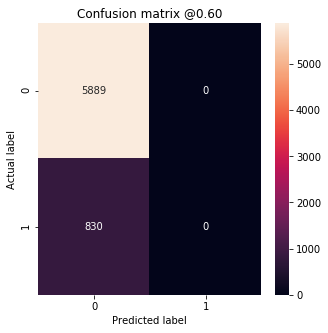

Not Planets Properly Categorized (True Negatives):  5889
Not Planets Categorized as Planets Detected (False Positives):  0
Planets Missed (False Negatives):  830
Planets Properly Categorized (True Positives):  0
Total Planets:  830
Accuracy:  0.8764697127548743


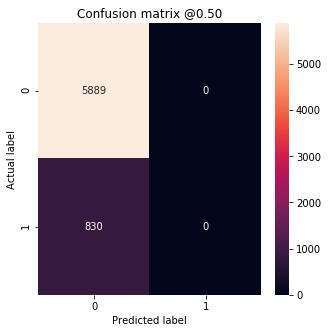

Not Planets Properly Categorized (True Negatives):  5889
Not Planets Categorized as Planets Detected (False Positives):  0
Planets Missed (False Negatives):  830
Planets Properly Categorized (True Positives):  0
Total Planets:  830
Accuracy:  0.8764697127548743


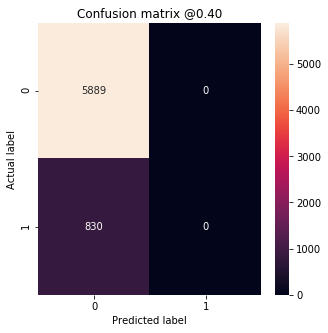

Not Planets Properly Categorized (True Negatives):  5889
Not Planets Categorized as Planets Detected (False Positives):  0
Planets Missed (False Negatives):  830
Planets Properly Categorized (True Positives):  0
Total Planets:  830
Accuracy:  0.8764697127548743


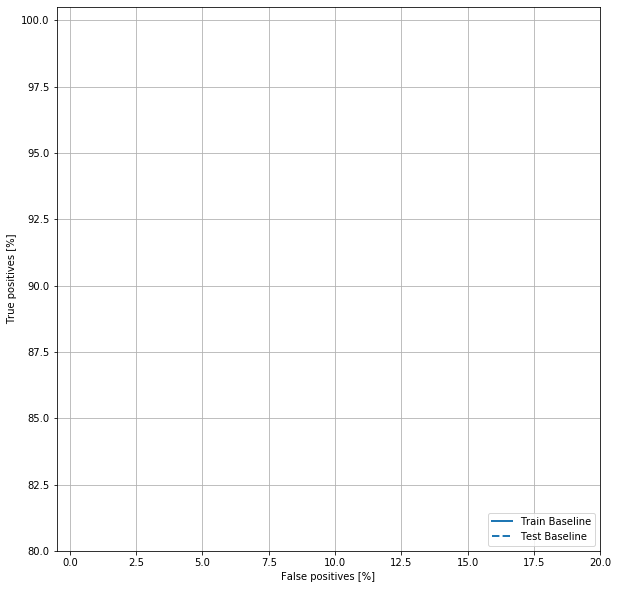

In [15]:
plot_cm(Y_val, val_predictions_baseline,p=.6)
plot_cm(Y_val, val_predictions_baseline)
plot_cm(Y_val, val_predictions_baseline,p=.4)


plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

#### Model utility functions

In [ ]:
#graphical evaluation of model

val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

plot_metrics(history)

plot_cm(Y_val, val_predictions_baseline,p=.6)
plot_cm(Y_val, val_predictions_baseline)
plot_cm(Y_val, val_predictions_baseline,p=.4)


plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
#save model
model.save(os.path.join(MODEL_DIR,'normal_model'))

In [ ]:
#picture of model
tf.keras.utils.plot_model(
    model, to_file=os.path.join(MODEL_DIR,'model.png'), show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)

In [ ]:
#load model
model = tf.keras.models.load_model(os.path.join(MODEL_DIR,'normal_model'))
model.summary()

#### Create Disposition Prediction for Entire Dataset and Save CSV

In [ ]:
full_predictions = model.predict([x_local,x_global])
#full_predictions

print(full_predictions.shape)
print(Y.shape)
plot_cm(Y, full_predictions)

processed_final=processed.copy()
processed_final['w2p_score']=full_predictions
processed_final['w2p_disposition']='FALSE POSITIVE'
processed_final.loc[processed_final.w2p_score>=0.5,['w2p_disposition']]='CONFIRMED'
processed_final.replace({'koi_disposition':
                   {'1-CONFIRMED':'CONFIRMED','0-FALSE POSITIVE':'FALSE POSITIVE'}},
                  inplace=True)

#key columns to compare
#koi_disposition
#https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html
#https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html (has AV descriptions)
#koi_pdisposition and koi_score are ROBOVETTER outcomes (where available)
print('w2p_disposition:',processed_final.w2p_disposition.value_counts())
print('koi disposition:',processed_final.koi_disposition.value_counts())
print('koi pdisposition:',processed_final.koi_pdisposition.value_counts())
print('koi pdisposition:',processed_final.koi_pdisposition.value_counts())

#av_pp_pc is posterior probability score from autovetter model (where available).  
#Have divided by 100 to make comparable to koi_score
#and created a column representing AV disposition / unclear how differs from av_pred_class
processed_final.av_vf_pc=processed_final.av_vf_pc/100
processed_final['av_disposition']='FALSE POSITIVE'
processed_final.loc[processed_final.av_vf_pc>.5,['av_disposition']]='CONFIRMED'
print('AV disposition:',processed_final.av_disposition.value_counts())

#replacing koi_score with zero where NAN.  Only 8000 of TCEs had koi_score and koi_pdisposition (ie robovetter)
#same with av_vf_pc
processed_final.koi_score.fillna(0,inplace=True)
processed_final.av_vf_pc.fillna(0,inplace=True)

#koi_score is RV monte carlo prob.  koi_pdisposition is some subjective measure beyond RV score
processed_final[(processed_final.koi_score>=0.5)&(processed_final.koi_pdisposition=='FALSE POSITIVE')][[
    'kepid','tce_plnt_num','koi_disposition','koi_score','koi_pdisposition','w2p_score','w2p_disposition','av_disposition','av_vf_pc']]

print(processed_final[[
    'kepid','tce_plnt_num','koi_disposition',
    'w2p_score','w2p_disposition',
    'koi_score','koi_pdisposition',
    'av_disposition','av_vf_pc']])

processed_final.to_csv(os.path.join(PROCESSED_DATA_DIR,'processed_final.csv'),index=False)

#### Key column descriptions
- koi_disposition:  ground truth
- w2p_score: w2p probability
- w2p_disposition: w2p disposition
- koi_score: robovetter probability
- koi_pdisposition: robovetter disposition (though does not exactly match up with koi_score>0.5- unclear why)
- av_disposition: autovetter disposition (does not exactly match up with av_vf_pc>0- unclear why)
- av_vf_pc: autovetter probability (not posterior)

Links for other column descriptions:

https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

https://exoplanetarchive.ipac.caltech.edu/docs/API_tce_columns.html (has AV descriptions)

#### Error Analysis

In [ ]:
val_results=pd.DataFrame({'truth':Y_val, 'prediction':np.squeeze(val_predictions_baseline)})
val_results['truth_delta']=val_results.truth-val_results.prediction
val_results=val_results.sort_values('truth_delta')

val_results['result']='True Positive'
val_results.loc[val_results.truth_delta<0,'result']='True Negative' #then some get replaced by false positive
val_results.loc[val_results.truth_delta<=-0.5,'result']='False Positive'
val_results.loc[val_results.truth_delta>=0.5,'result']='False Negative'

print(val_results.result.value_counts())

cutoff=.05
val_results_mod=val_results[(val_results.truth_delta<-cutoff)|(val_results.truth_delta>cutoff)]
ax = sns.histplot(data=val_results_mod, 
                  x="truth_delta",
                  hue='result').set_title('Distribution of Deltas (excluding vast majority between -.05 and .05)')


val_results_mod=val_results[(val_results.prediction>cutoff)]
ax = sns.histplot(data=val_results_mod, 
                  x="prediction",
                  hue='result',
                  multiple='stack',
                  bins=30).set_title('Distribution of Validation Set Predictions (excluding true negatives <0.05)')

plt.axvline(0.5,0,30)

false_positives=val_results[val_results.truth_delta<=-.5]
print(false_positives.shape)
false_positives

tce_number=835
chart(tce_number,tce_id,val_results,x_global_val,x_local_val)

print(val_results.result[790])

false_negatives=val_results[val_results.truth_delta>=0.5].sort_values('truth_delta',ascending=False)
print (false_negatives.shape)
false_negatives

tce_number=629
chart_curves(9999,0,
             'FALSE NEGATIVE',
             x_global_val[tce_number],x_local_val[tce_number])

print(val_results[val_results.result=='True Positive'].sort_values('prediction',ascending=False))
tce_number=118
chart_curves(9999,0,
             'TRUE POSITIVE',
             x_global_val[tce_number],x_local_val[tce_number])

print(val_results[val_results.result=='True Negative'].sort_values('prediction',ascending=True))
tce_number=135
chart_curves(9999,0,
             'TRUE NEGATIVE',
             x_global_val[tce_number],x_local_val[tce_number])

In [ ]:
baseline_results = model.evaluate([x_local_train,x_global_train],Y_train,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

#### CVRandomSearch (but using Keras Hypertune above)

In [ ]:
cnn_global_filters_opts=[[16,32,64,128,256],[16,32],[32,64,128]]
cnn_global_kernel_opts=[5,2,3,7]
cnn_global_maxpool_window_opts=[3,5,7]
cnn_global_maxpool_stride_opts=[1,2,3]
cnn_local_filters_opts=[[16,32],[8,16,32],[8,16,32,64]]
cnn_local_kernel_opts=[5,2,3,7]
cnn_local_maxpool_window_opts=[5,7,9]
cnn_local_maxpool_stride_opts=[1,2,3]
fc_dropout_rate_opts  = [0, 0.2, 0.5]
fc_layers_opts = [[64, 64, 64, 64], [128, 128, 128], [512,512,512,512],[256,256,256]]
l2_penalty_opts = [0.01, 0.1, 0.5]
activation_opts=['relu','prelu']
optimizer_opts=['adam']
epochs_opts=[10,15,20]
batch_size_opts=[64,96,128]


keras_param_options = {
    'cnn_global_filters':cnn_global_filters_opts,
    'cnn_global_kernel':cnn_global_kernel_opts,
    'cnn_global_maxpool_window':cnn_global_maxpool_window_opts,
    'cnn_global_maxpool_stride':cnn_global_maxpool_stride_opts,
    'cnn_local_filters':cnn_local_filters_opts,
    'cnn_local_kernel':cnn_local_kernel_opts,
    'cnn_local_maxpool_window':cnn_local_maxpool_window_opts,
    'cnn_local_maxpool_stride':cnn_local_maxpool_stride_opts,
    'fc_layers': fc_layers_opts,
    'fc_dropout_rate':fc_dropout_rate_opts,
    'l2_penalty': l2_penalty_opts,
    'activation':activation_opts,
    'optimizer':optimizer_opts,
    'epochs':epochs_opts,
    'batch_size':batch_size_opts
}

def make_cnn_model(param)
    model = Sequential()   
    
    
    input_local = tf.keras.layers.Input(shape=[x_local.shape[1],1])
    input_global=tf.keras.layers.Input(shape=[x_global.shape[1],1])
    
    #combi_input = tf.keras.layers.Input((2,)) # (None, 3)
    #input_local = Lambda(lambda x: tf.expand_dims(x[:,0],-1))(combi_input) # (None, 1) 
    #input_global = Lambda(lambda x: tf.expand_dims(x[:,1],-1))(combi_input) # (None, 1)
    
    
    
    #build global branch
    for index, filters in enumerate(cnn_global_filters):       
        if not index:
            k_global=tf.keras.layers.Conv1D(filters=filters,
                                            kernel_size=cnn_global_kernel,
                                            activation=activation)(input_global)
        else:
            k_global=tf.keras.layers.Conv1D(filters=filters,
                                            kernel_size=cnn_global_kernel,
                                            activation=activation)(k_global)
        
        k_global=tf.keras.layers.MaxPooling1D(pool_size=cnn_global_window,
                                              strides=cnn_global_stride,padding='same')(k_global)
    
    #build local branch
    for index, filters in enumerate(cnn_local_filters):       
        if not index:
            k_local=tf.keras.layers.Conv1D(filters=filters,
                                            kernel_size=cnn_local_kernel,
                                            activation=activation)(input_local)
        else:
            k_local=tf.keras.layers.Conv1D(filters=filters,
                                            kernel_size=cnn_local_kernel,
                                            activation=activation)(k_local)
        
        k_local=tf.keras.layers.MaxPooling1D(pool_size=cnn_local_window,
                                              strides=cnn_local_stride,padding='same')(k_local)
    #flatten and concatenate
    k_global=tf.keras.layers.Flatten()(k_global)
    k_local=tf.keras.layers.Flatten()(k_local)
    k = tf.keras.layers.concatenate([k_local, k_global])
    
    #now add dense layers
    for fc_layer in fc_layers:
            k=tf.keras.layers.Dense(fc_layer,activation=activation)(k)
            k=tf.keras.layers.Dropout(fc_dropout_rate)(k)
    
    #output layer        
    output=tf.keras.layers.Dense(1,activation='sigmoid')(k)

    model=tf.keras.Model(inputs=[input_local,input_global],outputs=output)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy()
                  ,optimizer=optimizer,
                  metrics=METRICS)
    return model

#randomizedsearchcv
#but will not take multiple inputs

model_keras = tf.keras.wrappers.scikit_learn.KerasClassifier(
    build_fn = make_cnn_model
    )

# specify other extra parameters pass to the .fit
# number of epochs is set to a large number, we'll
# let early stopping terminate the training process
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

callbacks = [early_stop]

keras_fit_params = {   
    'callbacks': callbacks,
    'epochs': 20,
    'batch_size': 96,
    'validation_data': ([x_local_val,x_global_val], Y_val),
    'verbose': 1
}

rs_keras = RandomizedSearchCV( 
    model_keras, 
    param_distributions = keras_param_options,
    fit_params = keras_fit_params,
    scoring = 'neg_log_loss',
    n_iter = 3, 
    cv = 3,
    n_jobs = -1,
    verbose = 1
)


combi_input = np.stack([x_local_train, x_global_train], axis=-1)
#see https://stackoverflow.com/questions/56824968/grid-search-for-keras-with-multiple-inputs/62512554#62512554
rs_keras.fit([x_local_train,x_global_train], Y_train)
rs_keras.fit(combi_input, Y_train)

#rs_keras.fit([x_local_train,x_global_train],
#                  Y_train,
#                  validation_data=([x_local_val,x_global_val],Y_val),
#                  batch_size=BATCH_SIZE,
#                  epochs=EPOCHS,
#                  callbacks=[early_stopping],
#                  verbose=1)

print('Best score obtained: {0}'.format(rs_keras.best_score_))
print('Parameters:')
for param, value in rs_keras.best_params_.items():
    print('\t{}: {}'.format(param, value))


#### Old model work
- setting initial bias
- train simple model

In [ ]:
#work on setting initial bias
tf.keras.backend.clear_session()
model=make_model()
model.predict([x_local_train[:10],x_global_train[:10]])
results = model.evaluate([x_local_train,x_global_train],Y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))
neg, pos = np.bincount(Y)
total = neg + pos
print(neg,pos,total)
initial_bias=np.log([pos/neg])
print(initial_bias)
model = make_model(output_bias = initial_bias)
model.predict([x_local_train[:10],x_global_train[:10]])
results = model.evaluate([x_local_train,x_global_train],Y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))

initial_weights = os.path.join(MODEL_DIR,'initial_weights')
model.save_weights(initial_weights)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

tf.keras.backend.clear_session()
model=make_model()
model.load_weights(initial_weights)

#history=model.fit([x_local_train,x_global_train],
#                  Y_train,
#                  validation_data=([x_local_val,x_global_val],Y_val),
#                  steps_per_epoch=25,
#                  epochs=EPOCHS*20,
#                  callbacks=[early_stopping],
#                  verbose=1)

EPOCHS=20

history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  callbacks=[early_stopping],
                  verbose=1)



#### Class weighting to deal with unbalanced classes

In [ ]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
tf.keras.backend.clear_session()
model=make_model()
#model.load_weights(initial_weights)

history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  class_weight=class_weight,
                  callbacks=[early_stopping],
                  verbose=2)

In [ ]:
plot_metrics(history)
plot_cm(Y_val, val_predictions_baseline)

val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

#### Oversampling to deal with unbalanced classes

In [ ]:
#oversampling
bool_train_labels = Y_train != 0
pos_features_local = x_local_train[bool_train_labels]
neg_features_local = x_local_train[~bool_train_labels]
pos_features_global = x_global_train[bool_train_labels]
neg_features_global = x_global_train[~bool_train_labels]

pos_labels = Y_train[bool_train_labels]
neg_labels = Y_train[~bool_train_labels]

In [ ]:
ids = np.arange(len(pos_features_local))
choices = np.random.choice(ids, len(neg_features_local))

res_pos_features_local = pos_features_local[choices]
res_pos_features_global = pos_features_global[choices]
res_pos_labels = pos_labels[choices]

print(res_pos_features_local.shape,res_pos_features_global.shape)

In [ ]:
res_features_local=np.concatenate([res_pos_features_local,neg_features_local],axis=0)
res_features_global=np.concatenate([res_pos_features_global,neg_features_global],axis=0)
res_labels=np.concatenate([res_pos_labels,neg_labels],axis=0)
order=np.arange(len(res_labels))
np.random.shuffle(order)
res_features_local=res_features_local[order]
res_features_global=res_features_global[order]
res_labels=res_labels[order]
print(res_features_local.shape,res_features_global.shape,res_labels.shape)

In [ ]:
tf.keras.backend.clear_session()
model=make_model()
history = model.fit(
        [res_features_local,res_features_global],
        res_labels,
        validation_data=([x_local_val,x_global_val],Y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=2)


In [ ]:
plot_metrics(history)
plot_cm(Y_val, val_predictions_baseline)

val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

#### S3 functions

In [ ]:
def upload_model(model_dir,bucket_name):
    #s3_client=boto3.client('s3')
    session = boto3.Session()
    s3 = session.resource('s3')
    bucket = s3.Bucket(bucket_name)
    for subdir, dirs, files in os.walk(model_dir):
        for file in files:
            full_path = os.path.join(subdir, file)
            with open(full_path, 'rb') as data:
                bucket.put_object(Key=full_path[len(model_dir)+1:], Body=data)

bucket_name='w251-final-project-model'
upload_model(model_dir,bucket_name)